In [1]:
_server_root = ""
_data_uuid = ""
_result_path = ""


In [2]:
# Parameters
_server_root = "/home/lyiran/neelptycho/server"
_data_uuid = "ba8b1be3-25b2-5124-a444-d4a94ab2050d"
_result_path = (
    "/home/lyiran/neelptycho/server/results/task_SimpleSimMag3_ePIE_padding_2"
)


In [3]:
import uuid
data_uuid = uuid.UUID(_data_uuid)
from pathlib import Path
result_path = Path(_result_path)
import sys, os
sys.path.append(_server_root)

In [4]:
# Timer
import time
start_time = time.time()

## ePIE Analysis

In [5]:
from library.data import get_data_path
import yaml
from library.utils import load_params, add_colordisk_hsv, complex_to_hsv, with_default_unit
import h5py
import tables
data_path = get_data_path(data_uuid)
p = load_params("ePIE")
with h5py.File(data_path, "r") as file:
    attrs = dict(file.attrs)
    dp_shape = file["/data"].shape[-2:]
    dps = file["/data"][()].reshape((attrs["height"], attrs["width"]) + dp_shape)

if "semiconv_pix" in p:
    attrs["semiconv_pix"] = p["semiconv_pix"]
if "rotation" in p:
    attrs["rotation"] = with_default_unit(p["rotation"], "degree")

if "defocus" not in p["ePIE"]:
    p["ePIE"]["defocus"] = 0
p["ePIE"]["defocus"] = with_default_unit(p["ePIE"]["defocus"], "m")

In [6]:
from epie.param_manager import ParamTree, PtychoParams, DatasetParams, NumericalParams
from epie.utils import wavelength
dataset_params = ParamTree(
    # Base dataset information
    dataset_name=attrs["name"],
    format="mib",
    acquisition_time=attrs["datetime"],
    # Scan/Diff Geometry
    scan_height_raw=attrs["height"], # the true number of scan rows acquired before pre-processing
    scan_width_raw=attrs["width"], # the true number of scan columns acquired before pre-processing
    scan_origin="top-left", # where does the scan coordinate system have its origin
                           # a string combination of 'top/bottom-left/right'
                           # top implies positive=downwards, right implies positive=leftwards
    scan_skip_rows=(0,0), # number of rows to skip at start (origin) and end of height
    scan_skip_cols=(0,0), # number of columns to skip at start (origin) and end of width
    scan_step_row_ang=attrs["stepsize"] * 1e10, # scan step in angstroms between rows
    scan_step_col_ang=attrs.get("stepsize_y", attrs["stepsize"]) * 1e10, # scan step in angstroms between columns
    scan_to_diff_rot_deg=attrs["rotation"], # rotation in degrees from a scan coordinate dimension to equivalent diffraction pattern coordinate
    diff_height_raw=dps.shape[2], # the true number of diff rows per-frame before pre-processing
    diff_width_raw=dps.shape[3], # the true number of diff columns per-frame before pre-processing
    diff_origin="top-left", # same definition as scan_origin
    # Acquisition parameters
    aperture_size_mrad=attrs["semiconv"] * 1e3,
    aperture_size_px=attrs["semiconv_pix"],
    beam_voltage_kv=attrs["voltage"],
    defocus_ang=p["ePIE"]["defocus"] * 1e10,
    pixel_size_detector_m=attrs["psize"], # in metres
    # Processed dataset dimensions
    # These values are used in preference to the above ones when present
    scan_height=attrs["height"],
    scan_width=attrs["width"],
    diff_height=dps.shape[2],
    diff_width=dps.shape[3],
    #wavelength_m=wavelength(attrs["voltage"]),
    #wavelength_pm=wavelength(attrs["voltage"])*1e12
)
reconst_params = ParamTree(
    enable_circular_cutoff=p["ePIE"].get("enable_circular_cutoff", False),
    diff_cutoff_radius_fraction=p["ePIE"]["diff_cutoff_radius_fraction"],
    diff_intensity_lower_cutoff=p["ePIE"]["diff_intensity_lower_cutoff"],
    diff_origin_shift=p["ePIE"]["diff_origin_shift"],
    diff_padding_factor=p["ePIE"]["diff_padding_factor"],
    diff_stride=p["ePIE"]["diff_stride"],
    binning_factor=p["ePIE"].get("binning_factor", 1),
    n_iteration_frozen_probe=p["ePIE"]["n_iteration_frozen_probe"],
    n_iteration_frozen_object=p["ePIE"].get("n_iteration_frozen_object", 0),
    probe_update_interval=p["ePIE"].get("probe_update_interval", 1),
    n_iteration_target=p["ePIE"]["n_iteration_target"],
    scan_stride=p["ePIE"]["scan_stride"],
    alpha=p["ePIE"]["alpha"],
    beta=p["ePIE"]["beta"],
    force_aperture_mask=p["ePIE"].get("force_aperture_mask", False),
    force_weak_phase_approx=p["ePIE"].get("force_weak_phase_approx", False),
    force_relative=p["ePIE"].get("force_relative", False)
)

import yaml
print("--- data.yaml ---")
print(yaml.dump(dataset_params))
print("--- reconst.yaml ---")
print(yaml.dump(reconst_params))

--- data.yaml ---
!!python/object/new:epie.param_manager.ParamTree
dictitems:
  acquisition_time: !!python/object/apply:numpy.core.multiarray.scalar
  - !!python/object/apply:numpy.dtype
    args:
    - S19
    - false
    - true
    state: !!python/tuple
    - 3
    - '|'
    - null
    - null
    - null
    - 19
    - 1
    - 0
  - !!binary |
    MjAyNC0wNy0wMVQxMDo0MDowMA==
  aperture_size_mrad: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - !!binary |
    AAAAAAAAFEA=
  aperture_size_px: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - !!binary |
    Mn4wS9KFCEA=
  beam_voltage_kv: !!python/object/apply:numpy.core.multiarray.scalar
  - &id002 !!python/object/apply:numpy.dtype
    args:
    - i4
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
   

In [7]:
# the pixel size of reconstructed image
cbed_dimension_reconst = dataset_params["diff_width"] / reconst_params["diff_stride"] * reconst_params["diff_padding_factor"]
resolution_reciprocal_space_rad = attrs["semiconv"] / attrs["semiconv_pix"] * reconst_params["diff_stride"]
resolution_reciprocal_space = resolution_reciprocal_space_rad / wavelength(attrs["voltage"])
resolution_real_space = 1.0 / (resolution_reciprocal_space * cbed_dimension_reconst)

print(f"Resolutions:")
print(f"  Reciprocal Space : {resolution_reciprocal_space_rad} rad")
print(f"  Reciprocal Space : {resolution_reciprocal_space / 1e10} Å^{-1}")
print(f"  Real Space       : {resolution_real_space * 1e10} Å")

Resolutions:
  Reciprocal Space : 0.0016311390926888362 rad
  Reciprocal Space : 0.03906196962496177 Å^-1
  Real Space       : 0.10000135777853325 Å


In [8]:
import numpy as np
if os.path.exists("probe_init.npy"):
    print("initial probe found")
    probe0 = np.load("probe_init.npy")
else:
    probe0 = None

if os.path.exists("object_init.npy"):
    print("initial object found")
    obj0 = np.load("object_init.npy")
else:
    obj0 = None

In [9]:
from epie.lib import run_epie
from epie.gpu_utils import set_device
from pprint import pprint
params = PtychoParams()
params["dataset"] = DatasetParams(**dataset_params)
params["numerical"] = NumericalParams(**reconst_params)

print(params.dataset.__class__)
print(params.dataset.wavelength_pm)
pprint(params)

with set_device(dev_id=1):
    obj, probe = run_epie(dps, params, results_directory=result_path, probe0=probe0, obj0=obj0)

<class 'epie.param_manager.DatasetParams'>
4.1757727742599275
{'dataset': {'acquisition_time': b'2024-07-01T10:40:00',
             'aperture_size_mrad': 5.0,
             'aperture_size_px': 3.065342509667766,
             'beam_voltage_kv': 80,
             'dataset_name': b'Simple Simulation from Mag Image Smaller Aperture',
             'defocus_ang': 0.0,
             'diff_height': 128,
             'diff_height_raw': 128,
             'diff_origin': 'top-left',
             'diff_width': 128,
             'diff_width_raw': 128,
             'format': 'mib',
             'pixel_size_detector_m': 5.5e-05,
             'scan_height': 71,
             'scan_height_raw': 71,
             'scan_origin': 'top-left',
             'scan_skip_cols': (0, 0),
             'scan_skip_rows': (0, 0),
             'scan_step_col_ang': 1.0,
             'scan_step_row_ang': 1.0,
             'scan_to_diff_rot_deg': 0,
             'scan_width': 71,
             'scan_width_raw': 71},
 'numerical

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:23, 216.43it/s]

DP iterations:   1%|          | 60/5041 [00:00<00:16, 308.90it/s]

DP iterations:   2%|▏         | 99/5041 [00:00<00:14, 344.39it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:13, 359.27it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:13, 366.07it/s]

DP iterations:   4%|▍         | 214/5041 [00:00<00:13, 369.13it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:12, 369.60it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:12, 371.02it/s]

DP iterations:   7%|▋         | 328/5041 [00:00<00:12, 373.25it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:12, 375.46it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 376.45it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 377.15it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:12, 376.05it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 376.41it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:11, 374.36it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:11, 375.54it/s]

DP iterations:  13%|█▎        | 635/5041 [00:01<00:11, 377.67it/s]

DP iterations:  13%|█▎        | 673/5041 [00:01<00:11, 377.18it/s]

DP iterations:  14%|█▍        | 711/5041 [00:01<00:11, 377.76it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:11, 378.49it/s]

DP iterations:  16%|█▌        | 788/5041 [00:02<00:11, 378.72it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:11, 378.11it/s]

DP iterations:  17%|█▋        | 864/5041 [00:02<00:11, 377.93it/s]

DP iterations:  18%|█▊        | 902/5041 [00:02<00:11, 360.81it/s]

DP iterations:  19%|█▊        | 939/5041 [00:02<00:11, 353.24it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:11, 352.21it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 346.26it/s]

DP iterations:  21%|██        | 1046/5041 [00:02<00:11, 345.36it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:02<00:11, 353.89it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:10, 360.31it/s]

DP iterations:  23%|██▎       | 1160/5041 [00:03<00:10, 364.93it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:10, 366.13it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:03<00:10, 368.18it/s]

DP iterations:  25%|██▌       | 1272/5041 [00:03<00:10, 368.68it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:03<00:10, 368.93it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:03<00:10, 365.90it/s]

DP iterations:  27%|██▋       | 1384/5041 [00:03<00:09, 367.83it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:03<00:09, 366.97it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:03<00:09, 366.31it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:09, 368.20it/s]

DP iterations:  30%|███       | 1534/5041 [00:04<00:09, 370.53it/s]

DP iterations:  31%|███       | 1572/5041 [00:04<00:09, 370.63it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 371.75it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 371.48it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:04<00:09, 372.62it/s]

DP iterations:  34%|███▍      | 1724/5041 [00:04<00:08, 373.43it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:04<00:08, 372.50it/s]

DP iterations:  36%|███▌      | 1800/5041 [00:04<00:08, 372.98it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:05<00:08, 371.44it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:05<00:08, 370.34it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:05<00:08, 370.22it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:05<00:08, 371.79it/s]

DP iterations:  39%|███▉      | 1990/5041 [00:05<00:08, 370.94it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 370.85it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 370.84it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:05<00:07, 371.01it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:05<00:07, 371.98it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:05<00:07, 372.63it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:07, 373.68it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:07, 373.77it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:06<00:07, 373.43it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:07, 373.10it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:06<00:07, 372.65it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:06<00:07, 371.28it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:06<00:06, 371.94it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:06<00:06, 371.98it/s]

DP iterations:  50%|█████     | 2522/5041 [00:06<00:06, 370.93it/s]

DP iterations:  51%|█████     | 2560/5041 [00:06<00:06, 370.59it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:07<00:06, 371.07it/s]

DP iterations:  52%|█████▏    | 2636/5041 [00:07<00:06, 371.80it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:07<00:06, 371.24it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:07<00:06, 371.71it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:07<00:06, 370.09it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:07<00:06, 371.51it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:07<00:05, 371.99it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:07<00:05, 373.45it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:07<00:05, 373.21it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:07<00:05, 374.82it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 374.43it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:08<00:05, 373.81it/s]

DP iterations:  61%|██████    | 3054/5041 [00:08<00:05, 374.27it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:08<00:05, 374.82it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:08<00:05, 376.52it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:08<00:05, 374.02it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:08<00:04, 373.48it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:08<00:04, 373.24it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:08<00:04, 372.65it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:08<00:04, 371.62it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 372.05it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 374.07it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 377.50it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:09<00:04, 377.21it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:09<00:04, 378.71it/s]

DP iterations:  70%|███████   | 3551/5041 [00:09<00:03, 372.69it/s]

DP iterations:  71%|███████   | 3589/5041 [00:09<00:03, 368.99it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 369.38it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:09<00:03, 370.94it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:10<00:03, 370.75it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:10<00:03, 371.12it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:10<00:03, 370.57it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 370.16it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:10<00:03, 370.79it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 369.76it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 369.71it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 369.31it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:10<00:02, 368.73it/s]

DP iterations:  80%|████████  | 4041/5041 [00:10<00:02, 368.82it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 369.47it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:11<00:02, 369.94it/s]

DP iterations:  82%|████████▏ | 4155/5041 [00:11<00:02, 370.51it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:11<00:02, 371.01it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:11<00:02, 371.53it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:11<00:02, 371.95it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:11<00:01, 373.43it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:11<00:01, 372.62it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:11<00:01, 372.54it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:11<00:01, 372.48it/s]

DP iterations:  88%|████████▊ | 4459/5041 [00:12<00:01, 372.65it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:12<00:01, 373.74it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:12<00:01, 374.05it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:12<00:01, 373.69it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 374.28it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:12<00:01, 374.75it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:12<00:00, 374.46it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:12<00:00, 373.22it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:12<00:00, 372.46it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:12<00:00, 372.76it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:13<00:00, 369.84it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:13<00:00, 367.83it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:13<00:00, 366.62it/s]

DP iterations:  98%|█████████▊| 4950/5041 [00:13<00:00, 365.26it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:13<00:00, 364.70it/s]

DP iterations: 100%|█████████▉| 5028/5041 [00:13<00:00, 376.08it/s]

Epochs:   1%|          | 1/100 [00:14<24:27, 14.82s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 375.92it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:13, 381.58it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:12, 382.68it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:12, 383.61it/s]

DP iterations:   4%|▍         | 194/5041 [00:00<00:12, 383.87it/s]

DP iterations:   5%|▍         | 233/5041 [00:00<00:12, 385.04it/s]

DP iterations:   5%|▌         | 272/5041 [00:00<00:12, 384.32it/s]

DP iterations:   6%|▌         | 311/5041 [00:00<00:12, 382.69it/s]

DP iterations:   7%|▋         | 350/5041 [00:00<00:12, 381.11it/s]

DP iterations:   8%|▊         | 389/5041 [00:01<00:12, 380.46it/s]

DP iterations:   8%|▊         | 428/5041 [00:01<00:12, 379.16it/s]

DP iterations:   9%|▉         | 466/5041 [00:01<00:12, 377.76it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:12, 377.17it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:11, 376.09it/s]

DP iterations:  12%|█▏        | 580/5041 [00:01<00:11, 375.46it/s]

DP iterations:  12%|█▏        | 618/5041 [00:01<00:11, 375.87it/s]

DP iterations:  13%|█▎        | 656/5041 [00:01<00:11, 375.70it/s]

DP iterations:  14%|█▍        | 695/5041 [00:01<00:11, 376.98it/s]

DP iterations:  15%|█▍        | 733/5041 [00:01<00:11, 377.82it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:11, 377.24it/s]

DP iterations:  16%|█▌        | 809/5041 [00:02<00:11, 376.76it/s]

DP iterations:  17%|█▋        | 848/5041 [00:02<00:11, 378.02it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:10, 377.86it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:10, 376.36it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:10, 375.37it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:10, 375.58it/s]

DP iterations:  21%|██        | 1038/5041 [00:02<00:10, 374.53it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:02<00:10, 374.60it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:02<00:10, 375.46it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:03<00:10, 376.46it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:10, 377.74it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:03<00:10, 377.26it/s]

DP iterations:  25%|██▌       | 1268/5041 [00:03<00:09, 378.08it/s]

DP iterations:  26%|██▌       | 1307/5041 [00:03<00:09, 380.58it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:03<00:09, 381.10it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:03<00:09, 382.70it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:03<00:09, 374.95it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:03<00:09, 373.86it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:03<00:09, 376.35it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:09, 376.29it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 376.09it/s]

DP iterations:  32%|███▏      | 1616/5041 [00:04<00:09, 377.26it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:08, 377.41it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:08, 379.76it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:04<00:08, 378.24it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:04<00:08, 377.56it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:04<00:08, 379.10it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:04<00:08, 378.09it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:04<00:08, 378.52it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:08, 377.62it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 376.95it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:05<00:08, 379.07it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:07, 378.49it/s]

DP iterations:  41%|████      | 2075/5041 [00:05<00:07, 377.18it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:07, 377.62it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:05<00:07, 377.76it/s]

DP iterations:  43%|████▎     | 2189/5041 [00:05<00:07, 376.01it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:05<00:07, 377.02it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:05<00:07, 379.33it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:07, 379.72it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 379.18it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 378.46it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:06<00:06, 379.37it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:06<00:06, 377.35it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:06<00:06, 377.28it/s]

DP iterations:  50%|█████     | 2534/5041 [00:06<00:06, 375.27it/s]

DP iterations:  51%|█████     | 2572/5041 [00:06<00:06, 375.16it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:06<00:06, 374.92it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 375.15it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 375.98it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 376.29it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:06, 375.67it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:07<00:05, 374.65it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:07<00:05, 374.58it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 375.01it/s]

DP iterations:  58%|█████▊    | 2914/5041 [00:07<00:05, 376.02it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:07<00:05, 376.49it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:07<00:05, 377.25it/s]

DP iterations:  60%|██████    | 3028/5041 [00:08<00:05, 377.63it/s]

DP iterations:  61%|██████    | 3066/5041 [00:08<00:05, 378.04it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:08<00:05, 377.35it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:08<00:05, 375.92it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:08<00:04, 375.78it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:08<00:04, 375.06it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:08<00:04, 375.89it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:08<00:04, 374.50it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:08<00:04, 375.16it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:08<00:04, 374.54it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:09<00:04, 375.55it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:09<00:04, 375.22it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:09<00:04, 377.26it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 376.47it/s]

DP iterations:  71%|███████   | 3561/5041 [00:09<00:03, 376.46it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:09<00:03, 377.06it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:09<00:03, 376.06it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:09<00:03, 376.40it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:09<00:03, 377.18it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:09<00:03, 376.68it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:10<00:03, 376.28it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:10<00:03, 375.65it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:10<00:03, 375.50it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:10<00:03, 375.34it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:10<00:02, 374.20it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:10<00:02, 375.72it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:10<00:02, 375.31it/s]

DP iterations:  80%|████████  | 4055/5041 [00:10<00:02, 375.05it/s]

DP iterations:  81%|████████  | 4093/5041 [00:10<00:02, 374.85it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:10<00:02, 374.76it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:11<00:02, 374.96it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:11<00:02, 375.81it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:11<00:02, 375.84it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:11<00:02, 376.47it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:11<00:01, 376.63it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:11<00:01, 375.26it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:11<00:01, 377.67it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:11<00:01, 377.39it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:11<00:01, 377.38it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:11<00:01, 376.18it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:12<00:01, 371.80it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:12<00:01, 372.99it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 373.70it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:12<00:01, 374.56it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:12<00:00, 376.42it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:12<00:00, 374.62it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:12<00:00, 375.42it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:12<00:00, 374.63it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:12<00:00, 374.74it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:12<00:00, 375.92it/s]

DP iterations:  98%|█████████▊| 4931/5041 [00:13<00:00, 374.64it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:13<00:00, 383.65it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:13<00:00, 393.10it/s]

Epochs:   2%|▏         | 2/100 [00:29<24:06, 14.76s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.53it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.41it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 368.78it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 370.44it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:13, 364.23it/s]

DP iterations:   4%|▍         | 225/5041 [00:00<00:13, 362.59it/s]

DP iterations:   5%|▌         | 262/5041 [00:00<00:13, 364.84it/s]

DP iterations:   6%|▌         | 300/5041 [00:00<00:12, 367.45it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 367.78it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:12, 368.25it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:12, 367.42it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:12, 367.55it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:12, 367.90it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:12, 369.44it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 368.96it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 369.78it/s]

DP iterations:  13%|█▎        | 636/5041 [00:01<00:11, 370.18it/s]

DP iterations:  13%|█▎        | 674/5041 [00:01<00:11, 371.80it/s]

DP iterations:  14%|█▍        | 712/5041 [00:01<00:11, 370.90it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:11, 372.13it/s]

DP iterations:  16%|█▌        | 788/5041 [00:02<00:11, 370.93it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:11, 369.94it/s]

DP iterations:  17%|█▋        | 863/5041 [00:02<00:11, 369.67it/s]

DP iterations:  18%|█▊        | 900/5041 [00:02<00:11, 369.66it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 369.51it/s]

DP iterations:  19%|█▉        | 974/5041 [00:02<00:11, 368.65it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:10, 368.68it/s]

DP iterations:  21%|██        | 1048/5041 [00:02<00:10, 368.68it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:02<00:10, 368.79it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:10, 369.42it/s]

DP iterations:  23%|██▎       | 1161/5041 [00:03<00:10, 370.56it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:03<00:10, 370.01it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:03<00:10, 370.59it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:03<00:10, 371.18it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:03<00:10, 370.57it/s]

DP iterations:  27%|██▋       | 1351/5041 [00:03<00:09, 370.75it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:03<00:09, 370.79it/s]

DP iterations:  28%|██▊       | 1427/5041 [00:03<00:09, 369.58it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:03<00:09, 370.33it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:09, 369.96it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:09, 370.71it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:04<00:09, 370.26it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 370.25it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:04<00:09, 370.45it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 370.33it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:04<00:08, 369.38it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:04<00:08, 368.76it/s]

DP iterations:  36%|███▌      | 1805/5041 [00:04<00:08, 368.60it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:04<00:08, 369.90it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 371.01it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 370.84it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:05<00:08, 371.75it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 370.89it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 370.08it/s]

DP iterations:  41%|████      | 2071/5041 [00:05<00:08, 370.66it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:07, 371.54it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:05<00:07, 371.56it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:05<00:07, 372.17it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:06<00:07, 372.27it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:06<00:07, 371.18it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:06<00:07, 371.23it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:07, 369.85it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:06<00:07, 370.53it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:06<00:07, 369.66it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:06<00:06, 370.30it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:06<00:06, 371.75it/s]

DP iterations:  50%|█████     | 2527/5041 [00:06<00:06, 371.12it/s]

DP iterations:  51%|█████     | 2565/5041 [00:06<00:06, 371.89it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:06, 371.91it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:07<00:06, 373.63it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:07<00:06, 375.06it/s]

DP iterations:  54%|█████▍    | 2717/5041 [00:07<00:06, 376.14it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:07<00:06, 374.61it/s]

DP iterations:  55%|█████▌    | 2793/5041 [00:07<00:06, 374.30it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:07<00:05, 373.97it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:07<00:05, 373.35it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:07<00:05, 372.09it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:07<00:05, 373.61it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 373.72it/s]

DP iterations:  60%|█████▉    | 3021/5041 [00:08<00:05, 374.26it/s]

DP iterations:  61%|██████    | 3059/5041 [00:08<00:05, 374.41it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:08<00:05, 374.42it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:08<00:05, 374.74it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:08<00:04, 374.61it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:08<00:04, 374.55it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:08<00:04, 373.91it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:08<00:04, 373.21it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:08<00:04, 373.41it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 371.32it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 372.31it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 372.28it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:09<00:04, 373.04it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:09<00:04, 372.97it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:03, 372.53it/s]

DP iterations:  71%|███████   | 3591/5041 [00:09<00:03, 372.41it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:09<00:03, 373.33it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:09<00:03, 372.20it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:09<00:03, 370.97it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 368.28it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 368.58it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:10<00:03, 370.39it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 369.78it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 369.79it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:02, 371.50it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:10<00:02, 370.63it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:10<00:02, 370.96it/s]

DP iterations:  80%|████████  | 4045/5041 [00:10<00:02, 370.21it/s]

DP iterations:  81%|████████  | 4083/5041 [00:11<00:02, 371.54it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:11<00:02, 371.31it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:11<00:02, 371.21it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:11<00:02, 370.79it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:11<00:02, 371.49it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:11<00:02, 372.26it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:11<00:01, 373.62it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:11<00:01, 372.80it/s]

DP iterations:  87%|████████▋ | 4387/5041 [00:11<00:01, 371.58it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:11<00:01, 373.23it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:12<00:01, 372.37it/s]

DP iterations:  89%|████████▉ | 4501/5041 [00:12<00:01, 372.07it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:12<00:01, 370.92it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:12<00:01, 371.79it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:12<00:01, 372.50it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:12<00:01, 371.63it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:12<00:00, 372.15it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:12<00:00, 371.26it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:12<00:00, 370.64it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:12<00:00, 371.70it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:13<00:00, 371.93it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:13<00:00, 370.87it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:13<00:00, 371.26it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 371.03it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:13<00:00, 370.95it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:13<00:00, 380.46it/s]

Epochs:   3%|▎         | 3/100 [00:44<23:45, 14.69s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 12/5041 [00:00<01:11, 70.59it/s]

DP iterations:   1%|          | 49/5041 [00:00<00:24, 205.33it/s]

DP iterations:   2%|▏         | 86/5041 [00:00<00:18, 269.36it/s]

DP iterations:   2%|▏         | 124/5041 [00:00<00:16, 306.85it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:14, 327.50it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:14, 339.18it/s]

DP iterations:   5%|▍         | 235/5041 [00:00<00:13, 348.67it/s]

DP iterations:   5%|▌         | 273/5041 [00:00<00:13, 355.59it/s]

DP iterations:   6%|▌         | 310/5041 [00:00<00:13, 359.12it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:12, 362.62it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:12, 365.15it/s]

DP iterations:   8%|▊         | 423/5041 [00:01<00:12, 366.21it/s]

DP iterations:   9%|▉         | 461/5041 [00:01<00:12, 367.55it/s]

DP iterations:  10%|▉         | 498/5041 [00:01<00:12, 367.95it/s]

DP iterations:  11%|█         | 535/5041 [00:01<00:12, 367.76it/s]

DP iterations:  11%|█▏        | 572/5041 [00:01<00:12, 367.84it/s]

DP iterations:  12%|█▏        | 609/5041 [00:01<00:12, 368.37it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:11, 368.34it/s]

DP iterations:  14%|█▎        | 683/5041 [00:01<00:11, 366.45it/s]

DP iterations:  14%|█▍        | 720/5041 [00:02<00:11, 366.89it/s]

DP iterations:  15%|█▌        | 757/5041 [00:02<00:11, 367.26it/s]

DP iterations:  16%|█▌        | 795/5041 [00:02<00:11, 368.86it/s]

DP iterations:  17%|█▋        | 832/5041 [00:02<00:11, 368.92it/s]

DP iterations:  17%|█▋        | 869/5041 [00:02<00:11, 368.50it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:11, 369.35it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 369.42it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 368.64it/s]

DP iterations:  20%|██        | 1018/5041 [00:02<00:10, 368.34it/s]

DP iterations:  21%|██        | 1055/5041 [00:03<00:10, 366.82it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:03<00:10, 362.85it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:03<00:10, 362.42it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:10, 364.57it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:03<00:10, 366.25it/s]

DP iterations:  25%|██▍       | 1241/5041 [00:03<00:10, 366.81it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:03<00:10, 367.19it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:03<00:10, 368.96it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:03<00:09, 368.97it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:03<00:09, 368.60it/s]

DP iterations:  28%|██▊       | 1427/5041 [00:04<00:09, 367.83it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:04<00:09, 367.54it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:04<00:09, 368.14it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:09, 368.05it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 368.81it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 367.44it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:09, 367.81it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 367.17it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:04<00:09, 366.75it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:04<00:08, 368.54it/s]

DP iterations:  36%|███▌      | 1800/5041 [00:05<00:08, 368.40it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:05<00:08, 367.63it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:05<00:08, 366.38it/s]

DP iterations:  38%|███▊      | 1911/5041 [00:05<00:08, 366.94it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:05<00:08, 367.83it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:08, 367.49it/s]

DP iterations:  40%|████      | 2023/5041 [00:05<00:08, 366.51it/s]

DP iterations:  41%|████      | 2060/5041 [00:05<00:08, 366.54it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:05<00:08, 365.36it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:05<00:07, 367.49it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:07, 366.20it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:06<00:07, 369.12it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:07, 369.05it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:06<00:07, 368.56it/s]

DP iterations:  46%|████▌     | 2322/5041 [00:06<00:07, 369.39it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:06<00:07, 369.70it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:06<00:07, 367.94it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:06<00:07, 367.86it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:06<00:06, 367.18it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:06<00:06, 367.88it/s]

DP iterations:  50%|█████     | 2545/5041 [00:07<00:06, 367.58it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:06, 368.15it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 368.28it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 368.02it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 367.11it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 368.61it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:07<00:06, 369.56it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:07<00:06, 369.37it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:07<00:05, 369.89it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:07<00:05, 368.77it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:08<00:05, 367.74it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:08<00:05, 368.56it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:08<00:05, 368.70it/s]

DP iterations:  60%|██████    | 3031/5041 [00:08<00:05, 369.07it/s]

DP iterations:  61%|██████    | 3069/5041 [00:08<00:05, 369.48it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:08<00:05, 369.55it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:08<00:05, 370.29it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 369.62it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:04, 369.17it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:08<00:04, 368.90it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 367.80it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 369.07it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 368.75it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:09<00:04, 369.70it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 370.08it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:09<00:04, 369.17it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:09<00:04, 369.39it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 369.67it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:09<00:03, 368.00it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:10<00:03, 369.81it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:10<00:03, 370.74it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 368.89it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 368.95it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 368.92it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 369.11it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 368.24it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 367.04it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 367.71it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 367.89it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:11<00:02, 366.87it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 367.34it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 367.91it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 366.22it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:11<00:02, 366.73it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:11<00:02, 366.15it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 367.09it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:11<00:02, 367.53it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:02, 367.33it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:11<00:01, 366.28it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 366.51it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 368.14it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:12<00:01, 369.07it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 369.55it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:12<00:01, 369.34it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:12<00:01, 369.11it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:12<00:01, 371.39it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:12<00:01, 378.95it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:12<00:00, 387.35it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:12<00:00, 393.26it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 396.89it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 399.13it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:13<00:00, 402.49it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:13<00:00, 402.96it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:13<00:00, 404.17it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 404.69it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:13<00:00, 406.10it/s]

Epochs:   4%|▍         | 4/100 [00:58<23:35, 14.75s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.71it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 364.42it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.93it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 368.24it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 368.01it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 366.69it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:12, 369.98it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 368.44it/s]

DP iterations:   7%|▋         | 335/5041 [00:00<00:12, 367.64it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 367.84it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 367.61it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 367.08it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 366.80it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:12, 368.79it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:12, 368.06it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 367.73it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:11, 368.84it/s]

DP iterations:  13%|█▎        | 670/5041 [00:01<00:11, 369.08it/s]

DP iterations:  14%|█▍        | 707/5041 [00:01<00:11, 368.34it/s]

DP iterations:  15%|█▍        | 745/5041 [00:02<00:11, 369.12it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:11, 368.60it/s]

DP iterations:  16%|█▌        | 819/5041 [00:02<00:11, 368.91it/s]

DP iterations:  17%|█▋        | 856/5041 [00:02<00:11, 368.55it/s]

DP iterations:  18%|█▊        | 894/5041 [00:02<00:11, 369.17it/s]

DP iterations:  18%|█▊        | 931/5041 [00:02<00:11, 368.04it/s]

DP iterations:  19%|█▉        | 969/5041 [00:02<00:11, 369.01it/s]

DP iterations:  20%|█▉        | 1006/5041 [00:02<00:10, 368.26it/s]

DP iterations:  21%|██        | 1043/5041 [00:02<00:10, 367.05it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:02<00:10, 368.00it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:10, 367.95it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:10, 367.45it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:10, 367.58it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:03<00:10, 368.47it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:03<00:10, 367.65it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:03<00:10, 368.25it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:03<00:10, 368.66it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:03<00:09, 369.96it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:03<00:09, 370.06it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:03<00:09, 370.50it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:04<00:09, 370.65it/s]

DP iterations:  30%|███       | 1531/5041 [00:04<00:09, 372.02it/s]

DP iterations:  31%|███       | 1569/5041 [00:04<00:09, 370.21it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:04<00:09, 371.12it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 370.69it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 368.90it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:08, 369.05it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:04<00:08, 368.87it/s]

DP iterations:  36%|███▌      | 1795/5041 [00:04<00:08, 369.58it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:04<00:08, 369.34it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:05<00:08, 369.51it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:05<00:08, 369.08it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:05<00:08, 367.97it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:05<00:08, 368.24it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 368.92it/s]

DP iterations:  41%|████      | 2056/5041 [00:05<00:08, 369.86it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:05<00:07, 371.53it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:05<00:07, 371.94it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:05<00:07, 369.90it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:05<00:07, 369.66it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:06<00:07, 368.50it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:06<00:07, 368.59it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:06<00:07, 367.92it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:06<00:07, 369.26it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:06<00:07, 369.39it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:06<00:07, 368.75it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:06, 369.28it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:06, 370.71it/s]

DP iterations:  50%|█████     | 2544/5041 [00:06<00:06, 371.38it/s]

DP iterations:  51%|█████     | 2582/5041 [00:06<00:06, 370.82it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 369.72it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 368.68it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 369.21it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 368.12it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:06, 368.08it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:07<00:06, 368.69it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:07<00:05, 368.69it/s]

DP iterations:  57%|█████▋    | 2881/5041 [00:07<00:05, 368.79it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:07<00:05, 365.93it/s]

DP iterations:  59%|█████▊    | 2955/5041 [00:08<00:05, 367.12it/s]

DP iterations:  59%|█████▉    | 2992/5041 [00:08<00:05, 367.75it/s]

DP iterations:  60%|██████    | 3030/5041 [00:08<00:05, 369.65it/s]

DP iterations:  61%|██████    | 3068/5041 [00:08<00:05, 370.03it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:08<00:05, 370.02it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:08<00:05, 370.20it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 370.51it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:08<00:04, 371.07it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:08<00:04, 370.86it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:08<00:04, 369.16it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 368.58it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 368.98it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:09<00:04, 369.61it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:09<00:04, 368.58it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:09<00:04, 368.47it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:09<00:04, 369.11it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 367.80it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:09<00:03, 368.34it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:09<00:03, 368.76it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:09<00:03, 367.97it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:10<00:03, 368.75it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 369.76it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 368.47it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:10<00:03, 367.97it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 369.84it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 369.33it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 369.19it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:10<00:02, 369.63it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:10<00:02, 369.91it/s]

DP iterations:  80%|████████  | 4043/5041 [00:10<00:02, 369.58it/s]

DP iterations:  81%|████████  | 4081/5041 [00:11<00:02, 369.67it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:11<00:02, 369.57it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:11<00:02, 370.65it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:11<00:02, 372.37it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:11<00:02, 371.41it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:11<00:02, 371.09it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:11<00:01, 371.22it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:11<00:01, 371.26it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:11<00:01, 370.78it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:11<00:01, 370.72it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:12<00:01, 370.94it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:12<00:01, 369.80it/s]

DP iterations:  90%|████████▉ | 4536/5041 [00:12<00:01, 369.99it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:12<00:01, 369.90it/s]

DP iterations:  91%|█████████▏| 4610/5041 [00:12<00:01, 369.80it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:12<00:01, 369.38it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:12<00:00, 369.43it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:12<00:00, 364.82it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:12<00:00, 364.72it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:12<00:00, 365.82it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:13<00:00, 366.52it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:13<00:00, 367.55it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:13<00:00, 368.13it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:13<00:00, 368.59it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:13<00:00, 371.15it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 370.58it/s]

Epochs:   5%|▌         | 5/100 [01:13<23:20, 14.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 360.63it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.31it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 367.10it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 368.90it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:13, 369.26it/s]

DP iterations:   4%|▍         | 225/5041 [00:00<00:13, 369.35it/s]

DP iterations:   5%|▌         | 262/5041 [00:00<00:12, 367.88it/s]

DP iterations:   6%|▌         | 299/5041 [00:00<00:12, 367.73it/s]

DP iterations:   7%|▋         | 336/5041 [00:00<00:12, 367.79it/s]

DP iterations:   7%|▋         | 373/5041 [00:01<00:12, 368.25it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:12, 368.83it/s]

DP iterations:   9%|▉         | 449/5041 [00:01<00:12, 369.49it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:12, 369.64it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:12, 368.50it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 367.85it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 368.87it/s]

DP iterations:  13%|█▎        | 636/5041 [00:01<00:11, 370.75it/s]

DP iterations:  13%|█▎        | 674/5041 [00:01<00:11, 369.91it/s]

DP iterations:  14%|█▍        | 711/5041 [00:01<00:11, 369.12it/s]

DP iterations:  15%|█▍        | 748/5041 [00:02<00:11, 369.15it/s]

DP iterations:  16%|█▌        | 785/5041 [00:02<00:11, 368.20it/s]

DP iterations:  16%|█▋        | 822/5041 [00:02<00:11, 368.46it/s]

DP iterations:  17%|█▋        | 859/5041 [00:02<00:11, 368.44it/s]

DP iterations:  18%|█▊        | 896/5041 [00:02<00:11, 368.71it/s]

DP iterations:  19%|█▊        | 934/5041 [00:02<00:11, 369.59it/s]

DP iterations:  19%|█▉        | 971/5041 [00:02<00:11, 369.12it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:02<00:10, 369.33it/s]

DP iterations:  21%|██        | 1046/5041 [00:02<00:10, 370.87it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:02<00:10, 373.30it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:10, 375.84it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 377.18it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:10, 378.67it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:10, 379.53it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:03<00:09, 379.64it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:03<00:09, 379.16it/s]

DP iterations:  27%|██▋       | 1354/5041 [00:03<00:09, 379.26it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:03<00:09, 379.19it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:03<00:09, 378.20it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:03<00:09, 379.40it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:09, 379.09it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:09, 378.24it/s]

DP iterations:  31%|███▏      | 1583/5041 [00:04<00:09, 376.58it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 374.03it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 373.11it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:04<00:08, 372.13it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:04<00:08, 371.07it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:04<00:08, 370.95it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:08, 371.70it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:04<00:08, 369.50it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 372.41it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:08, 372.84it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 373.12it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 372.58it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 372.85it/s]

DP iterations:  41%|████      | 2077/5041 [00:05<00:07, 373.19it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:05<00:07, 372.71it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:05<00:07, 371.26it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:05<00:07, 370.99it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:05<00:07, 371.85it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:06<00:07, 370.42it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:07, 370.65it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 371.34it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 370.67it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:06<00:07, 370.25it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:06<00:06, 370.20it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:06<00:06, 369.84it/s]

DP iterations:  50%|█████     | 2532/5041 [00:06<00:06, 369.40it/s]

DP iterations:  51%|█████     | 2570/5041 [00:06<00:06, 369.69it/s]

DP iterations:  52%|█████▏    | 2607/5041 [00:07<00:06, 369.48it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:07<00:06, 369.47it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:07<00:06, 370.67it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 369.06it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:07<00:06, 365.81it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:07<00:06, 366.74it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:07<00:06, 367.59it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:07<00:05, 368.44it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:07<00:05, 368.44it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:07<00:05, 369.94it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:08<00:05, 369.07it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:08<00:05, 369.42it/s]

DP iterations:  61%|██████    | 3057/5041 [00:08<00:05, 369.46it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 369.06it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:08<00:05, 368.29it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:08<00:05, 369.61it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:08<00:04, 368.76it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:08<00:04, 368.23it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:08<00:04, 367.99it/s]

DP iterations:  66%|██████▌   | 3318/5041 [00:08<00:04, 368.70it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:09<00:04, 367.99it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:09<00:04, 367.23it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 368.29it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:09<00:04, 367.78it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:09<00:04, 367.57it/s]

DP iterations:  70%|███████   | 3541/5041 [00:09<00:04, 367.23it/s]

DP iterations:  71%|███████   | 3579/5041 [00:09<00:03, 368.19it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:09<00:03, 368.25it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:09<00:03, 369.60it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:09<00:03, 369.76it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:10<00:03, 369.48it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:10<00:03, 369.60it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:10<00:03, 370.63it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:10<00:03, 370.60it/s]

DP iterations:  77%|███████▋  | 3880/5041 [00:10<00:03, 369.77it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:10<00:03, 369.61it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:10<00:02, 369.96it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:10<00:02, 369.32it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:10<00:02, 371.45it/s]

DP iterations:  81%|████████  | 4068/5041 [00:10<00:02, 372.38it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 371.48it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:11<00:02, 371.26it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 370.48it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:11<00:02, 370.11it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:11<00:02, 369.80it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:11<00:02, 368.95it/s]

DP iterations:  86%|████████▌ | 4333/5041 [00:11<00:01, 369.68it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:11<00:01, 368.18it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:11<00:01, 367.69it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:11<00:01, 367.80it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:12<00:01, 366.75it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 366.42it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 366.57it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:12<00:01, 367.64it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:12<00:01, 368.63it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:12<00:01, 368.13it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:12<00:00, 369.55it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:12<00:00, 370.23it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:12<00:00, 369.60it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:13<00:00, 370.10it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 369.77it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:13<00:00, 369.54it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:13<00:00, 369.61it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 369.72it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:13<00:00, 369.89it/s]

Epochs:   6%|▌         | 6/100 [01:28<23:15, 14.84s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 362.64it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.01it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 364.81it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 366.98it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 366.94it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.87it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:12, 368.15it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 369.68it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 373.20it/s]

DP iterations:   7%|▋         | 376/5041 [00:01<00:12, 375.78it/s]

DP iterations:   8%|▊         | 415/5041 [00:01<00:12, 377.62it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:12, 378.58it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:12, 378.04it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:11, 378.34it/s]

DP iterations:  11%|█▏        | 569/5041 [00:01<00:11, 379.04it/s]

DP iterations:  12%|█▏        | 607/5041 [00:01<00:11, 378.46it/s]

DP iterations:  13%|█▎        | 645/5041 [00:01<00:11, 378.44it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:11, 379.02it/s]

DP iterations:  14%|█▍        | 723/5041 [00:01<00:11, 379.43it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:11, 379.12it/s]

DP iterations:  16%|█▌        | 799/5041 [00:02<00:11, 379.27it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:11, 378.70it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:11, 377.56it/s]

DP iterations:  18%|█▊        | 914/5041 [00:02<00:10, 378.19it/s]

DP iterations:  19%|█▉        | 952/5041 [00:02<00:10, 378.44it/s]

DP iterations:  20%|█▉        | 991/5041 [00:02<00:10, 379.04it/s]

DP iterations:  20%|██        | 1029/5041 [00:02<00:10, 379.14it/s]

DP iterations:  21%|██        | 1068/5041 [00:02<00:10, 379.82it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:02<00:10, 380.12it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:03<00:10, 379.37it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 379.07it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:10, 375.98it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 373.54it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 372.06it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:09, 370.63it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:03<00:09, 370.46it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:03<00:09, 370.72it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:03<00:09, 370.69it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:03<00:09, 369.32it/s]

DP iterations:  30%|███       | 1526/5041 [00:04<00:09, 369.80it/s]

DP iterations:  31%|███       | 1563/5041 [00:04<00:09, 369.48it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:04<00:09, 368.53it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 367.42it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:09, 368.83it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:04<00:09, 369.10it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:04<00:08, 369.73it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:04<00:08, 369.00it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:04<00:08, 368.90it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:04<00:08, 369.25it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:05<00:08, 368.80it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:05<00:08, 368.56it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 368.31it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 368.96it/s]

DP iterations:  41%|████      | 2049/5041 [00:05<00:08, 369.43it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:08, 368.10it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:05<00:07, 368.24it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:05<00:07, 367.63it/s]

DP iterations:  44%|████▎     | 2197/5041 [00:05<00:07, 366.91it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:05<00:07, 367.60it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:06<00:07, 368.41it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 369.45it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:07, 368.87it/s]

DP iterations:  47%|████▋     | 2385/5041 [00:06<00:07, 369.71it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:07, 369.19it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:06<00:07, 368.45it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:06<00:06, 367.88it/s]

DP iterations:  50%|█████     | 2533/5041 [00:06<00:06, 367.21it/s]

DP iterations:  51%|█████     | 2570/5041 [00:06<00:06, 367.56it/s]

DP iterations:  52%|█████▏    | 2607/5041 [00:07<00:06, 368.17it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:07<00:06, 369.07it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:07<00:06, 369.24it/s]

DP iterations:  54%|█████▍    | 2719/5041 [00:07<00:06, 368.21it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:07<00:06, 369.84it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:07<00:06, 369.73it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:07<00:06, 367.54it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:07<00:05, 367.96it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:07<00:05, 369.06it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:07<00:05, 368.57it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:08<00:05, 369.43it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:08<00:05, 369.08it/s]

DP iterations:  61%|██████    | 3055/5041 [00:08<00:05, 368.56it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:08<00:05, 367.76it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 367.17it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:08<00:05, 368.56it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:08<00:04, 370.12it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:08<00:04, 370.35it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:08<00:04, 370.35it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:08<00:04, 370.11it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 368.06it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 369.63it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 369.52it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:09<00:04, 368.42it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:09<00:04, 368.58it/s]

DP iterations:  70%|███████   | 3543/5041 [00:09<00:04, 368.22it/s]

DP iterations:  71%|███████   | 3581/5041 [00:09<00:03, 369.86it/s]

DP iterations:  72%|███████▏  | 3618/5041 [00:09<00:03, 369.46it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:09<00:03, 370.81it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:09<00:03, 369.45it/s]

DP iterations:  74%|███████▍  | 3731/5041 [00:10<00:03, 367.55it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:10<00:03, 370.00it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:10<00:03, 368.57it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 369.89it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 369.34it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 368.25it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:10<00:02, 369.19it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:10<00:02, 368.60it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:10<00:02, 368.67it/s]

DP iterations:  81%|████████  | 4068/5041 [00:10<00:02, 368.53it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:11<00:02, 368.24it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:11<00:02, 367.50it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:11<00:02, 367.49it/s]

DP iterations:  84%|████████▎ | 4216/5041 [00:11<00:02, 366.20it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:11<00:02, 366.08it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:11<00:02, 367.02it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:11<00:01, 367.94it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:11<00:01, 369.05it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:11<00:01, 368.60it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:11<00:01, 368.58it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:12<00:01, 368.15it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:12<00:01, 368.01it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 368.71it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:12<00:01, 369.09it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:12<00:01, 370.41it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:12<00:01, 371.49it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:12<00:00, 370.28it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:12<00:00, 369.40it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:12<00:00, 370.43it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:12<00:00, 371.26it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:13<00:00, 371.76it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:13<00:00, 370.59it/s]

DP iterations:  98%|█████████▊| 4931/5041 [00:13<00:00, 370.37it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 370.57it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:13<00:00, 374.20it/s]

Epochs:   7%|▋         | 7/100 [01:43<22:52, 14.75s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 364.98it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 365.58it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.97it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 368.13it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:13, 369.42it/s]

DP iterations:   4%|▍         | 224/5041 [00:00<00:13, 369.16it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:12, 368.59it/s]

DP iterations:   6%|▌         | 299/5041 [00:00<00:12, 369.33it/s]

DP iterations:   7%|▋         | 336/5041 [00:00<00:12, 367.87it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:12, 368.96it/s]

DP iterations:   8%|▊         | 412/5041 [00:01<00:12, 370.41it/s]

DP iterations:   9%|▉         | 450/5041 [00:01<00:12, 370.88it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:12, 370.04it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:12, 370.26it/s]

DP iterations:  11%|█         | 564/5041 [00:01<00:12, 369.83it/s]

DP iterations:  12%|█▏        | 602/5041 [00:01<00:11, 370.04it/s]

DP iterations:  13%|█▎        | 640/5041 [00:01<00:11, 371.33it/s]

DP iterations:  13%|█▎        | 678/5041 [00:01<00:11, 370.01it/s]

DP iterations:  14%|█▍        | 716/5041 [00:01<00:11, 370.55it/s]

DP iterations:  15%|█▍        | 754/5041 [00:02<00:11, 370.84it/s]

DP iterations:  16%|█▌        | 792/5041 [00:02<00:11, 371.59it/s]

DP iterations:  16%|█▋        | 830/5041 [00:02<00:11, 370.27it/s]

DP iterations:  17%|█▋        | 868/5041 [00:02<00:11, 371.44it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:11, 371.44it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 370.95it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:10, 370.94it/s]

DP iterations:  20%|██        | 1020/5041 [00:02<00:10, 370.31it/s]

DP iterations:  21%|██        | 1058/5041 [00:02<00:10, 370.30it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:02<00:10, 369.33it/s]

DP iterations:  22%|██▏       | 1133/5041 [00:03<00:10, 369.06it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:03<00:10, 369.24it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:10, 369.13it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:03<00:10, 369.38it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:03<00:10, 368.85it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:03<00:10, 368.73it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:03<00:10, 367.19it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:03<00:09, 368.07it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:03<00:09, 367.82it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:03<00:09, 368.51it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:09, 369.08it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:09, 368.49it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:09, 368.32it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:04<00:09, 367.50it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:04<00:09, 368.73it/s]

DP iterations:  34%|███▎      | 1695/5041 [00:04<00:09, 369.91it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:04<00:08, 368.30it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:04<00:08, 368.63it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:04<00:08, 370.14it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:04<00:08, 369.37it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:05<00:08, 369.95it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:08, 369.99it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 371.83it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 371.28it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 370.55it/s]

DP iterations:  41%|████      | 2073/5041 [00:05<00:08, 370.21it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:05<00:07, 370.34it/s]

DP iterations:  43%|████▎     | 2149/5041 [00:05<00:07, 370.30it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:05<00:07, 365.96it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:06<00:07, 365.94it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:06<00:07, 365.71it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:06<00:07, 367.95it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:06<00:07, 367.84it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 367.92it/s]

DP iterations:  48%|████▊     | 2411/5041 [00:06<00:07, 368.54it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:06<00:07, 368.23it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:06<00:06, 368.61it/s]

DP iterations:  50%|█████     | 2523/5041 [00:06<00:06, 368.78it/s]

DP iterations:  51%|█████     | 2560/5041 [00:06<00:06, 369.13it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:07<00:06, 369.38it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:07<00:06, 370.60it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 369.46it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:07<00:06, 370.26it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:07<00:06, 369.88it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:07<00:06, 369.64it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:07<00:05, 369.69it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:07<00:05, 368.96it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:07<00:05, 368.44it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:07<00:05, 367.82it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:05, 369.98it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 369.42it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 368.96it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 366.70it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:08<00:05, 367.60it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:08<00:05, 367.07it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:08<00:05, 367.91it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:08<00:04, 368.28it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 368.04it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:08<00:04, 369.15it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:09<00:04, 368.53it/s]

DP iterations:  67%|██████▋   | 3381/5041 [00:09<00:04, 368.16it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:09<00:04, 369.61it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:09<00:04, 369.66it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:09<00:04, 370.63it/s]

DP iterations:  70%|███████   | 3532/5041 [00:09<00:04, 372.18it/s]

DP iterations:  71%|███████   | 3570/5041 [00:09<00:03, 371.17it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:09<00:03, 369.92it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:09<00:03, 369.58it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:09<00:03, 369.31it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:10<00:03, 369.41it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:10<00:03, 369.33it/s]

DP iterations:  75%|███████▌  | 3794/5041 [00:10<00:03, 369.85it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:10<00:03, 368.70it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:10<00:03, 368.94it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 370.16it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:10<00:02, 371.03it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:10<00:02, 371.70it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:10<00:02, 372.96it/s]

DP iterations:  80%|████████  | 4058/5041 [00:10<00:02, 371.28it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 370.22it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:11<00:02, 371.13it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 370.37it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:11<00:02, 370.61it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 371.82it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:11<00:02, 369.57it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:11<00:01, 370.60it/s]

DP iterations:  87%|████████▋ | 4362/5041 [00:11<00:01, 369.72it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:11<00:01, 369.97it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 371.36it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:12<00:01, 369.49it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:12<00:01, 370.23it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 371.03it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:12<00:01, 371.68it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:12<00:01, 371.58it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:12<00:01, 371.57it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:12<00:00, 370.15it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:12<00:00, 370.84it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:12<00:00, 371.56it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:13<00:00, 370.75it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:13<00:00, 370.89it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:13<00:00, 370.59it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:13<00:00, 370.06it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:13<00:00, 377.46it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:13<00:00, 387.58it/s]

Epochs:   8%|▊         | 8/100 [01:58<22:36, 14.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 357.61it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 358.96it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 366.27it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 368.05it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 362.44it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 363.73it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 365.49it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 367.02it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 367.07it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 369.00it/s]

DP iterations:   8%|▊         | 410/5041 [00:01<00:12, 370.21it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:12, 370.05it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:12, 370.16it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:12, 367.08it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 363.87it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 365.55it/s]

DP iterations:  13%|█▎        | 635/5041 [00:01<00:12, 363.76it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:12, 361.55it/s]

DP iterations:  14%|█▍        | 711/5041 [00:01<00:11, 368.03it/s]

DP iterations:  15%|█▍        | 749/5041 [00:02<00:11, 371.52it/s]

DP iterations:  16%|█▌        | 787/5041 [00:02<00:11, 370.77it/s]

DP iterations:  16%|█▋        | 825/5041 [00:02<00:11, 371.74it/s]

DP iterations:  17%|█▋        | 863/5041 [00:02<00:11, 373.79it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:11, 372.67it/s]

DP iterations:  19%|█▊        | 939/5041 [00:02<00:10, 373.14it/s]

DP iterations:  19%|█▉        | 977/5041 [00:02<00:10, 372.86it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:10, 371.55it/s]

DP iterations:  21%|██        | 1053/5041 [00:02<00:10, 372.20it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:02<00:10, 370.02it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:03<00:10, 370.81it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:03<00:10, 371.08it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:03<00:10, 370.21it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:03<00:10, 369.71it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:03<00:10, 368.51it/s]

DP iterations:  26%|██▌       | 1317/5041 [00:03<00:10, 368.03it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:03<00:09, 369.53it/s]

DP iterations:  28%|██▊       | 1393/5041 [00:03<00:09, 371.16it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:03<00:09, 370.97it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:03<00:09, 370.61it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:09, 370.35it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:09, 371.40it/s]

DP iterations:  31%|███▏      | 1583/5041 [00:04<00:09, 372.40it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 370.51it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 370.80it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:04<00:09, 370.56it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:04<00:08, 368.99it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:04<00:08, 370.59it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:08, 370.88it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:05<00:08, 371.72it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 371.05it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:08, 371.18it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 371.18it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 369.31it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 370.68it/s]

DP iterations:  41%|████      | 2077/5041 [00:05<00:07, 371.02it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:05<00:07, 369.17it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:05<00:07, 370.33it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:05<00:07, 371.60it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:06<00:07, 370.57it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:06<00:07, 371.38it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:07, 370.99it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 369.19it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 371.26it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:06<00:07, 370.29it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:06<00:06, 369.93it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:06<00:06, 370.96it/s]

DP iterations:  50%|█████     | 2533/5041 [00:06<00:06, 370.44it/s]

DP iterations:  51%|█████     | 2571/5041 [00:06<00:06, 369.51it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:07<00:06, 369.80it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:07<00:06, 368.55it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 369.39it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:07<00:06, 371.04it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 370.31it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:07<00:06, 370.24it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:07<00:05, 370.01it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:07<00:05, 369.83it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:07<00:05, 370.34it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:07<00:05, 370.95it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 369.18it/s]

DP iterations:  60%|██████    | 3026/5041 [00:08<00:05, 370.80it/s]

DP iterations:  61%|██████    | 3064/5041 [00:08<00:05, 371.94it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:08<00:05, 370.68it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:08<00:05, 370.95it/s]

DP iterations:  63%|██████▎   | 3178/5041 [00:08<00:05, 370.60it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:08<00:04, 367.18it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:08<00:04, 368.64it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:08<00:04, 368.89it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:09<00:04, 370.21it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 369.77it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 370.50it/s]

DP iterations:  68%|██████▊   | 3443/5041 [00:09<00:04, 370.28it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:09<00:04, 369.77it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:09<00:04, 370.34it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 369.26it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:09<00:03, 367.47it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:09<00:03, 368.63it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:09<00:03, 369.01it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:10<00:03, 368.92it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 369.38it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 369.28it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:10<00:03, 367.97it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 370.69it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:10<00:03, 369.50it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:03, 367.60it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:10<00:02, 369.56it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:10<00:02, 371.04it/s]

DP iterations:  80%|████████  | 4045/5041 [00:10<00:02, 370.18it/s]

DP iterations:  81%|████████  | 4083/5041 [00:11<00:02, 370.65it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:11<00:02, 370.72it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:11<00:02, 370.04it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:11<00:02, 370.31it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:11<00:02, 369.86it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:02, 368.58it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:11<00:01, 368.24it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:11<00:01, 368.01it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:11<00:01, 368.26it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:11<00:01, 369.06it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:12<00:01, 373.37it/s]

DP iterations:  89%|████████▉ | 4501/5041 [00:12<00:01, 383.04it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:12<00:01, 391.38it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:12<00:01, 396.36it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 400.89it/s]

DP iterations:  93%|█████████▎| 4667/5041 [00:12<00:00, 402.53it/s]

DP iterations:  93%|█████████▎| 4708/5041 [00:12<00:00, 404.10it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:12<00:00, 405.04it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:12<00:00, 407.25it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:12<00:00, 407.56it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:13<00:00, 406.96it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:13<00:00, 407.94it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:13<00:00, 407.32it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 407.78it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:13<00:00, 407.97it/s]

Epochs:   9%|▉         | 9/100 [02:12<22:24, 14.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 372.64it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 371.12it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 372.10it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:13, 373.79it/s]

DP iterations:   4%|▍         | 190/5041 [00:00<00:12, 374.78it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:12, 374.48it/s]

DP iterations:   5%|▌         | 266/5041 [00:00<00:12, 373.73it/s]

DP iterations:   6%|▌         | 304/5041 [00:00<00:12, 373.90it/s]

DP iterations:   7%|▋         | 342/5041 [00:00<00:12, 374.92it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:12, 374.46it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:12, 373.98it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:12, 373.98it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:12, 373.70it/s]

DP iterations:  11%|█         | 532/5041 [00:01<00:12, 374.09it/s]

DP iterations:  11%|█▏        | 570/5041 [00:01<00:11, 373.68it/s]

DP iterations:  12%|█▏        | 608/5041 [00:01<00:11, 373.88it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:11, 373.41it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:11, 373.44it/s]

DP iterations:  14%|█▍        | 722/5041 [00:01<00:11, 373.55it/s]

DP iterations:  15%|█▌        | 760/5041 [00:02<00:11, 373.52it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:11, 374.60it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:11, 373.44it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 372.79it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 372.19it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:10, 372.69it/s]

DP iterations:  20%|█▉        | 988/5041 [00:02<00:10, 373.92it/s]

DP iterations:  20%|██        | 1026/5041 [00:02<00:10, 374.60it/s]

DP iterations:  21%|██        | 1064/5041 [00:02<00:10, 373.66it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:02<00:10, 375.48it/s]

DP iterations:  23%|██▎       | 1140/5041 [00:03<00:10, 376.19it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:03<00:10, 375.52it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:10, 375.99it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:03<00:10, 375.30it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:09, 376.22it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:09, 376.13it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:09, 376.64it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:03<00:09, 374.52it/s]

DP iterations:  29%|██▊       | 1444/5041 [00:03<00:09, 375.63it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:03<00:09, 376.06it/s]

DP iterations:  30%|███       | 1520/5041 [00:04<00:09, 375.81it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 375.82it/s]

DP iterations:  32%|███▏      | 1596/5041 [00:04<00:09, 376.20it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:09, 368.82it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:04<00:09, 369.30it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:04<00:08, 371.58it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:04<00:08, 371.19it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:04<00:08, 373.65it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:04<00:08, 376.90it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:04<00:08, 378.46it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:05<00:08, 379.27it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 377.10it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:05<00:08, 376.74it/s]

DP iterations:  40%|████      | 2017/5041 [00:05<00:08, 376.19it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:07, 375.00it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:05<00:07, 373.82it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:07, 373.19it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:05<00:07, 373.45it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:05<00:07, 372.93it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:05<00:07, 373.29it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:06<00:07, 373.33it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:06<00:07, 373.69it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:06<00:07, 373.15it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:06<00:07, 374.94it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:06<00:06, 373.45it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:06, 373.34it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:06<00:06, 373.77it/s]

DP iterations:  51%|█████     | 2549/5041 [00:06<00:06, 373.63it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:06<00:06, 373.20it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:06, 374.21it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 374.66it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 375.03it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:07<00:06, 374.67it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:07<00:06, 373.87it/s]

DP iterations:  56%|█████▌    | 2815/5041 [00:07<00:05, 374.34it/s]

DP iterations:  57%|█████▋    | 2853/5041 [00:07<00:05, 375.21it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:07<00:05, 374.75it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:07<00:05, 375.00it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:07<00:05, 375.02it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:08<00:05, 374.53it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 375.25it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 375.96it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:08<00:05, 374.60it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:08<00:05, 374.91it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:08<00:04, 375.78it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:08<00:04, 375.23it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:08<00:04, 374.64it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:08<00:04, 375.47it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:08<00:04, 375.01it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:09<00:04, 373.48it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:09<00:04, 371.52it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:09<00:04, 372.86it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:09<00:04, 372.65it/s]

DP iterations:  70%|███████   | 3537/5041 [00:09<00:04, 373.71it/s]

DP iterations:  71%|███████   | 3575/5041 [00:09<00:03, 373.93it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:09<00:03, 373.00it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:09<00:03, 373.27it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:09<00:03, 374.46it/s]

DP iterations:  74%|███████▍  | 3727/5041 [00:09<00:03, 374.47it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:10<00:03, 374.79it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:10<00:03, 373.11it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:10<00:03, 374.05it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:10<00:03, 373.57it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:10<00:03, 373.87it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:02, 375.73it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:10<00:02, 375.12it/s]

DP iterations:  80%|████████  | 4033/5041 [00:10<00:02, 376.92it/s]

DP iterations:  81%|████████  | 4071/5041 [00:10<00:02, 376.25it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:10<00:02, 375.66it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 375.22it/s]

DP iterations:  83%|████████▎ | 4185/5041 [00:11<00:02, 373.94it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:11<00:02, 375.43it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:11<00:02, 375.49it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:01, 377.41it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:11<00:01, 377.08it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:11<00:01, 377.38it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:11<00:01, 376.22it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:11<00:01, 375.84it/s]

DP iterations:  89%|████████▉ | 4490/5041 [00:11<00:01, 376.98it/s]

DP iterations:  90%|████████▉ | 4528/5041 [00:12<00:01, 376.66it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:12<00:01, 375.99it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:12<00:01, 376.45it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:01, 376.69it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:12<00:00, 376.83it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:12<00:00, 376.57it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:12<00:00, 376.22it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:12<00:00, 376.13it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:12<00:00, 376.33it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:12<00:00, 374.86it/s]

DP iterations:  97%|█████████▋| 4908/5041 [00:13<00:00, 374.89it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:13<00:00, 375.45it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:13<00:00, 374.68it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:13<00:00, 372.16it/s]

Epochs:  10%|█         | 10/100 [02:27<22:04, 14.72s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 334.42it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 336.96it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 338.59it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 339.82it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 340.77it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 341.92it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 342.05it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 341.93it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 342.64it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 340.45it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 339.95it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 340.52it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 341.54it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 341.69it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 341.26it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 341.80it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 342.42it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 342.27it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 342.21it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 342.55it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 342.56it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 343.12it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.31it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 343.16it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 343.77it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 343.37it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 342.90it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 343.47it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 344.16it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 344.18it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 344.59it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 344.34it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 344.07it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 343.85it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 344.38it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 343.85it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 344.03it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 343.67it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 343.53it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 342.94it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 343.37it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 342.99it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 343.25it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 344.33it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 343.79it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 345.28it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 344.42it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 345.08it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 344.96it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 345.04it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 344.91it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 344.36it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 344.57it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 343.56it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 344.30it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 344.83it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 343.91it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 343.44it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 343.70it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 343.05it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 342.74it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 343.25it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 343.30it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 343.85it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 343.97it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 343.51it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 344.21it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 345.06it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 345.34it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 344.26it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 344.66it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 343.33it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 343.75it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 343.46it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 343.66it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 343.92it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 343.03it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 342.68it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 342.16it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 342.66it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 342.59it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 342.48it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 342.34it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 343.17it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 342.98it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 342.90it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 343.19it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 343.34it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 344.26it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 344.28it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 344.59it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 343.98it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 343.76it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 342.30it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:05, 342.00it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 342.40it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 342.89it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 343.08it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 343.29it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:10<00:04, 342.48it/s]

DP iterations:  70%|███████   | 3533/5041 [00:10<00:04, 342.40it/s]

DP iterations:  71%|███████   | 3568/5041 [00:10<00:04, 342.86it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 342.46it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:04, 343.39it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 343.30it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 342.60it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 342.47it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 342.99it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:11<00:03, 343.26it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 343.33it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 343.33it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:11<00:03, 343.97it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:11<00:03, 343.36it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:11<00:03, 342.63it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:11<00:02, 342.73it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 342.88it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 343.84it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:12<00:02, 343.02it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:12<00:02, 343.40it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:12<00:02, 342.91it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 343.28it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:12<00:02, 342.88it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:12<00:02, 342.81it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:12<00:02, 343.65it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:12<00:01, 343.04it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:12<00:01, 342.95it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 343.50it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:13<00:01, 344.04it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:13<00:01, 344.60it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 343.52it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:13<00:01, 343.51it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:13<00:01, 343.60it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:13<00:01, 344.20it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 344.03it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:13<00:00, 344.61it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:13<00:00, 344.01it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:13<00:00, 344.01it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:14<00:00, 343.82it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:14<00:00, 344.17it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:14<00:00, 343.82it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:14<00:00, 343.66it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 344.50it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:14<00:00, 353.04it/s]

Epochs:  11%|█         | 11/100 [02:43<22:18, 15.04s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.31it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.99it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.10it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 341.32it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 341.70it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 340.54it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 340.86it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 341.19it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 340.81it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 340.67it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 340.48it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 341.26it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 341.44it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 340.63it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 340.80it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 340.34it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 339.66it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:13, 339.25it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 339.43it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:12, 340.05it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:12, 338.97it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:12, 340.33it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:12, 340.12it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:12, 340.59it/s]

DP iterations:  17%|█▋        | 872/5041 [00:02<00:12, 340.74it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:12, 339.91it/s]

DP iterations:  19%|█▊        | 942/5041 [00:02<00:12, 340.65it/s]

DP iterations:  19%|█▉        | 977/5041 [00:02<00:11, 340.31it/s]

DP iterations:  20%|██        | 1012/5041 [00:02<00:11, 339.81it/s]

DP iterations:  21%|██        | 1047/5041 [00:03<00:11, 340.65it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:03<00:11, 340.08it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:03<00:11, 339.74it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:11, 339.14it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:11, 339.45it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:11, 340.69it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:11, 340.06it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:03<00:11, 340.44it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:10, 340.21it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:04<00:10, 339.91it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:04<00:10, 341.13it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:04<00:10, 342.72it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:04<00:10, 342.58it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:04<00:10, 343.11it/s]

DP iterations:  30%|███       | 1536/5041 [00:04<00:10, 343.01it/s]

DP iterations:  31%|███       | 1571/5041 [00:04<00:10, 342.24it/s]

DP iterations:  32%|███▏      | 1606/5041 [00:04<00:10, 341.63it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:04<00:09, 342.04it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:04<00:09, 341.56it/s]

DP iterations:  34%|███▍      | 1711/5041 [00:05<00:09, 340.76it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:05<00:09, 341.09it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:05<00:09, 340.77it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 341.53it/s]

DP iterations:  37%|███▋      | 1851/5041 [00:05<00:09, 341.67it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:05<00:09, 340.74it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:09, 340.02it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:05<00:09, 340.66it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 340.54it/s]

DP iterations:  40%|████      | 2026/5041 [00:05<00:08, 339.34it/s]

DP iterations:  41%|████      | 2061/5041 [00:06<00:08, 340.19it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:06<00:08, 339.94it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:06<00:08, 339.39it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:06<00:08, 340.86it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:06<00:08, 341.03it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:06<00:08, 341.87it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:06<00:08, 342.38it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:08, 341.15it/s]

DP iterations:  46%|████▋     | 2340/5041 [00:06<00:07, 341.82it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:06<00:07, 341.70it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:07<00:07, 341.20it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:07<00:07, 341.45it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:07<00:07, 340.85it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:07<00:07, 341.17it/s]

DP iterations:  51%|█████     | 2550/5041 [00:07<00:07, 341.98it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:07<00:07, 340.95it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:07, 340.81it/s]

DP iterations:  53%|█████▎    | 2655/5041 [00:07<00:07, 340.51it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 340.23it/s]

DP iterations:  54%|█████▍    | 2725/5041 [00:07<00:06, 340.74it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:08<00:06, 339.96it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:08<00:06, 339.66it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:08<00:06, 340.56it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:08<00:06, 341.05it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:08<00:06, 340.64it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:08<00:06, 340.46it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:08<00:06, 340.54it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 339.91it/s]

DP iterations:  60%|██████    | 3038/5041 [00:08<00:05, 339.28it/s]

DP iterations:  61%|██████    | 3073/5041 [00:09<00:05, 339.50it/s]

DP iterations:  62%|██████▏   | 3107/5041 [00:09<00:05, 338.84it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:09<00:05, 340.36it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:09<00:05, 340.60it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:09<00:05, 341.12it/s]

DP iterations:  64%|██████▍   | 3247/5041 [00:09<00:05, 342.33it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:09<00:05, 341.10it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:09<00:05, 340.98it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:09<00:04, 341.94it/s]

DP iterations:  67%|██████▋   | 3387/5041 [00:09<00:04, 341.39it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:10<00:04, 340.96it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:10<00:04, 340.73it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:10<00:04, 340.94it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:10<00:04, 341.08it/s]

DP iterations:  71%|███████   | 3562/5041 [00:10<00:04, 340.29it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:10<00:04, 339.84it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:04, 339.47it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:10<00:04, 340.42it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 340.98it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 340.84it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:11<00:03, 340.60it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:11<00:03, 336.70it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:11<00:03, 336.57it/s]

DP iterations:  77%|███████▋  | 3875/5041 [00:11<00:03, 337.77it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:11<00:03, 339.85it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:11<00:03, 339.50it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:03, 339.84it/s]

DP iterations:  80%|███████▉  | 4013/5041 [00:11<00:03, 339.74it/s]

DP iterations:  80%|████████  | 4048/5041 [00:11<00:02, 340.81it/s]

DP iterations:  81%|████████  | 4083/5041 [00:11<00:02, 341.10it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:12<00:02, 342.34it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:12<00:02, 342.40it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:12<00:02, 342.32it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:12<00:02, 341.54it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:12<00:02, 341.35it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:12<00:02, 341.60it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:12<00:02, 341.07it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:12<00:01, 342.19it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 341.96it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:13<00:01, 341.20it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:13<00:01, 341.98it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:13<00:01, 341.81it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:13<00:01, 341.40it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:13<00:01, 341.35it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:13<00:01, 340.97it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:13<00:01, 341.45it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:01, 340.90it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 340.91it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:13<00:00, 339.83it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:14<00:00, 341.01it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:14<00:00, 340.79it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:14<00:00, 340.84it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:14<00:00, 341.35it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:14<00:00, 342.22it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:14<00:00, 341.13it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 340.82it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:14<00:00, 344.19it/s]

Epochs:  12%|█▏        | 12/100 [02:58<22:22, 15.26s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 336.54it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 336.90it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 337.46it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:14, 337.38it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:14, 337.13it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:14, 337.80it/s]

DP iterations:   5%|▍         | 238/5041 [00:00<00:14, 337.81it/s]

DP iterations:   5%|▌         | 272/5041 [00:00<00:14, 337.65it/s]

DP iterations:   6%|▌         | 307/5041 [00:00<00:13, 338.80it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:13, 338.52it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:13, 338.56it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:13, 338.46it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:13, 338.76it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:13, 338.99it/s]

DP iterations:  10%|█         | 512/5041 [00:01<00:13, 339.52it/s]

DP iterations:  11%|█         | 546/5041 [00:01<00:13, 339.06it/s]

DP iterations:  12%|█▏        | 581/5041 [00:01<00:13, 339.98it/s]

DP iterations:  12%|█▏        | 616/5041 [00:01<00:13, 340.30it/s]

DP iterations:  13%|█▎        | 651/5041 [00:01<00:12, 339.75it/s]

DP iterations:  14%|█▎        | 686/5041 [00:02<00:12, 339.94it/s]

DP iterations:  14%|█▍        | 721/5041 [00:02<00:12, 340.44it/s]

DP iterations:  15%|█▍        | 756/5041 [00:02<00:12, 340.31it/s]

DP iterations:  16%|█▌        | 791/5041 [00:02<00:12, 340.44it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:12, 341.33it/s]

DP iterations:  17%|█▋        | 861/5041 [00:02<00:12, 341.19it/s]

DP iterations:  18%|█▊        | 896/5041 [00:02<00:12, 340.53it/s]

DP iterations:  18%|█▊        | 931/5041 [00:02<00:12, 340.41it/s]

DP iterations:  19%|█▉        | 966/5041 [00:02<00:11, 340.18it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:11, 339.50it/s]

DP iterations:  21%|██        | 1036/5041 [00:03<00:11, 340.33it/s]

DP iterations:  21%|██        | 1071/5041 [00:03<00:11, 340.07it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:11, 339.88it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:11, 340.32it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:03<00:11, 339.95it/s]

DP iterations:  24%|██▍       | 1210/5041 [00:03<00:11, 339.40it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:11, 338.66it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:03<00:11, 338.63it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:03<00:11, 338.88it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:03<00:10, 338.87it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:04<00:10, 339.51it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:04<00:10, 339.14it/s]

DP iterations:  29%|██▊       | 1449/5041 [00:04<00:10, 339.25it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:10, 339.59it/s]

DP iterations:  30%|███       | 1519/5041 [00:04<00:10, 340.86it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:10, 340.81it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:10, 341.87it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:09, 342.74it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 339.32it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 339.37it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:05<00:09, 341.10it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:05<00:09, 341.91it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:09, 342.98it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:05<00:09, 342.64it/s]

DP iterations:  37%|███▋      | 1868/5041 [00:05<00:09, 340.88it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:05<00:09, 342.28it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:05<00:09, 343.52it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 342.25it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:05<00:08, 342.34it/s]

DP iterations:  41%|████      | 2043/5041 [00:06<00:08, 343.87it/s]

DP iterations:  41%|████      | 2078/5041 [00:06<00:08, 342.53it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:06<00:08, 342.98it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:06<00:08, 342.26it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:08, 342.07it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:08, 342.90it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:06<00:08, 342.50it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:08, 342.54it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 342.10it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:06<00:07, 341.91it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:07<00:07, 342.23it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:07<00:07, 343.46it/s]

DP iterations:  49%|████▉     | 2463/5041 [00:07<00:07, 343.03it/s]

DP iterations:  50%|████▉     | 2498/5041 [00:07<00:07, 342.57it/s]

DP iterations:  50%|█████     | 2533/5041 [00:07<00:07, 342.78it/s]

DP iterations:  51%|█████     | 2568/5041 [00:07<00:07, 342.28it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:07, 340.51it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:07, 342.19it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 341.56it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:07<00:06, 342.40it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:08<00:06, 343.26it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:08<00:06, 342.43it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:08<00:06, 343.54it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:08<00:06, 342.82it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:08<00:06, 342.39it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:08<00:06, 343.90it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:08<00:06, 344.49it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 343.64it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 343.41it/s]

DP iterations:  61%|██████    | 3058/5041 [00:08<00:05, 342.44it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:09<00:05, 341.77it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:09<00:05, 342.87it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:09<00:05, 342.51it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:09<00:05, 343.25it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:09<00:05, 343.40it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:09<00:05, 342.01it/s]

DP iterations:  66%|██████▌   | 3303/5041 [00:09<00:05, 343.30it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 343.24it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:09<00:04, 343.10it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:09<00:04, 342.29it/s]

DP iterations:  68%|██████▊   | 3443/5041 [00:10<00:04, 342.13it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:10<00:04, 342.10it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:10<00:04, 342.80it/s]

DP iterations:  70%|███████   | 3548/5041 [00:10<00:04, 341.85it/s]

DP iterations:  71%|███████   | 3583/5041 [00:10<00:04, 342.54it/s]

DP iterations:  72%|███████▏  | 3618/5041 [00:10<00:04, 342.65it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:10<00:04, 342.38it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:10<00:03, 342.61it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:10<00:03, 342.98it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:11<00:03, 343.32it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:11<00:03, 344.14it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:11<00:03, 343.94it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:11<00:03, 343.86it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:11<00:03, 344.06it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:11<00:03, 344.26it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 342.46it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:11<00:03, 342.34it/s]

DP iterations:  80%|████████  | 4038/5041 [00:11<00:02, 341.95it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 341.67it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:12<00:02, 342.80it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:12<00:02, 342.40it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:12<00:02, 342.09it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:12<00:02, 342.16it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:12<00:02, 342.23it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:12<00:02, 341.91it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:12<00:02, 342.09it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:12<00:02, 340.96it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:12<00:01, 341.39it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:12<00:01, 341.75it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:13<00:01, 341.17it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:13<00:01, 341.89it/s]

DP iterations:  90%|████████▉ | 4528/5041 [00:13<00:01, 342.30it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:13<00:01, 342.11it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:13<00:01, 342.92it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:13<00:01, 343.10it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:13<00:01, 342.71it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:13<00:00, 342.41it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:13<00:00, 343.00it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:13<00:00, 343.47it/s]

DP iterations:  95%|█████████▌| 4808/5041 [00:14<00:00, 343.96it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:14<00:00, 342.08it/s]

DP iterations:  97%|█████████▋| 4878/5041 [00:14<00:00, 342.15it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:14<00:00, 341.20it/s]

DP iterations:  98%|█████████▊| 4948/5041 [00:14<00:00, 339.72it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:14<00:00, 339.95it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:14<00:00, 348.63it/s]

Epochs:  13%|█▎        | 13/100 [03:15<22:34, 15.57s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.54it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.33it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.27it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 342.21it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 342.52it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.98it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 343.69it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.16it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.55it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 343.21it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 342.96it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.51it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 344.39it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.60it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 342.44it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 340.57it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:13, 341.19it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.85it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 343.00it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.95it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 343.74it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.09it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 343.90it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 344.70it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 342.89it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 343.26it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 343.44it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 342.70it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 342.81it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 342.55it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 341.60it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 342.24it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 342.86it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 342.43it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.30it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.66it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 344.08it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.47it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.96it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.08it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.50it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.46it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 344.11it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 345.13it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 344.36it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.39it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.00it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 342.77it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 343.33it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 343.40it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 342.86it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 343.16it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 343.09it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 344.00it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 345.08it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.89it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.99it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.64it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 343.21it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 342.36it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 342.46it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 342.33it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.08it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.61it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 342.98it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 343.53it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 343.60it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 342.78it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 342.91it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 342.29it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 342.46it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 343.14it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 342.04it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 343.66it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 342.82it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 342.75it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 344.71it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 345.79it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 344.92it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 345.54it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 344.84it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 344.22it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 344.43it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 343.78it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:06, 342.73it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 342.88it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 342.85it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 342.44it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 342.76it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 342.00it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 342.30it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 343.02it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 342.49it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 342.71it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 343.36it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 342.43it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 342.59it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 342.88it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 342.98it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 343.74it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 343.14it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 343.00it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 344.24it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 343.47it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 343.38it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 344.02it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 344.48it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:11<00:03, 344.22it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 343.80it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 343.16it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 343.66it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 344.94it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 343.66it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 343.80it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 343.58it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 343.35it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 344.17it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 344.95it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 343.75it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 344.45it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 343.84it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 345.44it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 344.68it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 345.70it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 345.94it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 344.27it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 332.02it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 335.16it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 337.36it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 340.85it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 342.72it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 342.89it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:13<00:01, 343.36it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:13<00:01, 344.22it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:13<00:00, 344.42it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 344.59it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 343.24it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 342.61it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 351.90it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 361.18it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 368.76it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 373.81it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 376.58it/s]

Epochs:  14%|█▍        | 14/100 [03:31<22:35, 15.76s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.14it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.46it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.10it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.85it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.61it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.09it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 344.44it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 343.49it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 343.55it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.78it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 343.33it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 339.05it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 339.67it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 339.52it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 342.45it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 343.11it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 343.21it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 344.13it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 344.76it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 345.89it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 345.81it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 344.64it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 345.32it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 346.12it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 344.89it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 344.31it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 345.75it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 344.64it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 344.87it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 344.25it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 344.17it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 345.51it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 346.46it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 346.07it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 345.71it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:10, 344.65it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 345.58it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 345.55it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 345.04it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 345.05it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 344.93it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 345.00it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 345.27it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 344.14it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 343.79it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 343.18it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 344.00it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 345.48it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 345.66it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 344.25it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 344.78it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 345.17it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 344.82it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 345.90it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 345.15it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 344.45it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 345.56it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 344.93it/s]

DP iterations:  41%|████      | 2064/5041 [00:05<00:08, 343.66it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 343.73it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 344.20it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 344.96it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 345.18it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 344.51it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 344.24it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 345.57it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 344.02it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 345.18it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 344.45it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 343.27it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 343.44it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 343.48it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 343.85it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 345.01it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 343.89it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 343.32it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 343.34it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 342.79it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 342.59it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 343.41it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 342.95it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 344.08it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 343.95it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 343.38it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 342.92it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 344.19it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 343.68it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 343.57it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 345.84it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 345.59it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 345.01it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 340.96it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 341.66it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 342.25it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:05, 343.10it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 344.64it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 345.07it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 344.16it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 344.22it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 343.70it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 343.48it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 344.72it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 344.85it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 344.35it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 344.59it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 343.79it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 344.73it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 345.01it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 343.90it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 344.89it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 345.47it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 343.82it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 344.03it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 344.35it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 344.54it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 343.65it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 344.09it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 343.66it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 344.11it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 343.60it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 342.65it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 343.37it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 342.58it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 341.97it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 342.94it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 342.72it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 343.31it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 344.45it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 342.56it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 343.60it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 344.48it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 344.14it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:13<00:01, 344.42it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:13<00:01, 344.86it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:13<00:00, 344.30it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 344.40it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 345.11it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 344.71it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 354.18it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 364.73it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 370.90it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 374.96it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 378.54it/s]

Epochs:  15%|█▌        | 15/100 [03:47<22:16, 15.72s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.87it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.57it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.83it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.72it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.66it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 349.89it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:13, 353.82it/s]

DP iterations:   6%|▌         | 284/5041 [00:00<00:13, 355.25it/s]

DP iterations:   6%|▋         | 320/5041 [00:00<00:13, 356.04it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:13, 357.56it/s]

DP iterations:   8%|▊         | 394/5041 [00:01<00:12, 359.05it/s]

DP iterations:   9%|▊         | 430/5041 [00:01<00:12, 358.57it/s]

DP iterations:   9%|▉         | 467/5041 [00:01<00:12, 360.21it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:12, 361.32it/s]

DP iterations:  11%|█         | 541/5041 [00:01<00:12, 361.55it/s]

DP iterations:  11%|█▏        | 578/5041 [00:01<00:12, 362.97it/s]

DP iterations:  12%|█▏        | 615/5041 [00:01<00:12, 362.84it/s]

DP iterations:  13%|█▎        | 652/5041 [00:01<00:12, 362.21it/s]

DP iterations:  14%|█▎        | 689/5041 [00:01<00:12, 362.60it/s]

DP iterations:  14%|█▍        | 726/5041 [00:02<00:11, 362.58it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:11, 363.50it/s]

DP iterations:  16%|█▌        | 800/5041 [00:02<00:11, 363.31it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:11, 363.20it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 364.02it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 365.23it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 363.44it/s]

DP iterations:  20%|█▉        | 985/5041 [00:02<00:11, 362.95it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 362.26it/s]

DP iterations:  21%|██        | 1059/5041 [00:02<00:11, 361.55it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:03<00:10, 362.83it/s]

DP iterations:  22%|██▏       | 1133/5041 [00:03<00:10, 362.09it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:03<00:10, 361.48it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:03<00:10, 361.96it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:10, 362.17it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:03<00:10, 363.03it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:03<00:10, 363.22it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:03<00:10, 363.30it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:03<00:10, 363.29it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:03<00:09, 363.71it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:04<00:09, 361.81it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:09, 361.23it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 362.81it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 362.22it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 361.94it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:09, 360.55it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 361.12it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:04<00:09, 361.96it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:04<00:09, 361.16it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:04<00:08, 361.12it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:08, 362.30it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:05<00:08, 361.76it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:05<00:08, 362.06it/s]

DP iterations:  39%|███▊      | 1947/5041 [00:05<00:08, 362.20it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:05<00:08, 362.28it/s]

DP iterations:  40%|████      | 2021/5041 [00:05<00:08, 361.58it/s]

DP iterations:  41%|████      | 2058/5041 [00:05<00:08, 363.53it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:05<00:08, 363.21it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:05<00:08, 362.81it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:07, 361.76it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:07, 361.79it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:07, 362.52it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:07, 361.55it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 361.98it/s]

DP iterations:  47%|████▋     | 2354/5041 [00:06<00:07, 361.11it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:06<00:07, 360.96it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:06<00:07, 361.19it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:06<00:07, 361.96it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:06<00:07, 361.99it/s]

DP iterations:  50%|█████     | 2539/5041 [00:07<00:06, 363.29it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:06, 362.98it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:07<00:06, 362.58it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 362.91it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 362.00it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 361.40it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:07<00:06, 363.29it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:07<00:06, 357.63it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 354.82it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:07<00:06, 352.55it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 350.98it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:05, 350.54it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 349.06it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:08<00:05, 349.73it/s]

DP iterations:  60%|██████    | 3049/5041 [00:08<00:05, 349.23it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 348.95it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:08<00:05, 347.33it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:08<00:05, 348.64it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:08<00:05, 349.00it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:08<00:05, 348.97it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:05, 349.95it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:04, 349.79it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:09<00:04, 350.91it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 350.63it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 349.55it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 348.25it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:09<00:04, 348.66it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:09<00:04, 349.00it/s]

DP iterations:  70%|███████   | 3544/5041 [00:09<00:04, 349.03it/s]

DP iterations:  71%|███████   | 3579/5041 [00:09<00:04, 349.05it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:04, 347.16it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:10<00:03, 348.20it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:10<00:03, 349.73it/s]

DP iterations:  74%|███████▍  | 3721/5041 [00:10<00:03, 348.49it/s]

DP iterations:  75%|███████▍  | 3757/5041 [00:10<00:03, 349.81it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:10<00:03, 349.75it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:10<00:03, 348.87it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:10<00:03, 350.44it/s]

DP iterations:  77%|███████▋  | 3899/5041 [00:10<00:03, 350.72it/s]

DP iterations:  78%|███████▊  | 3935/5041 [00:11<00:03, 350.69it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:11<00:03, 350.77it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:11<00:02, 350.28it/s]

DP iterations:  80%|████████  | 4043/5041 [00:11<00:02, 350.46it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 350.82it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 349.01it/s]

DP iterations:  82%|████████▏ | 4150/5041 [00:11<00:02, 347.81it/s]

DP iterations:  83%|████████▎ | 4185/5041 [00:11<00:02, 346.65it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:11<00:02, 346.08it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 347.67it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:12<00:02, 347.67it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:12<00:02, 348.28it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:12<00:01, 349.02it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 348.40it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 348.64it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:12<00:01, 344.82it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:12<00:01, 343.78it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:12<00:01, 343.92it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:12<00:01, 344.17it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:12<00:01, 344.27it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:13<00:01, 344.89it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:01, 343.25it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 343.79it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:13<00:00, 356.48it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:13<00:00, 364.49it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:13<00:00, 370.68it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:13<00:00, 374.57it/s]

DP iterations:  97%|█████████▋| 4908/5041 [00:13<00:00, 378.63it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:13<00:00, 380.47it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:13<00:00, 382.22it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:14<00:00, 384.74it/s]

Epochs:  16%|█▌        | 16/100 [04:02<21:50, 15.60s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 334.16it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.19it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 340.89it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 340.65it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 341.62it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 338.99it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 337.95it/s]

DP iterations:   5%|▌         | 277/5041 [00:00<00:14, 336.83it/s]

DP iterations:   6%|▌         | 311/5041 [00:00<00:14, 335.00it/s]

DP iterations:   7%|▋         | 345/5041 [00:01<00:13, 335.46it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:13, 336.17it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:13, 336.86it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:13, 338.04it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:13, 339.80it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:13, 340.57it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:13, 341.54it/s]

DP iterations:  12%|█▏        | 588/5041 [00:01<00:13, 341.44it/s]

DP iterations:  12%|█▏        | 623/5041 [00:01<00:12, 341.21it/s]

DP iterations:  13%|█▎        | 658/5041 [00:01<00:12, 341.97it/s]

DP iterations:  14%|█▎        | 693/5041 [00:02<00:12, 341.98it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 341.79it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:12, 342.50it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:12, 341.69it/s]

DP iterations:  17%|█▋        | 833/5041 [00:02<00:12, 341.87it/s]

DP iterations:  17%|█▋        | 868/5041 [00:02<00:12, 343.47it/s]

DP iterations:  18%|█▊        | 903/5041 [00:02<00:12, 343.95it/s]

DP iterations:  19%|█▊        | 938/5041 [00:02<00:11, 343.53it/s]

DP iterations:  19%|█▉        | 973/5041 [00:02<00:11, 343.76it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:02<00:11, 343.15it/s]

DP iterations:  21%|██        | 1043/5041 [00:03<00:11, 343.20it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:03<00:11, 344.19it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:11, 338.45it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:11, 338.09it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:11, 339.91it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:11, 340.30it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:11, 341.57it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:03<00:10, 342.77it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:03<00:10, 342.30it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:03<00:11, 331.26it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:04<00:10, 334.82it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:04<00:10, 336.08it/s]

DP iterations:  29%|██▉       | 1461/5041 [00:04<00:10, 338.86it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:10, 340.27it/s]

DP iterations:  30%|███       | 1531/5041 [00:04<00:10, 341.07it/s]

DP iterations:  31%|███       | 1566/5041 [00:04<00:10, 341.14it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:04<00:10, 342.45it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:04<00:09, 342.35it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:04<00:09, 342.57it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:05<00:09, 342.42it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:05<00:09, 342.60it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:05<00:09, 342.51it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:05<00:09, 341.71it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:05<00:09, 343.51it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:09, 344.19it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:05<00:09, 343.76it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:05<00:08, 344.17it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:08, 343.92it/s]

DP iterations:  40%|████      | 2021/5041 [00:05<00:08, 343.47it/s]

DP iterations:  41%|████      | 2056/5041 [00:06<00:08, 343.58it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:06<00:08, 343.29it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 343.28it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:06<00:08, 344.41it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:06<00:08, 344.54it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:06<00:08, 343.42it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:06<00:08, 343.59it/s]

DP iterations:  46%|████▌     | 2301/5041 [00:06<00:07, 342.88it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:06<00:07, 343.19it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:06<00:07, 343.30it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:07<00:07, 342.86it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:07<00:07, 342.98it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:07<00:07, 342.40it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:07<00:07, 342.27it/s]

DP iterations:  51%|█████     | 2546/5041 [00:07<00:07, 342.83it/s]

DP iterations:  51%|█████     | 2581/5041 [00:07<00:07, 343.87it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:07, 343.27it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:07<00:06, 343.96it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 344.11it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:07<00:06, 344.29it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:08<00:06, 343.78it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:08<00:06, 344.20it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:08<00:06, 343.73it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:08<00:06, 344.45it/s]

DP iterations:  57%|█████▋    | 2896/5041 [00:08<00:06, 344.58it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:08<00:06, 343.87it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:06, 344.38it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:08<00:05, 343.18it/s]

DP iterations:  60%|██████    | 3036/5041 [00:08<00:05, 344.25it/s]

DP iterations:  61%|██████    | 3071/5041 [00:08<00:05, 343.97it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:09<00:05, 343.26it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:09<00:05, 343.06it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:09<00:05, 342.62it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:09<00:05, 342.39it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:09<00:05, 342.64it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:09<00:05, 342.47it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:09<00:05, 343.12it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:09<00:04, 343.35it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:09<00:04, 343.22it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:10<00:04, 343.64it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:10<00:04, 343.37it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:10<00:04, 342.47it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:10<00:04, 343.07it/s]

DP iterations:  71%|███████   | 3561/5041 [00:10<00:04, 342.21it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:10<00:04, 342.15it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:04, 342.27it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:10<00:04, 342.87it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 343.28it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 344.01it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:11<00:03, 343.29it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:11<00:03, 342.83it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:11<00:03, 343.77it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:11<00:03, 343.99it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:11<00:03, 340.70it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 342.06it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:11<00:03, 342.16it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:11<00:02, 342.04it/s]

DP iterations:  80%|████████  | 4051/5041 [00:11<00:02, 341.34it/s]

DP iterations:  81%|████████  | 4086/5041 [00:11<00:02, 341.98it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:12<00:02, 341.49it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:12<00:02, 341.01it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:12<00:02, 341.23it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:12<00:02, 340.96it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:12<00:02, 341.44it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:12<00:02, 341.63it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:12<00:02, 343.12it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 343.10it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:12<00:01, 343.86it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:12<00:01, 343.41it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:13<00:01, 343.36it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:13<00:01, 342.39it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:13<00:01, 341.73it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:13<00:01, 341.71it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:13<00:01, 342.65it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:13<00:01, 342.37it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:01, 342.31it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:13<00:00, 343.20it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:13<00:00, 342.62it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:13<00:00, 343.54it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:14<00:00, 343.57it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:14<00:00, 342.49it/s]

DP iterations:  97%|█████████▋| 4891/5041 [00:14<00:00, 343.52it/s]

DP iterations:  98%|█████████▊| 4926/5041 [00:14<00:00, 343.04it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:14<00:00, 342.14it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:14<00:00, 343.09it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:14<00:00, 344.17it/s]

Epochs:  17%|█▋        | 17/100 [04:18<21:51, 15.81s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.55it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.09it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.78it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.28it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.35it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 332.23it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 337.50it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 341.57it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 342.86it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 344.32it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:13, 346.54it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 345.04it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 345.47it/s]

DP iterations:  10%|▉         | 493/5041 [00:01<00:13, 346.97it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:13, 346.60it/s]

DP iterations:  11%|█         | 564/5041 [00:01<00:12, 348.00it/s]

DP iterations:  12%|█▏        | 599/5041 [00:01<00:12, 348.34it/s]

DP iterations:  13%|█▎        | 634/5041 [00:01<00:12, 347.62it/s]

DP iterations:  13%|█▎        | 670/5041 [00:01<00:12, 349.44it/s]

DP iterations:  14%|█▍        | 705/5041 [00:02<00:12, 348.83it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:12, 348.44it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:12, 349.47it/s]

DP iterations:  16%|█▌        | 811/5041 [00:02<00:12, 348.81it/s]

DP iterations:  17%|█▋        | 846/5041 [00:02<00:12, 348.57it/s]

DP iterations:  17%|█▋        | 881/5041 [00:02<00:11, 348.06it/s]

DP iterations:  18%|█▊        | 916/5041 [00:02<00:11, 348.25it/s]

DP iterations:  19%|█▉        | 951/5041 [00:02<00:11, 348.49it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 349.26it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 347.94it/s]

DP iterations:  21%|██        | 1058/5041 [00:03<00:11, 349.57it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:11, 350.34it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:11, 347.83it/s]

DP iterations:  23%|██▎       | 1165/5041 [00:03<00:11, 347.12it/s]

DP iterations:  24%|██▍       | 1200/5041 [00:03<00:11, 346.89it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:03<00:10, 346.08it/s]

DP iterations:  25%|██▌       | 1270/5041 [00:03<00:10, 346.90it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:03<00:10, 347.82it/s]

DP iterations:  27%|██▋       | 1340/5041 [00:03<00:10, 347.68it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:03<00:10, 349.06it/s]

DP iterations:  28%|██▊       | 1411/5041 [00:04<00:10, 348.09it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:04<00:10, 347.20it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:04<00:10, 347.16it/s]

DP iterations:  30%|███       | 1516/5041 [00:04<00:10, 347.65it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:10, 347.18it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:04<00:09, 346.85it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 346.42it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:04<00:09, 346.26it/s]

DP iterations:  34%|███▎      | 1692/5041 [00:04<00:09, 347.42it/s]

DP iterations:  34%|███▍      | 1727/5041 [00:04<00:09, 347.55it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:05<00:09, 348.14it/s]

DP iterations:  36%|███▌      | 1797/5041 [00:05<00:09, 348.19it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:05<00:09, 347.23it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:05<00:09, 346.77it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:05<00:09, 347.86it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:05<00:08, 347.30it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 347.13it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:05<00:08, 346.69it/s]

DP iterations:  41%|████      | 2043/5041 [00:05<00:08, 346.89it/s]

DP iterations:  41%|████      | 2079/5041 [00:05<00:08, 348.33it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:06<00:08, 347.36it/s]

DP iterations:  43%|████▎     | 2149/5041 [00:06<00:08, 346.86it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:06<00:08, 348.18it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:08, 347.32it/s]

DP iterations:  45%|████▍     | 2255/5041 [00:06<00:08, 347.98it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:06<00:07, 347.55it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 346.91it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:06<00:07, 347.12it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 348.11it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:07<00:07, 348.42it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:07<00:07, 348.54it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:07<00:07, 348.82it/s]

DP iterations:  50%|█████     | 2536/5041 [00:07<00:07, 348.48it/s]

DP iterations:  51%|█████     | 2571/5041 [00:07<00:07, 348.35it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:07<00:06, 348.72it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:07<00:06, 346.97it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 346.55it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:07<00:06, 346.68it/s]

DP iterations:  54%|█████▍    | 2746/5041 [00:07<00:06, 346.13it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:08<00:06, 347.78it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:08<00:06, 346.85it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:08<00:06, 346.64it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:08<00:06, 347.65it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:06, 346.86it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:08<00:06, 346.70it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:08<00:05, 347.49it/s]

DP iterations:  60%|██████    | 3028/5041 [00:08<00:05, 346.06it/s]

DP iterations:  61%|██████    | 3063/5041 [00:08<00:05, 346.62it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:08<00:05, 345.97it/s]

DP iterations:  62%|██████▏   | 3133/5041 [00:09<00:05, 344.95it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:09<00:05, 344.89it/s]

DP iterations:  64%|██████▎   | 3203/5041 [00:09<00:05, 344.65it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:09<00:05, 344.32it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:05, 345.38it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:09<00:05, 346.11it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 344.88it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:09<00:04, 344.63it/s]

DP iterations:  68%|██████▊   | 3413/5041 [00:09<00:04, 345.11it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:09<00:04, 344.99it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:10<00:04, 344.09it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:10<00:04, 342.66it/s]

DP iterations:  70%|███████   | 3553/5041 [00:10<00:04, 324.36it/s]

DP iterations:  71%|███████   | 3587/5041 [00:10<00:04, 327.53it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:10<00:04, 329.92it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:10<00:04, 331.88it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:04, 333.54it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:10<00:03, 333.29it/s]

DP iterations:  75%|███████▍  | 3757/5041 [00:10<00:03, 333.14it/s]

DP iterations:  75%|███████▌  | 3791/5041 [00:10<00:03, 333.31it/s]

DP iterations:  76%|███████▌  | 3825/5041 [00:11<00:03, 333.82it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:11<00:03, 334.15it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:11<00:03, 334.53it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:11<00:03, 335.11it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:11<00:03, 334.90it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:03, 335.85it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:03, 334.31it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 335.22it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 335.92it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:11<00:02, 335.96it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 336.72it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 335.50it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 334.96it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:12<00:02, 335.77it/s]

DP iterations:  85%|████████▌ | 4301/5041 [00:12<00:02, 336.02it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:12<00:02, 336.20it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 337.00it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 337.53it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 337.69it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:13<00:01, 337.85it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:13<00:01, 337.77it/s]

DP iterations:  90%|█████████ | 4540/5041 [00:13<00:01, 339.04it/s]

DP iterations:  91%|█████████ | 4574/5041 [00:13<00:01, 338.61it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:13<00:01, 339.02it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:13<00:01, 339.75it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:13<00:01, 339.73it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:13<00:00, 340.38it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:13<00:00, 340.93it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:13<00:00, 340.81it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:14<00:00, 340.52it/s]

DP iterations:  96%|█████████▋| 4852/5041 [00:14<00:00, 339.70it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:14<00:00, 341.07it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:14<00:00, 352.48it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:14<00:00, 358.85it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:14<00:00, 361.42it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:14<00:00, 365.23it/s]

Epochs:  18%|█▊        | 18/100 [04:34<21:32, 15.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:15, 331.88it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 334.54it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 335.14it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:14, 331.27it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:14, 332.11it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:14, 331.66it/s]

DP iterations:   5%|▍         | 238/5041 [00:00<00:14, 332.87it/s]

DP iterations:   5%|▌         | 272/5041 [00:00<00:14, 334.49it/s]

DP iterations:   6%|▌         | 306/5041 [00:00<00:14, 335.63it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:13, 336.14it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:13, 336.61it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:13, 336.54it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:13, 338.23it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:13, 338.14it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:13, 337.52it/s]

DP iterations:  11%|█         | 546/5041 [00:01<00:13, 338.41it/s]

DP iterations:  12%|█▏        | 580/5041 [00:01<00:13, 338.36it/s]

DP iterations:  12%|█▏        | 614/5041 [00:01<00:13, 337.28it/s]

DP iterations:  13%|█▎        | 648/5041 [00:01<00:13, 337.45it/s]

DP iterations:  14%|█▎        | 682/5041 [00:02<00:12, 336.87it/s]

DP iterations:  14%|█▍        | 716/5041 [00:02<00:12, 336.77it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:12, 336.03it/s]

DP iterations:  16%|█▌        | 784/5041 [00:02<00:12, 336.33it/s]

DP iterations:  16%|█▌        | 818/5041 [00:02<00:12, 336.40it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:12, 337.63it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:12, 337.46it/s]

DP iterations:  18%|█▊        | 922/5041 [00:02<00:12, 338.74it/s]

DP iterations:  19%|█▉        | 956/5041 [00:02<00:12, 338.95it/s]

DP iterations:  20%|█▉        | 991/5041 [00:02<00:11, 339.29it/s]

DP iterations:  20%|██        | 1025/5041 [00:03<00:11, 338.47it/s]

DP iterations:  21%|██        | 1060/5041 [00:03<00:11, 339.23it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:11, 332.20it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:03<00:11, 335.11it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:03<00:11, 337.04it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:03<00:11, 338.26it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:03<00:11, 339.00it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:03<00:11, 339.70it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:03<00:10, 341.07it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:03<00:10, 341.33it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:04<00:10, 341.17it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:04<00:10, 342.08it/s]

DP iterations:  29%|██▊       | 1444/5041 [00:04<00:10, 342.67it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:10, 342.02it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:10, 341.99it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:10, 342.27it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:04<00:10, 342.12it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:04<00:09, 342.50it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:10, 337.78it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 337.15it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:05<00:09, 338.19it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:05<00:09, 338.95it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:05<00:09, 339.40it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:05<00:09, 339.16it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:05<00:09, 339.95it/s]

DP iterations:  38%|███▊      | 1897/5041 [00:05<00:09, 340.47it/s]

DP iterations:  38%|███▊      | 1932/5041 [00:05<00:09, 340.69it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:05<00:09, 340.45it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 340.72it/s]

DP iterations:  40%|████      | 2037/5041 [00:06<00:08, 340.79it/s]

DP iterations:  41%|████      | 2072/5041 [00:06<00:08, 340.78it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:06<00:08, 340.81it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:06<00:08, 343.58it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:06<00:08, 341.95it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:06<00:08, 342.33it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:06<00:08, 342.57it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:06<00:08, 342.49it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:06<00:07, 341.97it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 341.22it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:07<00:07, 341.46it/s]

DP iterations:  48%|████▊     | 2423/5041 [00:07<00:07, 341.35it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:07<00:07, 341.00it/s]

DP iterations:  49%|████▉     | 2493/5041 [00:07<00:07, 341.59it/s]

DP iterations:  50%|█████     | 2528/5041 [00:07<00:07, 341.38it/s]

DP iterations:  51%|█████     | 2563/5041 [00:07<00:07, 341.43it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:07<00:07, 341.26it/s]

DP iterations:  52%|█████▏    | 2633/5041 [00:07<00:07, 340.66it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:07<00:06, 340.71it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:07<00:06, 340.93it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:08<00:06, 341.48it/s]

DP iterations:  55%|█████▌    | 2773/5041 [00:08<00:06, 340.69it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:08<00:06, 340.22it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:08<00:06, 340.82it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:08<00:06, 340.67it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:08<00:06, 342.36it/s]

DP iterations:  58%|█████▊    | 2948/5041 [00:08<00:06, 342.47it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:06, 342.08it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:08<00:05, 341.93it/s]

DP iterations:  61%|██████    | 3053/5041 [00:08<00:05, 341.23it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:09<00:05, 340.95it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:09<00:05, 341.68it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:09<00:05, 342.00it/s]

DP iterations:  63%|██████▎   | 3193/5041 [00:09<00:05, 341.84it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:09<00:05, 341.90it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:09<00:05, 343.50it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:09<00:05, 344.20it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 344.12it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 343.25it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:10<00:04, 343.27it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:10<00:04, 343.26it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:10<00:04, 343.56it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:10<00:04, 343.45it/s]

DP iterations:  70%|███████   | 3543/5041 [00:10<00:04, 343.04it/s]

DP iterations:  71%|███████   | 3578/5041 [00:10<00:04, 343.25it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:10<00:04, 342.98it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:10<00:04, 343.01it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:10<00:03, 341.40it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 340.06it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:11<00:03, 339.83it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:11<00:03, 340.80it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:11<00:03, 342.06it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:11<00:03, 342.64it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:11<00:03, 342.87it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:11<00:03, 341.99it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:11<00:03, 340.00it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:11<00:03, 339.24it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 337.83it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 336.84it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:12<00:02, 337.30it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:12<00:02, 336.58it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 337.45it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 338.03it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 337.80it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 337.35it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 338.12it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 339.07it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 340.55it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 340.19it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:13<00:01, 336.65it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:13<00:01, 336.86it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:13<00:01, 337.87it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:13<00:01, 338.44it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:13<00:01, 338.67it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:13<00:01, 338.48it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 337.88it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:13<00:01, 338.81it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:13<00:00, 338.37it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:13<00:00, 338.84it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:14<00:00, 338.54it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:14<00:00, 338.72it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:14<00:00, 338.26it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:14<00:00, 339.75it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:14<00:00, 339.80it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:14<00:00, 339.11it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 341.91it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 354.79it/s]

Epochs:  19%|█▉        | 19/100 [04:50<21:20, 15.80s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.13it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.25it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 338.34it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 339.20it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 339.66it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 340.30it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 339.73it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 340.29it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 341.23it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 340.86it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 341.30it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 341.73it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 343.08it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 342.09it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 341.37it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 341.65it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 341.20it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 340.05it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 341.19it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 340.11it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 340.28it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 341.38it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 341.26it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 341.32it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 340.78it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 340.74it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:12, 340.99it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 341.26it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 342.11it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 340.89it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 340.73it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 340.99it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 341.53it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 341.82it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 342.29it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 342.38it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 341.83it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 341.06it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 341.31it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 341.53it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 340.80it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 341.46it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 342.35it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 342.41it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 341.51it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:10, 341.46it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 341.38it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 341.74it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:05<00:09, 341.13it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 341.69it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 342.00it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 341.44it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 341.18it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 340.78it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 340.84it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:09, 341.12it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 341.46it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 342.07it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 342.15it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 342.44it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 342.52it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 343.01it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 342.97it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 341.40it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 342.28it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 341.85it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 342.53it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 341.93it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 341.48it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 341.46it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 342.34it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 341.63it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 341.52it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 341.53it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 341.60it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 342.43it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 342.66it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 342.84it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 342.87it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 343.84it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 342.84it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 342.57it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 343.44it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 344.02it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 341.82it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 341.97it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 347.23it/s]

DP iterations:  61%|██████    | 3081/5041 [00:09<00:05, 349.45it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 350.71it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 350.68it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:09<00:05, 347.93it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:09<00:05, 346.25it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:09<00:05, 344.98it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:05, 343.80it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:09<00:04, 343.57it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 344.34it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:09<00:04, 344.35it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:10<00:04, 344.16it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:10<00:04, 344.05it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:10<00:04, 344.03it/s]

DP iterations:  70%|███████   | 3539/5041 [00:10<00:04, 343.76it/s]

DP iterations:  71%|███████   | 3574/5041 [00:10<00:04, 344.22it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:10<00:04, 344.37it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:10<00:04, 343.60it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:10<00:03, 342.70it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:10<00:03, 343.45it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:10<00:03, 342.96it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:11<00:03, 342.61it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:11<00:03, 342.49it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:11<00:03, 343.01it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:11<00:03, 342.58it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:11<00:03, 343.50it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 343.23it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 343.88it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:02, 343.97it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 344.92it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:11<00:02, 345.19it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:12<00:02, 344.89it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:12<00:02, 343.95it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:12<00:02, 343.00it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:12<00:02, 342.55it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:02, 342.70it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 342.60it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:02, 343.36it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:12<00:01, 343.25it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:12<00:01, 342.88it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:12<00:01, 342.98it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:13<00:01, 343.31it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:13<00:01, 343.37it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 343.33it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:13<00:01, 343.08it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:13<00:01, 341.83it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:13<00:01, 344.97it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:01, 343.95it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:13<00:00, 344.13it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 346.25it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:14<00:00, 344.74it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:14<00:00, 343.05it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:14<00:00, 344.23it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:14<00:00, 342.66it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:14<00:00, 342.14it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:14<00:00, 342.01it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:14<00:00, 342.48it/s]

Epochs:  20%|██        | 20/100 [05:06<21:04, 15.80s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 336.23it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.83it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 340.07it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 340.39it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 340.18it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.04it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:14, 342.35it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 341.81it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 341.28it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 341.35it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 340.87it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 341.12it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 340.99it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 340.74it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 340.18it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 339.52it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 339.39it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 339.64it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 338.83it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:12, 338.96it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:12, 339.86it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:12, 339.21it/s]

DP iterations:  16%|█▌        | 800/5041 [00:02<00:12, 340.38it/s]

DP iterations:  17%|█▋        | 835/5041 [00:02<00:12, 340.42it/s]

DP iterations:  17%|█▋        | 870/5041 [00:02<00:12, 340.43it/s]

DP iterations:  18%|█▊        | 905/5041 [00:02<00:12, 340.05it/s]

DP iterations:  19%|█▊        | 940/5041 [00:02<00:12, 341.17it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:11, 341.24it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:11, 342.68it/s]

DP iterations:  21%|██        | 1045/5041 [00:03<00:11, 341.78it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:03<00:11, 341.23it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:03<00:11, 341.34it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:11, 340.66it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:03<00:11, 341.17it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:03<00:11, 341.25it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:11, 340.17it/s]

DP iterations:  26%|██▌       | 1290/5041 [00:03<00:11, 339.93it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 339.92it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:03<00:10, 340.04it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:04<00:10, 340.98it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:04<00:10, 341.64it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:04<00:10, 340.60it/s]

DP iterations:  30%|██▉       | 1499/5041 [00:04<00:10, 340.42it/s]

DP iterations:  30%|███       | 1534/5041 [00:04<00:10, 340.09it/s]

DP iterations:  31%|███       | 1569/5041 [00:04<00:10, 341.22it/s]

DP iterations:  32%|███▏      | 1604/5041 [00:04<00:10, 341.46it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:04<00:09, 341.97it/s]

DP iterations:  33%|███▎      | 1674/5041 [00:04<00:09, 341.92it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:05<00:09, 342.07it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:05<00:09, 341.16it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:05<00:09, 341.56it/s]

DP iterations:  36%|███▌      | 1814/5041 [00:05<00:09, 340.28it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:05<00:09, 340.18it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:05<00:09, 339.05it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:09, 339.54it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:05<00:09, 339.44it/s]

DP iterations:  39%|███▉      | 1988/5041 [00:05<00:08, 339.94it/s]

DP iterations:  40%|████      | 2023/5041 [00:05<00:08, 340.57it/s]

DP iterations:  41%|████      | 2058/5041 [00:06<00:08, 338.39it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:06<00:08, 339.47it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:06<00:08, 340.55it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:06<00:08, 341.22it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:06<00:08, 341.06it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:06<00:08, 339.82it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:06<00:08, 340.12it/s]

DP iterations:  46%|████▌     | 2303/5041 [00:06<00:08, 341.55it/s]

DP iterations:  46%|████▋     | 2338/5041 [00:06<00:07, 341.52it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 341.18it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:07<00:07, 342.34it/s]

DP iterations:  48%|████▊     | 2443/5041 [00:07<00:07, 343.44it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:07<00:07, 342.67it/s]

DP iterations:  50%|████▉     | 2513/5041 [00:07<00:07, 342.18it/s]

DP iterations:  51%|█████     | 2548/5041 [00:07<00:07, 340.58it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:07, 340.31it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:07, 339.95it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:07<00:07, 339.73it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 339.73it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:07<00:06, 340.35it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:08<00:06, 340.37it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:08<00:06, 340.12it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:08<00:06, 340.92it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:08<00:06, 341.09it/s]

DP iterations:  57%|█████▋    | 2896/5041 [00:08<00:06, 341.07it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:08<00:06, 340.49it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:06, 340.89it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:08<00:05, 340.39it/s]

DP iterations:  60%|██████    | 3036/5041 [00:08<00:05, 340.74it/s]

DP iterations:  61%|██████    | 3071/5041 [00:09<00:05, 340.50it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:09<00:05, 340.42it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:09<00:05, 341.18it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:09<00:05, 341.00it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:09<00:05, 340.65it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:09<00:05, 340.84it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:09<00:05, 340.25it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:09<00:05, 341.09it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:09<00:04, 341.51it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:09<00:04, 340.98it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:10<00:04, 340.80it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:10<00:04, 341.99it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:10<00:04, 341.06it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:10<00:04, 341.29it/s]

DP iterations:  71%|███████   | 3561/5041 [00:10<00:04, 341.10it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:10<00:04, 339.99it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:04, 340.63it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:10<00:04, 340.81it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 341.00it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 340.78it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:11<00:03, 341.33it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:11<00:03, 341.35it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:11<00:03, 342.40it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:11<00:03, 343.17it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:11<00:03, 342.41it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 341.39it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:11<00:03, 342.60it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:11<00:02, 343.06it/s]

DP iterations:  80%|████████  | 4051/5041 [00:11<00:02, 343.39it/s]

DP iterations:  81%|████████  | 4086/5041 [00:11<00:02, 344.18it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:12<00:02, 342.01it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:12<00:02, 341.43it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:12<00:02, 340.49it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:12<00:02, 340.23it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:12<00:02, 340.39it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:12<00:02, 340.70it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:12<00:02, 340.98it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 341.05it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:12<00:01, 340.45it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:13<00:01, 340.61it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:13<00:01, 340.27it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:13<00:01, 340.49it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:13<00:01, 340.52it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:13<00:01, 341.38it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:13<00:01, 340.83it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:13<00:01, 341.29it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:01, 341.40it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:13<00:00, 341.99it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:13<00:00, 342.27it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:14<00:00, 341.99it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:14<00:00, 338.45it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:14<00:00, 337.53it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:14<00:00, 351.55it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:14<00:00, 360.99it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:14<00:00, 367.43it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:14<00:00, 372.42it/s]

Epochs:  21%|██        | 21/100 [05:22<20:58, 15.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.35it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 339.11it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 339.08it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:14, 342.60it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:14, 342.24it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:14, 344.15it/s]

DP iterations:   5%|▍         | 242/5041 [00:00<00:13, 343.23it/s]

DP iterations:   5%|▌         | 277/5041 [00:00<00:13, 342.79it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 345.16it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 344.74it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 344.16it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 345.26it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 343.57it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 344.36it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 345.23it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 343.68it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 343.54it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 344.42it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 342.96it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 342.69it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 344.53it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 343.51it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.76it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 344.11it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 343.54it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 344.31it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 344.01it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 343.12it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 344.26it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 344.11it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 343.65it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 345.07it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 343.76it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 343.24it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 344.24it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 343.41it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 344.72it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 343.77it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 343.24it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 344.99it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 343.56it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 342.42it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 344.50it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.82it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 342.34it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:09, 345.09it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 344.16it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 342.90it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 344.03it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 342.81it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 343.10it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 343.27it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 342.44it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 343.15it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 343.25it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 342.66it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 344.26it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 343.91it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 344.19it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 343.86it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 343.33it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 343.14it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 343.82it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 343.20it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 343.67it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 343.17it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:08, 337.04it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 339.99it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 340.02it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 341.38it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 343.55it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 343.13it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 342.53it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 343.51it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 343.81it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 343.41it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 345.66it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 344.74it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 343.57it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 344.74it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 344.10it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 343.44it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 344.44it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 344.10it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:05, 344.92it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 344.88it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 343.17it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 344.65it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 343.94it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 343.71it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 345.32it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 344.93it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 344.18it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 345.28it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 344.33it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 342.71it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 343.49it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 342.90it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 343.06it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 344.19it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 343.18it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 344.51it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 344.23it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 344.03it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 344.20it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 343.97it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 342.87it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:11<00:03, 345.05it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 345.08it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:11<00:03, 343.88it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 346.04it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 345.47it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 346.04it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:02, 357.29it/s]

DP iterations:  80%|████████  | 4035/5041 [00:11<00:02, 365.30it/s]

DP iterations:  81%|████████  | 4074/5041 [00:11<00:02, 370.28it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:11<00:02, 374.09it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:12<00:02, 377.39it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:12<00:02, 379.11it/s]

DP iterations:  84%|████████▍ | 4230/5041 [00:12<00:02, 380.31it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:12<00:02, 381.56it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:01, 382.30it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:12<00:01, 383.62it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:12<00:01, 383.34it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:12<00:01, 383.66it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:12<00:01, 383.91it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:12<00:01, 384.11it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:13<00:01, 384.38it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:13<00:01, 384.70it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 384.96it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:13<00:00, 384.54it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:13<00:00, 384.69it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:13<00:00, 383.97it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 383.88it/s]

DP iterations:  96%|█████████▌| 4815/5041 [00:13<00:00, 383.54it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:13<00:00, 383.55it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:13<00:00, 383.90it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:14<00:00, 384.09it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 383.98it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:14<00:00, 384.04it/s]

Epochs:  22%|██▏       | 22/100 [05:37<20:30, 15.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.70it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.50it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.55it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 340.73it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 340.53it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 340.92it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 340.50it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 340.97it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 341.17it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 340.95it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 341.89it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 341.97it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 341.38it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 342.66it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 342.45it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 342.65it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 342.75it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 342.48it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 341.73it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 343.20it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 343.42it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 342.92it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.17it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 342.68it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 343.40it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 344.32it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 343.63it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 343.02it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 342.61it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 341.73it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 343.26it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 342.68it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 342.24it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 341.31it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 342.19it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 342.63it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 343.18it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 343.05it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 345.00it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 343.49it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 343.24it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 345.21it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 344.26it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.41it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 345.21it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 344.65it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 343.83it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 345.59it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 345.01it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 344.03it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 345.68it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 346.03it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 345.15it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 345.38it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 345.43it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 346.67it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 344.69it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 344.70it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 345.48it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 344.77it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 345.47it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 346.73it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 344.77it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 344.48it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 343.96it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 343.67it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 345.33it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 344.80it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 345.55it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 345.39it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 345.13it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 345.57it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 346.63it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 344.90it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 345.39it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 344.25it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 343.13it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 344.73it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 345.45it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 344.53it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 346.79it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 345.05it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 344.71it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 346.63it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:05, 345.80it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 344.36it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 345.77it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 344.27it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 344.64it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 345.89it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 345.27it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 344.98it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 346.60it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 344.87it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 345.66it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 345.33it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 344.18it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 346.34it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 345.01it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 344.25it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 346.18it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 344.77it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 344.36it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 345.84it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 344.86it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 343.92it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 345.45it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 344.72it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 344.46it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 345.76it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 344.79it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 344.31it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 344.89it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 344.44it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 345.34it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 346.70it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 345.22it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:12<00:02, 345.98it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 344.61it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 344.41it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:12<00:02, 347.86it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:12<00:02, 359.35it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:12<00:01, 367.19it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:12<00:01, 372.45it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:12<00:01, 376.37it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:12<00:01, 379.22it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:12<00:01, 381.83it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:13<00:01, 383.36it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:13<00:01, 384.30it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:13<00:01, 385.16it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:13<00:01, 385.67it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:13<00:00, 385.42it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:13<00:00, 384.84it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:13<00:00, 384.82it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:13<00:00, 385.01it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 385.15it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:13<00:00, 384.93it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 384.79it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:14<00:00, 385.75it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:14<00:00, 385.43it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:14<00:00, 385.32it/s]

Epochs:  23%|██▎       | 23/100 [05:53<20:08, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.75it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.45it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 339.91it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:14, 339.31it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:14, 339.43it/s]

DP iterations:   4%|▍         | 205/5041 [00:00<00:14, 334.98it/s]

DP iterations:   5%|▍         | 239/5041 [00:00<00:14, 335.77it/s]

DP iterations:   5%|▌         | 274/5041 [00:00<00:14, 338.51it/s]

DP iterations:   6%|▌         | 309/5041 [00:00<00:13, 339.31it/s]

DP iterations:   7%|▋         | 343/5041 [00:01<00:13, 338.63it/s]

DP iterations:   7%|▋         | 377/5041 [00:01<00:13, 338.64it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:13, 338.43it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:13, 339.64it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:13, 341.39it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:13, 341.23it/s]

DP iterations:  11%|█         | 551/5041 [00:01<00:13, 341.15it/s]

DP iterations:  12%|█▏        | 586/5041 [00:01<00:13, 341.37it/s]

DP iterations:  12%|█▏        | 621/5041 [00:01<00:12, 341.33it/s]

DP iterations:  13%|█▎        | 656/5041 [00:01<00:12, 340.87it/s]

DP iterations:  14%|█▎        | 691/5041 [00:02<00:12, 341.41it/s]

DP iterations:  14%|█▍        | 726/5041 [00:02<00:12, 340.94it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:12, 340.29it/s]

DP iterations:  16%|█▌        | 796/5041 [00:02<00:12, 341.53it/s]

DP iterations:  16%|█▋        | 831/5041 [00:02<00:12, 341.62it/s]

DP iterations:  17%|█▋        | 866/5041 [00:02<00:12, 341.68it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:12, 341.67it/s]

DP iterations:  19%|█▊        | 936/5041 [00:02<00:12, 341.10it/s]

DP iterations:  19%|█▉        | 971/5041 [00:02<00:11, 340.64it/s]

DP iterations:  20%|█▉        | 1006/5041 [00:02<00:11, 341.00it/s]

DP iterations:  21%|██        | 1041/5041 [00:03<00:11, 341.53it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:03<00:11, 341.18it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:03<00:11, 341.08it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:03<00:11, 341.19it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:11, 341.16it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:11, 341.05it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:03<00:11, 341.04it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:03<00:10, 341.67it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:03<00:10, 341.85it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:03<00:10, 341.67it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:04<00:10, 341.95it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:04<00:10, 340.77it/s]

DP iterations:  29%|██▉       | 1461/5041 [00:04<00:10, 340.89it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:10, 342.67it/s]

DP iterations:  30%|███       | 1531/5041 [00:04<00:10, 343.35it/s]

DP iterations:  31%|███       | 1566/5041 [00:04<00:10, 343.02it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:04<00:10, 343.48it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:04<00:09, 342.87it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:04<00:09, 342.30it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:05<00:09, 342.15it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:05<00:09, 341.25it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:05<00:09, 341.55it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:05<00:09, 341.01it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:05<00:09, 341.55it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:09, 341.15it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:05<00:09, 341.87it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:05<00:09, 340.91it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:09, 339.16it/s]

DP iterations:  40%|████      | 2021/5041 [00:05<00:08, 340.52it/s]

DP iterations:  41%|████      | 2056/5041 [00:06<00:08, 340.07it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:06<00:08, 339.45it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 339.97it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:06<00:08, 339.67it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:06<00:08, 340.42it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:06<00:08, 341.57it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:06<00:08, 341.65it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:06<00:08, 342.11it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:06<00:07, 342.07it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:06<00:07, 341.42it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:07<00:07, 341.75it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:07<00:07, 342.53it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:07<00:07, 343.22it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 343.82it/s]

DP iterations:  50%|█████     | 2545/5041 [00:07<00:07, 343.78it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:07, 343.60it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:07, 343.35it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 343.50it/s]

DP iterations:  53%|█████▎    | 2685/5041 [00:07<00:06, 343.00it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 342.21it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:08<00:06, 342.16it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:08<00:06, 342.03it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:08<00:06, 343.23it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:08<00:06, 342.81it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:08<00:06, 344.02it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:08<00:06, 343.49it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:08<00:06, 343.30it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:08<00:05, 340.63it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 340.26it/s]

DP iterations:  61%|██████    | 3070/5041 [00:08<00:05, 340.92it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:09<00:05, 340.18it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:09<00:05, 339.29it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:09<00:05, 339.27it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:09<00:05, 339.31it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:09<00:05, 339.38it/s]

DP iterations:  65%|██████▌   | 3277/5041 [00:09<00:05, 340.53it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:09<00:05, 341.95it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:09<00:04, 343.54it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 343.35it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:10<00:04, 344.16it/s]

DP iterations:  68%|██████▊   | 3452/5041 [00:10<00:04, 343.46it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:10<00:04, 344.74it/s]

DP iterations:  70%|██████▉   | 3522/5041 [00:10<00:04, 344.21it/s]

DP iterations:  71%|███████   | 3557/5041 [00:10<00:04, 345.29it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:10<00:04, 344.08it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:10<00:04, 344.95it/s]

DP iterations:  73%|███████▎  | 3662/5041 [00:10<00:04, 344.54it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 343.97it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:10<00:03, 344.20it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:11<00:03, 343.56it/s]

DP iterations:  75%|███████▌  | 3802/5041 [00:11<00:03, 344.67it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:11<00:03, 344.28it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:11<00:03, 343.65it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:11<00:03, 345.76it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:11<00:03, 345.42it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:11<00:03, 344.55it/s]

DP iterations:  80%|███████▉  | 4013/5041 [00:11<00:02, 345.29it/s]

DP iterations:  80%|████████  | 4048/5041 [00:11<00:02, 344.61it/s]

DP iterations:  81%|████████  | 4083/5041 [00:11<00:02, 343.47it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:12<00:02, 343.24it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:12<00:02, 342.82it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:12<00:02, 344.46it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:12<00:02, 344.50it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:12<00:02, 344.18it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:12<00:02, 344.91it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:12<00:02, 344.79it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:12<00:01, 344.80it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 344.53it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 343.30it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:13<00:01, 343.10it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:13<00:01, 343.38it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:13<00:01, 344.04it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:13<00:01, 343.80it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:13<00:01, 342.94it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:13<00:01, 341.82it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:01, 341.59it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 342.00it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:13<00:00, 341.89it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:13<00:00, 340.98it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:14<00:00, 341.57it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:14<00:00, 342.14it/s]

DP iterations:  97%|█████████▋| 4890/5041 [00:14<00:00, 348.97it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:14<00:00, 359.72it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 367.88it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:14<00:00, 372.62it/s]

Epochs:  24%|██▍       | 24/100 [06:09<19:56, 15.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.47it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 340.92it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.44it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.19it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.99it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.37it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 342.76it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 342.11it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 342.80it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.31it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.84it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 343.47it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.67it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.25it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 342.12it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.30it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.16it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.15it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 343.29it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.55it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 343.31it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 343.50it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.86it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 342.70it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.35it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 342.79it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 342.46it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.05it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.09it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 342.73it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 342.73it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 341.83it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 344.11it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 345.61it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 344.46it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.55it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.35it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.16it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.21it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.30it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.39it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.28it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 343.53it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.55it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 343.59it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.07it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.30it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.03it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.19it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 343.63it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 343.27it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 342.86it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 343.11it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 343.76it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 343.14it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.04it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 342.62it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.07it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 342.59it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 342.38it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 342.10it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 341.85it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 342.54it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 342.13it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 341.80it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 342.01it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 342.04it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 342.27it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 342.86it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 343.36it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 343.22it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 343.33it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 342.92it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 342.70it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 342.06it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 342.57it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 343.66it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 343.55it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 343.47it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 343.79it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 343.42it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 342.97it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 342.74it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 343.15it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:06, 342.51it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 342.50it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 343.72it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 343.83it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 343.76it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 344.01it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 344.48it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 344.57it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 344.32it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 343.58it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:05, 342.80it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 343.18it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 344.68it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 344.71it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 343.53it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 343.56it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 343.63it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 343.63it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 343.99it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 343.51it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 343.92it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 345.91it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 344.51it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:11<00:03, 344.18it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 344.92it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:11<00:03, 344.10it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:11<00:03, 343.82it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:11<00:03, 344.18it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 343.14it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:11<00:03, 342.83it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:11<00:02, 342.04it/s]

DP iterations:  81%|████████  | 4061/5041 [00:11<00:02, 343.02it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 343.09it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:12<00:02, 343.49it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:12<00:02, 343.14it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:12<00:02, 343.10it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 342.28it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:12<00:02, 342.80it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:12<00:02, 343.35it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:12<00:02, 344.31it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:12<00:01, 343.40it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 343.03it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:12<00:01, 343.40it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:13<00:01, 342.99it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:13<00:01, 343.43it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:13<00:01, 343.82it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:13<00:01, 343.53it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:13<00:01, 342.99it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:13<00:01, 341.98it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:13<00:01, 342.07it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 342.84it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 343.42it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 344.11it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:14<00:00, 344.83it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:14<00:00, 356.93it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:14<00:00, 365.66it/s]

DP iterations:  98%|█████████▊| 4948/5041 [00:14<00:00, 372.59it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:14<00:00, 376.97it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:14<00:00, 380.70it/s]

Epochs:  25%|██▌       | 25/100 [06:24<19:40, 15.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.17it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 340.78it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 341.66it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.64it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.19it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.86it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 342.48it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 342.74it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 342.19it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 342.32it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 341.66it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 342.57it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 342.65it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 342.83it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.54it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.39it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.41it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.86it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 343.57it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 343.58it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 344.50it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 345.45it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 340.56it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 342.11it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 346.69it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 346.22it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 345.81it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 345.76it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 344.81it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 343.48it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 343.63it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 344.04it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 343.75it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 343.85it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 344.81it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 343.98it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 345.74it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 344.71it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 343.93it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 343.86it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 342.79it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 341.84it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 340.87it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 341.53it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 341.91it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:10, 342.39it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 342.45it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 341.94it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 342.19it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 342.24it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 341.75it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 342.01it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 342.06it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 342.93it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 343.61it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 343.07it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 342.67it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 342.91it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:08, 343.00it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 342.67it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 343.18it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 343.02it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 343.79it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 343.55it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:08, 344.03it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 343.22it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 342.67it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 342.86it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:07<00:07, 343.62it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 343.53it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 342.54it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 342.45it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 343.11it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 343.50it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 342.72it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 342.35it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 342.56it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 343.08it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 342.90it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 342.49it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 342.88it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 342.25it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 341.88it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 342.27it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:06, 342.17it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 342.03it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 342.09it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 341.97it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 342.80it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 342.73it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 342.53it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 341.98it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 341.61it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 341.71it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:05, 342.91it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 343.47it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 343.60it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:10<00:04, 343.08it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 340.33it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 340.59it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 341.31it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 340.95it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 342.53it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 342.53it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:03, 342.74it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 342.67it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 342.38it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:11<00:03, 341.81it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 342.34it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:11<00:03, 342.34it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:11<00:03, 342.92it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:11<00:03, 343.14it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 342.26it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:11<00:03, 342.96it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:11<00:02, 342.57it/s]

DP iterations:  81%|████████  | 4061/5041 [00:11<00:02, 342.70it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 343.17it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:12<00:02, 343.17it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:12<00:02, 342.81it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:12<00:02, 343.10it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 342.85it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:12<00:02, 342.68it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:12<00:02, 342.41it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:12<00:02, 342.83it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:12<00:01, 342.65it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 342.82it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:12<00:01, 343.47it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:13<00:01, 343.57it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:13<00:01, 343.48it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:13<00:01, 345.01it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:13<00:01, 344.50it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:13<00:01, 344.87it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:13<00:01, 343.83it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:13<00:01, 343.23it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 343.89it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 343.08it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 343.12it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:14<00:00, 342.71it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:14<00:00, 342.68it/s]

DP iterations:  97%|█████████▋| 4901/5041 [00:14<00:00, 343.17it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 343.12it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 343.95it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:14<00:00, 348.28it/s]

Epochs:  26%|██▌       | 26/100 [06:40<19:27, 15.78s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.70it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.45it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 339.07it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 339.87it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:14, 339.02it/s]

DP iterations:   4%|▍         | 206/5041 [00:00<00:14, 339.15it/s]

DP iterations:   5%|▍         | 241/5041 [00:00<00:14, 341.68it/s]

DP iterations:   5%|▌         | 276/5041 [00:00<00:13, 340.64it/s]

DP iterations:   6%|▌         | 311/5041 [00:00<00:13, 339.81it/s]

DP iterations:   7%|▋         | 346/5041 [00:01<00:13, 340.67it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:13, 341.47it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:13, 341.36it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:13, 342.44it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:13, 342.48it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:13, 342.14it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:13, 341.74it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:13, 341.02it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:12, 341.66it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 341.05it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:12, 341.12it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:12, 340.88it/s]

DP iterations:  15%|█▌        | 766/5041 [00:02<00:12, 340.51it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:12, 340.28it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:12, 340.14it/s]

DP iterations:  17%|█▋        | 871/5041 [00:02<00:12, 340.62it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:12, 340.52it/s]

DP iterations:  19%|█▊        | 941/5041 [00:02<00:12, 340.86it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 339.89it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:11, 339.69it/s]

DP iterations:  21%|██        | 1045/5041 [00:03<00:11, 339.74it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:03<00:11, 338.06it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:11, 338.37it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:03<00:11, 338.85it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:11, 339.11it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:11, 340.83it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:11, 340.25it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:03<00:11, 339.52it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:03<00:10, 339.43it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:03<00:10, 339.96it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:04<00:10, 339.65it/s]

DP iterations:  28%|██▊       | 1425/5041 [00:04<00:10, 339.73it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:04<00:10, 339.50it/s]

DP iterations:  30%|██▉       | 1494/5041 [00:04<00:10, 340.06it/s]

DP iterations:  30%|███       | 1529/5041 [00:04<00:10, 340.02it/s]

DP iterations:  31%|███       | 1564/5041 [00:04<00:10, 340.32it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:04<00:10, 340.56it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:10, 340.42it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 340.27it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:05<00:09, 340.05it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:05<00:09, 340.18it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:05<00:09, 340.27it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:05<00:09, 340.49it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:05<00:09, 340.17it/s]

DP iterations:  37%|███▋      | 1879/5041 [00:05<00:09, 340.02it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:05<00:09, 340.46it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:05<00:09, 340.12it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:05<00:08, 339.99it/s]

DP iterations:  40%|████      | 2019/5041 [00:05<00:08, 340.27it/s]

DP iterations:  41%|████      | 2054/5041 [00:06<00:08, 339.61it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:06<00:08, 339.40it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:06<00:08, 339.76it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:06<00:08, 340.09it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:06<00:08, 340.78it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:06<00:08, 340.34it/s]

DP iterations:  45%|████▍     | 2263/5041 [00:06<00:08, 340.00it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:08, 339.73it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:07, 339.60it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:06<00:07, 339.04it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:07<00:07, 340.11it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:07<00:07, 341.26it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:07<00:07, 341.38it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:07<00:07, 341.40it/s]

DP iterations:  50%|█████     | 2541/5041 [00:07<00:07, 341.05it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:07, 341.08it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:07<00:07, 340.60it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:07<00:07, 340.89it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:07<00:06, 340.56it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:07<00:06, 340.50it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:08<00:06, 339.50it/s]

DP iterations:  55%|█████▌    | 2785/5041 [00:08<00:06, 338.71it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:08<00:06, 339.25it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:08<00:06, 338.90it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:08<00:06, 338.64it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:06, 339.93it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:08<00:06, 340.97it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:08<00:06, 340.30it/s]

DP iterations:  60%|██████    | 3028/5041 [00:08<00:05, 340.42it/s]

DP iterations:  61%|██████    | 3063/5041 [00:09<00:05, 339.87it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:09<00:05, 340.66it/s]

DP iterations:  62%|██████▏   | 3133/5041 [00:09<00:05, 340.92it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:09<00:05, 341.18it/s]

DP iterations:  64%|██████▎   | 3203/5041 [00:09<00:05, 343.06it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:09<00:05, 341.69it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:05, 342.73it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:09<00:05, 341.60it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 340.51it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:09<00:04, 342.96it/s]

DP iterations:  68%|██████▊   | 3413/5041 [00:10<00:04, 342.17it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:10<00:04, 341.78it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:10<00:04, 343.68it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:10<00:04, 342.96it/s]

DP iterations:  70%|███████   | 3553/5041 [00:10<00:04, 342.05it/s]

DP iterations:  71%|███████   | 3588/5041 [00:10<00:04, 344.03it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:10<00:04, 342.82it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:10<00:04, 341.39it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:10<00:03, 342.01it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:10<00:03, 341.98it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:11<00:03, 341.31it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:11<00:03, 340.59it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:11<00:03, 340.89it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:11<00:03, 341.16it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:11<00:03, 341.00it/s]

DP iterations:  78%|███████▊  | 3938/5041 [00:11<00:03, 340.66it/s]

DP iterations:  79%|███████▉  | 3973/5041 [00:11<00:03, 339.57it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:11<00:03, 339.85it/s]

DP iterations:  80%|████████  | 4042/5041 [00:11<00:02, 339.80it/s]

DP iterations:  81%|████████  | 4077/5041 [00:11<00:02, 340.27it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:12<00:02, 340.29it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:12<00:02, 340.00it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:12<00:02, 339.39it/s]

DP iterations:  84%|████████▎ | 4216/5041 [00:12<00:02, 338.41it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:12<00:02, 339.02it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:12<00:02, 338.93it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:12<00:02, 339.14it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:12<00:02, 339.31it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:12<00:01, 340.00it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:12<00:01, 339.92it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:13<00:01, 339.50it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:13<00:01, 339.58it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:13<00:01, 339.15it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:13<00:01, 338.96it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:13<00:01, 338.54it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:13<00:01, 338.47it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:13<00:01, 340.26it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:13<00:01, 339.22it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:13<00:00, 339.26it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:14<00:00, 339.78it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:14<00:00, 340.64it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:14<00:00, 345.22it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:14<00:00, 356.02it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:14<00:00, 364.07it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:14<00:00, 370.14it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 373.49it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 376.11it/s]

Epochs:  27%|██▋       | 27/100 [06:56<19:11, 15.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.08it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.73it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.49it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 340.79it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 341.71it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 341.39it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 341.51it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.72it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 341.18it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 341.68it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 340.67it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 340.61it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 340.87it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 341.36it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 341.40it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.46it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:13, 341.71it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 342.46it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.17it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 341.30it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 341.68it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 342.19it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.29it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 341.71it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 341.72it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 341.44it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 341.81it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 341.38it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 338.69it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 340.53it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 340.47it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 340.93it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 341.95it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 341.49it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 341.33it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 341.50it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 341.21it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 339.80it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 339.40it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 339.79it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 340.10it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 340.30it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 341.17it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 341.09it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 340.50it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 340.86it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 340.40it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 341.00it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:05<00:09, 342.36it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 341.87it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 341.49it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 341.61it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 342.07it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 342.55it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 343.25it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 342.70it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 342.36it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 342.50it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 341.36it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 341.76it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 342.57it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 341.82it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 342.92it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 341.62it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 341.22it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:08, 340.81it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 340.53it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 341.03it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 340.76it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 340.80it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 341.60it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 341.77it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 339.92it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 339.59it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:07<00:07, 339.60it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:07, 340.04it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 340.62it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 340.56it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:08<00:06, 340.67it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:08<00:06, 340.30it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:08<00:06, 341.17it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:08<00:06, 341.34it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 341.12it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:06, 340.95it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:06, 341.41it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 341.61it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 341.48it/s]

DP iterations:  61%|██████    | 3077/5041 [00:09<00:05, 342.12it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:09<00:05, 344.16it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:09<00:05, 342.89it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:09<00:05, 343.63it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 344.54it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 347.91it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 347.35it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:04, 346.36it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 345.88it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 344.75it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:10<00:04, 344.99it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 343.93it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:10<00:04, 344.99it/s]

DP iterations:  70%|███████   | 3533/5041 [00:10<00:04, 344.68it/s]

DP iterations:  71%|███████   | 3568/5041 [00:10<00:04, 345.97it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 346.34it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:04, 345.57it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 346.33it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 345.67it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 345.81it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 344.46it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:11<00:03, 344.18it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 343.12it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 343.82it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:11<00:03, 343.40it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:11<00:03, 343.49it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:11<00:03, 343.05it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:11<00:02, 342.13it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 341.82it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 339.53it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:12<00:02, 338.64it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:12<00:02, 340.52it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:12<00:02, 340.19it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:12<00:02, 340.47it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:12<00:02, 341.04it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:12<00:02, 340.95it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:12<00:02, 340.74it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:12<00:01, 342.95it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:12<00:01, 342.65it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 342.15it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:13<00:01, 343.04it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:13<00:01, 342.96it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:13<00:01, 342.09it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:13<00:01, 343.08it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:13<00:01, 343.15it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 342.95it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:13<00:01, 342.61it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 343.02it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 343.29it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:14<00:00, 342.60it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:14<00:00, 343.65it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:14<00:00, 355.54it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:14<00:00, 364.68it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:14<00:00, 370.58it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:14<00:00, 375.51it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:14<00:00, 378.44it/s]

Epochs:  28%|██▊       | 28/100 [07:12<18:53, 15.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.43it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 337.43it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.63it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 340.25it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 339.41it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 340.48it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 340.68it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:14, 339.51it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 341.44it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 341.06it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 340.40it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 340.44it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 340.38it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 340.23it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 340.84it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 340.52it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 340.96it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 341.31it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 341.61it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 341.71it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 341.96it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 341.46it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 341.30it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 340.87it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 341.46it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 342.24it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:12, 341.29it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 341.30it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 341.94it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 341.94it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 341.57it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 341.26it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 341.88it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 341.82it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 341.90it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 341.60it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 342.48it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 342.32it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 342.91it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 342.75it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 342.64it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 338.21it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 339.40it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 340.04it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 340.89it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:10, 341.18it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 341.40it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 340.98it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:05<00:09, 341.30it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 341.30it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 342.29it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 341.92it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 342.42it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 341.91it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 341.34it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:09, 341.90it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 341.57it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 340.85it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 341.01it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 342.11it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 342.24it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 342.41it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 342.19it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 342.92it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 342.45it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 342.26it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 342.47it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 341.98it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 343.24it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 342.19it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 341.50it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 341.87it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 341.30it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 340.41it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 341.80it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 341.89it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 341.75it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 342.53it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 341.40it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 340.68it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 341.47it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 341.13it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 340.82it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 340.50it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 340.38it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 340.00it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 340.91it/s]

DP iterations:  61%|██████    | 3078/5041 [00:09<00:05, 340.90it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 340.58it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 340.38it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 341.28it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 341.43it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 342.46it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 342.60it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:05, 341.79it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 341.87it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 342.14it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:10<00:04, 341.27it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 341.20it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:10<00:04, 341.54it/s]

DP iterations:  70%|███████   | 3533/5041 [00:10<00:04, 342.11it/s]

DP iterations:  71%|███████   | 3568/5041 [00:10<00:04, 341.43it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 341.38it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:04, 342.74it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 342.12it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 341.84it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 341.41it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 340.94it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:11<00:03, 341.01it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 340.79it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 341.67it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:11<00:03, 341.80it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:11<00:03, 342.37it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:11<00:03, 342.80it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:11<00:02, 342.99it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 342.04it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 342.62it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:12<00:02, 342.21it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:12<00:02, 342.57it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:12<00:02, 342.30it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 341.55it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:12<00:02, 342.17it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:12<00:02, 342.35it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:12<00:02, 341.40it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:12<00:01, 341.70it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:12<00:01, 342.79it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:13<00:01, 343.56it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:13<00:01, 344.13it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:13<00:01, 344.04it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 343.76it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:13<00:01, 343.32it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:13<00:01, 342.60it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:13<00:01, 342.51it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 342.21it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:13<00:00, 342.35it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:13<00:00, 342.11it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:14<00:00, 341.77it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:14<00:00, 341.22it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:14<00:00, 341.46it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:14<00:00, 341.05it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:14<00:00, 341.35it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 340.97it/s]

DP iterations:  99%|█████████▉| 5005/5041 [00:14<00:00, 348.96it/s]

Epochs:  29%|██▉       | 29/100 [07:28<18:47, 15.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.74it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 339.64it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.65it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 341.06it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 341.47it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 340.68it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 341.07it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 340.50it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 340.68it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 341.82it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 341.20it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 339.85it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 339.46it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 340.11it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 341.33it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 342.19it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 342.31it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 344.19it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 343.79it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 343.67it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 343.49it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 343.34it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 342.67it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 341.55it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 341.18it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 341.35it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 341.59it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 341.35it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 340.29it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 340.27it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 340.85it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 341.50it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 341.00it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 341.06it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 340.62it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 341.18it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 341.37it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 341.21it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 340.67it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 340.63it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 340.91it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 340.46it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 340.96it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 341.24it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 341.26it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 342.83it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 343.05it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 342.59it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:05<00:09, 341.42it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 341.74it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 341.03it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 341.21it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 341.73it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 342.20it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 342.48it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 342.62it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 342.50it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 343.29it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 342.41it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 341.78it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 341.03it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 340.36it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 341.22it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 340.20it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 341.23it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:08, 340.85it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 340.83it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 340.77it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 341.51it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 341.37it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 341.97it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 341.93it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 342.40it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 342.83it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 343.01it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 342.58it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 341.50it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 341.83it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 341.45it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 341.61it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 341.14it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 341.47it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 341.53it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 341.12it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 341.06it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 341.37it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 340.61it/s]

DP iterations:  61%|██████    | 3079/5041 [00:09<00:05, 339.96it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 339.54it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 341.02it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 341.35it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 340.78it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 341.33it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 341.98it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:05, 342.41it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 345.50it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 349.02it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:10<00:04, 347.25it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 349.71it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 351.74it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 349.36it/s]

DP iterations:  71%|███████   | 3574/5041 [00:10<00:04, 350.85it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:10<00:04, 350.89it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:10<00:03, 350.18it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 351.57it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 349.74it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 349.67it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:11<00:03, 352.33it/s]

DP iterations:  76%|███████▌  | 3825/5041 [00:11<00:03, 351.22it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:11<00:03, 351.78it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:11<00:03, 353.67it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:11<00:03, 350.21it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:11<00:03, 351.20it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:02, 350.69it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 349.95it/s]

DP iterations:  81%|████████  | 4077/5041 [00:11<00:02, 351.09it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:11<00:02, 352.01it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:12<00:02, 351.38it/s]

DP iterations:  83%|████████▎ | 4185/5041 [00:12<00:02, 352.88it/s]

DP iterations:  84%|████████▎ | 4221/5041 [00:12<00:02, 351.40it/s]

DP iterations:  84%|████████▍ | 4257/5041 [00:12<00:02, 350.04it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:12<00:02, 352.35it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:02, 349.98it/s]

DP iterations:  87%|████████▋ | 4365/5041 [00:12<00:01, 350.71it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:12<00:01, 352.72it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 350.79it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:13<00:01, 351.27it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:13<00:01, 351.91it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 361.60it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 369.03it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:13<00:01, 374.32it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:13<00:00, 377.48it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:13<00:00, 379.61it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:13<00:00, 380.94it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:13<00:00, 381.89it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:13<00:00, 383.20it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:14<00:00, 384.88it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 384.88it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:14<00:00, 384.76it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:14<00:00, 384.49it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:14<00:00, 385.67it/s]

Epochs:  30%|███       | 30/100 [07:43<18:24, 15.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.56it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.01it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.55it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 341.38it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 340.99it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 339.91it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 339.80it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 340.26it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 338.90it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:13, 338.72it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:13, 338.97it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:13, 339.25it/s]

DP iterations:   9%|▉         | 450/5041 [00:01<00:13, 339.21it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:13, 340.03it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:13, 339.79it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:13, 339.77it/s]

DP iterations:  12%|█▏        | 589/5041 [00:01<00:13, 340.18it/s]

DP iterations:  12%|█▏        | 624/5041 [00:01<00:12, 340.14it/s]

DP iterations:  13%|█▎        | 659/5041 [00:01<00:12, 340.59it/s]

DP iterations:  14%|█▍        | 694/5041 [00:02<00:12, 340.22it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:12, 339.90it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:12, 339.62it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:12, 340.40it/s]

DP iterations:  17%|█▋        | 833/5041 [00:02<00:12, 340.05it/s]

DP iterations:  17%|█▋        | 868/5041 [00:02<00:12, 342.19it/s]

DP iterations:  18%|█▊        | 903/5041 [00:02<00:12, 341.25it/s]

DP iterations:  19%|█▊        | 938/5041 [00:02<00:12, 340.32it/s]

DP iterations:  19%|█▉        | 973/5041 [00:02<00:11, 340.38it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:02<00:11, 340.49it/s]

DP iterations:  21%|██        | 1043/5041 [00:03<00:11, 340.84it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:03<00:11, 340.75it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:11, 340.23it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:03<00:11, 340.56it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:03<00:11, 341.24it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:03<00:11, 342.33it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:11, 342.79it/s]

DP iterations:  26%|██▌       | 1288/5041 [00:03<00:10, 343.60it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:03<00:10, 343.11it/s]

DP iterations:  27%|██▋       | 1358/5041 [00:03<00:10, 342.63it/s]

DP iterations:  28%|██▊       | 1393/5041 [00:04<00:10, 342.99it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:04<00:10, 341.52it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:04<00:10, 340.97it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:04<00:10, 341.17it/s]

DP iterations:  30%|███       | 1533/5041 [00:04<00:10, 341.39it/s]

DP iterations:  31%|███       | 1568/5041 [00:04<00:10, 340.82it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:04<00:10, 340.54it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:04<00:09, 340.88it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:04<00:09, 339.86it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:05<00:09, 339.45it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:05<00:09, 340.25it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:05<00:09, 340.51it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:05<00:09, 340.04it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:09, 340.91it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:05<00:09, 340.27it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:09, 340.04it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:05<00:09, 340.96it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:05<00:08, 340.62it/s]

DP iterations:  40%|████      | 2022/5041 [00:05<00:08, 336.33it/s]

DP iterations:  41%|████      | 2056/5041 [00:06<00:08, 336.03it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:06<00:08, 337.55it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 339.12it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:06<00:08, 339.28it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:06<00:08, 340.49it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:06<00:08, 340.12it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:06<00:08, 341.03it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:06<00:08, 341.18it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:06<00:07, 340.57it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:06<00:07, 339.72it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:07<00:07, 341.32it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:07<00:07, 341.12it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:07<00:07, 340.96it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 339.66it/s]

DP iterations:  50%|█████     | 2544/5041 [00:07<00:07, 339.43it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:07, 339.62it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:07<00:07, 340.46it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:07<00:07, 339.75it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 340.62it/s]

DP iterations:  54%|█████▍    | 2719/5041 [00:07<00:06, 340.36it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:08<00:06, 340.84it/s]

DP iterations:  55%|█████▌    | 2789/5041 [00:08<00:06, 340.88it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:08<00:06, 340.96it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:08<00:06, 341.08it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:08<00:06, 341.12it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:06, 341.15it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:08<00:06, 341.29it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:08<00:05, 341.45it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 341.24it/s]

DP iterations:  61%|██████    | 3069/5041 [00:09<00:05, 341.36it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:09<00:05, 340.97it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:09<00:05, 340.54it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:09<00:05, 340.22it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:09<00:05, 342.96it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:09<00:05, 341.56it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:09<00:05, 340.53it/s]

DP iterations:  66%|██████▌   | 3314/5041 [00:09<00:05, 341.13it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:09<00:04, 341.34it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:09<00:04, 340.46it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:10<00:04, 340.88it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:10<00:04, 341.71it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:10<00:04, 342.68it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:10<00:04, 341.74it/s]

DP iterations:  71%|███████   | 3559/5041 [00:10<00:04, 341.63it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:10<00:04, 341.89it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:10<00:04, 344.22it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:04, 343.83it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:10<00:03, 343.54it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 342.64it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:11<00:03, 341.89it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:11<00:03, 341.50it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:11<00:03, 340.53it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:11<00:03, 341.37it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:11<00:03, 342.31it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:11<00:03, 341.28it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:03, 341.55it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:11<00:03, 341.26it/s]

DP iterations:  80%|████████  | 4049/5041 [00:11<00:02, 341.32it/s]

DP iterations:  81%|████████  | 4084/5041 [00:11<00:02, 340.97it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:12<00:02, 341.56it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:12<00:02, 340.74it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:12<00:02, 340.48it/s]

DP iterations:  84%|████████▍ | 4224/5041 [00:12<00:02, 340.20it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:12<00:02, 341.05it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:12<00:02, 341.53it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:02, 341.75it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:12<00:01, 341.15it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:12<00:01, 340.67it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:13<00:01, 340.41it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:13<00:01, 340.44it/s]

DP iterations:  89%|████████▉ | 4504/5041 [00:13<00:01, 341.52it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:13<00:01, 341.94it/s]

DP iterations:  91%|█████████ | 4574/5041 [00:13<00:01, 342.31it/s]

DP iterations:  91%|█████████▏| 4609/5041 [00:13<00:01, 342.46it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:13<00:01, 341.82it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:13<00:01, 341.49it/s]

DP iterations:  94%|█████████▎| 4714/5041 [00:13<00:00, 341.59it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:13<00:00, 341.50it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:14<00:00, 341.42it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:14<00:00, 341.43it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:14<00:00, 341.33it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:14<00:00, 341.46it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:14<00:00, 341.40it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:14<00:00, 341.04it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:14<00:00, 341.74it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 351.15it/s]

Epochs:  31%|███       | 31/100 [07:59<18:10, 15.81s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.50it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.07it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.13it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 341.28it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 340.97it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 339.89it/s]

DP iterations:   5%|▍         | 242/5041 [00:00<00:14, 339.76it/s]

DP iterations:   5%|▌         | 276/5041 [00:00<00:14, 339.38it/s]

DP iterations:   6%|▌         | 310/5041 [00:00<00:13, 339.21it/s]

DP iterations:   7%|▋         | 345/5041 [00:01<00:13, 339.68it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:13, 339.88it/s]

DP iterations:   8%|▊         | 414/5041 [00:01<00:13, 338.99it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:13, 339.15it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:13, 339.16it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:13, 340.00it/s]

DP iterations:  11%|█         | 552/5041 [00:01<00:13, 340.44it/s]

DP iterations:  12%|█▏        | 587/5041 [00:01<00:13, 339.98it/s]

DP iterations:  12%|█▏        | 622/5041 [00:01<00:12, 340.40it/s]

DP iterations:  13%|█▎        | 657/5041 [00:01<00:12, 340.45it/s]

DP iterations:  14%|█▎        | 692/5041 [00:02<00:12, 340.27it/s]

DP iterations:  14%|█▍        | 727/5041 [00:02<00:12, 340.19it/s]

DP iterations:  15%|█▌        | 762/5041 [00:02<00:12, 340.15it/s]

DP iterations:  16%|█▌        | 797/5041 [00:02<00:12, 340.34it/s]

DP iterations:  17%|█▋        | 832/5041 [00:02<00:12, 339.74it/s]

DP iterations:  17%|█▋        | 866/5041 [00:02<00:12, 339.51it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:12, 339.67it/s]

DP iterations:  19%|█▊        | 935/5041 [00:02<00:12, 338.98it/s]

DP iterations:  19%|█▉        | 970/5041 [00:02<00:11, 339.80it/s]

DP iterations:  20%|█▉        | 1005/5041 [00:02<00:11, 341.80it/s]

DP iterations:  21%|██        | 1040/5041 [00:03<00:11, 341.38it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:03<00:11, 341.17it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:11, 340.83it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:11, 341.01it/s]

DP iterations:  23%|██▎       | 1180/5041 [00:03<00:11, 340.92it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:11, 340.82it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:03<00:11, 340.82it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:03<00:11, 340.83it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:03<00:10, 341.68it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:03<00:10, 341.13it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:04<00:10, 342.63it/s]

DP iterations:  28%|██▊       | 1425/5041 [00:04<00:10, 342.14it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:04<00:10, 341.72it/s]

DP iterations:  30%|██▉       | 1495/5041 [00:04<00:10, 342.33it/s]

DP iterations:  30%|███       | 1530/5041 [00:04<00:10, 341.99it/s]

DP iterations:  31%|███       | 1565/5041 [00:04<00:10, 341.16it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:04<00:10, 341.49it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:04<00:09, 341.08it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:04<00:09, 340.82it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:05<00:09, 340.90it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:05<00:09, 341.95it/s]

DP iterations:  35%|███▌      | 1775/5041 [00:05<00:09, 342.24it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:05<00:09, 342.45it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:09, 341.30it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:05<00:09, 341.20it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:05<00:09, 340.08it/s]

DP iterations:  39%|███▊      | 1950/5041 [00:05<00:09, 340.47it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:05<00:09, 338.08it/s]

DP iterations:  40%|████      | 2019/5041 [00:05<00:08, 337.87it/s]

DP iterations:  41%|████      | 2054/5041 [00:06<00:08, 338.70it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:06<00:08, 340.57it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:06<00:08, 340.46it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:06<00:08, 339.95it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:06<00:08, 340.39it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:06<00:08, 340.65it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:06<00:08, 340.33it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:06<00:08, 340.35it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:06<00:07, 340.85it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:06<00:07, 340.56it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:07<00:07, 340.01it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:07<00:07, 341.12it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:07<00:07, 341.19it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:07<00:07, 341.13it/s]

DP iterations:  50%|█████     | 2544/5041 [00:07<00:07, 342.78it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:07, 341.46it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:07<00:07, 341.82it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:07<00:07, 341.12it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 340.04it/s]

DP iterations:  54%|█████▍    | 2719/5041 [00:07<00:06, 340.97it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:08<00:06, 341.31it/s]

DP iterations:  55%|█████▌    | 2789/5041 [00:08<00:06, 341.04it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:08<00:06, 340.16it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:08<00:06, 340.24it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:08<00:06, 340.89it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:06, 341.96it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:08<00:06, 342.42it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:08<00:05, 341.78it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 341.38it/s]

DP iterations:  61%|██████    | 3069/5041 [00:09<00:05, 340.80it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:09<00:05, 340.41it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:09<00:05, 341.46it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:09<00:05, 341.89it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:09<00:05, 342.88it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:09<00:05, 342.78it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:09<00:05, 342.42it/s]

DP iterations:  66%|██████▌   | 3314/5041 [00:09<00:05, 341.67it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:09<00:04, 341.52it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:09<00:04, 341.42it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:10<00:04, 341.23it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:10<00:04, 342.10it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:10<00:04, 341.43it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:10<00:04, 341.69it/s]

DP iterations:  71%|███████   | 3559/5041 [00:10<00:04, 342.07it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:10<00:04, 341.63it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:10<00:04, 341.17it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:04, 340.99it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:10<00:03, 341.58it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 341.70it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:11<00:03, 341.82it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:11<00:03, 340.47it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:11<00:03, 340.54it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:11<00:03, 340.17it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:11<00:03, 340.91it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:11<00:03, 342.09it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:03, 342.62it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:11<00:03, 341.89it/s]

DP iterations:  80%|████████  | 4049/5041 [00:11<00:02, 342.52it/s]

DP iterations:  81%|████████  | 4084/5041 [00:11<00:02, 342.82it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:12<00:02, 342.25it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:12<00:02, 342.63it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:12<00:02, 342.00it/s]

DP iterations:  84%|████████▍ | 4224/5041 [00:12<00:02, 342.19it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:12<00:02, 341.84it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:12<00:02, 341.16it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:02, 341.13it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:12<00:01, 341.40it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:12<00:01, 340.81it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:13<00:01, 340.95it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:13<00:01, 339.20it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:13<00:01, 339.19it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:13<00:01, 339.76it/s]

DP iterations:  91%|█████████ | 4572/5041 [00:13<00:01, 339.54it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:13<00:01, 339.99it/s]

DP iterations:  92%|█████████▏| 4641/5041 [00:13<00:01, 339.66it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:13<00:01, 339.35it/s]

DP iterations:  93%|█████████▎| 4709/5041 [00:13<00:00, 339.29it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:13<00:00, 338.86it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:14<00:00, 338.58it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:14<00:00, 338.73it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:14<00:00, 339.14it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:14<00:00, 340.10it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:14<00:00, 339.50it/s]

DP iterations:  98%|█████████▊| 4951/5041 [00:14<00:00, 340.49it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:14<00:00, 341.08it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:14<00:00, 340.35it/s]

Epochs:  32%|███▏      | 32/100 [08:15<17:56, 15.83s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.50it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 342.49it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 344.49it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 344.83it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 345.00it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 344.37it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.28it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.96it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 346.23it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 346.88it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 346.59it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 346.02it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.50it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 345.27it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 345.34it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 345.43it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 344.93it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 345.22it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 344.88it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 344.60it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 344.74it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.30it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 344.86it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 344.89it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 344.16it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 344.63it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 345.12it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 345.09it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 344.52it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 345.50it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 345.33it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 346.04it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 345.66it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 345.86it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 345.59it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.12it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 344.40it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 344.11it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.89it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.45it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.34it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.86it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 343.67it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.42it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.15it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.86it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.66it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 345.01it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.04it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.17it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 344.37it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 344.55it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.18it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 344.35it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 344.78it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.88it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.94it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 344.34it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 345.00it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 345.80it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 344.75it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 344.93it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.66it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.74it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 344.13it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 344.32it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 345.05it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 345.15it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 345.73it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 347.00it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 345.94it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 346.27it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 347.31it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 347.10it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 347.94it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 347.52it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 346.39it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 346.68it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 345.10it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 345.18it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 347.35it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 345.89it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 346.64it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 347.35it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 345.94it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 345.74it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 346.38it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 344.85it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 347.09it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 347.11it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:09<00:05, 349.24it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:09<00:05, 349.36it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:09<00:05, 348.52it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:05, 346.57it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:09<00:04, 347.11it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 347.42it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:09<00:04, 345.57it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:09<00:04, 346.85it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:10<00:04, 346.65it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:10<00:04, 346.80it/s]

DP iterations:  70%|███████   | 3539/5041 [00:10<00:04, 345.84it/s]

DP iterations:  71%|███████   | 3574/5041 [00:10<00:04, 344.89it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:10<00:04, 345.76it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:10<00:04, 344.80it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:10<00:03, 345.81it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:10<00:03, 345.60it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:10<00:03, 345.06it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:10<00:03, 347.14it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:11<00:03, 346.20it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:11<00:03, 344.96it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:11<00:03, 346.18it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:11<00:03, 345.47it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:03, 344.66it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:03, 346.14it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:11<00:02, 345.15it/s]

DP iterations:  81%|████████  | 4065/5041 [00:11<00:02, 344.81it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 346.39it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 345.32it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:12<00:02, 345.04it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:12<00:02, 345.35it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:12<00:02, 344.43it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:12<00:02, 346.02it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:12<00:02, 344.82it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:02, 344.88it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:12<00:01, 346.49it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:12<00:01, 345.57it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:12<00:01, 344.39it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:12<00:01, 345.88it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:13<00:01, 344.95it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:13<00:01, 345.42it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:13<00:01, 355.23it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:13<00:01, 364.95it/s]

DP iterations:  93%|█████████▎| 4673/5041 [00:13<00:00, 370.59it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:13<00:00, 375.19it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:13<00:00, 378.49it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:13<00:00, 380.06it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:13<00:00, 381.87it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 383.59it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 384.64it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 385.15it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 385.66it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 385.44it/s]

Epochs:  33%|███▎      | 33/100 [08:31<17:47, 15.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.84it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.82it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.23it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 342.37it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 342.70it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.82it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 343.17it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.22it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.14it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 342.98it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 342.97it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.06it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.34it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.22it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 343.48it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 343.44it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 344.04it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 343.46it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 343.66it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 343.32it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 343.17it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 342.19it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 343.47it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 343.98it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 343.29it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 342.82it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 342.59it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 343.58it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 343.47it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.63it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 343.04it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 343.06it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 343.06it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 342.71it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 343.49it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 343.81it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 343.16it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 343.22it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 342.88it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 342.05it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 341.03it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 341.00it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 341.42it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 341.67it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 340.82it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 341.57it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 342.70it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 342.36it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:05<00:09, 342.95it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 343.26it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 342.62it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 342.30it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 342.66it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 342.08it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 342.87it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:09, 342.29it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 342.96it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 342.59it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 343.23it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 344.45it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 344.00it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 343.91it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 343.73it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 342.87it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 342.53it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 342.61it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 343.03it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 342.78it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 343.27it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 343.42it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 342.96it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 342.90it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 342.77it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 342.35it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 342.07it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 342.07it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 341.95it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 341.56it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 341.70it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 341.44it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 341.88it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 342.13it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 342.62it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 343.02it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 343.46it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 343.11it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 343.30it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 342.98it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 342.97it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 342.82it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 342.90it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 342.56it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 342.84it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 343.95it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:04, 345.49it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 349.59it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 349.58it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 349.08it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 351.28it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 349.33it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 350.35it/s]

DP iterations:  71%|███████   | 3574/5041 [00:10<00:04, 352.42it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:10<00:04, 350.47it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:10<00:03, 351.10it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 352.46it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 350.39it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:10<00:03, 351.05it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:11<00:03, 351.73it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:11<00:03, 350.05it/s]

DP iterations:  77%|███████▋  | 3862/5041 [00:11<00:03, 351.90it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:11<00:03, 352.16it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:11<00:03, 350.93it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:11<00:03, 348.18it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:02, 345.55it/s]

DP iterations:  80%|████████  | 4040/5041 [00:11<00:02, 346.53it/s]

DP iterations:  81%|████████  | 4076/5041 [00:11<00:02, 349.40it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 348.32it/s]

DP iterations:  82%|████████▏ | 4146/5041 [00:12<00:02, 348.53it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:12<00:02, 350.33it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:12<00:02, 347.41it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:12<00:02, 347.99it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:12<00:02, 349.99it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:12<00:02, 347.89it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:12<00:01, 349.21it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 352.71it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 361.71it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:12<00:01, 368.29it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 372.29it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 375.43it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:13<00:01, 378.19it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:13<00:01, 379.82it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:13<00:00, 381.31it/s]

DP iterations:  93%|█████████▎| 4710/5041 [00:13<00:00, 381.96it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:13<00:00, 382.47it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:13<00:00, 382.46it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:13<00:00, 382.76it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:13<00:00, 382.64it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:14<00:00, 382.97it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:14<00:00, 382.23it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:14<00:00, 382.50it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:14<00:00, 382.81it/s]

Epochs:  34%|███▍      | 34/100 [08:47<17:24, 15.83s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.19it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 344.65it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.43it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.15it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.69it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 347.11it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 346.13it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 345.32it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 345.56it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 345.91it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 346.94it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 347.42it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 346.14it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.48it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 345.71it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 345.25it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 345.30it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 345.90it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 344.92it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 344.13it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 345.19it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 345.62it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 346.62it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 346.69it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 346.33it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 345.89it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 345.07it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 346.40it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 345.91it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 345.52it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 345.52it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 345.55it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 345.32it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 346.11it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 343.29it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:11, 342.67it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 343.33it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 344.90it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 344.86it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 345.87it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 346.18it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 345.79it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 347.37it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 346.18it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 345.26it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 345.44it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 345.46it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 346.25it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 346.99it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 345.90it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 345.66it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 345.89it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 346.34it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 345.70it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 345.68it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:08, 344.94it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 343.84it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 344.35it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:08, 344.90it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:06<00:08, 344.32it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:06<00:08, 344.23it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:08, 344.58it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:06<00:08, 344.52it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:08, 344.34it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 345.59it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:06<00:07, 345.77it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:07, 344.37it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 344.22it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:06<00:07, 344.57it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 345.07it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:07<00:07, 345.75it/s]

DP iterations:  50%|█████     | 2522/5041 [00:07<00:07, 344.86it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 345.18it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:07, 344.73it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 346.25it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 345.15it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 344.96it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 345.35it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 345.76it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 345.70it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 345.00it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 344.79it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 344.21it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 344.59it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:06, 343.67it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 343.38it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 343.91it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 344.05it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 345.27it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 344.77it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 344.23it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 344.20it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 344.19it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 344.45it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 344.72it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 343.41it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 343.44it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 343.72it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 344.56it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 345.05it/s]

DP iterations:  70%|███████   | 3537/5041 [00:10<00:04, 344.16it/s]

DP iterations:  71%|███████   | 3572/5041 [00:10<00:04, 344.07it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 347.49it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:10<00:03, 351.12it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:10<00:03, 351.13it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 352.18it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 351.72it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:10<00:03, 350.46it/s]

DP iterations:  76%|███████▌  | 3824/5041 [00:11<00:03, 352.05it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:11<00:03, 352.13it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:11<00:03, 353.80it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:11<00:03, 354.34it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 354.97it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:02, 356.66it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 354.20it/s]

DP iterations:  81%|████████  | 4077/5041 [00:11<00:02, 353.11it/s]

DP iterations:  82%|████████▏ | 4114/5041 [00:11<00:02, 355.64it/s]

DP iterations:  82%|████████▏ | 4150/5041 [00:11<00:02, 353.50it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:12<00:02, 353.31it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:12<00:02, 356.12it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:12<00:02, 352.93it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:12<00:02, 350.59it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:12<00:02, 352.43it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 351.40it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 351.69it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:12<00:01, 351.42it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:12<00:01, 349.76it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:13<00:01, 349.77it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:13<00:01, 353.19it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:13<00:01, 362.14it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:13<00:01, 368.33it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:13<00:01, 372.51it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:13<00:00, 374.57it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:13<00:00, 377.41it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:13<00:00, 379.34it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:13<00:00, 381.24it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 381.84it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:14<00:00, 381.93it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 382.06it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 382.06it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:14<00:00, 382.91it/s]

Epochs:  35%|███▌      | 35/100 [09:02<17:00, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.47it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 341.70it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.45it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 341.81it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 341.44it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 341.71it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:14, 342.34it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 342.86it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.37it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 343.32it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 343.87it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 344.06it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.35it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 340.61it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 337.80it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 338.44it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 339.99it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 341.27it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 342.43it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 342.45it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 342.98it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 343.00it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.87it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 345.28it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 344.97it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:11, 344.77it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 344.35it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 345.48it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 344.67it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 344.45it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 344.32it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 344.38it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 344.19it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 344.17it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 343.79it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 343.65it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 344.01it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 344.96it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 344.58it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 343.95it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 343.80it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 343.94it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 343.36it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.33it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 342.73it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 343.32it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 344.66it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 344.22it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 344.91it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 344.34it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 344.42it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 344.04it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 343.48it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 343.58it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 343.21it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:09, 331.80it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:09, 335.20it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 336.94it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 339.18it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 339.85it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 340.71it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 341.59it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 342.68it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 342.38it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 342.73it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 342.56it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 342.79it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 343.84it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 344.49it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 344.83it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 344.05it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 343.65it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 343.67it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 343.33it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 343.86it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 345.00it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 344.23it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 343.28it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 344.41it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 343.88it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 344.24it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 344.77it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 344.40it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 345.49it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 344.12it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 343.55it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 343.67it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 344.09it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 344.52it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 344.00it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 344.17it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 343.60it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 344.50it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 344.02it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:04, 344.63it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 345.59it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 345.22it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 344.58it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 343.77it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:10<00:04, 343.63it/s]

DP iterations:  70%|███████   | 3533/5041 [00:10<00:04, 343.40it/s]

DP iterations:  71%|███████   | 3568/5041 [00:10<00:04, 343.07it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 342.55it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:04, 343.53it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 343.21it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 344.14it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 343.30it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 342.78it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:11<00:03, 343.39it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 344.18it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 343.72it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:11<00:03, 345.08it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:11<00:03, 344.99it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:11<00:03, 345.23it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:11<00:02, 344.87it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 344.39it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 343.89it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:12<00:02, 344.37it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:12<00:02, 344.19it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:12<00:02, 344.00it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 344.12it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:12<00:02, 342.73it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:12<00:02, 342.31it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:12<00:02, 341.22it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:12<00:01, 340.32it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:12<00:01, 340.65it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 341.13it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:13<00:01, 341.43it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:13<00:01, 341.79it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 341.81it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:13<00:01, 343.79it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:13<00:01, 344.05it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:13<00:01, 345.46it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 348.45it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 346.68it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 345.89it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 346.01it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 344.52it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 345.34it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 344.37it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 345.63it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:14<00:00, 357.56it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:14<00:00, 367.05it/s]

Epochs:  36%|███▌      | 36/100 [09:18<16:45, 15.72s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.01it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.88it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 343.14it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.97it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.62it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.92it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 346.89it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 346.36it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.42it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 348.11it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 347.06it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 347.52it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 346.96it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.61it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 347.02it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 346.17it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 345.05it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 347.47it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 346.17it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 346.04it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 345.93it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 345.89it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 345.96it/s]

DP iterations:  17%|█▋        | 843/5041 [00:02<00:12, 347.44it/s]

DP iterations:  17%|█▋        | 878/5041 [00:02<00:12, 346.32it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 346.09it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 345.53it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:11, 347.22it/s]

DP iterations:  20%|██        | 1020/5041 [00:02<00:11, 348.15it/s]

DP iterations:  21%|██        | 1055/5041 [00:03<00:11, 346.94it/s]

DP iterations:  22%|██▏       | 1090/5041 [00:03<00:11, 347.55it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:03<00:11, 345.86it/s]

DP iterations:  23%|██▎       | 1160/5041 [00:03<00:11, 344.48it/s]

DP iterations:  24%|██▎       | 1196/5041 [00:03<00:11, 346.70it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:03<00:11, 345.57it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:03<00:10, 346.29it/s]

DP iterations:  26%|██▌       | 1301/5041 [00:03<00:10, 346.74it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:10, 345.60it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:03<00:10, 346.10it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:04<00:10, 346.98it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:04<00:10, 345.36it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:10, 347.20it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:10, 347.02it/s]

DP iterations:  31%|███       | 1547/5041 [00:04<00:10, 345.99it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:09, 346.96it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 346.42it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:04<00:09, 346.26it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 347.66it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:04<00:09, 345.82it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:05<00:09, 344.68it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:05<00:09, 346.15it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:05<00:09, 345.89it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:05<00:09, 347.07it/s]

DP iterations:  38%|███▊      | 1898/5041 [00:05<00:09, 345.36it/s]

DP iterations:  38%|███▊      | 1933/5041 [00:05<00:09, 344.74it/s]

DP iterations:  39%|███▉      | 1969/5041 [00:05<00:08, 346.96it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:05<00:08, 346.37it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 346.29it/s]

DP iterations:  41%|████      | 2074/5041 [00:05<00:08, 346.75it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:06<00:08, 346.90it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:06<00:08, 345.90it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:06<00:08, 348.15it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:06<00:08, 348.76it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 349.09it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:07, 348.05it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:06<00:07, 346.07it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:06<00:07, 347.04it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:06<00:07, 346.83it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:07<00:07, 345.60it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:07<00:07, 346.77it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:07<00:07, 346.33it/s]

DP iterations:  50%|█████     | 2531/5041 [00:07<00:07, 345.56it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:07, 346.96it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:07<00:07, 347.09it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:07<00:06, 346.86it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 348.24it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:07<00:06, 347.82it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:06, 346.45it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:08<00:06, 347.14it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:08<00:06, 347.36it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:08<00:06, 346.77it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:08<00:06, 347.66it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:08<00:06, 346.52it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:08<00:06, 347.37it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 347.78it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 346.99it/s]

DP iterations:  61%|██████    | 3059/5041 [00:08<00:05, 348.31it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 347.27it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:09<00:05, 346.23it/s]

DP iterations:  63%|██████▎   | 3165/5041 [00:09<00:05, 348.95it/s]

DP iterations:  63%|██████▎   | 3200/5041 [00:09<00:05, 347.39it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:09<00:05, 345.33it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:09<00:05, 343.44it/s]

DP iterations:  66%|██████▌   | 3305/5041 [00:09<00:05, 342.30it/s]

DP iterations:  66%|██████▋   | 3340/5041 [00:09<00:04, 343.83it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 344.90it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:09<00:04, 344.68it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:09<00:04, 344.91it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:10<00:04, 346.11it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:10<00:04, 344.54it/s]

DP iterations:  70%|███████   | 3550/5041 [00:10<00:04, 344.17it/s]

DP iterations:  71%|███████   | 3585/5041 [00:10<00:04, 343.16it/s]

DP iterations:  72%|███████▏  | 3620/5041 [00:10<00:04, 342.46it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:10<00:04, 344.49it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:10<00:03, 343.79it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 343.18it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:10<00:03, 344.21it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:10<00:03, 342.44it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:11<00:03, 342.45it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:11<00:03, 343.56it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:11<00:03, 342.00it/s]

DP iterations:  78%|███████▊  | 3935/5041 [00:11<00:03, 340.76it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:11<00:03, 342.34it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:03, 342.73it/s]

DP iterations:  80%|████████  | 4044/5041 [00:11<00:02, 354.73it/s]

DP iterations:  81%|████████  | 4083/5041 [00:11<00:02, 363.40it/s]

DP iterations:  82%|████████▏ | 4122/5041 [00:11<00:02, 369.47it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:11<00:02, 372.77it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 374.37it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 374.17it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:12<00:02, 375.56it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:12<00:01, 376.76it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:12<00:01, 377.48it/s]

DP iterations:  87%|████████▋ | 4390/5041 [00:12<00:01, 379.64it/s]

DP iterations:  88%|████████▊ | 4429/5041 [00:12<00:01, 381.38it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:12<00:01, 382.45it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:12<00:01, 383.38it/s]

DP iterations:  90%|█████████ | 4546/5041 [00:12<00:01, 383.97it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 384.29it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:13<00:01, 384.49it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:13<00:00, 384.83it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:13<00:00, 384.31it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:13<00:00, 384.16it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:13<00:00, 383.88it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:13<00:00, 384.27it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 385.07it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:13<00:00, 384.82it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 384.70it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 384.70it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:14<00:00, 384.26it/s]

Epochs:  37%|███▋      | 37/100 [09:33<16:23, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.49it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 336.15it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.55it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 342.40it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 343.65it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 342.93it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:13, 344.32it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 345.21it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 345.36it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 345.25it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 345.09it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 344.48it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 345.27it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 345.57it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 341.41it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 341.16it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:13, 341.36it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 342.88it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 342.60it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 341.29it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 342.15it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 342.29it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 342.08it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 342.45it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 342.63it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 343.33it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 343.82it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 343.45it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 343.54it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 342.89it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 343.44it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 343.43it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 343.21it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 342.64it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 341.85it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 341.81it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 340.84it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 341.58it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 342.47it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 342.61it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 342.90it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 343.78it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 343.70it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.99it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 343.82it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 344.01it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 344.27it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 345.53it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 345.36it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 344.25it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 344.22it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 344.06it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 343.33it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 343.39it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 343.74it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 343.77it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 344.78it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 344.15it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 343.87it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 342.76it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 342.53it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 343.02it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 343.75it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 343.36it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 343.67it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 344.03it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 343.27it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 341.96it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 342.29it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 342.67it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 342.60it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 342.93it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 342.50it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 342.83it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 342.87it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 343.24it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 344.17it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 344.54it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 343.63it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 344.49it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 345.11it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 345.08it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 345.38it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 345.21it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 344.10it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 344.35it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 343.84it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 343.88it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 343.46it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 343.56it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 343.91it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 344.19it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 344.40it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 344.88it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:05, 342.89it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 341.60it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 341.43it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 339.68it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:10<00:04, 339.52it/s]

DP iterations:  69%|██████▉   | 3496/5041 [00:10<00:04, 338.13it/s]

DP iterations:  70%|███████   | 3530/5041 [00:10<00:04, 338.03it/s]

DP iterations:  71%|███████   | 3564/5041 [00:10<00:04, 338.24it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 339.65it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:04, 339.91it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:04, 340.37it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:10<00:03, 340.81it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:10<00:03, 341.21it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:11<00:03, 341.37it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:11<00:03, 342.90it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:11<00:03, 343.21it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:11<00:03, 343.06it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:11<00:03, 342.22it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:11<00:03, 342.73it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:11<00:03, 342.28it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:11<00:02, 342.46it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 342.34it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 343.49it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:12<00:02, 343.08it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:12<00:02, 344.33it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:12<00:02, 344.46it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:12<00:02, 344.36it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:12<00:02, 344.23it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:12<00:02, 344.36it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:02, 343.81it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 343.42it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 343.84it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:12<00:01, 342.89it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:13<00:01, 343.67it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:13<00:01, 343.89it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:13<00:01, 343.73it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:13<00:01, 343.63it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:13<00:01, 342.26it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 341.83it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:13<00:01, 340.84it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:13<00:00, 340.50it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:13<00:00, 340.04it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:13<00:00, 339.67it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:14<00:00, 339.61it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:14<00:00, 339.87it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:14<00:00, 340.89it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:14<00:00, 353.82it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 363.59it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:14<00:00, 370.28it/s]

Epochs:  38%|███▊      | 38/100 [09:49<16:08, 15.63s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 347.39it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.42it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.52it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.08it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.11it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.74it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.20it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.73it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.28it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:14, 324.14it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:14, 329.47it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 333.11it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 335.96it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 338.33it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 340.59it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 341.75it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 344.11it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 344.71it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 345.68it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 345.16it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 345.64it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 345.36it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 346.24it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 346.55it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 345.47it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 349.22it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 352.48it/s]

DP iterations:  20%|█▉        | 985/5041 [00:02<00:11, 355.14it/s]

DP iterations:  20%|██        | 1021/5041 [00:02<00:11, 356.08it/s]

DP iterations:  21%|██        | 1058/5041 [00:03<00:11, 358.04it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:03<00:10, 359.17it/s]

DP iterations:  22%|██▏       | 1132/5041 [00:03<00:10, 361.37it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:03<00:10, 360.84it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:03<00:10, 361.07it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:03<00:10, 360.95it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:03<00:10, 361.23it/s]

DP iterations:  26%|██▌       | 1317/5041 [00:03<00:10, 363.23it/s]

DP iterations:  27%|██▋       | 1354/5041 [00:03<00:10, 361.82it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:03<00:10, 360.42it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:04<00:10, 359.77it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:04<00:10, 356.16it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:04<00:09, 356.87it/s]

DP iterations:  30%|███       | 1537/5041 [00:04<00:09, 357.97it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:09, 358.80it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 358.79it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 360.24it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 359.24it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:04<00:09, 360.45it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:05<00:09, 359.43it/s]

DP iterations:  36%|███▌      | 1794/5041 [00:05<00:09, 359.09it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:05<00:08, 359.86it/s]

DP iterations:  37%|███▋      | 1868/5041 [00:05<00:08, 360.59it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:05<00:08, 361.39it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:08, 356.25it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:05<00:08, 352.91it/s]

DP iterations:  40%|███▉      | 2014/5041 [00:05<00:08, 349.95it/s]

DP iterations:  41%|████      | 2050/5041 [00:05<00:08, 348.52it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:05<00:08, 347.00it/s]

DP iterations:  42%|████▏     | 2120/5041 [00:06<00:08, 346.24it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:06<00:08, 345.24it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:06<00:08, 344.94it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:06<00:08, 344.44it/s]

DP iterations:  45%|████▍     | 2260/5041 [00:06<00:08, 344.89it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:06<00:07, 345.21it/s]

DP iterations:  46%|████▌     | 2330/5041 [00:06<00:07, 345.89it/s]

DP iterations:  47%|████▋     | 2365/5041 [00:06<00:07, 346.09it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:06<00:07, 345.16it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:06<00:07, 345.84it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:07<00:07, 345.90it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:07<00:07, 346.34it/s]

DP iterations:  50%|█████     | 2540/5041 [00:07<00:07, 345.92it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:07, 344.93it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:07<00:07, 339.22it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:07<00:07, 338.69it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:07<00:06, 339.46it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:07<00:06, 340.13it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:07<00:06, 340.59it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:07<00:06, 341.31it/s]

DP iterations:  56%|█████▌    | 2819/5041 [00:08<00:06, 342.15it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:08<00:06, 341.15it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:08<00:06, 341.38it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:08<00:06, 341.99it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:08<00:06, 341.57it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:08<00:05, 341.70it/s]

DP iterations:  60%|██████    | 3029/5041 [00:08<00:05, 341.35it/s]

DP iterations:  61%|██████    | 3064/5041 [00:08<00:05, 341.08it/s]

DP iterations:  61%|██████▏   | 3099/5041 [00:08<00:05, 340.86it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:08<00:05, 342.02it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:09<00:05, 341.34it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:09<00:05, 341.64it/s]

DP iterations:  64%|██████▍   | 3239/5041 [00:09<00:05, 341.21it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:09<00:05, 341.42it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:09<00:05, 340.79it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:09<00:04, 340.92it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:09<00:04, 341.37it/s]

DP iterations:  68%|██████▊   | 3414/5041 [00:09<00:04, 341.44it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:09<00:04, 339.37it/s]

DP iterations:  69%|██████▉   | 3484/5041 [00:10<00:04, 340.06it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:10<00:04, 340.32it/s]

DP iterations:  71%|███████   | 3554/5041 [00:10<00:04, 340.92it/s]

DP iterations:  71%|███████   | 3589/5041 [00:10<00:04, 341.18it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:10<00:04, 340.31it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:10<00:04, 340.47it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:10<00:03, 341.03it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:10<00:03, 340.89it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:10<00:03, 341.28it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:10<00:03, 341.49it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:11<00:03, 341.85it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:11<00:03, 342.46it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:11<00:03, 341.89it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:11<00:03, 342.04it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:11<00:03, 342.16it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:11<00:03, 341.82it/s]

DP iterations:  80%|████████  | 4044/5041 [00:11<00:02, 341.16it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 341.55it/s]

DP iterations:  82%|████████▏ | 4114/5041 [00:11<00:02, 342.73it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:11<00:02, 343.63it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:12<00:02, 343.92it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:12<00:02, 343.50it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:12<00:02, 343.41it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:12<00:02, 342.77it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:12<00:02, 342.57it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:12<00:01, 342.65it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:12<00:01, 342.88it/s]

DP iterations:  88%|████████▊ | 4429/5041 [00:12<00:01, 342.82it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:12<00:01, 343.15it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:12<00:01, 342.95it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:13<00:01, 342.83it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:13<00:01, 343.34it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:13<00:01, 343.05it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:13<00:01, 343.68it/s]

DP iterations:  93%|█████████▎| 4674/5041 [00:13<00:01, 342.83it/s]

DP iterations:  93%|█████████▎| 4709/5041 [00:13<00:00, 341.02it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:13<00:00, 341.03it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:13<00:00, 340.45it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:13<00:00, 341.17it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:14<00:00, 341.26it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:14<00:00, 341.09it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:14<00:00, 341.77it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:14<00:00, 342.88it/s]

DP iterations:  99%|█████████▉| 4989/5041 [00:14<00:00, 342.51it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:14<00:00, 345.63it/s]

Epochs:  39%|███▉      | 39/100 [10:05<16:01, 15.76s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.91it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.67it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.98it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.64it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.71it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.91it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 345.90it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 347.18it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 347.14it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 346.67it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 346.65it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 347.04it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 346.36it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 346.66it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 346.73it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 346.71it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 346.53it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 347.28it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 346.94it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 346.55it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 346.94it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 347.40it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 347.25it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 347.16it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:11, 347.85it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 346.61it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 347.39it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 347.33it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 347.50it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 347.20it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 346.47it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 346.15it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 346.77it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 347.61it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 347.87it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 347.55it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 348.12it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 349.33it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 349.17it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 347.77it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 349.36it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 348.38it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:04<00:10, 349.24it/s]

DP iterations:  31%|███       | 1544/5041 [00:04<00:10, 348.70it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:04<00:09, 348.29it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:04<00:09, 349.04it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:04<00:09, 348.46it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:04<00:09, 348.36it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 347.57it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:05<00:09, 347.58it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:05<00:09, 347.17it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:09, 347.51it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:09, 347.50it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:05<00:09, 347.72it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:08, 347.96it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:05<00:08, 349.18it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 347.58it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 347.45it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 349.38it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:06<00:08, 348.89it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:06<00:08, 348.44it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:08, 347.76it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:08, 347.72it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:08, 348.18it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:06<00:07, 347.88it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 346.82it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 343.30it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:06<00:07, 344.27it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:07, 344.16it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:07<00:07, 343.57it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:07<00:07, 343.98it/s]

DP iterations:  50%|█████     | 2527/5041 [00:07<00:07, 343.71it/s]

DP iterations:  51%|█████     | 2562/5041 [00:07<00:07, 344.80it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:07<00:07, 344.14it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:07, 344.14it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:07<00:06, 343.97it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:07<00:06, 343.56it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 343.50it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:07<00:06, 344.16it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:08<00:06, 345.02it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:08<00:06, 346.10it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:08<00:06, 345.48it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:08<00:06, 345.55it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:06, 344.98it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:08<00:05, 344.24it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 345.26it/s]

DP iterations:  61%|██████    | 3052/5041 [00:08<00:05, 346.36it/s]

DP iterations:  61%|██████    | 3087/5041 [00:08<00:05, 346.22it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:09<00:05, 346.24it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:09<00:05, 346.18it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:09<00:05, 345.45it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:09<00:05, 345.21it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:09<00:05, 345.17it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:09<00:05, 344.57it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:09<00:04, 345.13it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 344.69it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:09<00:04, 345.01it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:09<00:04, 345.45it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:10<00:04, 344.46it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:10<00:04, 344.64it/s]

DP iterations:  70%|███████   | 3542/5041 [00:10<00:04, 344.96it/s]

DP iterations:  71%|███████   | 3577/5041 [00:10<00:04, 344.96it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:10<00:04, 345.12it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:10<00:04, 344.45it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 344.86it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:10<00:03, 344.38it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 344.70it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:10<00:03, 344.04it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:11<00:03, 344.25it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:11<00:03, 344.77it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:11<00:03, 345.33it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:11<00:03, 344.59it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:11<00:03, 344.61it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:03, 345.22it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 345.22it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 345.43it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:11<00:02, 345.24it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 344.79it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:12<00:02, 344.25it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:12<00:02, 344.08it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:12<00:02, 344.52it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:12<00:02, 343.63it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:12<00:02, 344.27it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:12<00:02, 344.18it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:12<00:01, 343.91it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:12<00:01, 344.20it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:12<00:01, 344.23it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:12<00:01, 343.71it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:13<00:01, 343.92it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:13<00:01, 343.98it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:13<00:01, 344.21it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:13<00:01, 344.19it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:13<00:01, 345.33it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:13<00:00, 346.68it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 347.57it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 346.36it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 345.57it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 344.07it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:14<00:00, 342.44it/s]

DP iterations:  97%|█████████▋| 4908/5041 [00:14<00:00, 342.86it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 353.46it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 363.03it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 369.89it/s]

Epochs:  40%|████      | 40/100 [10:21<15:40, 15.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.76it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.78it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.69it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 342.37it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 342.37it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 342.91it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:13, 343.12it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 343.12it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 343.21it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 343.97it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 343.72it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 344.09it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 344.20it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 343.94it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 344.03it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 343.94it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 343.88it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 344.31it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 343.53it/s]

DP iterations:  14%|█▍        | 698/5041 [00:02<00:12, 343.50it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 343.23it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 343.98it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.51it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 344.81it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 344.50it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 343.77it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 343.94it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 343.80it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 343.91it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 344.48it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 343.89it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 344.62it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 344.98it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 344.72it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 345.05it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 344.99it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 345.49it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 345.27it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 344.29it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 344.13it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 342.98it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 343.42it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 343.06it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.65it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 343.66it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 344.44it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 344.31it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 343.85it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 343.97it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 344.55it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 343.92it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 343.83it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 344.25it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 344.01it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 343.90it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 343.76it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 343.37it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 342.57it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 343.21it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 343.05it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 342.72it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 342.74it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 342.70it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 343.39it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 342.86it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 342.66it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 343.50it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 343.19it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 343.76it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 344.06it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 343.34it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 343.30it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 343.01it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 343.88it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 343.80it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 343.94it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 344.66it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 345.74it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 345.18it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 345.08it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 344.42it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 345.04it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 345.72it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 344.73it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 343.71it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 343.35it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 343.90it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 341.15it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 340.80it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 341.30it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 340.30it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 339.32it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:09<00:05, 339.46it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:09<00:05, 340.40it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:09<00:05, 341.78it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 342.14it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:09<00:04, 342.91it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:09<00:04, 342.73it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:10<00:04, 342.91it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:10<00:04, 343.27it/s]

DP iterations:  70%|███████   | 3532/5041 [00:10<00:04, 343.90it/s]

DP iterations:  71%|███████   | 3567/5041 [00:10<00:04, 343.12it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:10<00:04, 344.04it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:10<00:04, 343.44it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:10<00:03, 343.42it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 344.32it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:10<00:03, 344.26it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:10<00:03, 344.09it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:11<00:03, 344.50it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:11<00:03, 343.38it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:11<00:03, 344.01it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:11<00:03, 344.04it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:11<00:03, 344.55it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:11<00:03, 344.83it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:11<00:02, 345.02it/s]

DP iterations:  80%|████████  | 4057/5041 [00:11<00:02, 344.26it/s]

DP iterations:  81%|████████  | 4092/5041 [00:11<00:02, 343.57it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:12<00:02, 343.18it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:12<00:02, 343.84it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:12<00:02, 343.37it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:12<00:02, 343.59it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:12<00:02, 343.59it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:12<00:02, 345.46it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 347.41it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 347.43it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 346.91it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 346.02it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 345.02it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 344.48it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 344.13it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 344.00it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 344.72it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:13<00:01, 344.34it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 343.46it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 343.48it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 343.36it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 343.82it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 343.28it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 343.53it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 343.03it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 342.57it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:14<00:00, 346.71it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:14<00:00, 358.81it/s]

Epochs:  41%|████      | 41/100 [10:36<15:23, 15.66s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.83it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.75it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 340.91it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 343.23it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 343.75it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 344.48it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 342.99it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.78it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.88it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 343.62it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 343.35it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.49it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 344.06it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.83it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 344.83it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 344.05it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 344.03it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 343.66it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 344.21it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 343.74it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 343.20it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 343.12it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 342.82it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 343.50it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 343.00it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 341.87it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 341.80it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 341.89it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 340.88it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 342.10it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 342.76it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 342.92it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 344.27it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 343.74it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 343.64it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 342.80it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 342.76it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 342.43it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 342.96it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 342.81it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 343.81it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 343.87it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 343.55it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 343.22it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 343.50it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:09, 344.19it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 344.23it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 343.96it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 343.53it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 342.83it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 342.73it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 344.37it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 343.50it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 342.99it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 342.91it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 342.99it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 343.69it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 343.61it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 343.73it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 343.44it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 343.55it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 343.66it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 344.33it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 343.10it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 342.84it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 342.98it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 343.47it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 343.42it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 343.50it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 343.02it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 342.41it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 343.25it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 343.36it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 343.00it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 344.23it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 343.78it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 343.73it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 343.56it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 342.52it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 342.71it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 342.70it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 342.81it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 343.41it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 344.19it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 343.41it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 344.02it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 343.43it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 343.49it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 343.87it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 344.19it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 343.78it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 342.43it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 342.79it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 342.76it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:05, 342.37it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 342.84it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 343.34it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:09<00:04, 343.83it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 343.69it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 343.58it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 343.84it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 344.44it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 344.94it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 344.10it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 344.56it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 343.85it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 344.62it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 344.94it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:11<00:03, 344.35it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:11<00:03, 345.35it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:11<00:03, 346.53it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 347.51it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 346.34it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 345.45it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 344.37it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 343.65it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 343.07it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 343.18it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 343.27it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 342.98it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 342.96it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 343.36it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 343.03it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 343.49it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 339.73it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 339.40it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 340.72it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 341.13it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 341.11it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 340.83it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 341.98it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 342.31it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:13<00:01, 343.36it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 344.09it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 343.80it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 344.35it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 343.86it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 344.26it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 344.54it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 343.85it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 343.80it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:14<00:00, 343.48it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:14<00:00, 353.43it/s]

Epochs:  42%|████▏     | 42/100 [10:52<15:09, 15.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.52it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.67it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.46it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.09it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.26it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.64it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 342.36it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.95it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 341.68it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 341.89it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.31it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 341.87it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 342.66it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 342.71it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.15it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.81it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 342.15it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 341.88it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 341.62it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.57it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.64it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 342.87it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.95it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 342.36it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.48it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 342.56it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 342.76it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 342.21it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.10it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 342.64it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 342.05it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 342.34it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 341.41it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 343.41it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.86it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.39it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.51it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.80it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.33it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.74it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 342.99it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 342.88it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 342.63it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.21it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 342.85it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:10, 338.90it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:10, 339.12it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 339.89it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:05<00:09, 340.36it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 340.89it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 341.22it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 341.28it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 341.68it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 342.52it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 342.89it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 343.01it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 342.84it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 342.60it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 343.07it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 342.88it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 343.30it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 342.91it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 342.50it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 341.85it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 341.17it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:08, 340.90it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 341.27it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 341.00it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 342.16it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 342.59it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 341.76it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 342.16it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 341.83it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 342.20it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 342.13it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 340.64it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 339.02it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 340.40it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 341.00it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 341.86it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 341.66it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 342.02it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 341.44it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 341.46it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 341.98it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 342.03it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 342.74it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 342.46it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 343.11it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 342.20it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 342.36it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 343.15it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 343.22it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 343.66it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:04, 343.73it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 344.25it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 343.59it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:10<00:04, 344.00it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 343.42it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 344.65it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 345.26it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 345.60it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 344.12it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 343.98it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 343.94it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 343.43it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 343.79it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 342.73it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:11<00:03, 342.93it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:11<00:03, 343.91it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:11<00:03, 343.18it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:11<00:03, 343.05it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:11<00:03, 342.56it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:11<00:03, 341.62it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:11<00:02, 341.66it/s]

DP iterations:  81%|████████  | 4059/5041 [00:11<00:02, 342.19it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 342.29it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:12<00:02, 339.90it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:12<00:02, 340.23it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 341.56it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:12<00:02, 342.28it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:12<00:02, 342.30it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 343.08it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 342.90it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 342.69it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 342.68it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 343.04it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 342.91it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 342.54it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 342.73it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 342.20it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 343.03it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:13<00:01, 343.02it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 342.80it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 342.86it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 342.81it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 343.43it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 344.51it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 344.53it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 343.63it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 343.78it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:14<00:00, 347.66it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:14<00:00, 359.16it/s]

Epochs:  43%|████▎     | 43/100 [11:08<14:52, 15.65s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.08it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 339.96it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 341.11it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.41it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.63it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.00it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 344.67it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 344.64it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.31it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.30it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 345.59it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.54it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.27it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.58it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 346.01it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 344.96it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 345.09it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 345.17it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 345.06it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 344.71it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 345.28it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.10it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 343.17it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 342.73it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.38it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 343.71it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 343.56it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.46it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 344.28it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 344.57it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 344.47it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 344.66it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.84it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 344.42it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 344.67it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 344.43it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 344.92it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 344.50it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.39it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 345.08it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 345.50it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.87it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 345.62it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 346.24it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.10it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.99it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 345.22it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.30it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.24it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 345.01it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 345.41it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 345.46it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 345.99it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 345.24it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 345.47it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 344.82it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 344.81it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 345.64it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 344.58it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 344.29it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 344.82it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 343.86it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.76it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 345.11it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 345.27it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 345.54it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 345.32it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 345.42it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 346.40it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 346.04it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 345.73it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 346.37it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 345.56it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 345.45it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 345.07it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 344.93it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 345.17it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 344.63it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 345.62it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 345.37it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 345.29it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 345.81it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 344.82it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 345.10it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:05, 346.15it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 347.83it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 349.13it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 349.13it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 349.20it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 347.05it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 347.09it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 346.75it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 346.09it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 346.80it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 346.72it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 346.56it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 346.01it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 346.22it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 347.55it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 347.37it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 346.21it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 346.35it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 345.59it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 345.10it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 345.30it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 344.98it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 345.07it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 345.05it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 344.44it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 344.85it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 345.66it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 346.14it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 346.00it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 347.19it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 347.08it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 347.56it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 347.17it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:11<00:02, 346.20it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:12<00:02, 347.52it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:12<00:02, 347.77it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:12<00:02, 346.61it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:02, 345.93it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 345.78it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:02, 345.59it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:12<00:01, 345.75it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:12<00:01, 345.77it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:12<00:01, 345.68it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:12<00:01, 345.73it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:13<00:01, 345.77it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 345.51it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:13<00:01, 346.23it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:13<00:01, 345.91it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:13<00:01, 345.78it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:13<00:01, 345.72it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:13<00:00, 346.20it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:13<00:00, 346.30it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:13<00:00, 345.16it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:13<00:00, 345.33it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:14<00:00, 348.81it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:14<00:00, 360.83it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:14<00:00, 369.69it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:14<00:00, 375.44it/s]

DP iterations: 100%|█████████▉| 5027/5041 [00:14<00:00, 379.51it/s]

Epochs:  44%|████▍     | 44/100 [11:23<14:39, 15.71s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.01it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.77it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 341.91it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.87it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.70it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 343.40it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 343.25it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 342.80it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 342.96it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.04it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 343.30it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 342.56it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.60it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 342.97it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 342.72it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.97it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 342.64it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 342.70it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 341.94it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.07it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.68it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 342.73it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.71it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 343.68it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.58it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 344.06it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.10it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.92it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.46it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 343.39it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 342.68it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 342.15it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 341.55it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 341.39it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.40it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.37it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 342.64it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.34it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 342.80it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 342.82it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.02it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 342.51it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 343.31it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.26it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 343.60it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 343.30it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 343.65it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 343.28it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:05<00:09, 342.00it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 342.22it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 343.06it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 342.98it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 342.18it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 342.14it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 342.14it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:09, 342.00it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 341.76it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 341.04it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 339.26it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 340.12it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 339.76it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 340.17it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 340.65it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 340.72it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 341.62it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 341.80it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 341.15it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 340.94it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 341.50it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 341.77it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 342.24it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 344.21it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 346.13it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 345.56it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 345.49it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 345.65it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 344.73it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 343.33it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 342.59it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 343.25it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 343.31it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 342.54it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 342.46it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 343.07it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:06, 343.66it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 344.02it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 343.75it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 344.06it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 344.58it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 343.88it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 343.84it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 344.81it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 343.62it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 344.01it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 343.59it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 343.46it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 343.29it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:10<00:04, 342.93it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 343.33it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 343.25it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 343.84it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 344.22it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 343.59it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 339.79it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:04, 339.05it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 341.13it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 342.87it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:11<00:03, 342.92it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 343.50it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 344.64it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 343.33it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 344.03it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 343.93it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 343.96it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 344.78it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 344.96it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 345.62it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:12<00:02, 347.11it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:12<00:02, 346.62it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:12<00:02, 347.33it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 346.82it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:12<00:02, 345.76it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 348.07it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 346.97it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 346.77it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 348.22it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 346.99it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 347.02it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:13<00:01, 347.95it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 346.30it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:13<00:01, 346.19it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:13<00:01, 347.66it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:13<00:01, 346.97it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:00, 347.67it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:13<00:00, 347.16it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:13<00:00, 345.55it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:13<00:00, 347.04it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:14<00:00, 348.65it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:14<00:00, 360.82it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:14<00:00, 369.31it/s]

DP iterations:  98%|█████████▊| 4955/5041 [00:14<00:00, 375.50it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:14<00:00, 379.35it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:14<00:00, 382.58it/s]

Epochs:  45%|████▌     | 45/100 [11:39<14:28, 15.79s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.06it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.07it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.30it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.93it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 347.37it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 348.24it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 347.21it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 346.80it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.16it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 347.23it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 346.12it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 346.55it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 346.40it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.98it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 346.04it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 345.91it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 345.86it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 347.47it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 344.60it/s]

DP iterations:  14%|█▍        | 704/5041 [00:02<00:12, 349.54it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:12, 354.16it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:12, 354.73it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 355.44it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 354.71it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 357.83it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 359.85it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 359.88it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 360.39it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 359.82it/s]

DP iterations:  21%|██        | 1071/5041 [00:03<00:11, 359.84it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:03<00:10, 359.86it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:03<00:10, 360.86it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 359.70it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:03<00:10, 360.65it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:10, 360.82it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:10, 359.41it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 359.59it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 360.11it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:10, 360.77it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:04<00:09, 360.19it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:09, 360.17it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:09, 360.24it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:09, 360.43it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:09, 360.42it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:04<00:09, 359.78it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:04<00:09, 359.02it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:04<00:09, 360.49it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:04<00:09, 359.47it/s]

DP iterations:  35%|███▌      | 1771/5041 [00:04<00:09, 358.80it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:05<00:08, 360.13it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:08, 359.03it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:05<00:08, 360.58it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 359.86it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 359.82it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 360.65it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 361.43it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 361.14it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 361.80it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:06<00:08, 362.12it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 360.64it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 361.36it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 361.83it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 360.21it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 361.11it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 360.87it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 360.31it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 360.90it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 360.58it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 359.77it/s]

DP iterations:  51%|█████     | 2547/5041 [00:07<00:06, 360.60it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:07<00:06, 360.03it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:07<00:06, 358.90it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 359.79it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 360.06it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 360.50it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:06, 359.32it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 359.70it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:07<00:06, 359.86it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:08<00:06, 359.64it/s]

DP iterations:  58%|█████▊    | 2915/5041 [00:08<00:05, 359.46it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:08<00:05, 357.39it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:08<00:05, 357.48it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:08<00:05, 358.73it/s]

DP iterations:  61%|██████    | 3061/5041 [00:08<00:05, 359.99it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:08<00:05, 360.99it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:08<00:05, 360.50it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:08<00:05, 361.16it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:08<00:05, 360.21it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:09<00:04, 360.56it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:09<00:04, 360.45it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:09<00:04, 360.40it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 361.30it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 360.74it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 360.37it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:09<00:04, 359.55it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:09<00:04, 359.62it/s]

DP iterations:  70%|███████   | 3541/5041 [00:09<00:04, 360.16it/s]

DP iterations:  71%|███████   | 3578/5041 [00:10<00:04, 359.93it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:03, 360.69it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:10<00:03, 360.62it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:03, 360.87it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:10<00:03, 359.70it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:10<00:03, 359.92it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:10<00:03, 359.39it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:10<00:03, 359.70it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:10<00:03, 359.60it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:10<00:03, 360.03it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 359.56it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:11<00:02, 360.26it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:11<00:02, 359.42it/s]

DP iterations:  80%|████████  | 4057/5041 [00:11<00:02, 360.26it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 359.98it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:11<00:02, 360.44it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:11<00:02, 361.06it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:11<00:02, 359.78it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:11<00:02, 359.11it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:11<00:02, 359.24it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:12<00:02, 359.17it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:12<00:01, 359.37it/s]

DP iterations:  87%|████████▋ | 4385/5041 [00:12<00:01, 358.95it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:12<00:01, 359.70it/s]

DP iterations:  88%|████████▊ | 4459/5041 [00:12<00:01, 360.12it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:12<00:01, 359.87it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:12<00:01, 360.38it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:12<00:01, 358.98it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:12<00:01, 359.86it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:12<00:01, 360.33it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:00, 360.00it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:13<00:00, 361.57it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:13<00:00, 362.41it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:13<00:00, 362.25it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:13<00:00, 361.26it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:13<00:00, 361.52it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:13<00:00, 361.47it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 360.01it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:13<00:00, 367.78it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:13<00:00, 373.05it/s]

Epochs:  46%|████▌     | 46/100 [11:54<14:01, 15.59s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.02it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.22it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 341.94it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.02it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.19it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.55it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 342.09it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.92it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 342.57it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 344.35it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.35it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.92it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.23it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.96it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 345.14it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 344.32it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.74it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.70it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.93it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.50it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.81it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 342.78it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 343.22it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 343.48it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 342.79it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 343.40it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 343.29it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.24it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.34it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 343.05it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 343.03it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 343.30it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.79it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 345.10it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 345.37it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 344.27it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.35it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.23it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.17it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.58it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.57it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.02it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 342.25it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 342.90it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 342.42it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:10, 342.00it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 342.00it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 342.68it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 342.30it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 341.75it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 342.41it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 343.97it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 345.65it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 346.91it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 346.16it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 345.47it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 345.39it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 344.30it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 344.37it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 344.30it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 343.69it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 343.32it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 343.64it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.41it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 343.77it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 343.57it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 342.80it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 342.41it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 342.77it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 342.73it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 343.09it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 343.16it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 344.32it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 344.83it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 343.81it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 343.80it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 343.43it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 343.66it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 342.72it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 342.38it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 342.38it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 342.12it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 342.41it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 342.03it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:06, 342.11it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 341.70it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 341.87it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 341.38it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 343.04it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 342.80it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 343.50it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 345.82it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 344.91it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 343.28it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 344.86it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 344.28it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 345.10it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 345.88it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 344.79it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 346.86it/s]

DP iterations:  70%|███████   | 3537/5041 [00:10<00:04, 344.95it/s]

DP iterations:  71%|███████   | 3572/5041 [00:10<00:04, 345.15it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:10<00:04, 344.53it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 345.11it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 347.43it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 345.87it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 345.92it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:11<00:03, 347.36it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:11<00:03, 347.42it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:11<00:03, 346.09it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:11<00:03, 346.56it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:11<00:03, 345.38it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 345.08it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 346.45it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:02, 345.31it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 346.17it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:11<00:02, 346.03it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:12<00:02, 344.83it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:12<00:02, 345.84it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:12<00:02, 344.78it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:12<00:02, 343.61it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:02, 344.71it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 343.51it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:02, 344.90it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:12<00:01, 346.24it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:12<00:01, 345.09it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:12<00:01, 345.21it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:13<00:01, 347.01it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:13<00:01, 346.40it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:13<00:01, 345.62it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:13<00:01, 346.11it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:13<00:01, 345.39it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:13<00:01, 345.66it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:01, 345.96it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:13<00:00, 344.28it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:13<00:00, 345.30it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 357.29it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:14<00:00, 366.30it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:14<00:00, 372.90it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:14<00:00, 377.77it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:14<00:00, 380.30it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:14<00:00, 382.32it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:14<00:00, 385.03it/s]

Epochs:  47%|████▋     | 47/100 [12:10<13:48, 15.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.88it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.08it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.45it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.52it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.40it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 343.67it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 343.29it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 342.52it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 342.82it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 342.31it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 343.01it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 343.78it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.35it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.31it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.60it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.47it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.29it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 342.82it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.31it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 341.24it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.01it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 341.85it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.05it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 342.30it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.62it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 343.52it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 342.93it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 342.83it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.19it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 342.57it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 342.47it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 342.87it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.06it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 343.53it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.33it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.32it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.18it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.25it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.37it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.56it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.29it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.30it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 345.27it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 344.41it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 344.01it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:10, 339.13it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:10, 338.77it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 339.53it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:05<00:09, 340.03it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 340.76it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 341.51it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 341.49it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 342.03it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 341.44it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 341.88it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 343.10it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 342.15it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 343.07it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 342.83it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 341.98it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 342.15it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 342.20it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 342.83it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 344.29it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 344.10it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 344.02it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 343.56it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 343.21it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 342.69it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 342.91it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 343.22it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 343.23it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 342.74it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 341.89it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 342.35it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 341.77it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 342.02it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 342.67it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 342.38it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 343.15it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 342.86it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 342.89it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 343.42it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 343.23it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 343.53it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 343.48it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 343.14it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 344.18it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 343.14it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 342.37it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 342.21it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 341.82it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 341.95it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 342.45it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:05, 342.79it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 342.89it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 342.48it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:10<00:04, 342.15it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 342.00it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 343.57it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 343.20it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 342.59it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 342.05it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 342.41it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 341.90it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 341.83it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 341.69it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 341.68it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:11<00:03, 342.00it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:11<00:03, 341.80it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:11<00:03, 338.87it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:11<00:03, 339.93it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:11<00:03, 341.18it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:11<00:03, 341.78it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:11<00:02, 342.66it/s]

DP iterations:  81%|████████  | 4059/5041 [00:11<00:02, 342.60it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 342.32it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:12<00:02, 342.43it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:12<00:02, 342.53it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 341.98it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:12<00:02, 342.61it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:12<00:02, 342.77it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 342.55it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 342.23it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 342.67it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 343.13it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 342.49it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 342.28it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 342.58it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 342.94it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 343.36it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 342.79it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:13<00:01, 342.47it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 343.42it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 343.49it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 343.63it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 343.77it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 343.24it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 343.67it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 343.16it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:14<00:00, 346.08it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:14<00:00, 358.01it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:14<00:00, 366.61it/s]

Epochs:  48%|████▊     | 48/100 [12:26<13:35, 15.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.56it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.45it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.27it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.96it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:13, 348.37it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 347.02it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 347.49it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 346.97it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.25it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 346.56it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 345.69it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 345.66it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 346.59it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.58it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 346.58it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 346.65it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 347.11it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 347.85it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 347.62it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 347.72it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 346.99it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 346.77it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 346.91it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:12, 346.58it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:12, 346.14it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 346.38it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 344.68it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:11, 344.49it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 345.21it/s]

DP iterations:  21%|██        | 1053/5041 [00:03<00:11, 346.76it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:03<00:11, 346.47it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:11, 347.30it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:03<00:11, 346.41it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:11, 346.51it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:10, 347.06it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 347.49it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 345.33it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:03<00:10, 344.19it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 344.88it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:04<00:10, 345.10it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 346.23it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:10, 348.24it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:04<00:10, 347.53it/s]

DP iterations:  31%|███       | 1544/5041 [00:04<00:10, 347.09it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:04<00:09, 347.63it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 346.78it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:04<00:09, 348.34it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:04<00:09, 347.49it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 347.73it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:05<00:09, 347.01it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:05<00:09, 347.12it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:09, 347.64it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:09, 347.14it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:05<00:09, 346.43it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:08, 346.39it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 346.33it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 348.16it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 347.98it/s]

DP iterations:  41%|████      | 2071/5041 [00:05<00:08, 347.27it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:06<00:08, 346.52it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:06<00:08, 346.26it/s]

DP iterations:  43%|████▎     | 2176/5041 [00:06<00:08, 345.82it/s]

DP iterations:  44%|████▍     | 2211/5041 [00:06<00:08, 346.15it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:06<00:08, 345.99it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:06<00:07, 345.62it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 345.86it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:06<00:07, 345.96it/s]

DP iterations:  47%|████▋     | 2386/5041 [00:06<00:07, 345.56it/s]

DP iterations:  48%|████▊     | 2421/5041 [00:06<00:07, 346.13it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:07<00:07, 345.87it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:07<00:07, 345.73it/s]

DP iterations:  50%|█████     | 2526/5041 [00:07<00:07, 346.97it/s]

DP iterations:  51%|█████     | 2561/5041 [00:07<00:07, 346.90it/s]

DP iterations:  51%|█████▏    | 2596/5041 [00:07<00:07, 345.73it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:07<00:06, 345.94it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:07<00:06, 345.93it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 346.03it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:07<00:06, 345.48it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:07<00:06, 344.75it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:08<00:06, 344.90it/s]

DP iterations:  56%|█████▋    | 2841/5041 [00:08<00:06, 346.02it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:08<00:06, 346.40it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:08<00:06, 346.07it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:08<00:06, 345.85it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:08<00:05, 345.91it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:08<00:05, 345.92it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 345.69it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 346.10it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:09<00:05, 346.33it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:09<00:05, 346.79it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:09<00:05, 346.20it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:09<00:05, 346.54it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:05, 346.24it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:05, 346.18it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 345.67it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:09<00:04, 345.73it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 345.72it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 346.03it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:10<00:04, 346.39it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 346.70it/s]

DP iterations:  70%|███████   | 3541/5041 [00:10<00:04, 346.74it/s]

DP iterations:  71%|███████   | 3576/5041 [00:10<00:04, 346.11it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:10<00:04, 346.13it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:10<00:04, 346.47it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:10<00:03, 345.90it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 346.73it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:10<00:03, 346.06it/s]

DP iterations:  75%|███████▌  | 3786/5041 [00:10<00:03, 347.18it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:11<00:03, 347.08it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:11<00:03, 346.97it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:11<00:03, 346.96it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:11<00:03, 346.80it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:11<00:03, 346.45it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:03, 346.82it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:11<00:02, 346.88it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 346.66it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 346.70it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 347.15it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:12<00:02, 346.96it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:12<00:02, 346.48it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:12<00:02, 346.49it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:12<00:02, 345.49it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:12<00:02, 345.97it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:02, 346.28it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 345.98it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 345.82it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:12<00:01, 347.02it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:12<00:01, 345.66it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:13<00:01, 346.03it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:13<00:01, 346.57it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:13<00:01, 346.64it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:13<00:01, 347.61it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:13<00:01, 347.44it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:13<00:00, 346.13it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:13<00:00, 346.05it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:13<00:00, 345.66it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:13<00:00, 346.85it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:13<00:00, 347.31it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:14<00:00, 351.80it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:14<00:00, 363.86it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:14<00:00, 372.19it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 376.93it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 380.56it/s]

Epochs:  49%|████▉     | 49/100 [12:42<13:19, 15.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.01it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.72it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.79it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.63it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.48it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.32it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 345.24it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 344.61it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 344.45it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 344.59it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 345.47it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.10it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.52it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.85it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 344.60it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.12it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.09it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 345.96it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 347.89it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 347.22it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 346.67it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 345.69it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 344.92it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:12, 345.07it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:12, 344.23it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:12, 344.00it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 344.75it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:11, 344.39it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 345.20it/s]

DP iterations:  21%|██        | 1052/5041 [00:03<00:11, 344.39it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 344.15it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 344.54it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 344.45it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 344.34it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 344.64it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 344.82it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 344.99it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 344.27it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 344.36it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 344.88it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 345.80it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 344.95it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 345.74it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 345.23it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 345.11it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 345.40it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 345.38it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 344.90it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 345.87it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 344.79it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 346.11it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 346.59it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 347.03it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 346.16it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 345.74it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 347.02it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 345.21it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 344.70it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 344.30it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 343.86it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 343.97it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 344.81it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 344.94it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 343.86it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:08, 344.16it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 344.00it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 344.93it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 345.07it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 344.67it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 344.45it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 344.51it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 343.57it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 343.80it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 343.21it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 344.56it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 343.96it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 343.82it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 344.89it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 345.61it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 345.23it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 345.03it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 344.59it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 344.62it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 345.12it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 344.66it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 345.47it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 345.50it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 344.92it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 344.55it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 344.49it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 344.62it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 344.66it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 344.87it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 344.31it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 344.19it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 344.52it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 343.96it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 343.79it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 343.80it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 343.90it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 344.20it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 345.12it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 344.77it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 344.58it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 344.64it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 343.87it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 343.08it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 343.64it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 343.62it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 344.30it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 343.27it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 342.87it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 343.06it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 343.75it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 343.49it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 344.02it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 343.42it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:11<00:02, 342.73it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 342.00it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 343.57it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:12<00:02, 343.58it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 343.38it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:02, 342.34it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:02, 342.17it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:12<00:01, 342.02it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 342.14it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 342.68it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 342.78it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 343.27it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:13<00:01, 344.28it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:13<00:01, 343.68it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 343.68it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:01, 343.33it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:01, 343.78it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 344.40it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 343.85it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 339.88it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:14<00:00, 339.90it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 340.53it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 341.32it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:14<00:00, 341.83it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:14<00:00, 347.67it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:14<00:00, 359.09it/s]

Epochs:  50%|█████     | 50/100 [12:57<13:03, 15.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.99it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.88it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.07it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.54it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.82it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.34it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 342.90it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 342.39it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 341.82it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 341.98it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.05it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 342.60it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.40it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.45it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.75it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.30it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.73it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.67it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.58it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.86it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.64it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 342.68it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 342.84it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 343.48it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.97it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 344.57it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.38it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 344.12it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.77it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 343.32it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 343.94it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 343.49it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.85it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 344.02it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.90it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 343.93it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.98it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.72it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.91it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.27it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.09it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.35it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 343.14it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 342.91it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 340.45it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:10, 340.43it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 341.35it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 341.19it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:05<00:09, 341.73it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 342.08it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 342.69it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 342.51it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 342.48it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 342.14it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 342.90it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.30it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.37it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.29it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 343.68it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 343.52it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 343.81it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 343.44it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 343.64it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.96it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 343.84it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 343.54it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 343.49it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 343.20it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 343.23it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 343.11it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 343.27it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 343.64it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 343.84it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 343.25it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 344.17it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 343.64it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 343.33it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 342.77it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 342.67it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 343.12it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 343.25it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 342.84it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 342.94it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 343.14it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:06, 342.93it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 342.29it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 343.51it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 343.30it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 343.42it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 344.37it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 344.73it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 344.74it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 344.67it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 344.78it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 345.05it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 344.91it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 344.75it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 344.22it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 343.73it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 343.86it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 344.22it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 344.28it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 343.85it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 344.26it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 344.45it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 344.29it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 344.47it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:11<00:03, 344.24it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 344.35it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 343.73it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 340.97it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 341.92it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 342.43it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 343.49it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 343.21it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 343.36it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 343.29it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 343.77it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 343.98it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 343.23it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 343.25it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 343.82it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 344.25it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 344.04it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 344.40it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 344.01it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 344.08it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 343.35it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 343.29it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 342.86it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 342.16it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 341.12it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:13<00:01, 340.53it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:13<00:01, 341.28it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:13<00:00, 340.60it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 341.13it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 341.23it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 341.80it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 350.06it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 363.46it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:14<00:00, 372.72it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:14<00:00, 379.13it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:14<00:00, 380.49it/s]

Epochs:  51%|█████     | 51/100 [13:14<12:57, 15.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.06it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.52it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.87it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 339.45it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 340.02it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 340.31it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 340.58it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:14, 334.49it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:14, 323.54it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:14, 321.19it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:14, 315.88it/s]

DP iterations:   8%|▊         | 412/5041 [00:01<00:15, 306.74it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:14, 306.64it/s]

DP iterations:   9%|▉         | 474/5041 [00:01<00:14, 305.91it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:14, 309.69it/s]

DP iterations:  11%|█         | 537/5041 [00:01<00:14, 307.79it/s]

DP iterations:  11%|█▏        | 568/5041 [00:01<00:14, 305.25it/s]

DP iterations:  12%|█▏        | 600/5041 [00:01<00:14, 307.08it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:14, 304.93it/s]

DP iterations:  13%|█▎        | 663/5041 [00:02<00:14, 306.58it/s]

DP iterations:  14%|█▍        | 695/5041 [00:02<00:14, 308.13it/s]

DP iterations:  14%|█▍        | 726/5041 [00:02<00:14, 304.34it/s]

DP iterations:  15%|█▌        | 758/5041 [00:02<00:13, 308.07it/s]

DP iterations:  16%|█▌        | 789/5041 [00:02<00:13, 305.91it/s]

DP iterations:  16%|█▋        | 821/5041 [00:02<00:13, 307.28it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:13, 309.59it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:13, 307.34it/s]

DP iterations:  18%|█▊        | 916/5041 [00:02<00:13, 309.64it/s]

DP iterations:  19%|█▉        | 947/5041 [00:03<00:13, 307.25it/s]

DP iterations:  19%|█▉        | 978/5041 [00:03<00:13, 306.38it/s]

DP iterations:  20%|██        | 1010/5041 [00:03<00:13, 308.63it/s]

DP iterations:  21%|██        | 1041/5041 [00:03<00:13, 306.96it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:03<00:12, 311.36it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:12, 313.07it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:03<00:12, 307.92it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:03<00:12, 309.30it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:12, 307.77it/s]

DP iterations:  24%|██▍       | 1233/5041 [00:03<00:12, 310.71it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:04<00:12, 313.17it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:04<00:12, 309.02it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:04<00:11, 310.81it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:04<00:11, 308.52it/s]

DP iterations:  28%|██▊       | 1393/5041 [00:04<00:11, 309.08it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:04<00:11, 307.13it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:04<00:12, 294.81it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:04<00:12, 289.91it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:12, 285.97it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:12, 288.63it/s]

DP iterations:  31%|███       | 1575/5041 [00:05<00:11, 289.43it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:05<00:11, 296.38it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:05<00:11, 298.92it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:05<00:11, 304.31it/s]

DP iterations:  34%|███▍      | 1703/5041 [00:05<00:10, 309.11it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:05<00:10, 304.87it/s]

DP iterations:  35%|███▌      | 1766/5041 [00:05<00:10, 307.37it/s]

DP iterations:  36%|███▌      | 1797/5041 [00:05<00:10, 306.23it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:05<00:10, 305.79it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:06<00:10, 309.09it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:06<00:10, 307.65it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:06<00:10, 310.32it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:06<00:09, 309.82it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:06<00:09, 307.15it/s]

DP iterations:  40%|████      | 2018/5041 [00:06<00:09, 310.68it/s]

DP iterations:  41%|████      | 2050/5041 [00:06<00:09, 310.21it/s]

DP iterations:  41%|████▏     | 2082/5041 [00:06<00:09, 310.98it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:06<00:09, 313.70it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:06<00:09, 308.08it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:07<00:09, 309.17it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:07<00:09, 302.91it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:07<00:09, 304.96it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:07<00:09, 307.37it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:07<00:09, 303.22it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:07<00:08, 304.26it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:07<00:08, 305.46it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:07<00:08, 306.51it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:07<00:08, 305.10it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:07<00:08, 304.69it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:08<00:08, 304.98it/s]

DP iterations:  50%|█████     | 2521/5041 [00:08<00:08, 306.34it/s]

DP iterations:  51%|█████     | 2552/5041 [00:08<00:08, 303.53it/s]

DP iterations:  51%|█████     | 2583/5041 [00:08<00:08, 297.29it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:08<00:08, 296.19it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:08<00:07, 301.45it/s]

DP iterations:  53%|█████▎    | 2677/5041 [00:08<00:07, 304.21it/s]

DP iterations:  54%|█████▎    | 2709/5041 [00:08<00:07, 306.58it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:08<00:07, 307.85it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:08<00:07, 308.25it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:09<00:07, 308.76it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:09<00:07, 301.71it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:09<00:06, 311.43it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:09<00:06, 328.40it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:09<00:06, 341.61it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:09<00:05, 348.90it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:09<00:05, 355.14it/s]

DP iterations:  61%|██████    | 3054/5041 [00:09<00:05, 359.40it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:09<00:05, 362.44it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:10<00:05, 364.41it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:10<00:05, 365.75it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:10<00:04, 367.67it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:10<00:04, 368.62it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:10<00:04, 368.47it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:10<00:04, 357.57it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:10<00:04, 345.34it/s]

DP iterations:  67%|██████▋   | 3387/5041 [00:10<00:04, 343.02it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:10<00:04, 340.25it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:10<00:04, 349.35it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:11<00:04, 354.90it/s]

DP iterations:  70%|███████   | 3534/5041 [00:11<00:04, 358.78it/s]

DP iterations:  71%|███████   | 3571/5041 [00:11<00:04, 361.71it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:11<00:03, 363.11it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:11<00:03, 362.61it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:11<00:03, 361.39it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:11<00:03, 361.68it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:11<00:03, 361.57it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:11<00:03, 362.95it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:11<00:03, 364.55it/s]

DP iterations:  77%|███████▋  | 3867/5041 [00:12<00:03, 366.16it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:12<00:03, 367.33it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:12<00:02, 367.95it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:12<00:02, 357.63it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:12<00:02, 361.10it/s]

DP iterations:  80%|████████  | 4054/5041 [00:12<00:02, 364.39it/s]

DP iterations:  81%|████████  | 4091/5041 [00:12<00:02, 365.10it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:12<00:02, 365.86it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 366.83it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 367.51it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:13<00:02, 368.07it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:13<00:02, 368.01it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:13<00:01, 368.18it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:13<00:01, 368.18it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:13<00:01, 369.02it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:13<00:01, 368.49it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:13<00:01, 367.56it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:13<00:01, 366.86it/s]

DP iterations:  90%|████████▉ | 4536/5041 [00:13<00:01, 357.80it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:13<00:01, 360.24it/s]

DP iterations:  91%|█████████▏| 4610/5041 [00:14<00:01, 362.88it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:14<00:01, 364.78it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:14<00:00, 366.45it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:14<00:00, 352.69it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:14<00:00, 356.71it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:14<00:00, 359.63it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:14<00:00, 363.02it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:14<00:00, 365.61it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:14<00:00, 366.26it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:15<00:00, 366.80it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:15<00:00, 374.77it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:15<00:00, 381.44it/s]

Epochs:  52%|█████▏    | 52/100 [13:30<12:51, 16.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.41it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 344.91it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:14, 347.18it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:14, 346.20it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:14, 336.99it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:14, 340.17it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 342.63it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 344.82it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 345.51it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 345.22it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 346.33it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 345.51it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 345.19it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.08it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 342.11it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:13, 342.81it/s]

DP iterations:  12%|█▏        | 597/5041 [00:01<00:12, 345.83it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 346.35it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 342.75it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 341.42it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:12, 344.72it/s]

DP iterations:  15%|█▌        | 774/5041 [00:02<00:12, 346.56it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:12, 348.07it/s]

DP iterations:  17%|█▋        | 846/5041 [00:02<00:11, 350.32it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 350.21it/s]

DP iterations:  18%|█▊        | 918/5041 [00:02<00:11, 349.07it/s]

DP iterations:  19%|█▉        | 953/5041 [00:02<00:11, 348.92it/s]

DP iterations:  20%|█▉        | 989/5041 [00:02<00:11, 349.67it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:11, 349.58it/s]

DP iterations:  21%|██        | 1060/5041 [00:03<00:11, 350.57it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:03<00:11, 350.24it/s]

DP iterations:  22%|██▏       | 1132/5041 [00:03<00:11, 349.23it/s]

DP iterations:  23%|██▎       | 1168/5041 [00:03<00:11, 351.08it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:03<00:11, 341.89it/s]

DP iterations:  25%|██▍       | 1239/5041 [00:03<00:11, 343.73it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:03<00:10, 346.61it/s]

DP iterations:  26%|██▌       | 1310/5041 [00:03<00:10, 347.38it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:03<00:10, 347.11it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:03<00:10, 345.57it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:04<00:10, 345.41it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:04<00:10, 346.15it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:04<00:10, 346.81it/s]

DP iterations:  30%|███       | 1520/5041 [00:04<00:10, 346.97it/s]

DP iterations:  31%|███       | 1556/5041 [00:04<00:10, 348.50it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:09, 348.81it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 348.84it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:04<00:09, 348.10it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 347.17it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:05<00:09, 337.48it/s]

DP iterations:  35%|███▌      | 1766/5041 [00:05<00:09, 340.26it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:05<00:09, 341.61it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:09, 343.81it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:05<00:09, 344.30it/s]

DP iterations:  38%|███▊      | 1907/5041 [00:05<00:09, 346.34it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:09, 343.36it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:05<00:08, 347.99it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:05<00:08, 346.04it/s]

DP iterations:  41%|████      | 2049/5041 [00:05<00:08, 347.41it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:06<00:08, 348.77it/s]

DP iterations:  42%|████▏     | 2121/5041 [00:06<00:08, 349.91it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:06<00:08, 349.41it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:06<00:08, 349.37it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:06<00:08, 349.95it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:06<00:08, 341.28it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:06<00:07, 343.75it/s]

DP iterations:  46%|████▋     | 2333/5041 [00:06<00:07, 346.10it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:06<00:07, 347.59it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:06<00:07, 346.56it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:07<00:07, 347.79it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:07<00:07, 347.55it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:07<00:07, 348.76it/s]

DP iterations:  51%|█████     | 2547/5041 [00:07<00:07, 351.27it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:07, 349.72it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:06, 349.53it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 350.25it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 350.82it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 349.01it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:07<00:06, 345.63it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:08<00:06, 337.36it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:06, 337.79it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:08<00:06, 339.76it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:08<00:06, 335.47it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:08<00:06, 338.63it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:08<00:06, 340.34it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 341.97it/s]

DP iterations:  60%|██████    | 3040/5041 [00:08<00:05, 345.42it/s]

DP iterations:  61%|██████    | 3076/5041 [00:08<00:05, 347.32it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:08<00:05, 348.81it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 349.31it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 349.13it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 345.71it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 345.80it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 347.95it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:05, 338.91it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 343.28it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 345.14it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 347.73it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 349.55it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 350.53it/s]

DP iterations:  70%|███████   | 3539/5041 [00:10<00:04, 350.19it/s]

DP iterations:  71%|███████   | 3575/5041 [00:10<00:04, 350.93it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:10<00:04, 349.13it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:10<00:03, 350.31it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:10<00:03, 349.96it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 349.33it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:10<00:03, 351.49it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 351.36it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:11<00:03, 351.54it/s]

DP iterations:  77%|███████▋  | 3862/5041 [00:11<00:03, 342.24it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:11<00:03, 342.97it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:11<00:03, 339.97it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 345.09it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:11<00:02, 348.55it/s]

DP iterations:  80%|████████  | 4039/5041 [00:11<00:03, 333.37it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 333.02it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:11<00:02, 338.73it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:11<00:02, 341.18it/s]

DP iterations:  83%|████████▎ | 4180/5041 [00:12<00:02, 344.12it/s]

DP iterations:  84%|████████▎ | 4216/5041 [00:12<00:02, 346.18it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:12<00:02, 347.52it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:12<00:02, 330.78it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:12<00:02, 331.15it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:12<00:02, 335.81it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:12<00:01, 338.54it/s]

DP iterations:  88%|████████▊ | 4426/5041 [00:12<00:01, 341.30it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:12<00:01, 344.35it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:13<00:01, 343.90it/s]

DP iterations:  90%|████████▉ | 4532/5041 [00:13<00:01, 343.69it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:13<00:01, 345.93it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:13<00:01, 346.87it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:13<00:01, 346.41it/s]

DP iterations:  93%|█████████▎| 4674/5041 [00:13<00:01, 347.73it/s]

DP iterations:  93%|█████████▎| 4709/5041 [00:13<00:00, 347.00it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:13<00:00, 355.80it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:13<00:00, 364.50it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 368.98it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:14<00:00, 372.40it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 374.94it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:14<00:00, 377.20it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:14<00:00, 379.20it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:14<00:00, 381.18it/s]

Epochs:  53%|█████▎    | 53/100 [13:46<12:30, 15.97s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 334.82it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 337.64it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 338.00it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:14, 338.59it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:14, 338.22it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:14, 337.04it/s]

DP iterations:   5%|▍         | 238/5041 [00:00<00:14, 336.78it/s]

DP iterations:   5%|▌         | 272/5041 [00:00<00:14, 336.37it/s]

DP iterations:   6%|▌         | 306/5041 [00:00<00:14, 336.06it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:13, 337.17it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:13, 338.40it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:13, 338.27it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:13, 338.96it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:13, 339.81it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:13, 339.55it/s]

DP iterations:  11%|█         | 548/5041 [00:01<00:13, 339.85it/s]

DP iterations:  12%|█▏        | 583/5041 [00:01<00:13, 340.80it/s]

DP iterations:  12%|█▏        | 618/5041 [00:01<00:12, 340.50it/s]

DP iterations:  13%|█▎        | 653/5041 [00:01<00:12, 339.61it/s]

DP iterations:  14%|█▎        | 688/5041 [00:02<00:12, 340.44it/s]

DP iterations:  14%|█▍        | 723/5041 [00:02<00:12, 340.73it/s]

DP iterations:  15%|█▌        | 758/5041 [00:02<00:12, 341.05it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:12, 340.76it/s]

DP iterations:  16%|█▋        | 828/5041 [00:02<00:12, 340.71it/s]

DP iterations:  17%|█▋        | 864/5041 [00:02<00:12, 343.88it/s]

DP iterations:  18%|█▊        | 900/5041 [00:02<00:11, 346.14it/s]

DP iterations:  19%|█▊        | 935/5041 [00:02<00:11, 344.89it/s]

DP iterations:  19%|█▉        | 971/5041 [00:02<00:11, 347.01it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:02<00:11, 348.65it/s]

DP iterations:  21%|██        | 1042/5041 [00:03<00:11, 348.08it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:03<00:11, 350.89it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:03<00:11, 351.38it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:11, 349.42it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:10, 351.15it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:10, 349.89it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 349.71it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 351.27it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 350.60it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 351.42it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 352.19it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 349.04it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 350.17it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:04<00:10, 351.66it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:09, 350.39it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:04<00:09, 350.80it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 351.76it/s]

DP iterations:  33%|███▎      | 1653/5041 [00:04<00:09, 349.37it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 344.85it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:05<00:09, 344.90it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:05<00:09, 345.12it/s]

DP iterations:  36%|███▌      | 1794/5041 [00:05<00:09, 348.56it/s]

DP iterations:  36%|███▋      | 1830/5041 [00:05<00:09, 349.16it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:05<00:09, 347.62it/s]

DP iterations:  38%|███▊      | 1901/5041 [00:05<00:08, 349.63it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:05<00:08, 347.88it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:05<00:08, 348.50it/s]

DP iterations:  40%|███▉      | 2006/5041 [00:05<00:08, 348.86it/s]

DP iterations:  40%|████      | 2041/5041 [00:05<00:08, 349.08it/s]

DP iterations:  41%|████      | 2077/5041 [00:06<00:08, 350.41it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:06<00:08, 349.27it/s]

DP iterations:  43%|████▎     | 2149/5041 [00:06<00:08, 350.50it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:06<00:08, 351.85it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:06<00:08, 350.16it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 352.13it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 350.02it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:06<00:07, 348.62it/s]

DP iterations:  47%|████▋     | 2365/5041 [00:06<00:07, 350.52it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:06<00:07, 349.15it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:07<00:07, 347.78it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:07<00:07, 349.67it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:07<00:07, 349.10it/s]

DP iterations:  50%|█████     | 2543/5041 [00:07<00:07, 350.72it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 351.84it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:06, 349.43it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 349.01it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 350.66it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:07<00:06, 348.20it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:07<00:06, 350.39it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:08<00:06, 351.19it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:06, 348.46it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:08<00:06, 349.35it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:08<00:06, 349.45it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:08<00:06, 348.43it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 350.09it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 348.11it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 349.46it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 347.41it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:08<00:05, 347.36it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 349.80it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 348.31it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 349.74it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 352.35it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 350.03it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:09<00:04, 349.57it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:09<00:04, 350.28it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 349.09it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 357.61it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:10<00:04, 365.85it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:10<00:04, 370.43it/s]

DP iterations:  71%|███████   | 3556/5041 [00:10<00:03, 374.00it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:10<00:03, 377.04it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:03, 378.82it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 380.20it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 380.60it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:10<00:03, 381.49it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 381.38it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:10<00:03, 382.77it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:11<00:03, 383.65it/s]

DP iterations:  78%|███████▊  | 3907/5041 [00:11<00:02, 384.17it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:02, 383.67it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:11<00:02, 383.83it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:11<00:02, 383.83it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 383.96it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:11<00:02, 383.20it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 383.86it/s]

DP iterations:  83%|████████▎ | 4180/5041 [00:11<00:02, 383.14it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 383.11it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:12<00:02, 383.51it/s]

DP iterations:  85%|████████▌ | 4297/5041 [00:12<00:01, 383.29it/s]

DP iterations:  86%|████████▌ | 4336/5041 [00:12<00:01, 383.34it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 383.61it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:12<00:01, 382.98it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:12<00:01, 376.66it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:12<00:01, 371.19it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 372.81it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:12<00:01, 375.41it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:12<00:01, 377.01it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:13<00:01, 377.66it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:13<00:00, 379.19it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 379.09it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 378.53it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:13<00:00, 379.06it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 380.50it/s]

DP iterations:  97%|█████████▋| 4877/5041 [00:13<00:00, 381.49it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:13<00:00, 382.29it/s]

DP iterations:  98%|█████████▊| 4955/5041 [00:13<00:00, 382.93it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:13<00:00, 382.91it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:14<00:00, 380.21it/s]

Epochs:  54%|█████▍    | 54/100 [14:01<12:04, 15.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.93it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 335.56it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 337.32it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:14, 338.24it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:14, 339.63it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:14, 340.21it/s]

DP iterations:   5%|▍         | 242/5041 [00:00<00:14, 340.26it/s]

DP iterations:   5%|▌         | 277/5041 [00:00<00:13, 341.21it/s]

DP iterations:   6%|▌         | 312/5041 [00:00<00:13, 342.15it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:13, 343.42it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:13, 344.16it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:13, 344.60it/s]

DP iterations:   9%|▉         | 452/5041 [00:01<00:13, 343.54it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:13, 343.48it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:13, 343.36it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:13, 342.99it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:13, 342.03it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 341.54it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 342.37it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:12, 342.81it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:12, 342.72it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:12, 343.03it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:12, 343.95it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:12, 344.16it/s]

DP iterations:  17%|█▋        | 872/5041 [00:02<00:12, 343.67it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:12, 343.49it/s]

DP iterations:  19%|█▊        | 942/5041 [00:02<00:11, 342.97it/s]

DP iterations:  19%|█▉        | 977/5041 [00:02<00:11, 342.24it/s]

DP iterations:  20%|██        | 1012/5041 [00:02<00:11, 340.05it/s]

DP iterations:  21%|██        | 1047/5041 [00:03<00:11, 337.44it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:03<00:11, 336.40it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:03<00:11, 335.25it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:03<00:11, 335.15it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:03<00:11, 336.36it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:11, 336.87it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:11, 338.76it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:03<00:11, 340.00it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:03<00:10, 340.42it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:03<00:10, 341.04it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:04<00:10, 341.08it/s]

DP iterations:  28%|██▊       | 1427/5041 [00:04<00:10, 341.36it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:04<00:10, 342.36it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:04<00:10, 342.22it/s]

DP iterations:  30%|███       | 1532/5041 [00:04<00:10, 342.16it/s]

DP iterations:  31%|███       | 1567/5041 [00:04<00:10, 341.04it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:04<00:10, 341.24it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 340.88it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:04<00:09, 341.96it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:05<00:09, 341.73it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:05<00:09, 341.26it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:05<00:09, 342.16it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:05<00:09, 343.19it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:09, 342.83it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:05<00:09, 341.79it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:09, 334.00it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:05<00:09, 335.54it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:09, 337.24it/s]

DP iterations:  40%|████      | 2021/5041 [00:05<00:08, 339.32it/s]

DP iterations:  41%|████      | 2056/5041 [00:06<00:08, 339.80it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:06<00:08, 340.64it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 341.04it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:06<00:08, 341.86it/s]

DP iterations:  44%|████▎     | 2197/5041 [00:06<00:08, 346.19it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:06<00:08, 348.13it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:06<00:07, 348.41it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:07, 351.50it/s]

DP iterations:  46%|████▋     | 2340/5041 [00:06<00:07, 351.43it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:07, 351.21it/s]

DP iterations:  48%|████▊     | 2412/5041 [00:07<00:07, 352.51it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 349.90it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 349.85it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 351.68it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 350.90it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:06, 351.08it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 352.35it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 349.14it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:07<00:06, 351.03it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:07<00:06, 352.08it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:08<00:06, 350.06it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:08<00:06, 351.88it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:08<00:06, 352.27it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:08<00:06, 352.45it/s]

DP iterations:  58%|█████▊    | 2915/5041 [00:08<00:05, 354.42it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:08<00:05, 353.66it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:08<00:05, 353.16it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 353.99it/s]

DP iterations:  61%|██████    | 3059/5041 [00:08<00:05, 351.68it/s]

DP iterations:  61%|██████▏   | 3095/5041 [00:08<00:05, 351.92it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:09<00:05, 352.86it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:09<00:05, 350.97it/s]

DP iterations:  64%|██████▎   | 3203/5041 [00:09<00:05, 351.61it/s]

DP iterations:  64%|██████▍   | 3239/5041 [00:09<00:05, 352.55it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:09<00:05, 349.40it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:09<00:04, 350.97it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:09<00:04, 352.34it/s]

DP iterations:  67%|██████▋   | 3383/5041 [00:09<00:04, 350.35it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:09<00:04, 352.05it/s]

DP iterations:  69%|██████▊   | 3455/5041 [00:10<00:04, 352.15it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:10<00:04, 351.55it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:10<00:04, 353.40it/s]

DP iterations:  71%|███████   | 3563/5041 [00:10<00:04, 351.39it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 351.00it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:03, 352.19it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 351.13it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 352.46it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 354.22it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 362.60it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:11<00:03, 370.05it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:11<00:03, 375.01it/s]

DP iterations:  77%|███████▋  | 3899/5041 [00:11<00:03, 377.63it/s]

DP iterations:  78%|███████▊  | 3938/5041 [00:11<00:02, 379.21it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:11<00:02, 380.51it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:11<00:02, 381.60it/s]

DP iterations:  80%|████████  | 4055/5041 [00:11<00:02, 382.47it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 382.26it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:11<00:02, 382.99it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 383.37it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:12<00:02, 383.45it/s]

DP iterations:  84%|████████▍ | 4250/5041 [00:12<00:02, 384.10it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:12<00:01, 383.36it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:12<00:01, 383.15it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 383.17it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 382.79it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 382.94it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:12<00:01, 383.43it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:12<00:01, 383.05it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:12<00:01, 383.60it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:13<00:01, 384.08it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:13<00:01, 382.76it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:13<00:00, 383.34it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:13<00:00, 382.89it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 382.88it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 383.49it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:13<00:00, 384.10it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:13<00:00, 383.92it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:13<00:00, 384.09it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:13<00:00, 383.01it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:14<00:00, 382.58it/s]

DP iterations: 100%|█████████▉| 5030/5041 [00:14<00:00, 382.10it/s]

Epochs:  55%|█████▌    | 55/100 [14:16<11:41, 15.58s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.26it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.75it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 342.05it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 342.36it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 343.33it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.62it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 342.82it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.61it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 344.11it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 344.35it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 344.51it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 344.64it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.66it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.50it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 341.57it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 342.15it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:13, 341.79it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 341.99it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 341.88it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 343.26it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 342.00it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 342.16it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 343.73it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 343.97it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 344.28it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 343.87it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 343.34it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 343.68it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 343.64it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.97it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 344.22it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 343.66it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 344.05it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 344.01it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 344.05it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 334.74it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:11, 337.63it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 338.98it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 339.97it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 341.65it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 343.43it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 345.27it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 346.74it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 346.65it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.93it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.99it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 345.56it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 345.48it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 345.12it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.90it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 345.06it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 344.89it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.95it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 345.16it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:08, 346.49it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 345.93it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 344.43it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 345.69it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 341.64it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 341.53it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 342.35it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 343.35it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.35it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 344.65it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 344.36it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 345.96it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 345.49it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 345.43it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 344.87it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 345.90it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 347.04it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 346.55it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 347.33it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 346.95it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 345.84it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 346.84it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 347.88it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 349.25it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 349.28it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 349.14it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 347.86it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 348.48it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 348.62it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 347.61it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 347.17it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 347.08it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 347.24it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 347.59it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 347.27it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 346.88it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 346.25it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 345.68it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 345.04it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 345.15it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 345.42it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 345.55it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 344.94it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 344.78it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 345.64it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 345.76it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 346.30it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 345.72it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 345.66it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 346.65it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 346.90it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 346.13it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 346.91it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 345.95it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 345.91it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 345.69it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 345.97it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 346.54it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 346.53it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 346.10it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 344.79it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 344.00it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 342.66it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:11<00:02, 343.01it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 342.54it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 336.42it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 337.40it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 338.99it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 341.72it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 341.47it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 341.23it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 340.99it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:12<00:01, 341.54it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:13<00:01, 342.53it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 340.96it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 341.56it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 341.05it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 340.87it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 339.87it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:13<00:01, 338.49it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 339.76it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 337.51it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 336.49it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 338.54it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 341.07it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 342.67it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:14<00:00, 344.92it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:14<00:00, 345.37it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:14<00:00, 347.14it/s]

Epochs:  56%|█████▌    | 56/100 [14:32<11:26, 15.60s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:16, 312.94it/s]

DP iterations:   1%|▏         | 67/5041 [00:00<00:15, 331.03it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 336.35it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:14, 339.06it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:14, 340.31it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:14, 341.91it/s]

DP iterations:   5%|▍         | 242/5041 [00:00<00:13, 343.79it/s]

DP iterations:   5%|▌         | 277/5041 [00:00<00:13, 343.72it/s]

DP iterations:   6%|▌         | 312/5041 [00:00<00:13, 344.47it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:13, 344.88it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:13, 344.09it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:13, 343.76it/s]

DP iterations:   9%|▉         | 452/5041 [00:01<00:13, 343.32it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:13, 343.17it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:13, 342.37it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:13, 342.13it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:13, 341.82it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 342.78it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 343.11it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:12, 343.87it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:12, 344.99it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:12, 344.84it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:12, 345.02it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:12, 344.60it/s]

DP iterations:  17%|█▋        | 872/5041 [00:02<00:12, 343.75it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:12, 344.06it/s]

DP iterations:  19%|█▊        | 942/5041 [00:02<00:11, 344.07it/s]

DP iterations:  19%|█▉        | 977/5041 [00:02<00:11, 345.12it/s]

DP iterations:  20%|██        | 1012/5041 [00:02<00:11, 345.54it/s]

DP iterations:  21%|██        | 1047/5041 [00:03<00:11, 346.64it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 348.08it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 349.65it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 349.23it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 350.03it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 348.65it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 347.80it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 347.33it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 346.16it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 346.59it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 346.41it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 346.03it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 345.52it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 344.20it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 344.37it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 343.85it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 343.52it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 342.48it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 343.21it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 344.72it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 345.61it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 344.98it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 344.63it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 344.69it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 344.97it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 345.05it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 344.78it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 344.61it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 344.96it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:08, 344.38it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 345.82it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 345.58it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 344.86it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 344.22it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 345.63it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 346.32it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 346.46it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 346.57it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 347.91it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:07<00:07, 348.33it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 348.58it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 349.60it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 349.29it/s]

DP iterations:  51%|█████     | 2559/5041 [00:07<00:07, 349.58it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:07<00:07, 348.58it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:07<00:06, 350.39it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:07<00:06, 350.49it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:07<00:06, 349.86it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 347.84it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:08<00:06, 347.22it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:08<00:06, 345.66it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:08<00:06, 346.67it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:08<00:06, 348.26it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:08<00:06, 348.14it/s]

DP iterations:  58%|█████▊    | 2948/5041 [00:08<00:06, 347.98it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 347.78it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:08<00:05, 348.37it/s]

DP iterations:  61%|██████    | 3053/5041 [00:08<00:05, 348.08it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:08<00:05, 349.17it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:09<00:05, 348.09it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:09<00:05, 348.37it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:09<00:05, 347.57it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:09<00:05, 347.29it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:09<00:05, 347.30it/s]

DP iterations:  65%|██████▌   | 3299/5041 [00:09<00:05, 347.84it/s]

DP iterations:  66%|██████▌   | 3334/5041 [00:09<00:04, 348.04it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:09<00:04, 347.20it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 347.34it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:09<00:04, 348.67it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:10<00:04, 348.84it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:10<00:04, 348.96it/s]

DP iterations:  70%|███████   | 3545/5041 [00:10<00:04, 335.39it/s]

DP iterations:  71%|███████   | 3580/5041 [00:10<00:04, 338.19it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:04, 339.17it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:10<00:04, 339.01it/s]

DP iterations:  73%|███████▎  | 3684/5041 [00:10<00:03, 339.91it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:10<00:03, 340.13it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:10<00:03, 339.54it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:10<00:03, 340.47it/s]

DP iterations:  76%|███████▌  | 3824/5041 [00:11<00:03, 340.73it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:11<00:03, 339.30it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:11<00:03, 339.74it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:11<00:03, 338.72it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:11<00:03, 339.08it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:03, 339.25it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:11<00:02, 338.14it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 338.72it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 339.38it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:12<00:02, 340.55it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:12<00:02, 340.77it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:12<00:02, 341.18it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:12<00:02, 341.64it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:12<00:02, 341.69it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:12<00:02, 341.36it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:02, 341.30it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 341.89it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 342.37it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:12<00:01, 342.15it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:13<00:01, 342.29it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:13<00:01, 339.55it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:13<00:01, 339.44it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:13<00:01, 339.60it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:13<00:01, 340.61it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:13<00:01, 340.13it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:01, 339.70it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:13<00:00, 341.29it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:13<00:00, 340.41it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:13<00:00, 340.71it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:14<00:00, 330.70it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:14<00:00, 333.98it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:14<00:00, 337.83it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:14<00:00, 339.12it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 341.87it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:14<00:00, 342.32it/s]

Epochs:  57%|█████▋    | 57/100 [14:48<11:11, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.39it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 339.96it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.79it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 342.39it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 342.74it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 343.66it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 343.45it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.23it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.24it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 343.15it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 343.38it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.30it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.24it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.15it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 342.23it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 341.11it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:13, 341.23it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:13, 336.88it/s]

DP iterations:  13%|█▎        | 663/5041 [00:01<00:12, 337.09it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:12, 337.91it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:12, 340.73it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 343.59it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 343.91it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 343.21it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:12, 342.56it/s]

DP iterations:  18%|█▊        | 908/5041 [00:02<00:12, 341.91it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 341.70it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 341.63it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:11, 340.69it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:11, 340.72it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 340.79it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 341.13it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:11, 341.92it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:11, 342.23it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:11, 342.66it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 341.44it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 342.03it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 341.36it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 341.66it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:04<00:10, 342.55it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 342.86it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 343.20it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:10, 342.64it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:10, 343.30it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:10, 343.14it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 343.32it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 344.51it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:09, 343.01it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:05<00:09, 343.33it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:05<00:09, 342.92it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 343.02it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 343.17it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:09, 342.94it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:09, 341.88it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:09, 342.98it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 342.83it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 342.49it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 341.70it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 342.69it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:06<00:08, 342.78it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:06<00:08, 343.44it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:08, 344.51it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:08, 343.91it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:08, 344.19it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:08, 343.76it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 342.66it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 343.20it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 342.26it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:07<00:07, 342.14it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:07<00:07, 342.38it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:07<00:07, 343.12it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 343.50it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 343.96it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 343.59it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:07, 342.98it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 342.33it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 342.28it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 342.27it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:08<00:06, 342.90it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 342.68it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 342.57it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 343.49it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 344.06it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 339.44it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 340.23it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 341.20it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 341.18it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 340.91it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 340.16it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:09<00:05, 340.27it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 341.10it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 341.63it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 341.90it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 342.76it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:05, 342.51it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 342.73it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 343.02it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:10<00:04, 342.56it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 343.18it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:10<00:04, 342.28it/s]

DP iterations:  70%|███████   | 3533/5041 [00:10<00:04, 343.28it/s]

DP iterations:  71%|███████   | 3568/5041 [00:10<00:04, 343.16it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 342.17it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:04, 342.12it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 342.05it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 341.44it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 341.89it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 341.56it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:11<00:03, 343.33it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 342.82it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 343.39it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:11<00:03, 342.96it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:11<00:03, 342.62it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:11<00:03, 343.24it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:11<00:02, 342.94it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 342.51it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 341.88it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:12<00:02, 341.64it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:12<00:02, 340.95it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:12<00:02, 341.59it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 341.21it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:12<00:02, 341.20it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:12<00:02, 341.87it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:12<00:02, 342.38it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:12<00:01, 342.15it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:12<00:01, 341.51it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 341.40it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:13<00:01, 341.77it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:13<00:01, 341.69it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 341.39it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:13<00:01, 342.35it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:13<00:01, 343.30it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:13<00:01, 344.47it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 343.03it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:13<00:00, 342.27it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:13<00:00, 342.85it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:14<00:00, 342.25it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:14<00:00, 342.61it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:14<00:00, 342.51it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:14<00:00, 342.08it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:14<00:00, 342.92it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 343.84it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:14<00:00, 344.67it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:14<00:00, 351.31it/s]

Epochs:  58%|█████▊    | 58/100 [15:03<10:55, 15.62s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.38it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:15, 322.10it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 337.74it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.34it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.70it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 350.51it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:13, 353.71it/s]

DP iterations:   6%|▌         | 284/5041 [00:00<00:13, 351.94it/s]

DP iterations:   6%|▋         | 321/5041 [00:00<00:13, 355.12it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:13, 353.52it/s]

DP iterations:   8%|▊         | 393/5041 [00:01<00:13, 352.38it/s]

DP iterations:   9%|▊         | 429/5041 [00:01<00:13, 353.24it/s]

DP iterations:   9%|▉         | 466/5041 [00:01<00:12, 356.18it/s]

DP iterations:  10%|▉         | 502/5041 [00:01<00:12, 355.07it/s]

DP iterations:  11%|█         | 538/5041 [00:01<00:12, 351.86it/s]

DP iterations:  11%|█▏        | 574/5041 [00:01<00:12, 350.09it/s]

DP iterations:  12%|█▏        | 610/5041 [00:01<00:12, 348.76it/s]

DP iterations:  13%|█▎        | 645/5041 [00:01<00:12, 348.03it/s]

DP iterations:  13%|█▎        | 680/5041 [00:01<00:12, 346.99it/s]

DP iterations:  14%|█▍        | 715/5041 [00:02<00:12, 345.88it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:12, 344.91it/s]

DP iterations:  16%|█▌        | 785/5041 [00:02<00:12, 344.93it/s]

DP iterations:  16%|█▋        | 820/5041 [00:02<00:12, 344.78it/s]

DP iterations:  17%|█▋        | 855/5041 [00:02<00:12, 344.97it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:12, 344.32it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 343.86it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 343.43it/s]

DP iterations:  20%|█▉        | 995/5041 [00:02<00:11, 343.79it/s]

DP iterations:  20%|██        | 1030/5041 [00:02<00:11, 344.28it/s]

DP iterations:  21%|██        | 1065/5041 [00:03<00:11, 344.10it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:03<00:11, 344.12it/s]

DP iterations:  23%|██▎       | 1135/5041 [00:03<00:11, 344.60it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:03<00:11, 344.51it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:03<00:11, 344.48it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:11, 344.58it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:03<00:10, 346.38it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 345.84it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:03<00:10, 345.17it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:03<00:10, 344.53it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:04<00:10, 344.26it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:04<00:10, 345.44it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:04<00:10, 344.46it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:10, 344.26it/s]

DP iterations:  31%|███       | 1556/5041 [00:04<00:10, 343.41it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:10, 343.78it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 343.75it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:04<00:09, 344.53it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 344.07it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:05<00:09, 343.47it/s]

DP iterations:  35%|███▌      | 1766/5041 [00:05<00:09, 343.00it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:05<00:09, 343.00it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:09, 342.53it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:05<00:09, 343.35it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:05<00:09, 343.89it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:09, 344.26it/s]

DP iterations:  39%|███▉      | 1976/5041 [00:05<00:08, 345.01it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 343.44it/s]

DP iterations:  41%|████      | 2046/5041 [00:05<00:08, 343.23it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:06<00:08, 343.44it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:06<00:08, 343.55it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:06<00:08, 343.73it/s]

DP iterations:  43%|████▎     | 2186/5041 [00:06<00:08, 343.65it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:06<00:08, 343.40it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:08, 343.52it/s]

DP iterations:  45%|████▌     | 2291/5041 [00:06<00:07, 344.11it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:06<00:07, 345.25it/s]

DP iterations:  47%|████▋     | 2361/5041 [00:06<00:07, 344.68it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 344.37it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:07<00:07, 344.12it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:07<00:07, 343.84it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:07<00:07, 343.53it/s]

DP iterations:  50%|█████     | 2536/5041 [00:07<00:07, 343.78it/s]

DP iterations:  51%|█████     | 2571/5041 [00:07<00:07, 344.03it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:07<00:07, 343.37it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:07<00:06, 343.02it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 343.77it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:07<00:06, 345.02it/s]

DP iterations:  54%|█████▍    | 2746/5041 [00:07<00:06, 344.49it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:08<00:06, 344.58it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:08<00:06, 344.12it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:08<00:06, 345.00it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:08<00:06, 345.10it/s]

DP iterations:  58%|█████▊    | 2921/5041 [00:08<00:06, 345.96it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:08<00:06, 345.57it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:08<00:05, 345.44it/s]

DP iterations:  60%|██████    | 3026/5041 [00:08<00:05, 344.64it/s]

DP iterations:  61%|██████    | 3061/5041 [00:08<00:05, 343.79it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:08<00:05, 343.75it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:09<00:05, 344.47it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:09<00:05, 345.24it/s]

DP iterations:  63%|██████▎   | 3201/5041 [00:09<00:05, 345.61it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:09<00:05, 344.63it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:05, 343.50it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:09<00:05, 343.45it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:09<00:04, 344.16it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:09<00:04, 343.93it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:09<00:04, 344.32it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:09<00:04, 344.47it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:10<00:04, 344.42it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:10<00:04, 344.72it/s]

DP iterations:  70%|███████   | 3551/5041 [00:10<00:04, 343.90it/s]

DP iterations:  71%|███████   | 3586/5041 [00:10<00:04, 343.83it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:10<00:04, 344.89it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:10<00:04, 344.92it/s]

DP iterations:  73%|███████▎  | 3691/5041 [00:10<00:03, 344.50it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:10<00:03, 345.15it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:10<00:03, 345.02it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:10<00:03, 344.63it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:11<00:03, 344.98it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:11<00:03, 343.96it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:11<00:03, 343.92it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:11<00:03, 343.27it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:11<00:03, 343.70it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:11<00:03, 344.28it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 345.24it/s]

DP iterations:  81%|████████  | 4076/5041 [00:11<00:02, 344.94it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 344.71it/s]

DP iterations:  82%|████████▏ | 4146/5041 [00:12<00:02, 344.59it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:12<00:02, 344.02it/s]

DP iterations:  84%|████████▎ | 4216/5041 [00:12<00:02, 344.46it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:12<00:02, 343.46it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:12<00:02, 343.38it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:12<00:02, 343.37it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:12<00:01, 343.49it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:12<00:01, 343.83it/s]

DP iterations:  88%|████████▊ | 4426/5041 [00:12<00:01, 343.37it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:12<00:01, 343.13it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:13<00:01, 343.23it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:13<00:01, 342.62it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:13<00:01, 342.77it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:13<00:01, 343.39it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:13<00:01, 343.05it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:13<00:01, 342.62it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:13<00:00, 342.51it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:13<00:00, 343.02it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 343.95it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:13<00:00, 343.82it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:14<00:00, 343.77it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:14<00:00, 343.43it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:14<00:00, 349.75it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:14<00:00, 360.75it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:14<00:00, 368.90it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:14<00:00, 373.88it/s]

Epochs:  59%|█████▉    | 59/100 [15:19<10:39, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 348.47it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 347.11it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.96it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.88it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.26it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.69it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 344.48it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 344.83it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.22it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 344.34it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.50it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.65it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.94it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.93it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 344.37it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 344.49it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 345.11it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 345.59it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 346.03it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 346.69it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 346.65it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 346.50it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 345.62it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 344.97it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 344.91it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 344.83it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.81it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 344.51it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 346.02it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 346.24it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 345.28it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 345.91it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 346.72it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 345.38it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 345.07it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.78it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 345.33it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 344.77it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.90it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 345.50it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 346.47it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 346.84it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 346.22it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 345.45it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.74it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 345.21it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.79it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 345.00it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.77it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 345.08it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 345.57it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 346.50it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 347.45it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 346.61it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:08, 346.85it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 346.79it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 346.10it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 346.05it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 346.04it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 346.33it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 345.82it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 345.43it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.87it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 346.00it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 345.75it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 345.50it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 346.56it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 345.91it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:06<00:07, 345.76it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 345.37it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 345.70it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 346.07it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 345.96it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 346.37it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:06, 345.81it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 347.15it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 347.40it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 347.42it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 347.00it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 346.71it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 345.13it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 345.51it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 344.78it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 345.24it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:05, 344.91it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 344.79it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 345.73it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 345.64it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 346.56it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 346.80it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 346.41it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 346.96it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 346.68it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 345.63it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 345.75it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 346.16it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 345.96it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 345.52it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 346.33it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 346.37it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 346.23it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 345.57it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 346.18it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 346.76it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:03, 346.54it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 346.12it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 346.36it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 347.20it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 341.85it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:11<00:03, 341.26it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:11<00:03, 343.73it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:11<00:03, 343.72it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 344.55it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:11<00:03, 343.02it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:11<00:02, 344.19it/s]

DP iterations:  81%|████████  | 4061/5041 [00:11<00:02, 343.83it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 344.74it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:11<00:02, 345.63it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:12<00:02, 346.73it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 347.63it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 347.04it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 346.64it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 346.13it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 345.36it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 345.58it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 345.00it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:12<00:01, 345.96it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:12<00:01, 345.37it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 345.13it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 344.76it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 344.66it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 344.92it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 344.34it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:01, 343.88it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 343.52it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 344.61it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:13<00:00, 344.90it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:13<00:00, 344.95it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 345.22it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:14<00:00, 356.46it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:14<00:00, 366.36it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:14<00:00, 372.49it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 378.06it/s]

Epochs:  60%|██████    | 60/100 [15:34<10:23, 15.60s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.16it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.88it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.88it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.25it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.02it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.76it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 344.72it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 344.51it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.14it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.90it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 343.86it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.78it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.94it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.69it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 345.02it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 345.16it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 346.19it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 345.16it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 346.22it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 341.62it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 342.11it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 343.28it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 344.46it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 345.43it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 345.14it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 344.68it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.37it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 345.24it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 345.19it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 345.60it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 345.66it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 345.28it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 345.73it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 346.34it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 346.44it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.74it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 345.71it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 345.56it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 345.86it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 345.23it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.66it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 345.29it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 345.30it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 345.61it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 344.52it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.44it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 343.98it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 343.78it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.95it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.84it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 344.18it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 343.83it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.28it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 345.76it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 345.62it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 345.30it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 345.77it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 345.58it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 345.91it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 345.41it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 345.70it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 345.49it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 345.50it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 345.55it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 345.18it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 345.56it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 345.42it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 346.22it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 345.84it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 345.94it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 345.70it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 345.41it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 344.64it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 344.68it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 340.95it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 341.46it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 342.71it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 343.13it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 342.78it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 342.19it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 343.56it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 343.33it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 342.46it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 342.41it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:06, 343.89it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 344.39it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 344.30it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 345.84it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 345.96it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 345.60it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 344.88it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 344.70it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 344.72it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 344.07it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 344.45it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 344.05it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 343.87it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 343.07it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 343.62it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 343.09it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 342.92it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 343.20it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 343.33it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 343.52it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 343.00it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 342.51it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 342.90it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 342.79it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 343.65it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 342.88it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 342.52it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 343.04it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 343.47it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 343.46it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 343.85it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 344.45it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 344.15it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:11<00:02, 343.74it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 343.46it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 343.77it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 343.87it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 344.38it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 344.34it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 343.74it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 344.36it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 344.77it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 344.51it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 344.98it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 344.40it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 344.29it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 344.59it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 343.97it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:13<00:01, 346.20it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:13<00:01, 346.42it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 346.50it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 345.82it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 345.62it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:14<00:00, 345.45it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:14<00:00, 345.70it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:14<00:00, 352.35it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:14<00:00, 362.90it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:14<00:00, 370.07it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:14<00:00, 375.64it/s]

Epochs:  61%|██████    | 61/100 [15:50<10:08, 15.59s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.68it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.26it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.06it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.80it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.70it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.29it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 344.48it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 343.43it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 344.53it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.25it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.75it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.00it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.22it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 342.54it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.75it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.20it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 342.79it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 342.25it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.22it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 342.89it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 343.54it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 343.76it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 344.14it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 343.37it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 344.09it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 343.52it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 343.73it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.35it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.07it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 343.92it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 343.18it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 343.87it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.08it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 342.73it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 342.44it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 343.04it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.45it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.89it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.28it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.09it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.15it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.67it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 344.47it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.89it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 343.76it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 343.95it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.23it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.09it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 343.17it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 342.42it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 343.00it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 343.02it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.17it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 334.65it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 318.47it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:05<00:09, 315.09it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:09, 323.13it/s]

DP iterations:  40%|████      | 2026/5041 [00:05<00:09, 327.88it/s]

DP iterations:  41%|████      | 2060/5041 [00:06<00:09, 331.12it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:06<00:08, 334.14it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:06<00:08, 336.87it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:06<00:08, 337.50it/s]

DP iterations:  44%|████▎     | 2199/5041 [00:06<00:08, 339.20it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:06<00:08, 339.96it/s]

DP iterations:  45%|████▌     | 2269/5041 [00:06<00:08, 340.93it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:08, 340.89it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:06<00:07, 341.22it/s]

DP iterations:  47%|████▋     | 2374/5041 [00:06<00:07, 342.32it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:07<00:07, 342.73it/s]

DP iterations:  48%|████▊     | 2444/5041 [00:07<00:07, 342.82it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:07<00:07, 342.45it/s]

DP iterations:  50%|████▉     | 2514/5041 [00:07<00:07, 342.82it/s]

DP iterations:  51%|█████     | 2549/5041 [00:07<00:07, 342.90it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:07<00:07, 343.31it/s]

DP iterations:  52%|█████▏    | 2619/5041 [00:07<00:07, 342.61it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 341.83it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:07<00:06, 341.35it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 341.73it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:08<00:06, 341.00it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:08<00:06, 341.56it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:08<00:06, 341.48it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:08<00:06, 341.24it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:08<00:06, 341.34it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:08<00:06, 341.72it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:08<00:06, 341.54it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 341.83it/s]

DP iterations:  60%|██████    | 3039/5041 [00:08<00:05, 341.62it/s]

DP iterations:  61%|██████    | 3074/5041 [00:09<00:05, 340.96it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:09<00:05, 341.58it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:09<00:05, 341.56it/s]

DP iterations:  63%|██████▎   | 3179/5041 [00:09<00:05, 341.49it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:09<00:05, 341.26it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:09<00:05, 341.98it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:09<00:05, 342.19it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:09<00:05, 341.67it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:09<00:04, 341.12it/s]

DP iterations:  67%|██████▋   | 3389/5041 [00:09<00:04, 340.97it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:10<00:04, 341.62it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:10<00:04, 341.98it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:10<00:04, 341.85it/s]

DP iterations:  70%|███████   | 3529/5041 [00:10<00:04, 341.24it/s]

DP iterations:  71%|███████   | 3564/5041 [00:10<00:04, 342.42it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 329.78it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:04, 333.23it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:04, 336.43it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:10<00:03, 338.14it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:10<00:03, 340.47it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:11<00:03, 341.82it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:11<00:03, 342.59it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:11<00:03, 343.26it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:11<00:03, 344.12it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:11<00:03, 344.88it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:11<00:03, 344.32it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:11<00:03, 344.08it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:11<00:02, 345.07it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 344.86it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 344.77it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:12<00:02, 345.12it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:12<00:02, 346.01it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:12<00:02, 345.26it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:12<00:02, 345.39it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:12<00:02, 346.28it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:12<00:02, 347.15it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:12<00:02, 348.11it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 347.52it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:12<00:01, 347.21it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:12<00:01, 347.78it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:13<00:01, 346.07it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:13<00:01, 345.94it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:13<00:01, 346.22it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 345.16it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:13<00:01, 344.89it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:13<00:01, 345.51it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:13<00:01, 345.70it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:13<00:00, 345.20it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:13<00:00, 344.99it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:14<00:00, 345.40it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 357.41it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 366.12it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 372.40it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 376.99it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 380.20it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 383.10it/s]

Epochs:  62%|██████▏   | 62/100 [16:06<09:52, 15.60s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.08it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.02it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.57it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.62it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.03it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.29it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 347.13it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 348.18it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.47it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 347.24it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:13, 349.81it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 349.08it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 348.90it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:13, 348.03it/s]

DP iterations:  10%|█         | 527/5041 [00:01<00:13, 347.07it/s]

DP iterations:  11%|█         | 563/5041 [00:01<00:12, 348.40it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 344.92it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 345.15it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 345.62it/s]

DP iterations:  14%|█▍        | 704/5041 [00:02<00:12, 346.88it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:12, 349.97it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:12, 349.39it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:12, 349.79it/s]

DP iterations:  17%|█▋        | 848/5041 [00:02<00:11, 351.04it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 350.01it/s]

DP iterations:  18%|█▊        | 920/5041 [00:02<00:11, 349.03it/s]

DP iterations:  19%|█▉        | 956/5041 [00:02<00:11, 349.89it/s]

DP iterations:  20%|█▉        | 992/5041 [00:02<00:11, 350.04it/s]

DP iterations:  20%|██        | 1028/5041 [00:02<00:11, 348.40it/s]

DP iterations:  21%|██        | 1064/5041 [00:03<00:11, 349.95it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:03<00:11, 348.90it/s]

DP iterations:  23%|██▎       | 1135/5041 [00:03<00:11, 350.02it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:03<00:11, 350.46it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:03<00:10, 349.43it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:03<00:10, 350.40it/s]

DP iterations:  25%|██▌       | 1279/5041 [00:03<00:10, 348.79it/s]

DP iterations:  26%|██▌       | 1314/5041 [00:03<00:10, 347.35it/s]

DP iterations:  27%|██▋       | 1350/5041 [00:03<00:10, 349.44it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:03<00:10, 348.13it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:04<00:10, 348.84it/s]

DP iterations:  29%|██▉       | 1457/5041 [00:04<00:10, 350.75it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:04<00:10, 349.07it/s]

DP iterations:  30%|███       | 1528/5041 [00:04<00:10, 348.83it/s]

DP iterations:  31%|███       | 1564/5041 [00:04<00:09, 349.32it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:04<00:09, 348.90it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:04<00:09, 349.99it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:04<00:09, 349.03it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 348.64it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:04<00:09, 349.82it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:05<00:09, 349.22it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:05<00:09, 349.02it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:09, 350.32it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:05<00:09, 349.01it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 349.65it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 351.30it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 350.20it/s]

DP iterations:  40%|████      | 2027/5041 [00:05<00:08, 350.09it/s]

DP iterations:  41%|████      | 2063/5041 [00:05<00:08, 351.17it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 349.84it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 350.34it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 349.27it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 347.88it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 348.30it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 347.63it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 347.51it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:07, 349.79it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 349.15it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:06<00:07, 348.97it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 348.01it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:07<00:07, 348.35it/s]

DP iterations:  50%|█████     | 2522/5041 [00:07<00:07, 348.64it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 347.69it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:07, 347.08it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 346.70it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 346.50it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 346.10it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 341.23it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:07<00:06, 341.17it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 341.64it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 342.23it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 342.45it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 342.74it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 343.63it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:06, 343.97it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 343.22it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 343.97it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 344.41it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:08<00:05, 344.41it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 345.02it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 344.77it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 344.05it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 344.88it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 344.67it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 344.94it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 345.79it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 345.32it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 345.94it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:09<00:04, 346.08it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 344.91it/s]

DP iterations:  70%|███████   | 3537/5041 [00:10<00:04, 345.14it/s]

DP iterations:  71%|███████   | 3572/5041 [00:10<00:04, 345.00it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:10<00:04, 345.17it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 345.42it/s]

DP iterations:  73%|███████▎  | 3677/5041 [00:10<00:03, 345.22it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 344.62it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 344.73it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 344.23it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 343.96it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 343.73it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 344.51it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 344.67it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 345.57it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 346.04it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 345.74it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 345.94it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 346.29it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 345.51it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 332.95it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:12<00:02, 334.88it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 336.43it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:12<00:02, 337.88it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:12<00:02, 338.96it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:12<00:02, 339.38it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 344.41it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 356.63it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:12<00:01, 364.84it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:12<00:01, 371.11it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:13<00:01, 374.51it/s]

DP iterations:  91%|█████████ | 4572/5041 [00:13<00:01, 377.97it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:13<00:01, 380.16it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:13<00:01, 381.51it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:00, 382.35it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 383.14it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:13<00:00, 383.42it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:13<00:00, 384.16it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:13<00:00, 383.66it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 383.39it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:14<00:00, 383.55it/s]

DP iterations:  98%|█████████▊| 4962/5041 [00:14<00:00, 383.53it/s]

DP iterations:  99%|█████████▉| 5001/5041 [00:14<00:00, 383.60it/s]

DP iterations: 100%|██████████| 5041/5041 [00:14<00:00, 386.75it/s]

Epochs:  63%|██████▎   | 63/100 [16:21<09:33, 15.50s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.68it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.90it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.96it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.66it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.10it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 346.86it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 345.24it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 344.73it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 343.90it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 344.01it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 344.01it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 344.08it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 343.55it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 343.66it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 343.63it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:13, 343.13it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 342.19it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 341.99it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 342.70it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 342.64it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 342.63it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 341.95it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 342.77it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 343.92it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 344.32it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:12, 342.77it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 343.86it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 343.10it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 342.62it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 342.00it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 342.18it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 343.08it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 343.54it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 344.34it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 343.99it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 344.10it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 343.79it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 343.77it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 344.12it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 344.76it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 345.25it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 344.67it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 344.21it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 345.41it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 344.42it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 344.73it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 344.45it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 343.72it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 343.70it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 344.71it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 344.85it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 344.84it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 344.77it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 344.90it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 344.32it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 345.01it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 344.01it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 343.92it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:08, 343.96it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 344.33it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 343.43it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 344.03it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 344.61it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 344.49it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:08, 344.48it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 343.44it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 342.95it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 343.45it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:07<00:07, 343.04it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 342.74it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 343.02it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 343.02it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 342.67it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 342.40it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 342.51it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 342.86it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 344.55it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 344.52it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 345.09it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 344.52it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 344.58it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 343.95it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 343.28it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 342.67it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:06, 343.97it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 344.94it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 344.53it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 345.95it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 346.31it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 346.18it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 346.43it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 346.39it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 347.08it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 347.89it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 347.19it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 344.82it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 345.14it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 345.29it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 344.73it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 345.52it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 345.48it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 346.08it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 346.16it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 347.28it/s]

DP iterations:  73%|███████▎  | 3677/5041 [00:10<00:03, 345.61it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 346.24it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 346.48it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 345.32it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:11<00:03, 344.20it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 343.95it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 343.75it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 342.80it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 342.52it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 342.53it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 343.88it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 343.09it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 343.02it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:12<00:02, 342.45it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 342.96it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 343.06it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 343.30it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 342.71it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 342.62it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 342.08it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 342.22it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 343.19it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:12<00:01, 343.20it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:13<00:01, 343.37it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 344.25it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 343.90it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 344.03it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 344.23it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 343.70it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:01, 343.69it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 343.95it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 343.27it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:13<00:00, 344.04it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:14<00:00, 343.90it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 343.24it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 343.28it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:14<00:00, 342.86it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:14<00:00, 343.88it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:14<00:00, 349.91it/s]

Epochs:  64%|██████▍   | 64/100 [16:36<09:19, 15.53s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.05it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.45it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.40it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 340.79it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.08it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 343.21it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 342.55it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 345.35it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 345.53it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 345.20it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 345.21it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 344.37it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 344.67it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 344.75it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 343.79it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:13, 343.77it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 343.38it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 342.59it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 341.58it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 341.02it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 341.90it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 342.20it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 341.79it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 341.61it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 342.87it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:12, 342.93it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 343.60it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 343.28it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 344.65it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 343.75it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 343.50it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 345.35it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 343.71it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 342.78it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 343.86it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:11, 343.15it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 343.40it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 344.27it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 344.44it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 345.01it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 345.17it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 344.18it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 345.48it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 344.62it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 343.60it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 345.29it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 344.24it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 343.53it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 345.30it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 344.78it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 343.06it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 345.08it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 344.35it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 343.57it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 344.65it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 344.28it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 343.35it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 342.77it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:08, 342.72it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 342.61it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 342.25it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 341.66it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 342.12it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 341.83it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:08, 341.31it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 343.30it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 343.72it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 343.02it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:07<00:07, 343.54it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 342.07it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 340.61it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 341.88it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 341.06it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 340.30it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 336.14it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:07, 335.90it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 337.88it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 339.08it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 338.90it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 340.45it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 341.02it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 339.86it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 341.56it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 342.46it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 343.52it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 342.54it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 342.47it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 342.96it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 342.17it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 342.98it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 343.09it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 343.56it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 344.35it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 344.46it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:05, 343.28it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 343.38it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 341.80it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:10<00:04, 341.63it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 342.07it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 341.10it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 341.70it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 340.80it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 340.50it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 342.24it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 341.87it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 341.40it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 342.38it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 341.95it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:11<00:03, 341.07it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:11<00:03, 342.65it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:11<00:03, 341.94it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:11<00:03, 342.00it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:11<00:03, 341.99it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:11<00:03, 342.13it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:11<00:02, 343.31it/s]

DP iterations:  81%|████████  | 4059/5041 [00:11<00:02, 342.12it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 341.13it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:12<00:02, 342.62it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:12<00:02, 341.58it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 340.71it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:12<00:02, 341.85it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:12<00:02, 340.69it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 339.75it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 340.74it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 340.79it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 340.49it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 342.32it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 341.76it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 340.97it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 341.42it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 341.11it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 351.27it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:13<00:01, 361.37it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:13<00:00, 368.08it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:13<00:00, 367.80it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 372.04it/s]

DP iterations:  96%|█████████▌| 4815/5041 [00:13<00:00, 375.73it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:14<00:00, 378.52it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:14<00:00, 379.58it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:14<00:00, 380.93it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 382.10it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:14<00:00, 382.28it/s]

Epochs:  65%|██████▌   | 65/100 [16:52<09:05, 15.58s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.42it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.20it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.75it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 341.05it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 341.65it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.23it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 340.77it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.91it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 343.07it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 342.32it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.28it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 342.37it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.25it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 345.31it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 345.56it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 345.43it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 347.01it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 346.77it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 346.47it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 347.91it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 346.74it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:12, 348.22it/s]

DP iterations:  16%|█▌        | 808/5041 [00:02<00:12, 346.63it/s]

DP iterations:  17%|█▋        | 843/5041 [00:02<00:12, 346.40it/s]

DP iterations:  17%|█▋        | 878/5041 [00:02<00:12, 346.14it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 344.82it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 344.42it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:11, 344.28it/s]

DP iterations:  20%|██        | 1018/5041 [00:02<00:11, 344.54it/s]

DP iterations:  21%|██        | 1053/5041 [00:03<00:11, 343.92it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:03<00:11, 344.40it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:11, 344.15it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:03<00:11, 344.10it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:11, 344.27it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:11, 344.87it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 344.37it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 341.96it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:03<00:10, 341.61it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 342.15it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:04<00:10, 341.67it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 342.10it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 342.93it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:10, 342.93it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:10, 343.44it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:10, 344.24it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:04<00:09, 344.00it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 343.67it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 344.43it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 343.53it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:05<00:09, 344.30it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:05<00:09, 343.58it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:05<00:09, 342.44it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:09, 342.75it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:09, 342.53it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:09, 343.32it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 343.47it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 342.81it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 343.31it/s]

DP iterations:  41%|████      | 2068/5041 [00:06<00:08, 343.90it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 343.78it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 344.18it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 345.81it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 344.66it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 345.96it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:08, 344.49it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 344.52it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 345.62it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 344.19it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 345.25it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 344.32it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 344.46it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 345.08it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 341.72it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 341.17it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 341.37it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 341.18it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 341.21it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 342.18it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 342.57it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 343.36it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 343.42it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 343.70it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 343.15it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 342.75it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:06, 342.14it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 343.49it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 342.39it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 342.74it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 342.94it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 342.86it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 342.35it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 342.86it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 342.35it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 342.35it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 342.76it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 342.21it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 341.64it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 342.82it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 343.44it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 344.21it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 343.92it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 344.02it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 345.30it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 343.98it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 344.14it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 343.87it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 343.38it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:11<00:03, 343.48it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 343.67it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 343.55it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 343.50it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 343.45it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 343.01it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 342.84it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 342.16it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 342.38it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 343.65it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:12<00:02, 343.65it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 343.70it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 345.04it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:12<00:02, 345.29it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 345.75it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:02, 344.39it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:02, 343.47it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:12<00:01, 343.71it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 343.47it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 343.98it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 343.76it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 343.72it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:13<00:01, 343.58it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:13<00:01, 343.86it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 343.78it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:01, 344.27it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:01, 344.23it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 343.20it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 343.40it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 343.39it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:14<00:00, 344.17it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 343.90it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:14<00:00, 343.86it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:14<00:00, 345.23it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:14<00:00, 358.15it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:14<00:00, 366.29it/s]

Epochs:  66%|██████▌   | 66/100 [17:09<09:01, 15.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.36it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 344.37it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.78it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.15it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.02it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 340.10it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 340.94it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 343.84it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 343.56it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 344.41it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 344.62it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 345.20it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 346.87it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:13, 345.99it/s]

DP iterations:  10%|█         | 527/5041 [00:01<00:13, 344.36it/s]

DP iterations:  11%|█         | 562/5041 [00:01<00:13, 344.11it/s]

DP iterations:  12%|█▏        | 597/5041 [00:01<00:12, 343.90it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 343.82it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 345.32it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 344.37it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 342.97it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 344.66it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 344.08it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:12, 344.49it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:12, 343.97it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 344.09it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 345.18it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:11, 343.60it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 342.98it/s]

DP iterations:  21%|██        | 1052/5041 [00:03<00:11, 344.46it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 343.71it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 343.01it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 344.36it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 343.39it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 342.84it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:11, 343.29it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 342.87it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 342.78it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 343.33it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 342.74it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 343.21it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 343.57it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 342.37it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 343.55it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 343.22it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 343.03it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 344.14it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 344.15it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 342.48it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 343.06it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 342.96it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 342.04it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 343.29it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 343.24it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 343.46it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:08, 343.89it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 343.44it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 345.09it/s]

DP iterations:  41%|████      | 2067/5041 [00:06<00:08, 344.26it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:06<00:08, 344.29it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:06<00:08, 345.56it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:08, 345.91it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:06<00:08, 344.87it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:08, 345.81it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:08, 343.19it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:06<00:07, 342.65it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 345.08it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 344.63it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 344.86it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 344.69it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 343.63it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 344.29it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 344.33it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 341.81it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 343.23it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 343.30it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 342.84it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 344.53it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 343.96it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 342.16it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 343.52it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 341.85it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 341.41it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 343.54it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:06, 342.62it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 343.61it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 342.72it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 342.24it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 344.20it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 343.44it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 342.53it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 343.96it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 343.46it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 343.63it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 345.46it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 343.54it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 343.31it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 344.16it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 343.31it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 343.47it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 344.56it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 343.94it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 344.05it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 343.52it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 342.60it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 342.75it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 343.13it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:11<00:03, 343.11it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 344.72it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 343.80it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 344.58it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 345.18it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 343.84it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 344.15it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 356.09it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 364.95it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:11<00:02, 370.68it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:12<00:02, 375.27it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:12<00:02, 377.99it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:12<00:02, 379.87it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:12<00:02, 381.94it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:01, 383.09it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:01, 383.25it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:12<00:01, 378.86it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:12<00:01, 378.53it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:12<00:01, 380.17it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:12<00:01, 380.80it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:13<00:01, 381.87it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:13<00:01, 382.36it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:13<00:01, 382.41it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:13<00:01, 383.11it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:13<00:00, 384.04it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 384.35it/s]

DP iterations:  95%|█████████▍| 4772/5041 [00:13<00:00, 384.76it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:13<00:00, 384.62it/s]

DP iterations:  96%|█████████▌| 4850/5041 [00:13<00:00, 384.14it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:13<00:00, 384.02it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:14<00:00, 385.40it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:14<00:00, 385.40it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:14<00:00, 385.45it/s]

Epochs:  67%|██████▋   | 67/100 [17:24<08:39, 15.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.18it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.92it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.24it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.20it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 342.83it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 342.03it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 342.86it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.38it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 340.56it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 340.85it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 340.51it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 341.36it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 341.04it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 342.17it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 342.97it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.78it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 344.03it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 345.92it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 344.94it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 346.04it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 344.65it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 343.99it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 345.33it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 344.53it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 344.06it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 344.69it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 344.11it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 342.64it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 344.96it/s]

DP iterations:  21%|██        | 1052/5041 [00:03<00:11, 343.60it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 343.37it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 344.38it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 343.77it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 345.07it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 343.84it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:11, 342.24it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 343.64it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 342.74it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 342.51it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 343.51it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 343.06it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 342.59it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 343.25it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 342.30it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 342.91it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:10, 342.86it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 341.92it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 342.61it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:05<00:09, 342.84it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 343.20it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:05<00:09, 345.32it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:05<00:09, 345.53it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:09, 344.95it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:09, 345.25it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 346.37it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 346.23it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 345.85it/s]

DP iterations:  40%|████      | 2034/5041 [00:05<00:08, 347.23it/s]

DP iterations:  41%|████      | 2069/5041 [00:06<00:08, 346.21it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:06<00:08, 345.60it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:06<00:08, 346.26it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:06<00:08, 343.22it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:06<00:08, 343.74it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:06<00:08, 344.80it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:07, 345.30it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 344.75it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:06<00:07, 344.29it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:06<00:07, 343.23it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:07<00:07, 341.80it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:07<00:07, 341.58it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:07<00:07, 341.53it/s]

DP iterations:  50%|█████     | 2524/5041 [00:07<00:07, 341.73it/s]

DP iterations:  51%|█████     | 2559/5041 [00:07<00:07, 343.00it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:07<00:07, 342.09it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:07<00:07, 342.10it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:07<00:06, 342.01it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:07<00:06, 340.91it/s]

DP iterations:  54%|█████▍    | 2734/5041 [00:07<00:06, 341.61it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:08<00:06, 342.30it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:08<00:06, 342.13it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:08<00:06, 341.70it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:08<00:06, 340.90it/s]

DP iterations:  58%|█████▊    | 2909/5041 [00:08<00:06, 341.39it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:08<00:06, 342.13it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:06, 341.50it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:08<00:05, 340.91it/s]

DP iterations:  60%|██████    | 3049/5041 [00:08<00:05, 340.38it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 340.59it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:09<00:05, 339.70it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 339.57it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 339.88it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 340.61it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 341.23it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 341.46it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:05, 338.23it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 338.51it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 338.80it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:10<00:04, 339.84it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 339.63it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 340.60it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 340.49it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 340.78it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 341.32it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 341.59it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 342.45it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 341.96it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 341.27it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:11<00:03, 340.91it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 340.88it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 340.20it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 339.98it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 340.83it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 340.99it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 340.69it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 341.34it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 341.02it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 341.77it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 340.66it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 340.94it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 341.07it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 340.72it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 341.64it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 340.64it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 340.39it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 339.91it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 340.58it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 340.81it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 341.37it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 351.36it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:13<00:01, 361.80it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:13<00:01, 368.35it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:13<00:01, 373.50it/s]

DP iterations:  93%|█████████▎| 4674/5041 [00:13<00:00, 377.20it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 379.56it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:13<00:00, 381.41it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:13<00:00, 382.65it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:13<00:00, 383.25it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:14<00:00, 383.03it/s]

DP iterations:  97%|█████████▋| 4908/5041 [00:14<00:00, 383.61it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:14<00:00, 383.68it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:14<00:00, 383.88it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:14<00:00, 385.22it/s]

Epochs:  68%|██████▊   | 68/100 [17:40<08:23, 15.75s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.52it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.05it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.75it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.12it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 340.60it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 345.18it/s]

DP iterations:   5%|▍         | 247/5041 [00:00<00:13, 347.77it/s]

DP iterations:   6%|▌         | 283/5041 [00:00<00:13, 349.85it/s]

DP iterations:   6%|▋         | 320/5041 [00:00<00:13, 352.89it/s]

DP iterations:   7%|▋         | 356/5041 [00:01<00:13, 352.69it/s]

DP iterations:   8%|▊         | 392/5041 [00:01<00:13, 351.67it/s]

DP iterations:   8%|▊         | 428/5041 [00:01<00:13, 350.17it/s]

DP iterations:   9%|▉         | 464/5041 [00:01<00:13, 349.23it/s]

DP iterations:  10%|▉         | 499/5041 [00:01<00:13, 347.39it/s]

DP iterations:  11%|█         | 534/5041 [00:01<00:13, 346.02it/s]

DP iterations:  11%|█▏        | 569/5041 [00:01<00:12, 344.99it/s]

DP iterations:  12%|█▏        | 604/5041 [00:01<00:12, 344.72it/s]

DP iterations:  13%|█▎        | 639/5041 [00:01<00:12, 344.73it/s]

DP iterations:  13%|█▎        | 674/5041 [00:01<00:12, 345.53it/s]

DP iterations:  14%|█▍        | 710/5041 [00:02<00:12, 346.97it/s]

DP iterations:  15%|█▍        | 745/5041 [00:02<00:12, 346.43it/s]

DP iterations:  15%|█▌        | 780/5041 [00:02<00:12, 346.96it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:12, 346.00it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:12, 344.79it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 347.03it/s]

DP iterations:  18%|█▊        | 922/5041 [00:02<00:11, 349.85it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:11, 349.95it/s]

DP iterations:  20%|█▉        | 993/5041 [00:02<00:11, 340.56it/s]

DP iterations:  20%|██        | 1028/5041 [00:02<00:11, 340.90it/s]

DP iterations:  21%|██        | 1063/5041 [00:03<00:11, 342.16it/s]

DP iterations:  22%|██▏       | 1098/5041 [00:03<00:11, 343.49it/s]

DP iterations:  22%|██▏       | 1133/5041 [00:03<00:11, 342.14it/s]

DP iterations:  23%|██▎       | 1168/5041 [00:03<00:11, 343.90it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:03<00:11, 342.89it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:03<00:11, 342.99it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:10, 344.55it/s]

DP iterations:  26%|██▌       | 1308/5041 [00:03<00:10, 344.81it/s]

DP iterations:  27%|██▋       | 1343/5041 [00:03<00:10, 344.98it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:03<00:10, 345.08it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:04<00:10, 344.24it/s]

DP iterations:  29%|██▊       | 1448/5041 [00:04<00:10, 345.32it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:04<00:10, 344.27it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:10, 343.44it/s]

DP iterations:  31%|███       | 1553/5041 [00:04<00:10, 343.41it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:10, 343.31it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:09, 342.60it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 341.79it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 342.73it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:05<00:09, 342.26it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:05<00:09, 342.55it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:09, 342.05it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:05<00:09, 342.32it/s]

DP iterations:  37%|███▋      | 1868/5041 [00:05<00:09, 342.94it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:05<00:09, 342.68it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:05<00:09, 342.58it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 343.16it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:05<00:08, 342.63it/s]

DP iterations:  41%|████      | 2043/5041 [00:05<00:08, 342.34it/s]

DP iterations:  41%|████      | 2078/5041 [00:06<00:08, 341.70it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:06<00:08, 342.37it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:06<00:08, 342.38it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:08, 341.91it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:08, 342.45it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:06<00:08, 341.57it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:08, 340.21it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 341.39it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:06<00:07, 341.44it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:06<00:07, 341.65it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:07<00:07, 341.34it/s]

DP iterations:  49%|████▉     | 2463/5041 [00:07<00:07, 342.50it/s]

DP iterations:  50%|████▉     | 2498/5041 [00:07<00:07, 343.11it/s]

DP iterations:  50%|█████     | 2533/5041 [00:07<00:07, 343.47it/s]

DP iterations:  51%|█████     | 2568/5041 [00:07<00:07, 343.40it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:07, 342.67it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:07, 342.01it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 341.70it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:07<00:06, 342.96it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:06, 342.60it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:08<00:06, 342.40it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:08<00:06, 342.11it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:08<00:06, 341.90it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:08<00:06, 341.72it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:08<00:06, 341.36it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:08<00:06, 342.99it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 343.43it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 342.92it/s]

DP iterations:  61%|██████    | 3058/5041 [00:08<00:05, 341.46it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 341.93it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:09<00:05, 342.08it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:09<00:05, 331.23it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:09<00:05, 333.62it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:09<00:05, 335.54it/s]

DP iterations:  65%|██████▍   | 3266/5041 [00:09<00:05, 336.58it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:09<00:05, 338.04it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:09<00:05, 338.05it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 338.68it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 339.32it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:10<00:04, 338.91it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:10<00:04, 339.35it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:10<00:04, 340.00it/s]

DP iterations:  70%|███████   | 3544/5041 [00:10<00:04, 340.52it/s]

DP iterations:  71%|███████   | 3579/5041 [00:10<00:04, 340.67it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:04, 339.81it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:10<00:04, 339.75it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:10<00:03, 340.83it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 340.20it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 339.53it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:11<00:03, 339.23it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:11<00:03, 339.57it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:11<00:03, 338.65it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:11<00:03, 339.31it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:11<00:03, 339.21it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 338.90it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 340.71it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:02, 340.93it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 340.61it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:11<00:02, 340.94it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:12<00:02, 340.34it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:12<00:02, 340.33it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:12<00:02, 340.45it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:12<00:02, 340.33it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:02, 340.52it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 340.30it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:02, 339.40it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:12<00:01, 339.87it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:12<00:01, 340.00it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:12<00:01, 340.09it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:13<00:01, 339.95it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 339.56it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:13<00:01, 339.60it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:13<00:01, 340.45it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 340.05it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:01, 339.57it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:01, 340.70it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 339.62it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 339.72it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:14<00:00, 339.08it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 339.33it/s]

DP iterations:  97%|█████████▋| 4865/5041 [00:14<00:00, 340.27it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:14<00:00, 339.43it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:14<00:00, 340.01it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:14<00:00, 342.49it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:14<00:00, 354.42it/s]

Epochs:  69%|██████▉   | 69/100 [17:56<08:10, 15.82s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.56it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 339.47it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 339.44it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 341.52it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 340.73it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 340.64it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:14, 340.41it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:14, 338.72it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 339.74it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 339.31it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:13, 339.13it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:13, 340.29it/s]

DP iterations:   9%|▉         | 452/5041 [00:01<00:13, 343.01it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:13, 342.74it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:13, 343.51it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:13, 343.98it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 344.69it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 345.73it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 344.16it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:12, 344.59it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 346.80it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 345.91it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:12, 345.55it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:12, 346.38it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 348.54it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 350.07it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 348.91it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 348.29it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 346.69it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 346.78it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 346.90it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 346.94it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 344.63it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 343.69it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 344.00it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 344.50it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 342.76it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 343.17it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 343.87it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 343.87it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 344.53it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 344.13it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 343.58it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 344.15it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 344.55it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 344.45it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 342.53it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 341.34it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 342.79it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 343.05it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 342.99it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 343.99it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 343.88it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 343.59it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 343.89it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 344.65it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 343.24it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 343.88it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:08, 343.93it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 344.89it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 345.58it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 344.54it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 345.31it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 345.73it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:08, 344.72it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 345.50it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 345.53it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 344.25it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:07<00:07, 344.25it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 343.76it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 344.01it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 344.36it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 343.62it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 342.80it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 343.53it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 343.02it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 343.03it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 343.71it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 344.42it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 343.88it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 344.77it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 344.83it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 344.42it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 344.10it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:06, 343.83it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 343.51it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 343.41it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 343.85it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 343.63it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 343.86it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 344.48it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 344.44it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 343.98it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 343.49it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 343.43it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 344.23it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 344.33it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 344.52it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 343.78it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 344.93it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 344.77it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 344.29it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 344.64it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 345.46it/s]

DP iterations:  73%|███████▎  | 3677/5041 [00:10<00:03, 347.49it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 346.34it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 345.57it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 346.34it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:11<00:03, 346.32it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 345.55it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 345.47it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 345.11it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 344.81it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 344.25it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 344.61it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 345.16it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 345.18it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:12<00:02, 344.85it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 345.30it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 345.89it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 344.27it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 344.34it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 344.38it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 344.20it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 343.98it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 344.48it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:12<00:01, 344.72it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:13<00:01, 344.96it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 344.59it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 344.82it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 345.24it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 344.60it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 344.78it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:01, 345.82it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 346.17it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 345.96it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:13<00:00, 345.93it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:14<00:00, 346.87it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 347.46it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 346.29it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:14<00:00, 349.52it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:14<00:00, 360.78it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:14<00:00, 368.87it/s]

Epochs:  70%|███████   | 70/100 [18:12<07:53, 15.78s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.62it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 333.72it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 334.74it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 337.53it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 339.23it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 340.31it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:14, 341.74it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 341.67it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 341.76it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 341.18it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 341.90it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 341.52it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 342.27it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.47it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 342.65it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 342.31it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 342.71it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 343.55it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 344.14it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 344.49it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 344.90it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 343.33it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 342.33it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 342.57it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 341.91it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 342.41it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 342.50it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 342.87it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 343.83it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.28it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 343.39it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 342.30it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 341.90it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 342.75it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 342.67it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 342.68it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 346.92it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 349.12it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 347.32it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 349.54it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 351.59it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:10, 350.15it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:04<00:10, 352.96it/s]

DP iterations:  31%|███       | 1546/5041 [00:04<00:09, 353.61it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:09, 352.37it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:04<00:09, 354.52it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:09, 352.75it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:04<00:09, 351.92it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:05<00:09, 353.78it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:05<00:09, 351.49it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:09, 351.83it/s]

DP iterations:  36%|███▋      | 1834/5041 [00:05<00:09, 353.98it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:05<00:09, 352.01it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:05<00:08, 352.56it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:08, 354.60it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:05<00:08, 352.87it/s]

DP iterations:  40%|███▉      | 2014/5041 [00:05<00:08, 354.87it/s]

DP iterations:  41%|████      | 2050/5041 [00:05<00:08, 353.18it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:06<00:08, 353.73it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:06<00:08, 354.73it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:06<00:08, 347.25it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:06<00:08, 349.46it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:06<00:07, 352.06it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:06<00:07, 350.81it/s]

DP iterations:  46%|████▌     | 2302/5041 [00:06<00:07, 352.16it/s]

DP iterations:  46%|████▋     | 2338/5041 [00:06<00:07, 353.68it/s]

DP iterations:  47%|████▋     | 2374/5041 [00:06<00:07, 352.15it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 348.32it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:07<00:07, 329.09it/s]

DP iterations:  49%|████▉     | 2481/5041 [00:07<00:07, 335.77it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:07<00:07, 341.28it/s]

DP iterations:  51%|█████     | 2552/5041 [00:07<00:07, 342.95it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 346.65it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:06, 349.28it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 347.44it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 350.02it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 352.20it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:07<00:06, 349.96it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 351.04it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:08<00:06, 351.54it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:08<00:06, 350.74it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:08<00:06, 352.21it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:05, 352.45it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 351.31it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:08<00:05, 352.86it/s]

DP iterations:  61%|██████    | 3055/5041 [00:08<00:05, 352.28it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:08<00:05, 351.25it/s]

DP iterations:  62%|██████▏   | 3127/5041 [00:09<00:05, 353.19it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:09<00:05, 351.59it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:09<00:05, 351.90it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:09<00:05, 353.17it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:05, 350.97it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:09<00:04, 351.85it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 353.35it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:09<00:04, 351.79it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:09<00:04, 352.31it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:09<00:04, 353.58it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:10<00:04, 351.37it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:10<00:04, 352.23it/s]

DP iterations:  71%|███████   | 3559/5041 [00:10<00:04, 351.72it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:10<00:04, 355.46it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:03, 364.44it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 370.78it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 375.04it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 377.43it/s]

DP iterations:  75%|███████▌  | 3791/5041 [00:10<00:03, 379.75it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:10<00:03, 381.47it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:11<00:03, 381.86it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:11<00:02, 382.69it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:11<00:02, 383.15it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:11<00:02, 383.66it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 384.15it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 384.76it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:11<00:02, 384.09it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:11<00:02, 383.44it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 383.48it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:11<00:02, 383.29it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:12<00:02, 383.50it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:12<00:01, 381.54it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:12<00:01, 382.61it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:12<00:01, 383.18it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:12<00:01, 384.29it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 384.45it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:12<00:01, 384.96it/s]

DP iterations:  90%|████████▉ | 4532/5041 [00:12<00:01, 385.28it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:12<00:01, 385.39it/s]

DP iterations:  91%|█████████▏| 4610/5041 [00:12<00:01, 385.17it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 384.60it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:00, 384.85it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 384.87it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 384.92it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:13<00:00, 385.45it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:13<00:00, 385.48it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:13<00:00, 385.60it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:13<00:00, 385.71it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:13<00:00, 385.57it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:13<00:00, 384.93it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:14<00:00, 385.89it/s]

Epochs:  71%|███████   | 71/100 [18:27<07:32, 15.62s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.64it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 340.53it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.30it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 340.97it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 340.93it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 340.79it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:14, 341.20it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.59it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 340.33it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 340.31it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 340.24it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 339.68it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 339.05it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 338.59it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:13, 338.03it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:13, 338.11it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:13, 338.64it/s]

DP iterations:  12%|█▏        | 625/5041 [00:01<00:12, 339.88it/s]

DP iterations:  13%|█▎        | 660/5041 [00:01<00:12, 340.26it/s]

DP iterations:  14%|█▍        | 695/5041 [00:02<00:12, 339.84it/s]

DP iterations:  14%|█▍        | 730/5041 [00:02<00:12, 340.59it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:12, 340.42it/s]

DP iterations:  16%|█▌        | 800/5041 [00:02<00:12, 340.10it/s]

DP iterations:  17%|█▋        | 835/5041 [00:02<00:12, 340.37it/s]

DP iterations:  17%|█▋        | 870/5041 [00:02<00:12, 340.61it/s]

DP iterations:  18%|█▊        | 905/5041 [00:02<00:12, 340.41it/s]

DP iterations:  19%|█▊        | 940/5041 [00:02<00:12, 341.21it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:11, 340.72it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:11, 340.89it/s]

DP iterations:  21%|██        | 1045/5041 [00:03<00:11, 340.60it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:03<00:11, 339.54it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:03<00:11, 340.12it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:11, 339.69it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:11, 339.52it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:03<00:11, 340.19it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:03<00:11, 340.34it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:11, 339.99it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 340.12it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:04<00:11, 330.19it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:04<00:10, 334.95it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:04<00:10, 339.91it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:04<00:10, 342.46it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:04<00:10, 344.52it/s]

DP iterations:  30%|███       | 1535/5041 [00:04<00:10, 345.19it/s]

DP iterations:  31%|███       | 1570/5041 [00:04<00:10, 345.28it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:04<00:09, 346.34it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:04<00:09, 347.21it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:04<00:09, 348.23it/s]

DP iterations:  34%|███▍      | 1711/5041 [00:05<00:09, 347.98it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:05<00:09, 348.13it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:05<00:09, 348.59it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:05<00:09, 349.06it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:09, 348.37it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:09, 348.42it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:08, 349.02it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 348.48it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 348.38it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 348.41it/s]

DP iterations:  41%|████      | 2063/5041 [00:06<00:08, 348.51it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 348.95it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 348.70it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 349.07it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 348.90it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 349.90it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 349.35it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 349.40it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 349.33it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 348.86it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:07<00:07, 348.91it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 348.42it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 348.84it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 348.41it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 348.65it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 348.01it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 348.17it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 348.05it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 347.90it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 348.69it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 348.27it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 348.54it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 348.05it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 347.73it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 347.62it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 347.49it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 346.98it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 347.40it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 346.95it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 347.49it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 348.03it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 346.51it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 345.99it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 346.98it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 347.44it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 347.53it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 347.45it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 347.78it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 347.93it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 347.83it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 348.08it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 348.63it/s]

DP iterations:  70%|███████   | 3541/5041 [00:10<00:04, 360.29it/s]

DP iterations:  71%|███████   | 3580/5041 [00:10<00:03, 368.11it/s]

DP iterations:  72%|███████▏  | 3619/5041 [00:10<00:03, 373.90it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:10<00:03, 377.18it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 380.46it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 382.84it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 384.00it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:10<00:03, 384.84it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 385.55it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:11<00:02, 386.56it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:11<00:02, 386.24it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:11<00:02, 386.52it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:11<00:02, 386.64it/s]

DP iterations:  80%|████████  | 4048/5041 [00:11<00:02, 386.60it/s]

DP iterations:  81%|████████  | 4087/5041 [00:11<00:02, 387.36it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:11<00:02, 388.05it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:11<00:02, 388.02it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:11<00:02, 387.81it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:12<00:02, 386.65it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:12<00:01, 391.86it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:12<00:01, 396.11it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 395.71it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:12<00:01, 397.39it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 399.58it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 395.63it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 398.28it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:12<00:01, 401.03it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 399.53it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:00, 400.90it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:00, 400.70it/s]

DP iterations:  94%|█████████▍| 4734/5041 [00:13<00:00, 399.01it/s]

DP iterations:  95%|█████████▍| 4775/5041 [00:13<00:00, 401.32it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:13<00:00, 400.45it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:13<00:00, 399.14it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:13<00:00, 401.19it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:13<00:00, 400.19it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 400.75it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:14<00:00, 402.07it/s]

Epochs:  72%|███████▏  | 72/100 [18:42<07:13, 15.49s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.47it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 347.61it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.59it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.18it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.60it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.34it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.72it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 347.21it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 347.15it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 346.89it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 346.81it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 346.19it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 346.00it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 346.11it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 346.75it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 346.99it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 346.85it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 346.80it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 347.64it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 347.39it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 346.57it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 346.20it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 346.74it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 347.47it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:11, 347.34it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 347.56it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 346.52it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 345.81it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 345.72it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 345.89it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 346.34it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 346.21it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 347.40it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 346.44it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 346.37it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 346.90it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 345.71it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 345.78it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 345.55it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 344.81it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 345.74it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 346.25it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 347.05it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 346.54it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 347.43it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 346.94it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 346.82it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 347.45it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 347.23it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 347.01it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 346.39it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 345.42it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 345.23it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 345.19it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 345.07it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:08, 345.76it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 346.61it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 346.94it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:08, 346.60it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:06<00:08, 345.53it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:06<00:08, 346.25it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:08, 345.25it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:06<00:08, 340.91it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:08, 339.94it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:08, 340.82it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:06<00:07, 341.24it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:07, 340.84it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 341.32it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:06<00:07, 342.20it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 343.15it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:07<00:07, 343.94it/s]

DP iterations:  50%|█████     | 2522/5041 [00:07<00:07, 343.66it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 343.05it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:07, 343.56it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:07, 344.15it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 343.43it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 343.47it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 343.26it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 343.20it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 344.01it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 344.52it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 344.70it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 345.21it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 344.49it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 344.24it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 343.44it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 343.87it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 344.44it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 344.44it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 344.06it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 344.42it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 344.57it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 344.57it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 344.85it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 345.14it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 344.94it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 344.39it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 345.12it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 345.54it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 344.38it/s]

DP iterations:  70%|███████   | 3537/5041 [00:10<00:04, 344.87it/s]

DP iterations:  71%|███████   | 3572/5041 [00:10<00:04, 345.49it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:10<00:04, 344.33it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 344.63it/s]

DP iterations:  73%|███████▎  | 3677/5041 [00:10<00:03, 343.62it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 344.44it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 344.22it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 343.95it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:11<00:03, 344.33it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 344.12it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 344.08it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 344.96it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 344.59it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 344.62it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 344.95it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 344.76it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 345.16it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 345.22it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 344.94it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 345.01it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 345.05it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 343.93it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 345.49it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:02, 347.23it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:12<00:01, 347.40it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 346.97it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 346.37it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 346.30it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 345.75it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:13<00:01, 345.82it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:13<00:01, 345.42it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 345.84it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:01, 345.14it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:01, 323.62it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 328.84it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 332.99it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 335.89it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:14<00:00, 337.72it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 339.47it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:14<00:00, 340.34it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:14<00:00, 344.24it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:14<00:00, 356.64it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:14<00:00, 365.41it/s]

Epochs:  73%|███████▎  | 73/100 [18:58<06:59, 15.54s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.98it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.78it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 339.68it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 338.69it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 339.42it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 338.96it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 339.32it/s]

DP iterations:   5%|▌         | 277/5041 [00:00<00:14, 339.44it/s]

DP iterations:   6%|▌         | 311/5041 [00:00<00:13, 339.41it/s]

DP iterations:   7%|▋         | 346/5041 [00:01<00:13, 339.67it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:13, 340.08it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:13, 339.40it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:13, 340.56it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:13, 340.87it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:13, 340.93it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:13, 341.15it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:13, 341.87it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:12, 342.59it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 342.98it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:12, 342.93it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:12, 342.42it/s]

DP iterations:  15%|█▌        | 766/5041 [00:02<00:12, 340.94it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:12, 341.31it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:12, 341.28it/s]

DP iterations:  17%|█▋        | 871/5041 [00:02<00:12, 341.06it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:12, 342.88it/s]

DP iterations:  19%|█▊        | 941/5041 [00:02<00:11, 343.18it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 342.51it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 343.66it/s]

DP iterations:  21%|██        | 1046/5041 [00:03<00:11, 342.80it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:03<00:11, 342.47it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:03<00:11, 338.58it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:11, 337.68it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:03<00:11, 339.15it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:03<00:11, 339.70it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:03<00:11, 338.96it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 342.21it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 341.02it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:03<00:10, 339.37it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:04<00:10, 340.34it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:04<00:10, 340.22it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:04<00:10, 340.77it/s]

DP iterations:  30%|██▉       | 1499/5041 [00:04<00:10, 342.14it/s]

DP iterations:  30%|███       | 1534/5041 [00:04<00:10, 341.65it/s]

DP iterations:  31%|███       | 1569/5041 [00:04<00:10, 342.59it/s]

DP iterations:  32%|███▏      | 1604/5041 [00:04<00:09, 344.56it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:04<00:09, 343.65it/s]

DP iterations:  33%|███▎      | 1674/5041 [00:04<00:09, 345.30it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:05<00:09, 344.24it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:05<00:09, 342.79it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:05<00:09, 343.26it/s]

DP iterations:  36%|███▌      | 1814/5041 [00:05<00:09, 341.84it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:05<00:09, 341.41it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:05<00:09, 342.22it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:09, 341.62it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:05<00:09, 340.95it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:05<00:08, 340.40it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:08, 340.86it/s]

DP iterations:  41%|████      | 2059/5041 [00:06<00:08, 339.65it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:06<00:08, 339.11it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:06<00:08, 340.27it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:06<00:08, 340.49it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:06<00:08, 340.69it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:06<00:08, 340.32it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:06<00:08, 340.26it/s]

DP iterations:  46%|████▌     | 2303/5041 [00:06<00:08, 338.68it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:08, 337.02it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:06<00:07, 337.85it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:07<00:07, 337.69it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:07<00:07, 338.23it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:07<00:07, 338.71it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:07<00:07, 338.89it/s]

DP iterations:  50%|█████     | 2541/5041 [00:07<00:07, 338.96it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:07, 339.78it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:07<00:07, 340.65it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:07<00:07, 340.89it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:07<00:06, 340.25it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:07<00:06, 340.60it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:08<00:06, 340.34it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:08<00:06, 341.31it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:08<00:06, 341.84it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:08<00:06, 341.55it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:08<00:06, 341.41it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:06, 340.47it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:08<00:06, 340.49it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:06, 340.39it/s]

DP iterations:  60%|██████    | 3031/5041 [00:08<00:05, 340.50it/s]

DP iterations:  61%|██████    | 3066/5041 [00:08<00:05, 340.35it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:09<00:05, 341.22it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:09<00:05, 341.48it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:09<00:05, 331.21it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:09<00:05, 332.99it/s]

DP iterations:  64%|██████▍   | 3239/5041 [00:09<00:05, 334.13it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:05, 335.73it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:09<00:05, 317.09it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:09<00:05, 304.18it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:09<00:05, 314.84it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:10<00:05, 286.01it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:10<00:05, 299.83it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:10<00:05, 305.26it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:10<00:05, 289.18it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 302.84it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:05, 288.46it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:10<00:04, 299.29it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:10<00:04, 311.62it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:04, 282.90it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:11<00:04, 297.27it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:11<00:04, 296.62it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:11<00:04, 293.32it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:11<00:04, 306.14it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:11<00:04, 287.35it/s]

DP iterations:  77%|███████▋  | 3864/5041 [00:11<00:03, 301.63it/s]

DP iterations:  77%|███████▋  | 3899/5041 [00:11<00:03, 312.76it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:11<00:03, 320.11it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 326.56it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:12<00:03, 331.15it/s]

DP iterations:  80%|████████  | 4038/5041 [00:12<00:03, 334.20it/s]

DP iterations:  81%|████████  | 4073/5041 [00:12<00:02, 337.10it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:12<00:02, 338.50it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:12<00:02, 339.40it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:12<00:02, 340.24it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:12<00:02, 340.22it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:12<00:02, 340.94it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:12<00:02, 340.85it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:12<00:02, 340.93it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:13<00:02, 341.17it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:13<00:01, 341.63it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:13<00:01, 341.49it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:13<00:01, 340.92it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:13<00:01, 342.04it/s]

DP iterations:  90%|████████▉ | 4528/5041 [00:13<00:01, 342.15it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:13<00:01, 341.74it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:13<00:01, 341.67it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:13<00:01, 341.88it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:13<00:01, 342.54it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:14<00:00, 343.00it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:14<00:00, 353.82it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:14<00:00, 361.82it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:14<00:00, 367.65it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:14<00:00, 372.11it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:14<00:00, 375.19it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 376.78it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 378.13it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:14<00:00, 378.92it/s]

Epochs:  74%|███████▍  | 74/100 [19:14<06:47, 15.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.95it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.81it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:15, 325.37it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 331.81it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 335.51it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 337.42it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 337.87it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:14, 339.93it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 340.20it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 341.53it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 341.80it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 343.01it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 346.25it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 348.90it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:12, 350.96it/s]

DP iterations:  11%|█         | 562/5041 [00:01<00:12, 349.35it/s]

DP iterations:  12%|█▏        | 597/5041 [00:01<00:12, 345.36it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 344.18it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 341.84it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 341.67it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 341.10it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 341.40it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 340.44it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:12, 340.24it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:12, 341.28it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:12, 342.77it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 343.08it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:11, 342.35it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 342.00it/s]

DP iterations:  21%|██        | 1052/5041 [00:03<00:11, 342.08it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 341.27it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 341.99it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 342.78it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 342.97it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 342.50it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:11, 342.41it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 341.99it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 342.28it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 342.10it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:04<00:10, 341.64it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 342.04it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 342.64it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 342.58it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 342.54it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 342.66it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 342.99it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 343.18it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 342.22it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:05<00:09, 342.62it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 342.11it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 342.25it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 342.07it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 341.55it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 341.96it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 341.53it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:09, 340.92it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 341.67it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 341.18it/s]

DP iterations:  41%|████      | 2067/5041 [00:06<00:08, 341.87it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:06<00:08, 342.86it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:06<00:08, 342.59it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:08, 342.40it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:06<00:08, 342.43it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:08, 342.01it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:08, 341.90it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:06<00:07, 342.41it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:07, 342.33it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 342.28it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:07<00:07, 341.86it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 342.33it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:07<00:07, 341.74it/s]

DP iterations:  50%|█████     | 2522/5041 [00:07<00:07, 341.24it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 341.53it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:07, 342.77it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:07, 342.11it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 342.07it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 342.98it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 342.88it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 343.46it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 343.09it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 342.86it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 344.11it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 343.65it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 343.64it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:06, 342.81it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 341.86it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 342.54it/s]

DP iterations:  61%|██████    | 3082/5041 [00:09<00:05, 341.37it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 341.29it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 341.28it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 341.65it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 342.30it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 342.41it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 342.64it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:05, 342.20it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 342.67it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 342.28it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:10<00:04, 342.49it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:10<00:04, 342.40it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:10<00:04, 341.43it/s]

DP iterations:  70%|███████   | 3537/5041 [00:10<00:04, 341.30it/s]

DP iterations:  71%|███████   | 3572/5041 [00:10<00:04, 342.38it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:10<00:04, 342.10it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 342.64it/s]

DP iterations:  73%|███████▎  | 3677/5041 [00:10<00:03, 342.77it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:03, 343.29it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 343.13it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:11<00:03, 342.92it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:11<00:03, 343.76it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 343.50it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 343.37it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 342.88it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 342.65it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 344.11it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 343.03it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 339.89it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 340.30it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:12<00:02, 340.97it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 340.79it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 341.61it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 342.13it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 341.83it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 341.59it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 341.34it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 341.47it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 341.23it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:13<00:01, 340.92it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:13<00:01, 341.51it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 341.79it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 341.96it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 342.05it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 341.86it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 341.46it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:01, 341.78it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 341.78it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 341.59it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:14<00:00, 342.44it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:14<00:00, 341.77it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 342.73it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 342.66it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:14<00:00, 342.64it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:14<00:00, 349.09it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:14<00:00, 358.21it/s]

Epochs:  75%|███████▌  | 75/100 [19:30<06:32, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.57it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 340.87it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.32it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 342.10it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 341.47it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 341.07it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 342.67it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.60it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 341.74it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 341.81it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.23it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 342.56it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.14it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.79it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 344.17it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 342.75it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 342.37it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 342.17it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 341.48it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 341.14it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 335.82it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 336.63it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 338.33it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 339.78it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 340.42it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 340.48it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:12, 340.26it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 341.08it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 341.26it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 342.18it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 341.76it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 341.53it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 341.57it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 341.52it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 341.90it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 342.01it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 341.69it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 341.62it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 340.01it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 337.39it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 336.49it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:04<00:10, 337.18it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:04<00:10, 338.23it/s]

DP iterations:  30%|███       | 1537/5041 [00:04<00:10, 340.08it/s]

DP iterations:  31%|███       | 1572/5041 [00:04<00:10, 340.69it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:04<00:10, 341.53it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:04<00:09, 340.14it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:04<00:09, 341.33it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:05<00:09, 340.35it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:05<00:09, 340.16it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:05<00:09, 339.14it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 338.58it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:09, 338.47it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:09, 341.09it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:05<00:09, 341.93it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:09, 341.91it/s]

DP iterations:  39%|███▉      | 1990/5041 [00:05<00:08, 342.52it/s]

DP iterations:  40%|████      | 2025/5041 [00:05<00:08, 343.00it/s]

DP iterations:  41%|████      | 2060/5041 [00:06<00:08, 342.62it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:06<00:08, 343.44it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:06<00:08, 343.12it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:06<00:08, 342.40it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:06<00:08, 342.46it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:06<00:08, 342.28it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:06<00:08, 341.99it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:07, 342.78it/s]

DP iterations:  46%|████▋     | 2340/5041 [00:06<00:07, 343.00it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:06<00:07, 343.56it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:07<00:07, 343.23it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:07<00:07, 343.23it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:07<00:07, 342.87it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:07<00:07, 342.28it/s]

DP iterations:  51%|█████     | 2550/5041 [00:07<00:07, 341.83it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:07<00:07, 342.29it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:07, 342.42it/s]

DP iterations:  53%|█████▎    | 2655/5041 [00:07<00:06, 342.74it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 342.66it/s]

DP iterations:  54%|█████▍    | 2725/5041 [00:07<00:06, 342.03it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:08<00:06, 342.16it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:08<00:06, 342.32it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:06, 341.87it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:08<00:06, 341.77it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:08<00:06, 340.50it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:08<00:06, 339.91it/s]

DP iterations:  59%|█████▉    | 2970/5041 [00:08<00:06, 340.19it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:08<00:05, 340.50it/s]

DP iterations:  60%|██████    | 3040/5041 [00:08<00:05, 340.71it/s]

DP iterations:  61%|██████    | 3075/5041 [00:09<00:05, 341.56it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:09<00:05, 341.96it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:09<00:05, 343.08it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:09<00:05, 342.92it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:09<00:05, 343.19it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:09<00:05, 343.22it/s]

DP iterations:  65%|██████▌   | 3285/5041 [00:09<00:05, 342.57it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:09<00:05, 343.27it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:09<00:04, 344.21it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:09<00:04, 344.79it/s]

DP iterations:  68%|██████▊   | 3425/5041 [00:10<00:04, 343.92it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:10<00:04, 343.67it/s]

DP iterations:  69%|██████▉   | 3495/5041 [00:10<00:04, 343.01it/s]

DP iterations:  70%|███████   | 3530/5041 [00:10<00:04, 343.79it/s]

DP iterations:  71%|███████   | 3565/5041 [00:10<00:04, 343.18it/s]

DP iterations:  71%|███████▏  | 3600/5041 [00:10<00:04, 342.39it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:04, 343.29it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:10<00:03, 343.88it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:10<00:03, 344.10it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:10<00:03, 344.85it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:11<00:03, 344.28it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:11<00:03, 343.46it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:11<00:03, 343.13it/s]

DP iterations:  77%|███████▋  | 3880/5041 [00:11<00:03, 344.54it/s]

DP iterations:  78%|███████▊  | 3915/5041 [00:11<00:03, 343.47it/s]

DP iterations:  78%|███████▊  | 3950/5041 [00:11<00:03, 342.66it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:11<00:03, 341.74it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:11<00:02, 342.91it/s]

DP iterations:  80%|████████  | 4055/5041 [00:11<00:02, 343.02it/s]

DP iterations:  81%|████████  | 4090/5041 [00:11<00:02, 342.75it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:12<00:02, 342.78it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:12<00:02, 342.19it/s]

DP iterations:  83%|████████▎ | 4195/5041 [00:12<00:02, 341.73it/s]

DP iterations:  84%|████████▍ | 4230/5041 [00:12<00:02, 342.40it/s]

DP iterations:  85%|████████▍ | 4265/5041 [00:12<00:02, 341.83it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:12<00:02, 342.20it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:12<00:02, 343.89it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 343.26it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:12<00:01, 342.51it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:12<00:01, 342.48it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:13<00:01, 343.08it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:13<00:01, 342.69it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:13<00:01, 342.41it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 342.67it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:13<00:01, 342.14it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:13<00:01, 342.47it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:13<00:01, 342.60it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:13<00:00, 343.71it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:13<00:00, 342.04it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:14<00:00, 340.42it/s]

DP iterations:  96%|█████████▌| 4825/5041 [00:14<00:00, 341.05it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:14<00:00, 340.54it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:14<00:00, 340.46it/s]

DP iterations:  98%|█████████▊| 4930/5041 [00:14<00:00, 341.76it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:14<00:00, 340.90it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:14<00:00, 340.55it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:14<00:00, 354.82it/s]

Epochs:  76%|███████▌  | 76/100 [19:45<06:16, 15.69s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.78it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 337.11it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 339.93it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 340.69it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:14, 340.78it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:14, 341.67it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 341.44it/s]

DP iterations:   6%|▌         | 278/5041 [00:00<00:13, 341.40it/s]

DP iterations:   6%|▌         | 313/5041 [00:00<00:13, 341.51it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 342.37it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:13, 342.87it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:13, 343.14it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:13, 342.36it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:13, 340.83it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:13, 339.72it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:13, 338.90it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:13, 337.66it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:13, 339.52it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 340.47it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:12, 340.81it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:12, 341.06it/s]

DP iterations:  15%|█▌        | 766/5041 [00:02<00:12, 340.93it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:12, 342.61it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:12, 343.80it/s]

DP iterations:  17%|█▋        | 871/5041 [00:02<00:12, 343.91it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:12, 344.46it/s]

DP iterations:  19%|█▊        | 941/5041 [00:02<00:11, 344.54it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 344.10it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 344.20it/s]

DP iterations:  21%|██        | 1046/5041 [00:03<00:11, 344.76it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:03<00:11, 344.21it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:03<00:11, 343.72it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:11, 343.66it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:11, 343.38it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:11, 341.89it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:11, 342.02it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:03<00:10, 343.23it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:10, 343.53it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:03<00:10, 343.69it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:04<00:10, 344.33it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:04<00:10, 343.81it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:04<00:10, 343.43it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:04<00:10, 343.50it/s]

DP iterations:  30%|███       | 1536/5041 [00:04<00:10, 343.43it/s]

DP iterations:  31%|███       | 1571/5041 [00:04<00:10, 343.27it/s]

DP iterations:  32%|███▏      | 1606/5041 [00:04<00:10, 343.01it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:04<00:09, 343.71it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:04<00:09, 342.77it/s]

DP iterations:  34%|███▍      | 1711/5041 [00:04<00:09, 342.65it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:05<00:09, 342.43it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:05<00:09, 342.68it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 342.49it/s]

DP iterations:  37%|███▋      | 1851/5041 [00:05<00:09, 342.35it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:05<00:09, 342.11it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:09, 342.66it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:05<00:09, 342.21it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 342.61it/s]

DP iterations:  40%|████      | 2026/5041 [00:05<00:08, 342.58it/s]

DP iterations:  41%|████      | 2061/5041 [00:06<00:08, 342.74it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:06<00:08, 342.43it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:06<00:08, 342.06it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:06<00:08, 342.83it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:06<00:08, 343.09it/s]

DP iterations:  44%|████▍     | 2236/5041 [00:06<00:08, 342.21it/s]

DP iterations:  45%|████▌     | 2271/5041 [00:06<00:08, 343.12it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:06<00:07, 343.57it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:06<00:07, 342.45it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:07, 343.32it/s]

DP iterations:  48%|████▊     | 2411/5041 [00:07<00:07, 343.82it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:07<00:07, 344.49it/s]

DP iterations:  49%|████▉     | 2481/5041 [00:07<00:07, 345.21it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:07<00:07, 345.02it/s]

DP iterations:  51%|█████     | 2551/5041 [00:07<00:07, 344.36it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:07<00:07, 344.81it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:07<00:07, 343.49it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:06, 343.07it/s]

DP iterations:  53%|█████▎    | 2691/5041 [00:07<00:06, 342.73it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 341.63it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:08<00:06, 341.62it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:08<00:06, 342.58it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:08<00:06, 341.60it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:08<00:06, 341.85it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:08<00:06, 342.10it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:08<00:06, 341.86it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:08<00:06, 342.71it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:08<00:05, 342.61it/s]

DP iterations:  60%|██████    | 3041/5041 [00:08<00:05, 342.80it/s]

DP iterations:  61%|██████    | 3076/5041 [00:08<00:05, 343.79it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:09<00:05, 343.95it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:09<00:05, 343.05it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:09<00:05, 343.85it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 348.59it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 352.28it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:04, 353.56it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 356.42it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 358.04it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:09<00:04, 357.67it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 358.02it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:10<00:04, 358.34it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:10<00:04, 359.52it/s]

DP iterations:  70%|███████   | 3546/5041 [00:10<00:04, 358.09it/s]

DP iterations:  71%|███████   | 3583/5041 [00:10<00:04, 358.82it/s]

DP iterations:  72%|███████▏  | 3619/5041 [00:10<00:03, 357.16it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:10<00:03, 357.06it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:10<00:03, 358.46it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:10<00:03, 357.27it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:10<00:03, 358.41it/s]

DP iterations:  75%|███████▌  | 3802/5041 [00:11<00:03, 359.20it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:11<00:03, 357.27it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:11<00:03, 356.45it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:11<00:03, 356.85it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 357.48it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:02, 358.16it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:11<00:02, 358.01it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 357.68it/s]

DP iterations:  81%|████████  | 4090/5041 [00:11<00:02, 358.35it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:11<00:02, 358.22it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:12<00:02, 359.25it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 358.48it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:12<00:02, 360.60it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 360.50it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:12<00:02, 361.39it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:12<00:01, 360.29it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:12<00:01, 361.51it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:12<00:01, 360.74it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:12<00:01, 359.33it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:12<00:01, 359.40it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:13<00:01, 359.59it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:13<00:01, 358.72it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:13<00:01, 358.64it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:13<00:01, 357.88it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:13<00:01, 360.25it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 360.07it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:13<00:00, 359.33it/s]

DP iterations:  95%|█████████▍| 4787/5041 [00:13<00:00, 359.77it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:13<00:00, 359.02it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:13<00:00, 359.32it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:14<00:00, 361.16it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 368.96it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 372.46it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:14<00:00, 377.26it/s]

Epochs:  77%|███████▋  | 77/100 [20:01<05:59, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.25it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.82it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.61it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 342.40it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 343.59it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.51it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:14, 341.84it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 342.29it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.16it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 344.08it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 345.29it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 345.75it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 346.69it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 346.61it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 346.32it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 346.81it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 346.82it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 346.85it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 345.73it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 345.42it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 345.20it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 345.18it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 345.11it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 345.96it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 347.10it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:11, 344.49it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 344.40it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 344.49it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 344.98it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 346.51it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 346.04it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 346.53it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 346.52it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 346.52it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:10, 347.09it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 347.86it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 346.77it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 346.58it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 346.20it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 346.45it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:04<00:10, 347.59it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:10, 347.31it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:10, 346.72it/s]

DP iterations:  31%|███       | 1542/5041 [00:04<00:10, 346.47it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:10, 346.02it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 347.11it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 346.54it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 345.97it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 345.58it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 345.36it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 340.34it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 342.21it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 342.95it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 332.23it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 336.57it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:09, 338.97it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 341.33it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 343.20it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 345.34it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 345.93it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 345.69it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 345.04it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 344.96it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 345.87it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 345.67it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 346.20it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 346.12it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 346.38it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 346.14it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 346.67it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 346.26it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 345.38it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 345.55it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 346.66it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:06, 346.01it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 346.89it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 346.75it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 346.82it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 345.54it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 345.39it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 344.89it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 345.36it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 346.23it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 346.94it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 346.62it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:08<00:05, 348.69it/s]

DP iterations:  61%|██████    | 3050/5041 [00:08<00:05, 349.81it/s]

DP iterations:  61%|██████    | 3085/5041 [00:08<00:05, 349.61it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:09<00:05, 347.74it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:09<00:05, 347.64it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:09<00:05, 348.18it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:09<00:05, 346.87it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:09<00:05, 346.46it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:09<00:05, 346.36it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 346.35it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:09<00:04, 346.43it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:09<00:04, 346.12it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 346.25it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:10<00:04, 347.37it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 347.83it/s]

DP iterations:  70%|███████   | 3541/5041 [00:10<00:04, 347.80it/s]

DP iterations:  71%|███████   | 3577/5041 [00:10<00:04, 348.78it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:10<00:04, 348.90it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:10<00:03, 348.76it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 349.10it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:10<00:03, 348.53it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 345.41it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:10<00:03, 345.98it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:11<00:03, 346.03it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:11<00:03, 346.59it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:11<00:03, 347.43it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:11<00:03, 346.78it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:11<00:03, 346.50it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:11<00:03, 346.33it/s]

DP iterations:  80%|████████  | 4033/5041 [00:11<00:02, 346.08it/s]

DP iterations:  81%|████████  | 4068/5041 [00:11<00:02, 346.45it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:11<00:02, 346.18it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:11<00:02, 345.72it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:12<00:02, 345.81it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:12<00:02, 348.10it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:12<00:02, 348.15it/s]

DP iterations:  85%|████████▍ | 4279/5041 [00:12<00:02, 347.85it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:12<00:02, 346.35it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:12<00:01, 346.30it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:12<00:01, 346.47it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:12<00:01, 345.73it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 346.46it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:12<00:01, 346.58it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:13<00:01, 346.59it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:13<00:01, 345.91it/s]

DP iterations:  91%|█████████ | 4594/5041 [00:13<00:01, 346.25it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:13<00:01, 345.98it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:13<00:01, 345.97it/s]

DP iterations:  93%|█████████▎| 4699/5041 [00:13<00:00, 346.72it/s]

DP iterations:  94%|█████████▍| 4734/5041 [00:13<00:00, 346.22it/s]

DP iterations:  95%|█████████▍| 4769/5041 [00:13<00:00, 346.31it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 345.94it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:13<00:00, 346.32it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:14<00:00, 346.42it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:14<00:00, 346.87it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:14<00:00, 349.75it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 361.93it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 369.24it/s]

Epochs:  78%|███████▊  | 78/100 [20:16<05:42, 15.58s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.02it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.09it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:14, 347.74it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:14, 347.97it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:13, 348.39it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 348.57it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 348.75it/s]

DP iterations:   6%|▌         | 282/5041 [00:00<00:13, 349.05it/s]

DP iterations:   6%|▋         | 317/5041 [00:00<00:13, 348.55it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:13, 348.71it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:13, 349.07it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 348.18it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 348.10it/s]

DP iterations:  10%|▉         | 493/5041 [00:01<00:13, 348.49it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:12, 348.84it/s]

DP iterations:  11%|█         | 564/5041 [00:01<00:12, 349.65it/s]

DP iterations:  12%|█▏        | 599/5041 [00:01<00:12, 349.46it/s]

DP iterations:  13%|█▎        | 634/5041 [00:01<00:12, 349.45it/s]

DP iterations:  13%|█▎        | 670/5041 [00:01<00:12, 350.14it/s]

DP iterations:  14%|█▍        | 706/5041 [00:02<00:12, 349.66it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:12, 349.18it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:12, 349.76it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:12, 349.51it/s]

DP iterations:  17%|█▋        | 847/5041 [00:02<00:12, 349.27it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 348.42it/s]

DP iterations:  18%|█▊        | 918/5041 [00:02<00:11, 349.12it/s]

DP iterations:  19%|█▉        | 953/5041 [00:02<00:11, 348.42it/s]

DP iterations:  20%|█▉        | 989/5041 [00:02<00:11, 348.91it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:11, 348.20it/s]

DP iterations:  21%|██        | 1059/5041 [00:03<00:11, 347.96it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:11, 348.24it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:03<00:11, 348.75it/s]

DP iterations:  23%|██▎       | 1165/5041 [00:03<00:11, 349.00it/s]

DP iterations:  24%|██▍       | 1200/5041 [00:03<00:11, 349.14it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:03<00:10, 348.87it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:03<00:10, 349.35it/s]

DP iterations:  26%|██▌       | 1306/5041 [00:03<00:10, 349.21it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:03<00:10, 348.57it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:03<00:10, 348.59it/s]

DP iterations:  28%|██▊       | 1411/5041 [00:04<00:10, 348.15it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:04<00:10, 347.59it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:04<00:10, 347.98it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:10, 348.55it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:10, 348.34it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:09, 348.74it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:09, 348.53it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 348.96it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 349.16it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:04<00:09, 349.06it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:05<00:09, 348.88it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:09, 347.43it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:05<00:09, 347.35it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:05<00:09, 349.09it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:05<00:08, 350.14it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 350.40it/s]

DP iterations:  39%|███▉      | 1977/5041 [00:05<00:08, 350.52it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:05<00:08, 350.26it/s]

DP iterations:  41%|████      | 2049/5041 [00:05<00:08, 348.94it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:05<00:08, 348.53it/s]

DP iterations:  42%|████▏     | 2120/5041 [00:06<00:08, 349.36it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:06<00:08, 349.51it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:06<00:08, 349.73it/s]

DP iterations:  44%|████▍     | 2226/5041 [00:06<00:08, 349.29it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:06<00:07, 349.53it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:06<00:07, 349.37it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:07, 349.42it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:06<00:07, 347.39it/s]

DP iterations:  48%|████▊     | 2402/5041 [00:06<00:07, 347.95it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:06<00:07, 348.81it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:07<00:07, 349.33it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:07<00:07, 348.89it/s]

DP iterations:  50%|█████     | 2545/5041 [00:07<00:07, 349.98it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:07, 349.35it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:06, 349.14it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 348.77it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 350.97it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:07<00:06, 352.51it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:07<00:06, 352.36it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:08<00:06, 351.94it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:06, 350.45it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:08<00:06, 350.07it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 348.57it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 349.13it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:05, 350.44it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 350.08it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 349.50it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 348.79it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:08<00:05, 348.94it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 348.85it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 349.26it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:09<00:05, 348.91it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:05, 348.21it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:09<00:05, 348.42it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 347.39it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 347.73it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 349.40it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:09<00:04, 350.31it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:09<00:04, 350.69it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 350.47it/s]

DP iterations:  70%|███████   | 3542/5041 [00:10<00:04, 349.98it/s]

DP iterations:  71%|███████   | 3578/5041 [00:10<00:04, 350.89it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:04, 350.70it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:10<00:03, 350.23it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:10<00:03, 350.65it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:10<00:03, 350.51it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:10<00:03, 349.68it/s]

DP iterations:  75%|███████▌  | 3794/5041 [00:10<00:03, 350.15it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:10<00:03, 349.31it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:11<00:03, 349.45it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:11<00:03, 351.02it/s]

DP iterations:  78%|███████▊  | 3937/5041 [00:11<00:03, 350.53it/s]

DP iterations:  79%|███████▉  | 3973/5041 [00:11<00:03, 350.46it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:11<00:02, 350.17it/s]

DP iterations:  80%|████████  | 4045/5041 [00:11<00:02, 349.62it/s]

DP iterations:  81%|████████  | 4081/5041 [00:11<00:02, 350.08it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:11<00:02, 349.86it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:11<00:02, 349.36it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:11<00:02, 349.12it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:12<00:02, 349.54it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:12<00:02, 349.21it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:12<00:02, 350.48it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:12<00:02, 349.29it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 350.30it/s]

DP iterations:  87%|████████▋ | 4402/5041 [00:12<00:01, 350.25it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 349.80it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:12<00:01, 349.05it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:12<00:01, 350.16it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:13<00:01, 349.86it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 349.56it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:13<00:01, 350.87it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 351.17it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 351.21it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 350.41it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 351.36it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 351.27it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:13<00:00, 351.11it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:13<00:00, 352.14it/s]

DP iterations:  97%|█████████▋| 4904/5041 [00:14<00:00, 352.58it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:14<00:00, 351.56it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:14<00:00, 362.82it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:14<00:00, 372.21it/s]

Epochs:  79%|███████▉  | 79/100 [20:31<05:25, 15.52s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.41it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.74it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.35it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.62it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.45it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.97it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 347.16it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 346.33it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.81it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:13, 348.89it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:13, 348.31it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 348.66it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 348.43it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:13, 348.70it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:12, 349.07it/s]

DP iterations:  11%|█         | 563/5041 [00:01<00:12, 348.29it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 348.31it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 348.67it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 348.75it/s]

DP iterations:  14%|█▍        | 703/5041 [00:02<00:12, 348.54it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:12, 349.35it/s]

DP iterations:  15%|█▌        | 774/5041 [00:02<00:12, 348.74it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:12, 351.04it/s]

DP iterations:  17%|█▋        | 846/5041 [00:02<00:11, 351.38it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 348.82it/s]

DP iterations:  18%|█▊        | 917/5041 [00:02<00:11, 348.84it/s]

DP iterations:  19%|█▉        | 952/5041 [00:02<00:11, 348.47it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 343.48it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 342.27it/s]

DP iterations:  21%|██        | 1057/5041 [00:03<00:11, 340.93it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:03<00:11, 341.34it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:03<00:11, 342.48it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:11, 342.00it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:11, 342.66it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:03<00:11, 343.99it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:03<00:10, 344.90it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:10, 344.85it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:10, 344.90it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 344.87it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:04<00:10, 345.40it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:04<00:10, 344.76it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:10, 344.87it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:10, 345.13it/s]

DP iterations:  31%|███       | 1547/5041 [00:04<00:10, 345.38it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:10, 345.35it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 345.68it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:04<00:09, 345.03it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:04<00:09, 345.78it/s]

DP iterations:  34%|███▍      | 1722/5041 [00:04<00:09, 345.71it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:05<00:09, 346.94it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:05<00:09, 347.34it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:05<00:09, 347.26it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:05<00:09, 347.01it/s]

DP iterations:  38%|███▊      | 1897/5041 [00:05<00:09, 347.18it/s]

DP iterations:  38%|███▊      | 1932/5041 [00:05<00:08, 347.10it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:05<00:08, 345.90it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 345.10it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:08, 346.05it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 345.34it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:06<00:08, 346.61it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:06<00:08, 346.76it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:08, 345.70it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:08, 345.95it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:08, 345.05it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:06<00:07, 345.74it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 345.86it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 346.68it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:07, 347.69it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:06<00:07, 348.64it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:07<00:07, 348.87it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:07<00:07, 347.90it/s]

DP iterations:  50%|█████     | 2529/5041 [00:07<00:07, 347.41it/s]

DP iterations:  51%|█████     | 2564/5041 [00:07<00:07, 346.97it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:07<00:07, 346.87it/s]

DP iterations:  52%|█████▏    | 2634/5041 [00:07<00:06, 346.27it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:07<00:06, 346.30it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:07<00:06, 345.60it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:07<00:06, 345.02it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:08<00:06, 346.21it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:08<00:06, 346.20it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:08<00:06, 346.18it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:08<00:06, 346.29it/s]

DP iterations:  58%|█████▊    | 2914/5041 [00:08<00:06, 346.64it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:08<00:06, 342.83it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:08<00:05, 343.05it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:08<00:05, 345.27it/s]

DP iterations:  61%|██████    | 3055/5041 [00:08<00:05, 345.04it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:08<00:05, 345.76it/s]

DP iterations:  62%|██████▏   | 3125/5041 [00:09<00:05, 345.03it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:09<00:05, 345.41it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:09<00:05, 345.20it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:09<00:05, 345.45it/s]

DP iterations:  65%|██████▍   | 3265/5041 [00:09<00:05, 345.72it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:09<00:05, 345.73it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:09<00:04, 345.16it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 345.01it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 344.69it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:09<00:04, 345.44it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:10<00:04, 346.40it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:10<00:04, 347.30it/s]

DP iterations:  70%|███████   | 3545/5041 [00:10<00:04, 347.89it/s]

DP iterations:  71%|███████   | 3580/5041 [00:10<00:04, 346.60it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:04, 346.80it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:10<00:03, 347.71it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:10<00:03, 346.81it/s]

DP iterations:  74%|███████▍  | 3721/5041 [00:10<00:03, 345.24it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:10<00:03, 346.47it/s]

DP iterations:  75%|███████▌  | 3791/5041 [00:10<00:03, 345.69it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:11<00:03, 344.96it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:11<00:03, 344.80it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:11<00:03, 344.34it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:11<00:03, 344.29it/s]

DP iterations:  79%|███████▊  | 3966/5041 [00:11<00:03, 345.54it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:11<00:03, 344.80it/s]

DP iterations:  80%|████████  | 4036/5041 [00:11<00:02, 345.46it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 345.17it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 345.78it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 345.31it/s]

DP iterations:  83%|████████▎ | 4176/5041 [00:12<00:02, 345.27it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:12<00:02, 345.94it/s]

DP iterations:  84%|████████▍ | 4246/5041 [00:12<00:02, 345.55it/s]

DP iterations:  85%|████████▍ | 4281/5041 [00:12<00:02, 345.48it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:12<00:02, 344.94it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:12<00:01, 345.77it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:12<00:01, 345.15it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:12<00:01, 344.67it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:12<00:01, 345.38it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:12<00:01, 344.94it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:13<00:01, 344.61it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:13<00:01, 345.33it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:13<00:01, 344.58it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:13<00:01, 344.37it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:13<00:01, 344.74it/s]

DP iterations:  93%|█████████▎| 4701/5041 [00:13<00:00, 345.67it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:13<00:00, 345.77it/s]

DP iterations:  95%|█████████▍| 4771/5041 [00:13<00:00, 345.05it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:13<00:00, 345.53it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:13<00:00, 346.20it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:14<00:00, 345.90it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:14<00:00, 343.37it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 344.16it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:14<00:00, 344.72it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:14<00:00, 357.11it/s]

Epochs:  80%|████████  | 80/100 [20:47<05:10, 15.52s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.20it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.52it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.69it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.78it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.80it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 345.01it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.58it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.48it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.63it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.27it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 345.26it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.14it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.18it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.44it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 344.71it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 344.01it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 344.52it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 345.07it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 345.23it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 344.83it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 345.08it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.99it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 345.20it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 345.11it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 344.58it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 345.75it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 345.45it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 344.37it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 345.53it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 346.51it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 346.40it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 346.76it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 346.52it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 345.86it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 346.01it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.68it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 345.08it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 345.29it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.48it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.81it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.69it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.88it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 344.87it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 345.66it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.72it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 345.48it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 345.84it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.79it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 344.41it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.95it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 344.60it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 344.37it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 345.01it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 344.56it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 344.49it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.89it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 344.88it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 346.63it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 346.58it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 346.40it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 345.75it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 345.71it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 345.87it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 347.05it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 346.53it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 346.33it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 345.82it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 345.56it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:06<00:07, 345.96it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 346.45it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 344.95it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 345.06it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 346.86it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:07, 347.28it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 347.56it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 347.51it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 347.19it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 347.10it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 347.37it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 346.85it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 347.18it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 348.49it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 348.16it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 348.61it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 348.10it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 348.31it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 348.68it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 348.59it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 346.96it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 346.99it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 347.21it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 347.09it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:09<00:05, 348.02it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:05, 347.89it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 348.42it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:09<00:04, 350.04it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:09<00:04, 348.73it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:09<00:04, 348.56it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:10<00:04, 348.77it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:10<00:04, 349.70it/s]

DP iterations:  70%|███████   | 3543/5041 [00:10<00:04, 348.82it/s]

DP iterations:  71%|███████   | 3579/5041 [00:10<00:04, 349.60it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:04, 349.66it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:10<00:03, 349.74it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:10<00:03, 350.39it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:10<00:03, 349.28it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:10<00:03, 349.65it/s]

DP iterations:  75%|███████▌  | 3794/5041 [00:10<00:03, 350.58it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:11<00:03, 350.48it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:11<00:03, 349.25it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:11<00:03, 349.14it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:11<00:03, 349.10it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:11<00:03, 348.62it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:11<00:02, 348.88it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 348.69it/s]

DP iterations:  81%|████████  | 4076/5041 [00:11<00:02, 348.11it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 348.29it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 349.79it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:12<00:02, 349.58it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:12<00:02, 349.65it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:12<00:02, 348.66it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:12<00:02, 348.44it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:12<00:02, 347.93it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:12<00:01, 348.09it/s]

DP iterations:  87%|████████▋ | 4392/5041 [00:12<00:01, 347.26it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:12<00:01, 348.34it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:12<00:01, 348.02it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:12<00:01, 347.65it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:13<00:01, 347.87it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:13<00:01, 349.39it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:13<00:01, 348.33it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:13<00:01, 349.43it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:13<00:01, 349.91it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:13<00:00, 349.58it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:13<00:00, 349.56it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:13<00:00, 349.16it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:13<00:00, 348.03it/s]

DP iterations:  96%|█████████▌| 4851/5041 [00:13<00:00, 348.57it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:14<00:00, 348.44it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:14<00:00, 348.93it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:14<00:00, 349.11it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 350.92it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:14<00:00, 350.25it/s]

Epochs:  81%|████████  | 81/100 [21:03<04:55, 15.55s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.30it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.18it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 346.88it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.96it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:13, 347.98it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 350.47it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:13, 355.17it/s]

DP iterations:   6%|▌         | 284/5041 [00:00<00:13, 356.21it/s]

DP iterations:   6%|▋         | 320/5041 [00:00<00:13, 356.88it/s]

DP iterations:   7%|▋         | 356/5041 [00:01<00:13, 352.34it/s]

DP iterations:   8%|▊         | 392/5041 [00:01<00:13, 349.59it/s]

DP iterations:   8%|▊         | 427/5041 [00:01<00:13, 348.33it/s]

DP iterations:   9%|▉         | 462/5041 [00:01<00:13, 347.10it/s]

DP iterations:  10%|▉         | 497/5041 [00:01<00:13, 346.61it/s]

DP iterations:  11%|█         | 532/5041 [00:01<00:13, 345.94it/s]

DP iterations:  11%|█         | 567/5041 [00:01<00:12, 346.18it/s]

DP iterations:  12%|█▏        | 602/5041 [00:01<00:12, 346.45it/s]

DP iterations:  13%|█▎        | 637/5041 [00:01<00:12, 346.87it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:12, 346.70it/s]

DP iterations:  14%|█▍        | 707/5041 [00:02<00:12, 347.05it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:12, 346.99it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:12, 346.71it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:12, 346.05it/s]

DP iterations:  17%|█▋        | 847/5041 [00:02<00:12, 345.99it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:12, 346.48it/s]

DP iterations:  18%|█▊        | 917/5041 [00:02<00:11, 346.08it/s]

DP iterations:  19%|█▉        | 952/5041 [00:02<00:11, 345.96it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 345.90it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 346.95it/s]

DP iterations:  21%|██        | 1057/5041 [00:03<00:11, 346.82it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:03<00:11, 345.94it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:03<00:11, 346.31it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:11, 346.51it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:11, 345.50it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:03<00:11, 343.93it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:03<00:10, 344.56it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:10, 345.05it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:10, 344.90it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 344.91it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:04<00:10, 345.03it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:04<00:10, 344.61it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:10, 345.32it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:10, 346.03it/s]

DP iterations:  31%|███       | 1547/5041 [00:04<00:10, 345.65it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:09, 346.71it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 346.58it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:04<00:09, 345.25it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:04<00:09, 345.96it/s]

DP iterations:  34%|███▍      | 1722/5041 [00:04<00:09, 346.44it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:05<00:09, 347.45it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:05<00:09, 346.77it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:05<00:09, 345.76it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:05<00:09, 345.60it/s]

DP iterations:  38%|███▊      | 1897/5041 [00:05<00:09, 344.12it/s]

DP iterations:  38%|███▊      | 1932/5041 [00:05<00:09, 344.57it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:05<00:08, 346.04it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 347.08it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:08, 346.34it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 346.16it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:06<00:08, 346.10it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:06<00:08, 344.09it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:08, 344.83it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:08, 344.85it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:08, 345.53it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:06<00:07, 346.22it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 345.06it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 345.76it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:06<00:07, 346.16it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:07, 346.31it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:07<00:07, 346.37it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:07<00:07, 346.68it/s]

DP iterations:  50%|█████     | 2527/5041 [00:07<00:07, 347.10it/s]

DP iterations:  51%|█████     | 2562/5041 [00:07<00:07, 346.60it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:07<00:07, 346.97it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:06, 347.56it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:07<00:06, 347.43it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:07<00:06, 347.23it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 347.23it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:07<00:06, 346.78it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:08<00:06, 347.13it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:08<00:06, 345.76it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:08<00:06, 345.75it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:08<00:06, 346.41it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:06, 346.80it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:08<00:05, 346.17it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 345.57it/s]

DP iterations:  61%|██████    | 3052/5041 [00:08<00:05, 345.63it/s]

DP iterations:  61%|██████    | 3087/5041 [00:08<00:05, 346.03it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:09<00:05, 347.11it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:09<00:05, 346.69it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:09<00:05, 346.75it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:09<00:05, 346.39it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:09<00:05, 347.25it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:09<00:05, 346.68it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:09<00:04, 346.78it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 347.51it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:09<00:04, 348.69it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:09<00:04, 347.25it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:10<00:04, 346.80it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:10<00:04, 346.00it/s]

DP iterations:  70%|███████   | 3543/5041 [00:10<00:04, 345.69it/s]

DP iterations:  71%|███████   | 3578/5041 [00:10<00:04, 345.62it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:10<00:04, 345.64it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:10<00:04, 345.59it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:10<00:03, 345.73it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 344.89it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 345.51it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:10<00:03, 345.70it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:11<00:03, 345.62it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:11<00:03, 345.09it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:11<00:03, 345.77it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:11<00:03, 345.27it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:11<00:03, 346.06it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:11<00:03, 346.96it/s]

DP iterations:  80%|████████  | 4033/5041 [00:11<00:02, 346.38it/s]

DP iterations:  81%|████████  | 4068/5041 [00:11<00:02, 342.23it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:11<00:02, 341.99it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:11<00:02, 342.82it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:12<00:02, 343.26it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:12<00:02, 344.13it/s]

DP iterations:  84%|████████▍ | 4243/5041 [00:12<00:02, 343.80it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:12<00:02, 344.05it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:12<00:02, 344.80it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:12<00:02, 344.82it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:12<00:01, 344.55it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 343.30it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:12<00:01, 342.39it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 342.97it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:13<00:01, 342.48it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:13<00:01, 342.41it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:13<00:01, 343.04it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:13<00:01, 344.27it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:13<00:01, 343.90it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:13<00:00, 343.79it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 343.89it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 344.44it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 345.20it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 344.99it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:14<00:00, 350.25it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:14<00:00, 362.55it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:14<00:00, 369.94it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 375.81it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:14<00:00, 380.53it/s]

Epochs:  82%|████████▏ | 82/100 [21:18<04:39, 15.51s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.14it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.68it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.08it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.22it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.55it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.90it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.53it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 347.94it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 347.50it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 346.51it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 346.13it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 345.91it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 345.67it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 345.67it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 344.89it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:13, 344.27it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 343.88it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 343.55it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 343.27it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 343.23it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 339.26it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 340.26it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 341.83it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 342.08it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 341.92it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:12, 343.64it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 344.16it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 344.43it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 343.71it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 343.88it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 343.23it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 343.49it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 344.18it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 344.24it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 344.92it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 345.01it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 346.20it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 347.70it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 349.23it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:04<00:10, 347.85it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 346.91it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 346.24it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:10, 346.30it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:10, 345.15it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:10, 344.77it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:04<00:09, 344.28it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 344.06it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 344.49it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 344.86it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:05<00:09, 344.52it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:05<00:09, 344.23it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:05<00:09, 343.51it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:09, 343.65it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:09, 343.25it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:09, 343.78it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 344.03it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 343.83it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 345.01it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 346.03it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 345.74it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 344.48it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 345.24it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 344.84it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 345.78it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:08, 344.35it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 344.43it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 343.45it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 343.24it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 342.73it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 343.22it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 343.08it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 342.55it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 342.54it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 343.16it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 340.01it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 340.89it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 341.70it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 342.60it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 343.53it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 342.71it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 343.29it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 343.90it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 344.35it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 344.83it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 346.04it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 345.09it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 345.10it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 344.87it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 343.89it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 343.92it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 343.87it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 345.13it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 345.20it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 344.37it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 343.57it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 344.02it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 343.52it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 343.45it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 343.16it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 344.08it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 344.48it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 344.12it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 343.73it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 345.36it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 345.21it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 345.00it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 345.39it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 344.24it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 343.94it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 344.33it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 343.67it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 344.22it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 343.76it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 344.09it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 344.46it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 344.12it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 344.27it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:12<00:02, 344.27it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 344.52it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 344.33it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:12<00:02, 344.46it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 343.73it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:02, 343.81it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:02, 344.28it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:12<00:01, 343.73it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 344.09it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 344.11it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 343.64it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:13<00:01, 344.32it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:13<00:01, 345.17it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:13<00:01, 344.72it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 344.62it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:01, 343.95it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:13<00:01, 344.73it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 344.07it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 344.36it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 344.38it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:14<00:00, 344.64it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:14<00:00, 344.50it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:14<00:00, 344.60it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:14<00:00, 344.71it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:14<00:00, 345.19it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:14<00:00, 345.45it/s]

Epochs:  83%|████████▎ | 83/100 [21:34<04:24, 15.55s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.53it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 354.23it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 359.10it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 361.45it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 361.52it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 363.04it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 364.62it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 365.04it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:12, 364.08it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:12, 364.58it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 364.16it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 363.88it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 363.68it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 364.44it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 364.45it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 364.82it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 365.72it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:11, 365.40it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 364.86it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 364.31it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:11, 364.25it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:11, 364.22it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 364.99it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 365.13it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 365.01it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 366.61it/s]

DP iterations:  20%|█▉        | 998/5041 [00:02<00:11, 365.52it/s]

DP iterations:  21%|██        | 1035/5041 [00:02<00:10, 364.39it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:02<00:10, 364.68it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:03<00:10, 365.28it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:03<00:10, 365.39it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:03<00:10, 363.72it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:03<00:10, 362.77it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 361.97it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 361.57it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 361.25it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 358.25it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:03<00:10, 358.47it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:03<00:10, 358.50it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:04<00:09, 357.18it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:09, 357.06it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:09, 358.32it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:04<00:09, 355.32it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 355.89it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:04<00:09, 355.23it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 351.76it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:04<00:09, 356.30it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:04<00:09, 358.70it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:04<00:08, 360.64it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:05<00:08, 361.08it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:05<00:08, 362.08it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:05<00:08, 362.69it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:05<00:08, 348.59it/s]

DP iterations:  39%|███▉      | 1988/5041 [00:05<00:08, 351.46it/s]

DP iterations:  40%|████      | 2025/5041 [00:05<00:08, 355.86it/s]

DP iterations:  41%|████      | 2062/5041 [00:05<00:08, 358.96it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:05<00:08, 359.40it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:05<00:08, 360.40it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:07, 359.90it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:06<00:07, 360.01it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:07, 361.10it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:06<00:07, 360.89it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:06<00:07, 360.21it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:06<00:07, 359.32it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:07, 359.31it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:06<00:07, 359.45it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:06<00:07, 360.05it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:06<00:07, 360.58it/s]

DP iterations:  50%|█████     | 2541/5041 [00:07<00:06, 361.34it/s]

DP iterations:  51%|█████     | 2578/5041 [00:07<00:06, 362.10it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:06, 362.00it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:07<00:06, 361.91it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:07<00:06, 361.68it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 362.18it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:07<00:06, 361.99it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:07<00:06, 362.18it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:07<00:06, 361.34it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:07<00:05, 361.49it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:08<00:05, 361.93it/s]

DP iterations:  58%|█████▊    | 2948/5041 [00:08<00:05, 361.64it/s]

DP iterations:  59%|█████▉    | 2985/5041 [00:08<00:05, 362.69it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:08<00:05, 362.28it/s]

DP iterations:  61%|██████    | 3059/5041 [00:08<00:05, 363.51it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:08<00:05, 363.27it/s]

DP iterations:  62%|██████▏   | 3133/5041 [00:08<00:05, 362.70it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:08<00:05, 362.54it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:08<00:05, 362.10it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:08<00:04, 361.30it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:09<00:04, 361.40it/s]

DP iterations:  66%|██████▌   | 3318/5041 [00:09<00:04, 362.53it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:09<00:04, 360.87it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:09<00:04, 361.84it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:09<00:04, 362.81it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:09<00:04, 361.16it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:09<00:04, 361.52it/s]

DP iterations:  70%|███████   | 3540/5041 [00:09<00:04, 361.03it/s]

DP iterations:  71%|███████   | 3577/5041 [00:09<00:04, 362.00it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:03, 361.39it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:10<00:03, 360.62it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:10<00:03, 360.90it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 361.56it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:10<00:03, 360.58it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:10<00:03, 361.29it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:10<00:03, 360.96it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:10<00:03, 361.85it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:10<00:03, 361.07it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:10<00:03, 360.96it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:11<00:02, 360.39it/s]

DP iterations:  80%|███████▉  | 4021/5041 [00:11<00:02, 361.78it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 361.86it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 361.79it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 362.01it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:11<00:02, 360.84it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:11<00:02, 360.42it/s]

DP iterations:  84%|████████▍ | 4243/5041 [00:11<00:02, 360.38it/s]

DP iterations:  85%|████████▍ | 4280/5041 [00:11<00:02, 360.99it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:11<00:02, 361.42it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:12<00:01, 362.03it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:12<00:01, 362.17it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:12<00:01, 362.90it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:12<00:01, 363.04it/s]

DP iterations:  89%|████████▉ | 4502/5041 [00:12<00:01, 363.90it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:12<00:01, 363.71it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:12<00:01, 363.55it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:12<00:01, 363.90it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:12<00:01, 364.01it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:12<00:00, 362.26it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 361.95it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 362.01it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 361.97it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:13<00:00, 362.42it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:13<00:00, 362.89it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:13<00:00, 361.78it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:13<00:00, 362.00it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:13<00:00, 362.15it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:13<00:00, 360.95it/s]

Epochs:  84%|████████▍ | 84/100 [21:49<04:05, 15.37s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.52it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.89it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 347.83it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:13, 350.64it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:13, 349.96it/s]

DP iterations:   4%|▍         | 212/5041 [00:00<00:13, 349.33it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:13, 349.95it/s]

DP iterations:   6%|▌         | 283/5041 [00:00<00:13, 349.82it/s]

DP iterations:   6%|▋         | 319/5041 [00:00<00:13, 349.96it/s]

DP iterations:   7%|▋         | 354/5041 [00:01<00:13, 349.76it/s]

DP iterations:   8%|▊         | 389/5041 [00:01<00:13, 348.77it/s]

DP iterations:   8%|▊         | 425/5041 [00:01<00:13, 350.02it/s]

DP iterations:   9%|▉         | 461/5041 [00:01<00:13, 351.76it/s]

DP iterations:  10%|▉         | 497/5041 [00:01<00:12, 350.88it/s]

DP iterations:  11%|█         | 533/5041 [00:01<00:12, 349.72it/s]

DP iterations:  11%|█▏        | 568/5041 [00:01<00:12, 349.74it/s]

DP iterations:  12%|█▏        | 603/5041 [00:01<00:12, 349.37it/s]

DP iterations:  13%|█▎        | 638/5041 [00:01<00:12, 347.35it/s]

DP iterations:  13%|█▎        | 674/5041 [00:01<00:12, 348.16it/s]

DP iterations:  14%|█▍        | 710/5041 [00:02<00:12, 349.58it/s]

DP iterations:  15%|█▍        | 746/5041 [00:02<00:12, 349.94it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:12, 350.79it/s]

DP iterations:  16%|█▌        | 818/5041 [00:02<00:12, 350.55it/s]

DP iterations:  17%|█▋        | 854/5041 [00:02<00:11, 351.41it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 350.89it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 350.82it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:11, 349.47it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 349.56it/s]

DP iterations:  20%|██        | 1032/5041 [00:02<00:11, 349.19it/s]

DP iterations:  21%|██        | 1067/5041 [00:03<00:11, 349.13it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:03<00:11, 348.77it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:03<00:11, 347.78it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:03<00:11, 348.71it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:10, 348.96it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:10, 349.81it/s]

DP iterations:  25%|██▌       | 1279/5041 [00:03<00:10, 349.10it/s]

DP iterations:  26%|██▌       | 1314/5041 [00:03<00:10, 348.60it/s]

DP iterations:  27%|██▋       | 1350/5041 [00:03<00:10, 349.73it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:03<00:10, 348.74it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:04<00:10, 349.71it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:04<00:10, 349.06it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:04<00:10, 349.16it/s]

DP iterations:  30%|███       | 1526/5041 [00:04<00:10, 347.90it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:10, 347.81it/s]

DP iterations:  32%|███▏      | 1596/5041 [00:04<00:09, 348.14it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 347.19it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:04<00:09, 346.94it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:04<00:09, 343.82it/s]

DP iterations:  34%|███▍      | 1736/5041 [00:04<00:09, 345.28it/s]

DP iterations:  35%|███▌      | 1771/5041 [00:05<00:09, 345.45it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:05<00:09, 346.58it/s]

DP iterations:  37%|███▋      | 1842/5041 [00:05<00:09, 347.56it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:05<00:09, 348.43it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:08, 347.79it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:05<00:08, 348.60it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:05<00:08, 348.06it/s]

DP iterations:  40%|████      | 2020/5041 [00:05<00:08, 349.14it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 349.00it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:05<00:08, 348.97it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 349.41it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:06<00:08, 348.82it/s]

DP iterations:  44%|████▎     | 2197/5041 [00:06<00:08, 349.65it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:06<00:08, 350.46it/s]

DP iterations:  45%|████▌     | 2269/5041 [00:06<00:07, 349.24it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:07, 348.21it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:06<00:07, 348.12it/s]

DP iterations:  47%|████▋     | 2374/5041 [00:06<00:07, 348.46it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:06<00:07, 348.50it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:07<00:07, 349.57it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:07<00:07, 349.04it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:07<00:07, 347.75it/s]

DP iterations:  51%|█████     | 2550/5041 [00:07<00:07, 348.25it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:07<00:07, 347.18it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 346.82it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:06, 348.17it/s]

DP iterations:  53%|█████▎    | 2691/5041 [00:07<00:06, 347.82it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 348.39it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:07<00:06, 348.06it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:08<00:06, 347.59it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:08<00:06, 347.89it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:08<00:06, 348.64it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 348.83it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:06, 348.76it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 348.50it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 348.49it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 348.25it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 348.41it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:08<00:05, 348.34it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:09<00:05, 348.80it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:09<00:05, 348.61it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 348.66it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 349.85it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 348.08it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:04, 348.18it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 347.40it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 347.44it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 347.16it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:09<00:04, 348.58it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 348.06it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 348.98it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 347.85it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 348.92it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 348.86it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:03, 347.75it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 348.10it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 347.61it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 347.57it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 348.43it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 348.84it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 349.09it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 349.17it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 350.26it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:02, 349.19it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:11<00:02, 349.39it/s]

DP iterations:  81%|████████  | 4065/5041 [00:11<00:02, 349.32it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 350.02it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 350.39it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:11<00:02, 349.87it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:12<00:02, 349.44it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:12<00:02, 349.63it/s]

DP iterations:  85%|████████▍ | 4279/5041 [00:12<00:02, 349.65it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:12<00:02, 351.29it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:12<00:01, 351.47it/s]

DP iterations:  87%|████████▋ | 4387/5041 [00:12<00:01, 352.73it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:12<00:01, 354.46it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:12<00:01, 355.92it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:12<00:01, 354.97it/s]

DP iterations:  90%|████████▉ | 4532/5041 [00:12<00:01, 354.00it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:13<00:01, 354.09it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:13<00:01, 352.20it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:13<00:01, 351.96it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:13<00:01, 351.79it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:13<00:00, 352.38it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:13<00:00, 353.09it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:13<00:00, 353.76it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:13<00:00, 355.01it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:13<00:00, 354.61it/s]

DP iterations:  97%|█████████▋| 4892/5041 [00:14<00:00, 354.30it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:14<00:00, 353.19it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:14<00:00, 353.94it/s]

DP iterations:  99%|█████████▉| 5001/5041 [00:14<00:00, 356.95it/s]

DP iterations: 100%|██████████| 5041/5041 [00:14<00:00, 368.61it/s]

Epochs:  85%|████████▌ | 85/100 [22:05<03:55, 15.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.08it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.28it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 347.41it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 347.15it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.35it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 347.08it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 347.48it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 347.91it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 348.89it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 347.92it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:13, 349.65it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 349.34it/s]

DP iterations:   9%|▉         | 458/5041 [00:01<00:13, 349.74it/s]

DP iterations:  10%|▉         | 493/5041 [00:01<00:13, 349.72it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:12, 349.13it/s]

DP iterations:  11%|█         | 563/5041 [00:01<00:12, 349.37it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 348.66it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 348.78it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 348.76it/s]

DP iterations:  14%|█▍        | 703/5041 [00:02<00:12, 348.00it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:12, 349.08it/s]

DP iterations:  15%|█▌        | 774/5041 [00:02<00:12, 349.02it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:12, 349.37it/s]

DP iterations:  17%|█▋        | 845/5041 [00:02<00:12, 347.46it/s]

DP iterations:  17%|█▋        | 880/5041 [00:02<00:11, 346.87it/s]

DP iterations:  18%|█▊        | 915/5041 [00:02<00:11, 346.04it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 345.03it/s]

DP iterations:  20%|█▉        | 985/5041 [00:02<00:11, 345.05it/s]

DP iterations:  20%|██        | 1020/5041 [00:02<00:11, 344.35it/s]

DP iterations:  21%|██        | 1055/5041 [00:03<00:11, 345.33it/s]

DP iterations:  22%|██▏       | 1090/5041 [00:03<00:11, 344.91it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:03<00:11, 344.81it/s]

DP iterations:  23%|██▎       | 1160/5041 [00:03<00:11, 345.27it/s]

DP iterations:  24%|██▎       | 1195/5041 [00:03<00:11, 345.37it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:03<00:11, 344.65it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:03<00:10, 345.08it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 345.11it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 344.42it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:10, 345.05it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:04<00:10, 344.52it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:04<00:10, 343.42it/s]

DP iterations:  29%|██▉       | 1475/5041 [00:04<00:10, 343.13it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:04<00:10, 343.35it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:10, 343.05it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:04<00:10, 342.58it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:04<00:10, 341.69it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:04<00:09, 341.84it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:04<00:09, 342.14it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 342.61it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:05<00:09, 343.47it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:05<00:09, 344.34it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:09, 343.27it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:09, 343.61it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:05<00:09, 343.55it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:09, 343.76it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 343.78it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 343.86it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 343.63it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 343.03it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:06<00:08, 342.60it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:06<00:08, 343.60it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:06<00:08, 344.18it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:06<00:08, 344.20it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:06<00:08, 343.39it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:08, 343.59it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:06<00:07, 343.59it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:06<00:07, 345.20it/s]

DP iterations:  47%|████▋     | 2385/5041 [00:06<00:07, 344.62it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:07<00:07, 344.68it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:07<00:07, 345.08it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:07<00:07, 344.92it/s]

DP iterations:  50%|█████     | 2525/5041 [00:07<00:07, 345.69it/s]

DP iterations:  51%|█████     | 2560/5041 [00:07<00:07, 345.26it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:07, 344.64it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:07<00:06, 345.43it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:07<00:06, 346.97it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 346.18it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:07<00:06, 345.39it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:08<00:06, 345.07it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:08<00:06, 344.20it/s]

DP iterations:  56%|█████▋    | 2841/5041 [00:08<00:06, 344.56it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:08<00:06, 344.86it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:08<00:06, 344.04it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:08<00:06, 344.06it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:08<00:05, 343.91it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:08<00:05, 343.93it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 343.96it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 343.60it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:09<00:05, 344.52it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:09<00:05, 345.04it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:09<00:05, 344.37it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:09<00:05, 344.52it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:05, 344.47it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:05, 344.13it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 344.00it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:09<00:04, 344.13it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 344.65it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 344.37it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:10<00:04, 344.62it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 344.08it/s]

DP iterations:  70%|███████   | 3541/5041 [00:10<00:04, 344.50it/s]

DP iterations:  71%|███████   | 3576/5041 [00:10<00:04, 343.83it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:10<00:04, 343.60it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:10<00:04, 343.82it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:10<00:03, 344.33it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 343.93it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:10<00:03, 344.10it/s]

DP iterations:  75%|███████▌  | 3786/5041 [00:10<00:03, 343.37it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:11<00:03, 343.60it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:11<00:03, 344.24it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:11<00:03, 344.98it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:11<00:03, 344.57it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:11<00:03, 344.82it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:03, 344.03it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:11<00:02, 340.87it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 341.57it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 342.50it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 342.56it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:12<00:02, 342.65it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:12<00:02, 343.21it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:12<00:02, 343.75it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:12<00:02, 343.97it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:12<00:02, 344.89it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:02, 344.05it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 344.48it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 344.42it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:12<00:01, 344.45it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:13<00:01, 344.23it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:13<00:01, 344.50it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:13<00:01, 344.97it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:13<00:01, 345.07it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:13<00:01, 344.60it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:13<00:01, 345.64it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:13<00:00, 345.03it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:13<00:00, 344.28it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 344.61it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:13<00:00, 344.44it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:14<00:00, 344.85it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:14<00:00, 344.20it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:14<00:00, 345.08it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:14<00:00, 358.21it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:14<00:00, 366.97it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:14<00:00, 372.59it/s]

Epochs:  86%|████████▌ | 86/100 [22:21<03:40, 15.72s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.67it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.70it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.41it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:14, 348.89it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:13, 349.06it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 348.77it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 348.76it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 348.52it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 348.73it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 347.78it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 347.09it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 347.66it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:13, 348.80it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:13, 348.27it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:12, 349.75it/s]

DP iterations:  11%|█         | 564/5041 [00:01<00:12, 350.89it/s]

DP iterations:  12%|█▏        | 600/5041 [00:01<00:12, 351.52it/s]

DP iterations:  13%|█▎        | 636/5041 [00:01<00:12, 350.74it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:12, 350.38it/s]

DP iterations:  14%|█▍        | 708/5041 [00:02<00:12, 350.38it/s]

DP iterations:  15%|█▍        | 744/5041 [00:02<00:12, 349.29it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:12, 349.31it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:12, 349.01it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:12, 348.74it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 347.87it/s]

DP iterations:  18%|█▊        | 919/5041 [00:02<00:11, 347.85it/s]

DP iterations:  19%|█▉        | 955/5041 [00:02<00:11, 349.04it/s]

DP iterations:  20%|█▉        | 990/5041 [00:02<00:11, 348.91it/s]

DP iterations:  20%|██        | 1025/5041 [00:02<00:11, 348.85it/s]

DP iterations:  21%|██        | 1060/5041 [00:03<00:11, 347.85it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:03<00:11, 347.81it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:11, 347.62it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:11, 348.51it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:11, 347.05it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:03<00:10, 346.82it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:03<00:10, 347.67it/s]

DP iterations:  26%|██▌       | 1306/5041 [00:03<00:10, 348.21it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:03<00:10, 347.78it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:03<00:10, 347.14it/s]

DP iterations:  28%|██▊       | 1411/5041 [00:04<00:10, 347.30it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:04<00:10, 348.61it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:04<00:10, 348.57it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:10, 347.93it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:10, 347.44it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:04<00:09, 347.30it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:09, 348.17it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 347.81it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 348.23it/s]

DP iterations:  34%|███▍      | 1729/5041 [00:04<00:09, 349.44it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:05<00:09, 350.13it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:05<00:09, 350.13it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:05<00:09, 350.80it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:05<00:09, 350.33it/s]

DP iterations:  38%|███▊      | 1909/5041 [00:05<00:08, 349.59it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:05<00:08, 349.57it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:05<00:08, 349.62it/s]

DP iterations:  40%|███▉      | 2015/5041 [00:05<00:08, 350.10it/s]

DP iterations:  41%|████      | 2051/5041 [00:05<00:08, 349.40it/s]

DP iterations:  41%|████▏     | 2087/5041 [00:05<00:08, 351.24it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:06<00:08, 351.26it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:06<00:08, 349.97it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:06<00:08, 350.48it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:06<00:08, 349.86it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:06<00:07, 348.60it/s]

DP iterations:  46%|████▌     | 2301/5041 [00:06<00:07, 347.72it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:07, 349.17it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:06<00:07, 348.37it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:06<00:07, 348.13it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:07<00:07, 347.90it/s]

DP iterations:  49%|████▉     | 2477/5041 [00:07<00:07, 348.32it/s]

DP iterations:  50%|████▉     | 2512/5041 [00:07<00:07, 348.47it/s]

DP iterations:  51%|█████     | 2547/5041 [00:07<00:07, 348.29it/s]

DP iterations:  51%|█████     | 2582/5041 [00:07<00:07, 347.63it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:07<00:07, 345.96it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:07<00:06, 345.71it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 346.20it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:07<00:06, 346.84it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:07<00:06, 347.25it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:08<00:06, 346.96it/s]

DP iterations:  56%|█████▌    | 2828/5041 [00:08<00:06, 348.41it/s]

DP iterations:  57%|█████▋    | 2863/5041 [00:08<00:06, 347.08it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:08<00:06, 348.63it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:08<00:06, 347.95it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:08<00:05, 347.11it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 346.80it/s]

DP iterations:  60%|██████    | 3039/5041 [00:08<00:05, 346.25it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 345.16it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 345.08it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:09<00:05, 343.87it/s]

DP iterations:  63%|██████▎   | 3179/5041 [00:09<00:05, 343.22it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:09<00:05, 344.28it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:09<00:05, 343.35it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:09<00:05, 342.94it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:09<00:05, 343.92it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:09<00:04, 344.67it/s]

DP iterations:  67%|██████▋   | 3389/5041 [00:09<00:04, 344.36it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:09<00:04, 344.72it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:09<00:04, 344.01it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:10<00:04, 344.28it/s]

DP iterations:  70%|███████   | 3529/5041 [00:10<00:04, 345.06it/s]

DP iterations:  71%|███████   | 3564/5041 [00:10<00:04, 344.57it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 344.04it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:04, 343.99it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:03, 343.89it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:10<00:03, 344.40it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:10<00:03, 342.24it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:10<00:03, 341.90it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:10<00:03, 342.39it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:11<00:03, 342.70it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:11<00:03, 343.33it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:11<00:03, 344.86it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:11<00:03, 344.81it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:11<00:03, 345.14it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:11<00:02, 345.58it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 345.60it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 346.05it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:11<00:02, 345.70it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:11<00:02, 344.98it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:12<00:02, 344.67it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:12<00:02, 344.23it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:12<00:02, 344.41it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:12<00:02, 344.08it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:02, 344.81it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 344.47it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 345.18it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:12<00:01, 345.63it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:12<00:01, 345.61it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:12<00:01, 346.32it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:13<00:01, 345.22it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:13<00:01, 344.49it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:13<00:01, 344.24it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 343.94it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:13<00:01, 345.33it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:13<00:00, 344.79it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:13<00:00, 345.12it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:13<00:00, 345.00it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 344.73it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:14<00:00, 344.77it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:14<00:00, 344.62it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:14<00:00, 344.23it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:14<00:00, 344.10it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:14<00:00, 345.06it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:14<00:00, 359.76it/s]

Epochs:  87%|████████▋ | 87/100 [22:36<03:23, 15.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.28it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.33it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.92it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.45it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.41it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.70it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.26it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.06it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 344.88it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.41it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 345.05it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.80it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.11it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 345.96it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 345.13it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 346.85it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 346.60it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 345.99it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 345.30it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 344.68it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 344.36it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 344.41it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 343.65it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 344.12it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 344.55it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:12, 344.16it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 344.91it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 345.24it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 345.32it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 346.33it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 347.46it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:11, 349.22it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:03<00:11, 349.31it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:11, 347.94it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:10, 346.79it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 343.73it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 343.91it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:03<00:10, 343.61it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 342.61it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:04<00:10, 342.32it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 342.81it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 342.49it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:10, 342.72it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:10, 342.49it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:10, 341.36it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:04<00:10, 341.18it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 341.32it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 340.83it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 342.14it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:05<00:09, 343.93it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:05<00:09, 346.75it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:09, 348.28it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:09, 348.18it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:05<00:09, 346.89it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:08, 347.41it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 348.14it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 347.54it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 348.40it/s]

DP iterations:  41%|████      | 2071/5041 [00:06<00:08, 347.02it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:06<00:08, 347.96it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:06<00:08, 348.52it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:08, 347.20it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:06<00:08, 348.58it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:06<00:08, 348.69it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:06<00:07, 349.06it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:06<00:07, 348.83it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 347.58it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:07, 348.20it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:07<00:07, 349.67it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:07<00:07, 348.40it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:07<00:07, 348.02it/s]

DP iterations:  50%|█████     | 2529/5041 [00:07<00:07, 348.21it/s]

DP iterations:  51%|█████     | 2564/5041 [00:07<00:07, 347.95it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:07<00:07, 348.57it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:07<00:06, 347.86it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:07<00:06, 348.16it/s]

DP iterations:  54%|█████▎    | 2705/5041 [00:07<00:06, 347.28it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:07<00:06, 347.45it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:08<00:06, 348.06it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:08<00:06, 349.19it/s]

DP iterations:  56%|█████▋    | 2847/5041 [00:08<00:06, 349.82it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:08<00:06, 348.69it/s]

DP iterations:  58%|█████▊    | 2917/5041 [00:08<00:06, 348.34it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:08<00:05, 348.21it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:08<00:05, 347.40it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 349.48it/s]

DP iterations:  61%|██████    | 3058/5041 [00:08<00:05, 348.67it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 348.95it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:09<00:05, 349.15it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:09<00:05, 348.78it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:09<00:05, 344.65it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:09<00:05, 344.36it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:09<00:05, 344.76it/s]

DP iterations:  66%|██████▌   | 3303/5041 [00:09<00:05, 344.88it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:09<00:04, 347.08it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:09<00:04, 347.01it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:09<00:04, 347.75it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:09<00:04, 348.02it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:10<00:04, 349.18it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:10<00:04, 349.74it/s]

DP iterations:  70%|███████   | 3552/5041 [00:10<00:04, 349.22it/s]

DP iterations:  71%|███████   | 3588/5041 [00:10<00:04, 352.26it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:10<00:04, 351.14it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:10<00:03, 350.34it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:10<00:03, 350.50it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:10<00:03, 350.15it/s]

DP iterations:  75%|███████▍  | 3768/5041 [00:10<00:03, 350.36it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:10<00:03, 349.90it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:11<00:03, 350.34it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:11<00:03, 348.07it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:11<00:03, 347.81it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:11<00:03, 348.51it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:03, 348.71it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:11<00:02, 348.47it/s]

DP iterations:  80%|████████  | 4052/5041 [00:11<00:02, 348.85it/s]

DP iterations:  81%|████████  | 4088/5041 [00:11<00:02, 349.23it/s]

DP iterations:  82%|████████▏ | 4123/5041 [00:11<00:02, 349.24it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:11<00:02, 350.00it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:12<00:02, 348.43it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:12<00:02, 347.49it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:12<00:02, 346.34it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:12<00:02, 345.77it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:02, 345.32it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 345.27it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 346.64it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:12<00:01, 346.23it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:12<00:01, 346.55it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:13<00:01, 345.26it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:13<00:01, 345.24it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:13<00:01, 345.12it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:13<00:01, 344.90it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 344.03it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:13<00:01, 344.29it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:13<00:00, 344.64it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:13<00:00, 345.09it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:13<00:00, 345.58it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 345.00it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:14<00:00, 356.00it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 366.06it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:14<00:00, 373.51it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:14<00:00, 370.77it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:14<00:00, 376.13it/s]

Epochs:  88%|████████▊ | 88/100 [22:52<03:08, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.22it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.56it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 345.33it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 346.85it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 347.09it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.63it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 345.75it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 346.41it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 346.66it/s]

DP iterations:   7%|▋         | 351/5041 [00:01<00:13, 347.96it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:13, 347.83it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:13, 347.20it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:13, 346.71it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:13, 346.66it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:12, 347.43it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 347.72it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 347.53it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 346.49it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 346.71it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:12, 347.44it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:12, 346.40it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:12, 343.24it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 343.82it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 343.32it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 343.97it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 344.63it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 344.67it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 345.98it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 345.78it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 345.10it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 345.80it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 345.41it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 346.05it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 346.07it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 346.59it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 346.52it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 345.94it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 345.33it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 344.89it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 344.66it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 344.83it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 345.57it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 346.01it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 345.54it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 345.51it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 346.54it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 346.99it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 346.42it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 345.49it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 344.81it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 344.97it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 343.84it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 344.25it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 344.71it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:09, 344.88it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 344.28it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 344.63it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 344.92it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 345.00it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 344.38it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 345.40it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 345.98it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 345.74it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 345.93it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 346.93it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 346.62it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 346.90it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 345.46it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:06<00:07, 345.11it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 345.99it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 345.70it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 344.77it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 344.61it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 345.25it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 344.75it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 345.89it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 346.13it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 346.56it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 335.14it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 337.35it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 339.52it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 341.08it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 342.04it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 343.66it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:05, 344.86it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 344.45it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 344.77it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 345.21it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 345.61it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 345.69it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 345.50it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 345.08it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 344.82it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 343.32it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 343.88it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 344.70it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 344.97it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 344.84it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 344.57it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 345.43it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 345.97it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 345.70it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 345.64it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 345.35it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:03, 346.51it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 346.82it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 345.68it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 344.74it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 344.89it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:11<00:03, 345.63it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:11<00:03, 344.30it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:11<00:03, 344.79it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 345.19it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:11<00:03, 345.79it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:11<00:02, 345.51it/s]

DP iterations:  81%|████████  | 4061/5041 [00:11<00:02, 345.86it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 345.96it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 348.57it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:12<00:02, 358.54it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:12<00:02, 366.40it/s]

DP iterations:  84%|████████▍ | 4249/5041 [00:12<00:02, 371.99it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:12<00:02, 376.33it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:12<00:01, 379.38it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 381.27it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:12<00:01, 382.84it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 384.01it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 384.59it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:12<00:01, 385.40it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:13<00:01, 384.98it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:13<00:01, 384.72it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:13<00:01, 384.92it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:00, 384.96it/s]

DP iterations:  94%|█████████▎| 4717/5041 [00:13<00:00, 385.35it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:13<00:00, 385.97it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 385.76it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:13<00:00, 386.00it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:13<00:00, 386.19it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:13<00:00, 386.07it/s]

DP iterations:  98%|█████████▊| 4951/5041 [00:14<00:00, 386.91it/s]

DP iterations:  99%|█████████▉| 4990/5041 [00:14<00:00, 386.32it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:14<00:00, 386.43it/s]

Epochs:  89%|████████▉ | 89/100 [23:08<02:51, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.71it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 342.46it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 342.09it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 344.59it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 346.52it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 344.67it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 344.48it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 344.87it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 344.14it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 344.59it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 344.52it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.51it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.89it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 342.63it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 342.30it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 342.85it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 343.02it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 343.49it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 345.15it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 344.13it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 343.46it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 344.37it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 344.83it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 345.43it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 344.49it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 343.81it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 344.50it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 343.79it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 344.02it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.25it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 343.85it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 343.73it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 343.77it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 343.96it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 344.31it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:11, 343.69it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 343.93it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 343.74it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 344.39it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:04<00:10, 343.19it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:04<00:10, 343.13it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 342.57it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 342.55it/s]

DP iterations:  31%|███       | 1539/5041 [00:04<00:10, 342.45it/s]

DP iterations:  31%|███       | 1574/5041 [00:04<00:10, 341.56it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 341.90it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 342.24it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 342.82it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 342.84it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:05<00:09, 341.94it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:05<00:09, 341.98it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 341.39it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:09, 341.12it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:09, 340.87it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:09, 340.80it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:09, 340.90it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 340.37it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 340.02it/s]

DP iterations:  41%|████      | 2064/5041 [00:06<00:08, 340.32it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:06<00:08, 340.64it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:06<00:08, 341.74it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:06<00:08, 341.11it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 341.94it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:08, 341.55it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:06<00:08, 341.51it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 341.82it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 340.82it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 341.14it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 341.17it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:07<00:07, 341.09it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 341.54it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 342.54it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 341.55it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:07, 341.31it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 341.59it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 340.81it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 341.40it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 341.54it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 342.05it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 342.08it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 341.45it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 341.96it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 342.37it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:06, 341.75it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:06, 341.72it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 341.85it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 341.57it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 342.37it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 342.31it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 342.13it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 342.75it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 342.43it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 342.05it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 342.79it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:05, 342.77it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 342.99it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 341.67it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:10<00:04, 342.06it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 341.97it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 342.61it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 342.18it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 342.39it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 342.07it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 342.62it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 342.43it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 341.93it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 342.13it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 342.84it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:11<00:03, 342.49it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:11<00:03, 341.85it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:11<00:03, 341.44it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:11<00:03, 341.34it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:11<00:03, 341.59it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:11<00:03, 341.41it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:11<00:02, 342.15it/s]

DP iterations:  81%|████████  | 4059/5041 [00:11<00:02, 341.91it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 341.41it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:12<00:02, 342.38it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:12<00:02, 342.27it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:12<00:02, 341.91it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:12<00:02, 342.15it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:12<00:02, 343.13it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 343.00it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:12<00:02, 342.53it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 342.44it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 341.48it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 341.77it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:13<00:01, 341.27it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 341.36it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 342.08it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 342.30it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 341.51it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:13<00:01, 341.07it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:13<00:01, 341.27it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 341.44it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 341.87it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:14<00:00, 342.06it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:14<00:00, 341.87it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:14<00:00, 342.66it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:14<00:00, 342.66it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 342.93it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:14<00:00, 342.42it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:14<00:00, 342.57it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:14<00:00, 347.52it/s]

Epochs:  90%|█████████ | 90/100 [23:23<02:36, 15.66s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.63it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 341.29it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 341.85it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 344.42it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 344.47it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 344.28it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 344.70it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 344.72it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 345.19it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 345.17it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 344.80it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 345.97it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 346.22it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 345.97it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 345.40it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 345.42it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 346.04it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 346.37it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 346.24it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 345.78it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 345.05it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 345.95it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 346.11it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 344.58it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 344.56it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 341.18it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:12, 340.45it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 342.38it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 344.53it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.63it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 343.12it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 343.54it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 344.78it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 346.38it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 345.83it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.69it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 344.91it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 345.07it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 345.50it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 345.69it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 346.15it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 346.66it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 347.32it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 346.31it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:09, 347.01it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 346.79it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 346.22it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 347.16it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 346.47it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 346.32it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 346.80it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 347.70it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 346.97it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:09, 348.04it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:08, 346.72it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 345.52it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 346.57it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 345.90it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 345.80it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:06<00:08, 346.74it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:06<00:08, 346.53it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 345.67it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:08, 344.91it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:06<00:08, 345.25it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 346.05it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:07, 346.00it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 345.21it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:06<00:07, 345.42it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:06<00:07, 346.44it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:07<00:07, 345.98it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 345.22it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 345.00it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 344.67it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 344.04it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 344.06it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 344.64it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 340.95it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 342.28it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:06, 344.04it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:08<00:06, 343.97it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:08<00:06, 344.52it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 345.21it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 346.21it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:06, 344.98it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:08<00:06, 343.47it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 343.77it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 342.67it/s]

DP iterations:  61%|██████    | 3081/5041 [00:08<00:05, 343.99it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:09<00:05, 343.58it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:09<00:05, 343.00it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:09<00:05, 344.57it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:09<00:05, 344.45it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 345.50it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:05, 345.63it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 346.30it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 346.17it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:09<00:04, 347.15it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 344.58it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:10<00:04, 344.74it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:10<00:04, 345.06it/s]

DP iterations:  70%|███████   | 3536/5041 [00:10<00:04, 345.15it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 345.80it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 345.66it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:04, 343.79it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:03, 345.10it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 344.19it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 344.26it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 346.35it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:11<00:03, 346.24it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:11<00:03, 346.55it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 347.34it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 346.30it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:03, 344.70it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:03, 345.18it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 344.08it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 344.67it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:11<00:02, 345.29it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 346.05it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 346.21it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 345.56it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 344.21it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 345.83it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 346.09it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 345.95it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 344.76it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 344.25it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 347.80it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:12<00:01, 359.40it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:13<00:01, 363.81it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:13<00:01, 369.78it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:13<00:01, 374.89it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:13<00:01, 377.97it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:00, 380.03it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:13<00:00, 382.38it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 383.19it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 383.16it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:13<00:00, 383.82it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:13<00:00, 384.42it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:14<00:00, 384.91it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:14<00:00, 385.15it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:14<00:00, 385.18it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 385.59it/s]

Epochs:  91%|█████████ | 91/100 [23:39<02:20, 15.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.73it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.30it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 347.94it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:14, 349.52it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:13, 350.39it/s]

DP iterations:   4%|▍         | 213/5041 [00:00<00:13, 349.03it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:13, 347.75it/s]

DP iterations:   6%|▌         | 283/5041 [00:00<00:13, 347.49it/s]

DP iterations:   6%|▋         | 318/5041 [00:00<00:13, 347.96it/s]

DP iterations:   7%|▋         | 353/5041 [00:01<00:13, 347.02it/s]

DP iterations:   8%|▊         | 389/5041 [00:01<00:13, 347.82it/s]

DP iterations:   8%|▊         | 424/5041 [00:01<00:13, 348.29it/s]

DP iterations:   9%|▉         | 459/5041 [00:01<00:13, 348.45it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:13, 347.82it/s]

DP iterations:  10%|█         | 529/5041 [00:01<00:12, 347.77it/s]

DP iterations:  11%|█         | 564/5041 [00:01<00:12, 348.31it/s]

DP iterations:  12%|█▏        | 599/5041 [00:01<00:12, 348.24it/s]

DP iterations:  13%|█▎        | 634/5041 [00:01<00:12, 347.49it/s]

DP iterations:  13%|█▎        | 669/5041 [00:01<00:12, 346.46it/s]

DP iterations:  14%|█▍        | 704/5041 [00:02<00:12, 346.79it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:12, 346.57it/s]

DP iterations:  15%|█▌        | 774/5041 [00:02<00:12, 346.06it/s]

DP iterations:  16%|█▌        | 809/5041 [00:02<00:12, 346.08it/s]

DP iterations:  17%|█▋        | 844/5041 [00:02<00:12, 346.98it/s]

DP iterations:  17%|█▋        | 879/5041 [00:02<00:12, 346.59it/s]

DP iterations:  18%|█▊        | 914/5041 [00:02<00:11, 346.56it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 346.31it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:11, 346.16it/s]

DP iterations:  20%|██        | 1019/5041 [00:02<00:11, 346.64it/s]

DP iterations:  21%|██        | 1054/5041 [00:03<00:11, 347.53it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:03<00:11, 346.56it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:03<00:11, 347.40it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:03<00:11, 346.93it/s]

DP iterations:  24%|██▎       | 1194/5041 [00:03<00:11, 347.20it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:03<00:10, 346.68it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:10, 347.12it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:03<00:10, 347.91it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 347.92it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 347.47it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:04<00:10, 346.94it/s]

DP iterations:  29%|██▊       | 1439/5041 [00:04<00:10, 345.95it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:10, 346.83it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:04<00:10, 347.74it/s]

DP iterations:  31%|███       | 1544/5041 [00:04<00:10, 347.29it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:04<00:09, 346.88it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 346.29it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:04<00:09, 346.09it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 345.45it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 347.20it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:05<00:09, 346.86it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:05<00:09, 346.57it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:09, 346.48it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:09, 345.42it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:05<00:09, 343.75it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:09, 343.69it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 343.92it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 344.31it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 344.20it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 343.58it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:06<00:08, 344.24it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:06<00:08, 344.19it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:06<00:08, 343.38it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:06<00:08, 343.23it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:06<00:08, 343.28it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:08, 345.08it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:06<00:07, 345.68it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:06<00:07, 345.26it/s]

DP iterations:  47%|████▋     | 2385/5041 [00:06<00:07, 346.06it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:06<00:07, 345.48it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:07<00:07, 345.03it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:07<00:07, 345.98it/s]

DP iterations:  50%|█████     | 2525/5041 [00:07<00:07, 346.24it/s]

DP iterations:  51%|█████     | 2560/5041 [00:07<00:07, 347.05it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:07, 347.33it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:07<00:06, 346.42it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 347.48it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 345.13it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:07<00:06, 345.21it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:07<00:06, 345.69it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:08<00:06, 346.73it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:08<00:06, 345.98it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:08<00:06, 346.47it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:08<00:06, 345.90it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:08<00:06, 346.89it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:05, 346.98it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 347.58it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 348.10it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 347.78it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:09<00:05, 347.75it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:09<00:05, 347.37it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:09<00:05, 346.88it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:09<00:05, 345.63it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:05, 346.34it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:05, 345.95it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 345.92it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:09<00:04, 345.74it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 345.98it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 344.92it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:10<00:04, 345.16it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 346.30it/s]

DP iterations:  70%|███████   | 3541/5041 [00:10<00:04, 347.06it/s]

DP iterations:  71%|███████   | 3576/5041 [00:10<00:04, 347.07it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:10<00:04, 346.41it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:10<00:04, 345.95it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:10<00:03, 345.91it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 346.83it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 347.79it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:10<00:03, 347.07it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:11<00:03, 345.64it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:11<00:03, 346.22it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:11<00:03, 346.97it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:11<00:03, 345.62it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:11<00:03, 345.73it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:03, 345.68it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 345.82it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 346.83it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:11<00:02, 345.24it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 345.18it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:12<00:02, 344.57it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:12<00:02, 345.38it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:12<00:02, 346.28it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:12<00:02, 347.45it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:12<00:02, 347.78it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:12<00:01, 346.96it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:12<00:01, 346.44it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 346.00it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:12<00:01, 345.63it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 345.73it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:13<00:01, 345.68it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:13<00:01, 345.54it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:13<00:01, 345.18it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:13<00:01, 345.42it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:13<00:01, 345.51it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:13<00:00, 345.74it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 345.96it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 346.44it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 345.52it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 346.78it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:14<00:00, 346.72it/s]

DP iterations:  97%|█████████▋| 4908/5041 [00:14<00:00, 346.34it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:14<00:00, 347.18it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:14<00:00, 346.11it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:14<00:00, 351.72it/s]

Epochs:  92%|█████████▏| 92/100 [23:55<02:04, 15.62s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.77it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 343.50it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 346.14it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 347.38it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.08it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.60it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.04it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.99it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.10it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.40it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.76it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 344.37it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 343.32it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 343.71it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 342.95it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.35it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.47it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.38it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 343.70it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 344.34it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 344.77it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.63it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 345.16it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 344.54it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 344.30it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 344.62it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.49it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 344.93it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 345.23it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 345.20it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 344.99it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 344.86it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 344.50it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 342.77it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 342.70it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 343.90it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 343.78it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 343.68it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 343.78it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.40it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.01it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.01it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 344.22it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 344.22it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.09it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 344.15it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.23it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.45it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 343.81it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 343.25it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 343.95it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 344.48it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.09it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 344.49it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 343.80it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 343.81it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.81it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.13it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 343.57it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 343.50it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 344.24it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 344.74it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 343.81it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.22it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 342.74it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 343.16it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 342.80it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 342.29it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 342.38it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 341.97it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 340.96it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 341.80it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 342.12it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 343.63it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 344.06it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:07, 338.82it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 336.81it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 338.09it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 339.82it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:08<00:06, 340.08it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:08<00:06, 340.39it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 339.45it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 339.40it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:06, 339.30it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:08<00:06, 339.17it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:08<00:05, 340.05it/s]

DP iterations:  60%|██████    | 3041/5041 [00:08<00:05, 340.88it/s]

DP iterations:  61%|██████    | 3076/5041 [00:08<00:05, 340.30it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:09<00:05, 341.08it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:09<00:05, 340.83it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:09<00:05, 340.14it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:09<00:05, 340.78it/s]

DP iterations:  64%|██████▍   | 3251/5041 [00:09<00:05, 340.92it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:09<00:05, 339.09it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:09<00:05, 338.04it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:09<00:04, 337.96it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:09<00:04, 337.56it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:09<00:04, 337.92it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:10<00:04, 338.55it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:10<00:04, 338.48it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:10<00:04, 339.32it/s]

DP iterations:  71%|███████   | 3561/5041 [00:10<00:04, 340.56it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:10<00:04, 340.62it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:04, 341.41it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:10<00:04, 340.63it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 341.42it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 341.53it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:11<00:03, 342.05it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:11<00:03, 342.13it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:11<00:03, 341.86it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:11<00:03, 340.90it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:11<00:03, 341.45it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 341.64it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:11<00:03, 341.24it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:11<00:02, 341.68it/s]

DP iterations:  80%|████████  | 4051/5041 [00:11<00:02, 340.66it/s]

DP iterations:  81%|████████  | 4086/5041 [00:11<00:02, 340.93it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:12<00:02, 340.82it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:12<00:02, 340.52it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:12<00:02, 340.75it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:12<00:02, 341.30it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:12<00:02, 341.68it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:12<00:02, 341.57it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:12<00:02, 341.49it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 341.57it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:12<00:01, 341.45it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:12<00:01, 341.16it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:13<00:01, 341.16it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:13<00:01, 341.37it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:13<00:01, 341.53it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:13<00:01, 341.95it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:13<00:01, 341.70it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:13<00:01, 341.19it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:01, 340.72it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:13<00:00, 335.94it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:13<00:00, 336.37it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:13<00:00, 338.25it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:14<00:00, 339.87it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:14<00:00, 340.50it/s]

DP iterations:  97%|█████████▋| 4890/5041 [00:14<00:00, 341.66it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:14<00:00, 342.63it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:14<00:00, 354.87it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:14<00:00, 364.33it/s]

Epochs:  93%|█████████▎| 93/100 [24:10<01:49, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 31/5041 [00:00<00:16, 308.95it/s]

DP iterations:   1%|▏         | 66/5041 [00:00<00:15, 329.00it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:14, 334.40it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:14, 339.41it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:14, 340.69it/s]

DP iterations:   4%|▍         | 206/5041 [00:00<00:14, 341.29it/s]

DP iterations:   5%|▍         | 241/5041 [00:00<00:13, 343.44it/s]

DP iterations:   5%|▌         | 276/5041 [00:00<00:13, 342.56it/s]

DP iterations:   6%|▌         | 311/5041 [00:00<00:13, 341.89it/s]

DP iterations:   7%|▋         | 346/5041 [00:01<00:13, 342.65it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:13, 341.87it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:13, 342.72it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:13, 344.25it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:13, 343.20it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:13, 342.09it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:13, 344.00it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:12, 342.92it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:12, 342.98it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 344.57it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:12, 342.98it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:12, 343.50it/s]

DP iterations:  15%|█▌        | 766/5041 [00:02<00:12, 344.09it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:12, 343.09it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:12, 343.61it/s]

DP iterations:  17%|█▋        | 871/5041 [00:02<00:12, 342.68it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:12, 342.57it/s]

DP iterations:  19%|█▊        | 941/5041 [00:02<00:11, 343.67it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 342.89it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 344.31it/s]

DP iterations:  21%|██        | 1046/5041 [00:03<00:11, 343.37it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:03<00:11, 342.94it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:03<00:11, 344.68it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:11, 343.88it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:11, 343.24it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:11, 345.36it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 345.14it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:10, 341.64it/s]

DP iterations:  26%|██▋       | 1327/5041 [00:03<00:10, 342.99it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:03<00:10, 342.29it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:04<00:10, 343.06it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:04<00:10, 344.38it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:04<00:10, 343.12it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:04<00:10, 344.05it/s]

DP iterations:  30%|███       | 1537/5041 [00:04<00:10, 343.26it/s]

DP iterations:  31%|███       | 1572/5041 [00:04<00:10, 342.73it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:04<00:10, 343.24it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:04<00:09, 341.88it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:04<00:09, 341.01it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:05<00:09, 341.03it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:05<00:09, 340.10it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:05<00:09, 340.89it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:05<00:09, 340.78it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:09, 341.38it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:09, 341.85it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:09, 341.21it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:05<00:09, 340.43it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 340.17it/s]

DP iterations:  40%|████      | 2027/5041 [00:05<00:08, 340.04it/s]

DP iterations:  41%|████      | 2062/5041 [00:06<00:08, 340.28it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:06<00:08, 341.71it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:06<00:08, 340.65it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:06<00:08, 340.79it/s]

DP iterations:  44%|████▎     | 2202/5041 [00:06<00:08, 342.87it/s]

DP iterations:  44%|████▍     | 2237/5041 [00:06<00:08, 342.86it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:06<00:08, 343.13it/s]

DP iterations:  46%|████▌     | 2307/5041 [00:06<00:07, 344.44it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:06<00:07, 343.10it/s]

DP iterations:  47%|████▋     | 2377/5041 [00:06<00:07, 343.95it/s]

DP iterations:  48%|████▊     | 2412/5041 [00:07<00:07, 343.42it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:07<00:07, 342.82it/s]

DP iterations:  49%|████▉     | 2482/5041 [00:07<00:07, 344.30it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:07<00:07, 343.62it/s]

DP iterations:  51%|█████     | 2552/5041 [00:07<00:07, 341.94it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:07<00:07, 343.85it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:07<00:07, 343.61it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 343.99it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 345.03it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 344.43it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:08<00:06, 343.99it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:08<00:06, 345.68it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:08<00:06, 344.83it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:08<00:06, 344.74it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 345.01it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:06, 344.51it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 345.48it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 344.41it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 343.11it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 343.45it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:09<00:05, 343.28it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:09<00:05, 343.37it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 346.05it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 346.19it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 346.44it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:09<00:05, 345.60it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:09<00:04, 343.84it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 344.99it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 343.95it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 343.79it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 345.89it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 344.50it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 343.80it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 345.13it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 344.99it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 344.14it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 346.54it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 345.90it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 346.91it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:11<00:03, 347.77it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 346.06it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 346.94it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 345.69it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 345.24it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 346.96it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:02, 358.11it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 365.98it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 371.43it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:11<00:02, 375.85it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:12<00:02, 378.49it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:12<00:02, 380.35it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:12<00:02, 382.21it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:12<00:02, 382.51it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:01, 383.59it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:01, 383.75it/s]

DP iterations:  87%|████████▋ | 4385/5041 [00:12<00:01, 383.92it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:12<00:01, 384.15it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:12<00:01, 384.83it/s]

DP iterations:  89%|████████▉ | 4502/5041 [00:12<00:01, 384.70it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:13<00:01, 385.05it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 385.42it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:13<00:01, 386.07it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:13<00:00, 386.15it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:13<00:00, 386.32it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:13<00:00, 385.66it/s]

DP iterations:  95%|█████████▍| 4775/5041 [00:13<00:00, 385.89it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:13<00:00, 386.15it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:13<00:00, 386.57it/s]

DP iterations:  97%|█████████▋| 4892/5041 [00:13<00:00, 386.11it/s]

DP iterations:  98%|█████████▊| 4931/5041 [00:14<00:00, 386.71it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:14<00:00, 386.26it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:14<00:00, 387.02it/s]

Epochs:  94%|█████████▍| 94/100 [24:26<01:34, 15.69s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.01it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.35it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 340.56it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 339.98it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 339.63it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 342.16it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 343.86it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 346.06it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 346.80it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.22it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 343.53it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 340.92it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 338.82it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 337.17it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 338.24it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:13, 337.53it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:13, 337.66it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:13, 337.43it/s]

DP iterations:  13%|█▎        | 660/5041 [00:01<00:13, 336.24it/s]

DP iterations:  14%|█▍        | 694/5041 [00:02<00:12, 337.24it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 337.49it/s]

DP iterations:  15%|█▌        | 762/5041 [00:02<00:12, 336.95it/s]

DP iterations:  16%|█▌        | 796/5041 [00:02<00:12, 335.61it/s]

DP iterations:  16%|█▋        | 831/5041 [00:02<00:12, 339.58it/s]

DP iterations:  17%|█▋        | 865/5041 [00:02<00:12, 337.90it/s]

DP iterations:  18%|█▊        | 899/5041 [00:02<00:12, 336.91it/s]

DP iterations:  19%|█▊        | 933/5041 [00:02<00:12, 335.19it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:12, 334.64it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:12, 333.81it/s]

DP iterations:  21%|██        | 1035/5041 [00:03<00:12, 332.71it/s]

DP iterations:  21%|██        | 1069/5041 [00:03<00:11, 334.05it/s]

DP iterations:  22%|██▏       | 1103/5041 [00:03<00:11, 335.65it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:03<00:11, 337.14it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:03<00:11, 340.49it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:11, 341.01it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:03<00:11, 342.01it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:03<00:11, 341.98it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:03<00:10, 343.31it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:03<00:10, 340.98it/s]

DP iterations:  27%|██▋       | 1383/5041 [00:04<00:10, 338.48it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:04<00:10, 335.39it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:04<00:10, 336.45it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:04<00:10, 335.70it/s]

DP iterations:  30%|███       | 1519/5041 [00:04<00:10, 336.77it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:10, 338.98it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:10, 341.11it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:09, 342.24it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 343.26it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:04<00:09, 343.92it/s]

DP iterations:  34%|███▍      | 1729/5041 [00:05<00:09, 344.03it/s]

DP iterations:  35%|███▍      | 1764/5041 [00:05<00:09, 345.10it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:05<00:09, 344.59it/s]

DP iterations:  36%|███▋      | 1834/5041 [00:05<00:09, 344.48it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:05<00:09, 346.34it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:05<00:09, 344.99it/s]

DP iterations:  38%|███▊      | 1940/5041 [00:05<00:09, 344.44it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:05<00:08, 343.37it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 341.50it/s]

DP iterations:  41%|████      | 2045/5041 [00:06<00:08, 339.58it/s]

DP iterations:  41%|████      | 2079/5041 [00:06<00:08, 339.51it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:06<00:08, 339.20it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:06<00:08, 340.12it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:08, 339.34it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:06<00:08, 338.69it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:08, 338.60it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:06<00:08, 338.24it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:06<00:08, 340.06it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:06<00:07, 341.61it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:07<00:07, 341.56it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:07<00:07, 342.56it/s]

DP iterations:  49%|████▉     | 2460/5041 [00:07<00:07, 343.82it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:07<00:07, 343.16it/s]

DP iterations:  50%|█████     | 2530/5041 [00:07<00:07, 343.53it/s]

DP iterations:  51%|█████     | 2565/5041 [00:07<00:07, 343.70it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:07<00:07, 341.80it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:07<00:07, 340.93it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:07<00:07, 337.97it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:07<00:06, 335.59it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:08<00:06, 335.73it/s]

DP iterations:  55%|█████▌    | 2773/5041 [00:08<00:06, 337.03it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:08<00:06, 337.73it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:08<00:06, 339.63it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:08<00:06, 340.52it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:08<00:06, 340.89it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:06, 342.99it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:08<00:05, 343.72it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 344.68it/s]

DP iterations:  61%|██████    | 3053/5041 [00:08<00:05, 347.12it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:09<00:05, 345.88it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:09<00:05, 345.93it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:09<00:05, 347.12it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:09<00:05, 341.58it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:09<00:05, 342.11it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:09<00:05, 344.04it/s]

DP iterations:  65%|██████▌   | 3299/5041 [00:09<00:05, 344.76it/s]

DP iterations:  66%|██████▌   | 3334/5041 [00:09<00:04, 345.31it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:09<00:04, 343.35it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 342.44it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:10<00:04, 342.81it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:10<00:04, 341.30it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:10<00:04, 342.41it/s]

DP iterations:  70%|███████   | 3544/5041 [00:10<00:04, 344.23it/s]

DP iterations:  71%|███████   | 3579/5041 [00:10<00:04, 343.23it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:04, 343.35it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:10<00:04, 343.51it/s]

DP iterations:  73%|███████▎  | 3684/5041 [00:10<00:03, 341.68it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:10<00:03, 342.19it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:11<00:03, 340.77it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:11<00:03, 338.63it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:11<00:03, 338.80it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:11<00:03, 338.99it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:11<00:03, 338.11it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:11<00:03, 339.06it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:03, 338.51it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 338.50it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 338.32it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 338.36it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:12<00:02, 340.59it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:12<00:02, 341.56it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:12<00:02, 342.10it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:12<00:02, 342.81it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:12<00:02, 342.90it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:12<00:02, 344.51it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 345.97it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:12<00:02, 344.36it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 342.53it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:12<00:01, 341.65it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:13<00:01, 340.91it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:13<00:01, 342.04it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:13<00:01, 342.59it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:13<00:01, 343.40it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:13<00:01, 345.27it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:13<00:01, 344.67it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:13<00:01, 344.36it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:01, 344.08it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 344.07it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 343.83it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:14<00:00, 343.85it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:14<00:00, 342.78it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:14<00:00, 342.47it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 341.52it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:14<00:00, 342.58it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:14<00:00, 346.30it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:14<00:00, 355.27it/s]

Epochs:  95%|█████████▌| 95/100 [24:42<01:18, 15.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.26it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.15it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.20it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.78it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.30it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 346.25it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.02it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 345.82it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.08it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.61it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 342.77it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 341.93it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 339.74it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 340.73it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 341.06it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 339.95it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:13, 339.95it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.09it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 342.64it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 344.36it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 345.95it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 344.50it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 345.58it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 345.22it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 346.21it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 346.53it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 345.93it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 346.36it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 345.44it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 346.65it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 347.63it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 346.40it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 346.83it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 347.96it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 345.85it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 346.58it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 346.72it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 345.81it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 346.29it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 346.38it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 345.43it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 346.04it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 345.03it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 342.11it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 343.60it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 343.85it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 343.00it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 341.60it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 340.56it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:05<00:09, 339.64it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 339.37it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 339.55it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 342.38it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 343.53it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 342.39it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 342.51it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.16it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.39it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 343.28it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 343.21it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 342.37it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 342.40it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 341.57it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 341.71it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 341.49it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:08, 340.16it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 340.73it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 340.94it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 340.12it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 339.96it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 343.61it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 342.18it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:07, 342.69it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:07, 342.87it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:07, 343.09it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 345.21it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 344.67it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 343.88it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:08<00:06, 344.25it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:08<00:06, 345.17it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:08<00:06, 344.12it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 342.29it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:08<00:06, 341.58it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:06, 341.96it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 344.12it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:08<00:05, 343.20it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 344.76it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 344.29it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:09<00:05, 343.62it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:09<00:05, 344.85it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 344.33it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 346.46it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 345.37it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 345.69it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 346.29it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 344.48it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 344.96it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 346.11it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 344.15it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 344.47it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 345.69it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 345.38it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 345.90it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 344.65it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 344.71it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 345.72it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 344.47it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:11<00:03, 344.15it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:11<00:03, 346.19it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:11<00:03, 346.20it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:11<00:03, 346.24it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:11<00:03, 345.07it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 343.19it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 344.71it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:02, 345.45it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 344.56it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:11<00:02, 345.07it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:12<00:02, 345.49it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:12<00:02, 345.44it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:12<00:02, 346.73it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:12<00:02, 345.95it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:12<00:02, 345.27it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:12<00:02, 344.88it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:12<00:02, 344.75it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 346.48it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 346.82it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:12<00:01, 345.91it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:13<00:01, 345.96it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:13<00:01, 346.62it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:13<00:01, 344.82it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:13<00:01, 347.04it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:13<00:01, 347.97it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:13<00:01, 347.38it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:13<00:00, 347.56it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 346.74it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 346.62it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 347.84it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:14<00:00, 346.73it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:14<00:00, 345.98it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:14<00:00, 346.20it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:14<00:00, 346.15it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:14<00:00, 357.37it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:14<00:00, 364.81it/s]

Epochs:  96%|█████████▌| 96/100 [24:57<01:02, 15.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.45it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 340.28it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 342.65it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 343.70it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 343.47it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.64it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 342.92it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 343.55it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 344.27it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 343.53it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.99it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.29it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 344.15it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 345.23it/s]

DP iterations:  10%|█         | 526/5041 [00:01<00:13, 346.91it/s]

DP iterations:  11%|█         | 562/5041 [00:01<00:12, 347.99it/s]

DP iterations:  12%|█▏        | 597/5041 [00:01<00:12, 347.79it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 346.71it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 346.48it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:12, 345.20it/s]

DP iterations:  15%|█▍        | 737/5041 [00:02<00:12, 343.56it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:12, 344.69it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:12, 344.22it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:12, 343.43it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:12, 342.97it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:12, 343.85it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 343.65it/s]

DP iterations:  19%|█▉        | 982/5041 [00:02<00:11, 344.59it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 344.17it/s]

DP iterations:  21%|██        | 1052/5041 [00:03<00:11, 345.42it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 346.37it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 345.65it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:11, 345.99it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:11, 346.41it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:11, 344.75it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 344.40it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 345.45it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 344.57it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 344.71it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:04<00:10, 346.79it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:04<00:10, 344.70it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:04<00:10, 345.84it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:10, 346.61it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:10, 345.71it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:10, 344.61it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:04<00:09, 344.61it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 342.44it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 341.56it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 341.70it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:05<00:09, 342.02it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:05<00:09, 340.81it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:05<00:09, 340.04it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:09, 340.59it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:09, 342.66it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:09, 342.27it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 342.48it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 343.02it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 342.61it/s]

DP iterations:  41%|████      | 2068/5041 [00:06<00:08, 343.58it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 344.85it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 343.66it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 344.48it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 344.29it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 345.87it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 346.39it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 345.09it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 345.60it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 345.46it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 344.84it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 344.83it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 344.15it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 344.46it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 344.57it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 343.64it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 343.83it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 344.19it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 344.04it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 344.50it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 345.25it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 344.31it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 343.75it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 341.76it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 342.40it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 344.22it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 344.07it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 343.02it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 343.63it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 343.69it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:05, 342.94it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:09<00:05, 343.65it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:09<00:05, 343.74it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:09<00:05, 343.60it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:09<00:05, 344.39it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:05, 343.70it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:04, 345.04it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 345.88it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 345.22it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 345.75it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:10<00:04, 344.84it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:10<00:04, 343.61it/s]

DP iterations:  70%|███████   | 3538/5041 [00:10<00:04, 344.30it/s]

DP iterations:  71%|███████   | 3573/5041 [00:10<00:04, 344.20it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 343.04it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:04, 344.57it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 344.38it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:10<00:03, 344.77it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 344.68it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 345.42it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:11<00:03, 343.90it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 344.35it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:11<00:03, 345.08it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:11<00:03, 343.40it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:11<00:03, 342.40it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:03, 341.32it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 341.74it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 343.41it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 342.70it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:12<00:02, 342.32it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:12<00:02, 343.75it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:12<00:02, 343.32it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:12<00:02, 343.35it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 344.87it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:02, 344.08it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:02, 345.25it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:12<00:01, 344.10it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 344.38it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 345.14it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 344.70it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:13<00:01, 346.23it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 346.25it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:13<00:01, 345.15it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:13<00:01, 346.28it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:13<00:01, 345.79it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:13<00:01, 344.24it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:13<00:00, 344.02it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:13<00:00, 344.57it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:13<00:00, 344.36it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:14<00:00, 345.59it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:14<00:00, 344.75it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:14<00:00, 353.76it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:14<00:00, 363.53it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:14<00:00, 370.85it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 375.44it/s]

Epochs:  97%|█████████▋| 97/100 [25:13<00:46, 15.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.29it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.88it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 340.79it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 340.69it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 342.74it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:14, 343.64it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:13, 343.97it/s]

DP iterations:   6%|▌         | 279/5041 [00:00<00:13, 343.57it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:13, 343.79it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:13, 343.86it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:13, 343.00it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:13, 343.27it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:13, 343.58it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:13, 343.28it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:13, 343.05it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:13, 343.72it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 342.76it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 343.37it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 344.56it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:12, 343.04it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:12, 343.90it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 344.93it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:12, 344.29it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:12, 344.68it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:12, 343.48it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:12, 343.14it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 343.34it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 343.06it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 343.22it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:11, 343.42it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 342.59it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 343.49it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 343.00it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 343.56it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 346.53it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 345.24it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 345.75it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 345.47it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.38it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.58it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.99it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 343.04it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 344.05it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.75it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 343.57it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 345.07it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 344.90it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 345.49it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 345.87it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.55it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 339.86it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 341.63it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 341.92it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 343.11it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 342.73it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:09, 341.90it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.26it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.47it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 344.59it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 344.74it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 343.42it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 341.70it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 342.36it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 342.34it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 342.94it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 342.63it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 343.49it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 342.56it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 342.71it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 341.19it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 341.33it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 341.92it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 340.27it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 339.76it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:07, 339.12it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:07, 339.78it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 339.78it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 338.81it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:08<00:06, 339.30it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:08<00:06, 340.62it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:08<00:06, 340.74it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:08<00:06, 342.24it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 343.24it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:06, 342.59it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:06, 343.37it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 344.57it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 344.04it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 344.91it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:09<00:05, 344.67it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:09<00:05, 344.18it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:09<00:05, 344.69it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 343.90it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:09<00:05, 343.55it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:09<00:05, 344.68it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:09<00:04, 345.77it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 345.02it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:09<00:04, 345.33it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:09<00:04, 345.93it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:10<00:04, 346.58it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:10<00:04, 345.46it/s]

DP iterations:  70%|███████   | 3532/5041 [00:10<00:04, 345.73it/s]

DP iterations:  71%|███████   | 3567/5041 [00:10<00:04, 344.49it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:10<00:04, 340.99it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:10<00:04, 342.32it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:10<00:03, 344.08it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 343.86it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:10<00:03, 344.95it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:11<00:03, 343.98it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:11<00:03, 344.71it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:11<00:03, 344.77it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:11<00:03, 343.86it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:11<00:03, 344.22it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:11<00:03, 344.28it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:11<00:03, 343.23it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:11<00:02, 344.02it/s]

DP iterations:  80%|████████  | 4057/5041 [00:11<00:02, 343.76it/s]

DP iterations:  81%|████████  | 4092/5041 [00:11<00:02, 343.86it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:12<00:02, 344.46it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:12<00:02, 345.23it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:12<00:02, 343.84it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:12<00:02, 344.28it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:12<00:02, 343.90it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:12<00:02, 343.30it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:12<00:02, 343.90it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:12<00:01, 343.25it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:12<00:01, 342.58it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 343.46it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:13<00:01, 344.08it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:13<00:01, 344.29it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:13<00:01, 345.45it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:13<00:01, 343.07it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:13<00:01, 344.50it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 345.46it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:13<00:01, 345.30it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 344.92it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 344.90it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:13<00:00, 344.28it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:14<00:00, 344.25it/s]

DP iterations:  96%|█████████▋| 4862/5041 [00:14<00:00, 344.99it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:14<00:00, 345.29it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:14<00:00, 347.19it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 346.40it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:14<00:00, 358.10it/s]

Epochs:  98%|█████████▊| 98/100 [25:29<00:31, 15.62s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.20it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.27it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.52it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.38it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 345.85it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:14, 344.79it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 345.58it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 346.14it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 345.89it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.84it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.92it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.35it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 345.22it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 344.15it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 343.71it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:13, 343.93it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 343.27it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 343.57it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 343.85it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 343.15it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 343.57it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 343.79it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 343.16it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 343.66it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 343.01it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:12, 342.26it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 344.27it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 343.55it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 343.52it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 343.24it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 342.56it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 342.55it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 343.33it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 343.46it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 343.64it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:11, 342.27it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 341.54it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 342.27it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 342.75it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 343.09it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 343.49it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.00it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 342.84it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 343.73it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 343.73it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 345.41it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 345.48it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 344.68it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 345.22it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 345.33it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 344.13it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 344.56it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.16it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 343.15it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 343.80it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 344.55it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 343.38it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 343.30it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 343.29it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 343.30it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 344.84it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 344.34it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 343.90it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 343.59it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 343.58it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 342.61it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 343.38it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 343.32it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:07<00:07, 343.89it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 343.16it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 343.24it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 344.26it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 343.79it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 343.42it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 343.22it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 342.02it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 343.14it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 343.92it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:08<00:06, 343.59it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:08<00:06, 344.20it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:08<00:06, 344.45it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 344.00it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 343.74it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:06, 343.72it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:05, 345.03it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 345.03it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 344.67it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 345.50it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:09<00:05, 346.74it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 344.98it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:09<00:05, 345.03it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 345.61it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 344.47it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:05, 343.90it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 344.27it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 343.58it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 344.10it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 344.37it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:10<00:04, 343.84it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:10<00:04, 344.70it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 344.99it/s]

DP iterations:  71%|███████   | 3570/5041 [00:10<00:04, 344.12it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:04, 345.63it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:10<00:04, 343.99it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 344.28it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 343.99it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 344.14it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 343.52it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 343.88it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 343.43it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 343.42it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 344.17it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 344.89it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 345.94it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 346.43it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 345.56it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 346.22it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:12<00:02, 346.08it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 345.02it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 345.04it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 344.08it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 343.96it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 344.74it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 343.03it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:12<00:01, 343.69it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:12<00:01, 344.41it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 344.09it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:13<00:01, 343.63it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 342.73it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 343.53it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:13<00:01, 343.14it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 342.52it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:13<00:01, 343.82it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:13<00:01, 345.51it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:13<00:00, 344.99it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 345.45it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 344.31it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 344.35it/s]

DP iterations:  97%|█████████▋| 4865/5041 [00:14<00:00, 345.18it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:14<00:00, 343.93it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:14<00:00, 343.75it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 348.53it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:14<00:00, 359.05it/s]

Epochs:  99%|█████████▉| 99/100 [25:44<00:15, 15.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.90it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.28it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 344.72it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 345.87it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 346.19it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 345.62it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 345.71it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 344.88it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 344.88it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 345.78it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 345.50it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.38it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 346.76it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 346.40it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 346.46it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 347.24it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 347.50it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 348.13it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 347.25it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 345.63it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 346.14it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 347.23it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:12, 346.14it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:12, 347.16it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:12, 346.66it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 345.66it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 345.97it/s]

DP iterations:  19%|█▉        | 980/5041 [00:02<00:11, 345.63it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 346.22it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:11, 347.28it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:03<00:11, 345.20it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:11, 345.10it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:11, 345.89it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 344.42it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:11, 345.82it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 344.89it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 344.82it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 346.15it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 344.99it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:04<00:10, 344.65it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:10, 344.37it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:10, 344.41it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 345.42it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:10, 345.22it/s]

DP iterations:  31%|███       | 1575/5041 [00:04<00:10, 345.00it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 345.82it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 345.57it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:04<00:09, 345.48it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 346.33it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:05<00:09, 344.65it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 344.53it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:05<00:09, 345.07it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:09, 344.22it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:09, 344.30it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:09, 345.15it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 345.17it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 344.90it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 341.01it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 340.47it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 342.78it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:08, 343.22it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 343.12it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:08, 344.49it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:08, 344.08it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:06<00:08, 345.00it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 345.47it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 344.48it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 343.65it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:06<00:07, 344.64it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 344.24it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 343.79it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 342.78it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:07, 342.42it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:07, 341.63it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:07<00:07, 341.81it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 341.41it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 340.67it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 339.85it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:08<00:06, 339.58it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:06, 339.59it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:08<00:06, 340.05it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 339.70it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:08<00:06, 342.63it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:06, 342.77it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:06, 343.57it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 345.89it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 344.61it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 345.03it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:05, 345.40it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:09<00:05, 344.35it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:09<00:05, 345.58it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:09<00:05, 346.60it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 345.61it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:05, 345.30it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:04, 345.25it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 345.52it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 345.98it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:09<00:04, 345.92it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:10<00:04, 345.51it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 345.81it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 345.18it/s]

DP iterations:  71%|███████   | 3569/5041 [00:10<00:04, 345.35it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 345.46it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:04, 344.54it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 344.83it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 343.38it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 345.86it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 345.81it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:11<00:03, 344.54it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:11<00:03, 339.40it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 341.52it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:11<00:03, 341.63it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 342.66it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:03, 342.49it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:11<00:02, 342.95it/s]

DP iterations:  81%|████████  | 4060/5041 [00:11<00:02, 343.93it/s]

DP iterations:  81%|████████  | 4095/5041 [00:11<00:02, 343.81it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:11<00:02, 343.52it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:12<00:02, 344.40it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:12<00:02, 343.48it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:12<00:02, 345.33it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:12<00:02, 345.70it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:12<00:02, 346.61it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:02, 347.25it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:12<00:01, 348.14it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 347.09it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:12<00:01, 346.65it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:13<00:01, 346.10it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:13<00:01, 345.33it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:13<00:01, 345.16it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:13<00:01, 346.22it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:13<00:01, 344.86it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:13<00:01, 344.94it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:13<00:01, 345.49it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 344.79it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 344.97it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 345.18it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:14<00:00, 344.81it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:14<00:00, 345.77it/s]

DP iterations:  97%|█████████▋| 4901/5041 [00:14<00:00, 344.82it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:14<00:00, 345.54it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:14<00:00, 358.16it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:14<00:00, 366.29it/s]

Epochs: 100%|██████████| 100/100 [26:00<00:00, 15.64s/it]

Epochs: 100%|██████████| 100/100 [26:00<00:00, 15.60s/it]

## Plot the results

In [10]:
import numpy as np
from scipy import ndimage
from library.utils import crop_image, sigma_e
from skimage.restoration import unwrap_phase

probe = np.load(result_path/"arrays"/f"probe_iter_{reconst_params['n_iteration_target']:04d}.npy")
transmission = np.load(result_path/"arrays"/f"obj_iter_{reconst_params['n_iteration_target']:04d}.npy")

probe_rot = ndimage.rotate(probe, angle=-attrs["rotation"])
trans_rot = crop_image(transmission,
                       size=(attrs["width"]*attrs["stepsize"], attrs["height"]*attrs["stepsize"]),
                       calibrations=resolution_real_space,
                       angle=-attrs["rotation"])

potential_real = unwrap_phase(np.angle(trans_rot))/sigma_e(accl=attrs["voltage"])
potential_imag = -np.log(np.absolute(trans_rot)) / sigma_e(accl=attrs["voltage"])
potential = potential_real + 1j * potential_imag

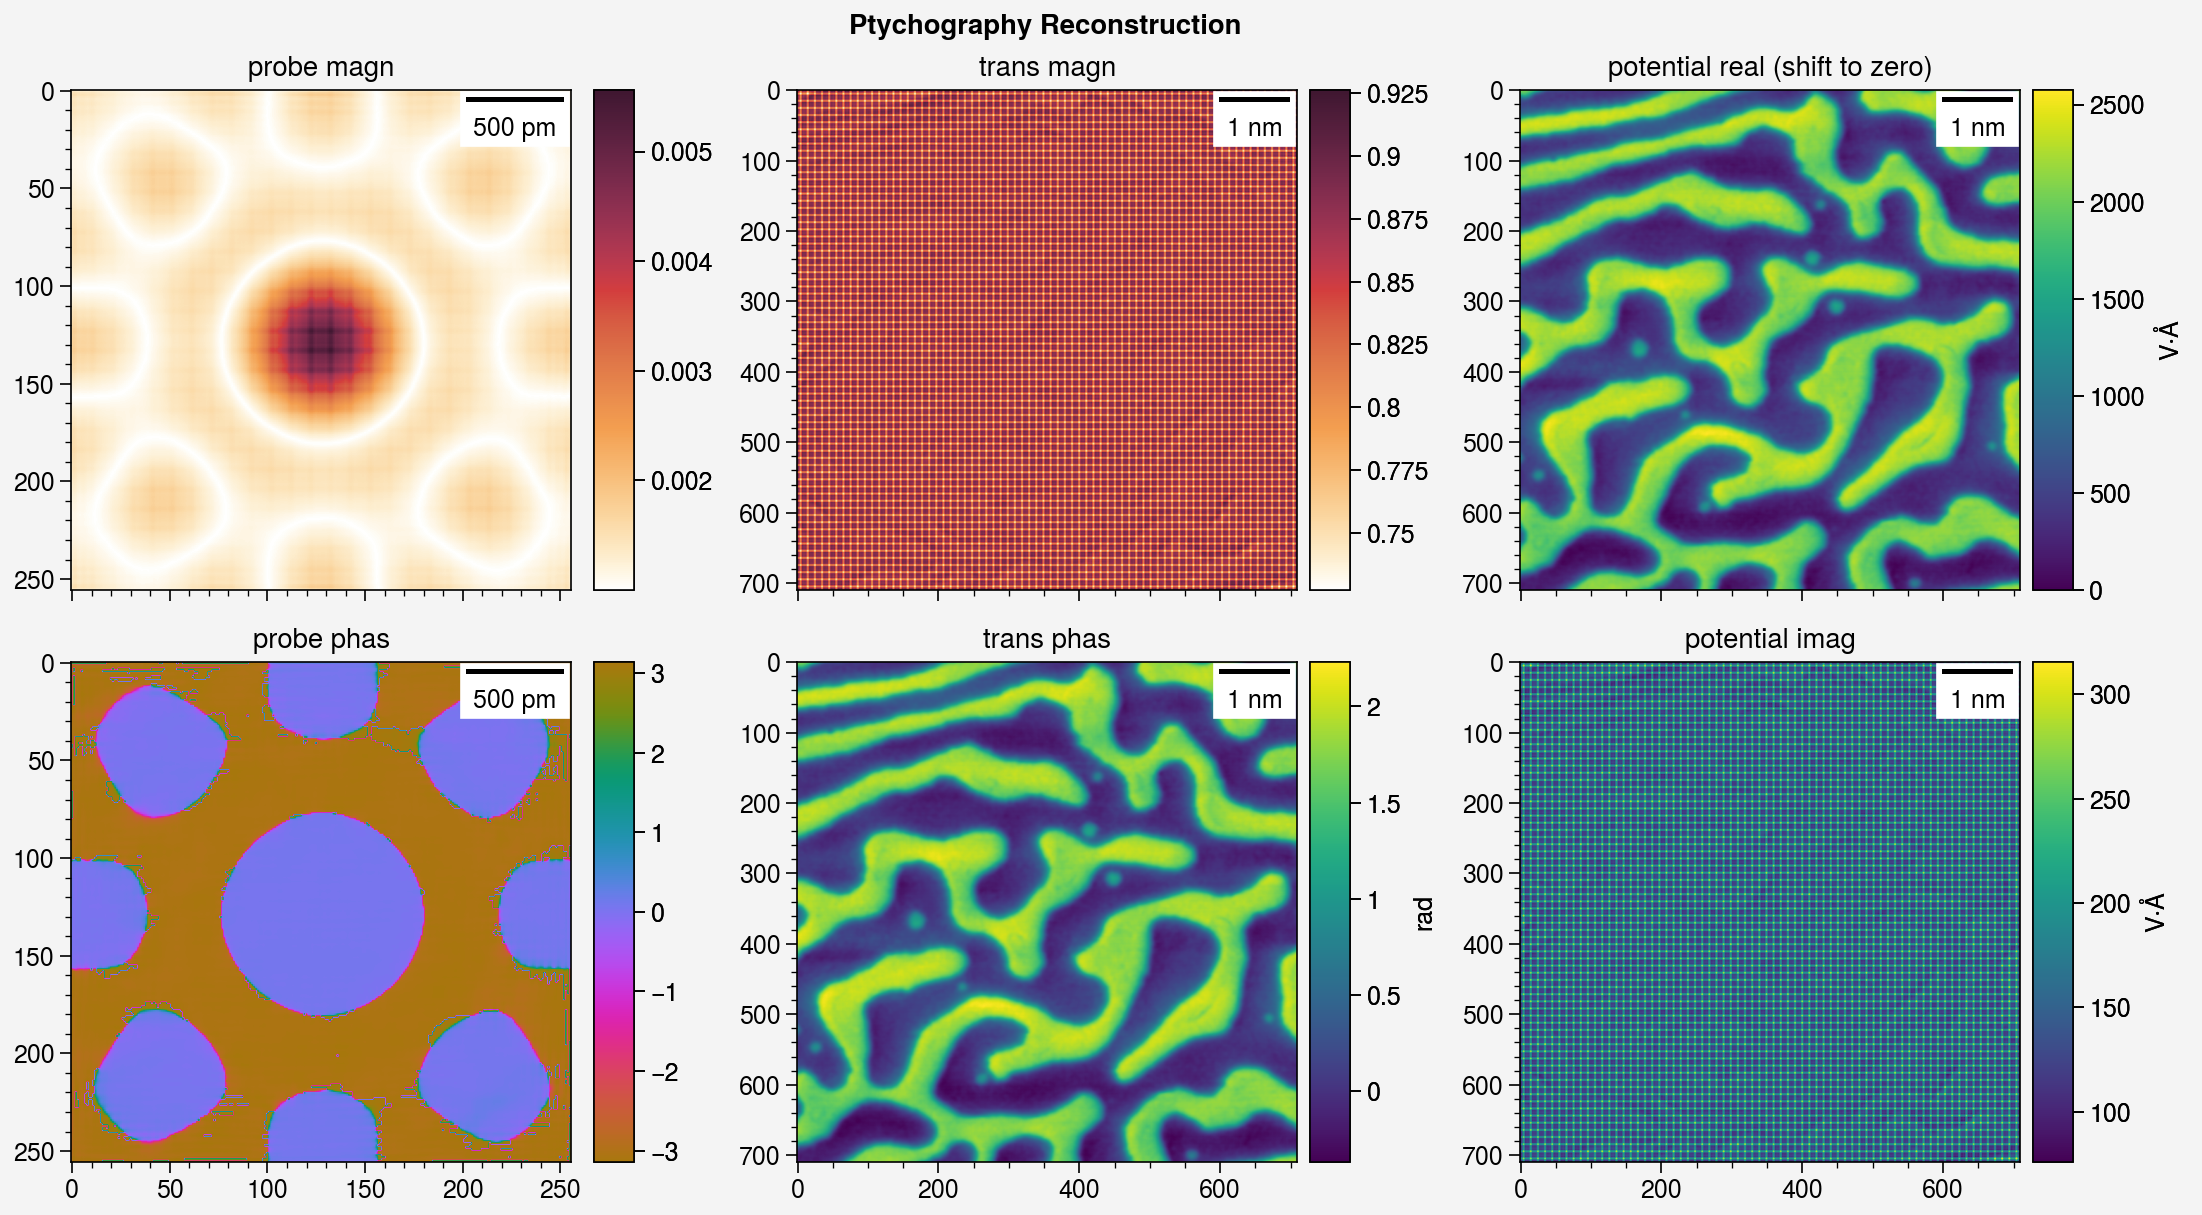

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
import proplot as pplt
from matplotlib_scalebar.scalebar import ScaleBar
pplt.rc["grid"] = False

fig, axs = pplt.subplots(nrows=2, ncols=3, sharey=False, suptitle="Ptychography Reconstruction")

# probe image (magnitude and phase parts)
m = axs[0, 0].imshow(np.abs(probe_rot) + 1e-3)#, norm=colors.LogNorm())
axs[0, 0].format(title="probe magn")
axs[0, 0].colorbar(m, loc="r")

m = axs[1, 0].imshow(np.angle(probe_rot), cmap="phase", vmin=-np.pi, vmax=np.pi)
axs[1, 0].format(title="probe phas")
axs[1, 0].colorbar(m, loc="r")

# transmission function (magnitude and phase parts)
m = axs[0, 1].imshow(np.abs(trans_rot))
axs[0, 1].format(title="trans magn")
axs[0, 1].colorbar(m, loc="r")

m = axs[1, 1].imshow(np.angle(trans_rot), cmap="viridis")
axs[1, 1].format(title="trans phas")
axs[1, 1].colorbar(m, loc="r", label="rad")

# potential function (real and imaginary parts)
m = axs[0, 2].imshow((potential_real - potential_real.min()) * 1e10, cmap="viridis")
axs[0, 2].format(title="potential real (shift to zero)")
axs[0, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

m = axs[1, 2].imshow(potential_imag * 1e10, cmap="viridis")
axs[1, 2].format(title="potential imag")
axs[1, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

for i in range(2):
    for j in range(3):
        axs[i, j].add_artist(ScaleBar(resolution_real_space, "m", length_fraction=0.2))

pplt.show()
fig.savefig(result_path/"overview.png")

In [12]:
print(f"--- {time.time() - start_time} seconds ---")

--- 1596.8516201972961 seconds ---


## Save the Results of the Final Iteration

In [13]:
np.save(result_path/"final_probe_rot.npy", probe_rot)
np.save(result_path/"final_trans_rot.npy", trans_rot)
np.save(result_path/"final_poten_rot.npy", potential)

## Fit Aberration in Probe Wave Function

In [14]:
from fitaber import fit_aber, coefs_all_up_to
import fitaber

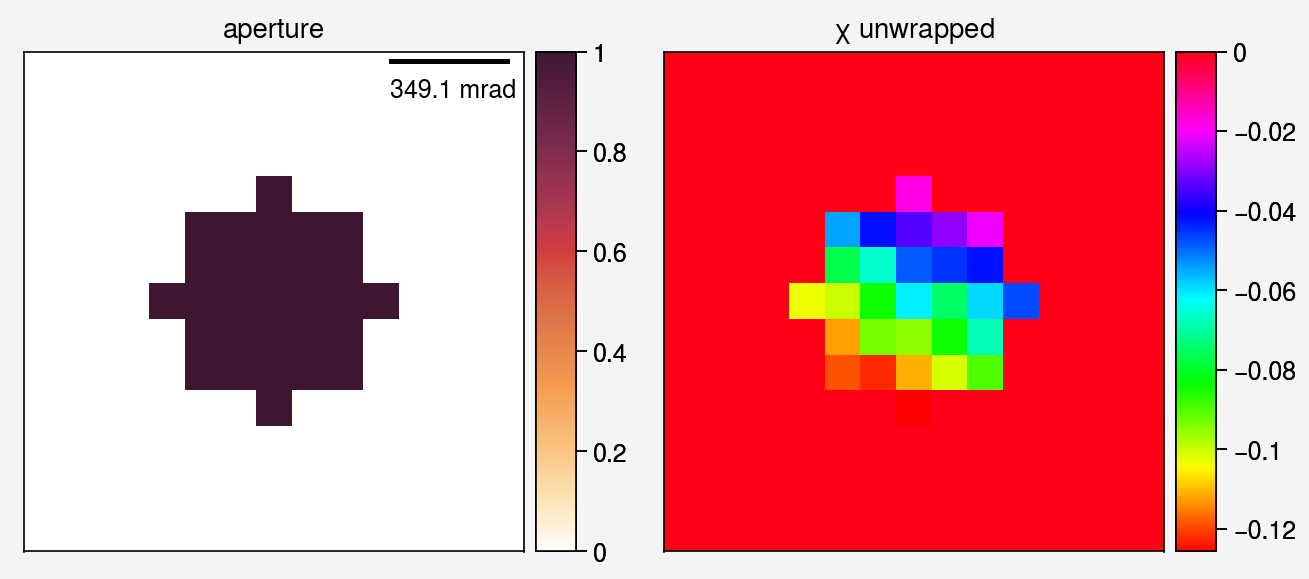

In [15]:
aperture = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot))))
aperture = (aperture > aperture.max()/2).astype(np.int32)
# chi = -np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture
chi = -unwrap_phase(np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture, wrap_around=True) * aperture

margin = aperture.shape[0]/2 - np.sum(aperture[aperture.shape[0]//2,:])
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2,
                                xlim=(margin, chi.shape[1]-margin),
                                ylim=(margin, chi.shape[1]-margin),
                                xticks=[], yticks=[])
m = ax1.imshow(aperture)
ax1.add_artist(ScaleBar(resolution_reciprocal_space_rad,
                        units="deg", dimension="angle", length_fraction=0.25,
                        scale_formatter=lambda value, unit: f"{value*np.pi/180*1e3: .1f} mrad"))
ax1.colorbar(m, loc="r")
ax1.format(title="aperture")

m = ax2.imshow(chi, cmap="hsv")
ax2.colorbar(m, loc="r")
ax2.format(title="$\chi$ unwrapped")

In [16]:
result_aber = fit_aber(chi, coefs_all_up_to(), scale=resolution_reciprocal_space_rad, mask=aperture, kV=attrs["voltage"])
print(result_aber.format())

[
[ 0]:      -: c(0,0) = C(-1,0)= Polar( 4.389e-05 nm,        180 °)
[ 1]:     A0: c(1,1) = C(0,1) = Polar(  0.008387 nm,      8.956 °)
[ 3]:     C1: c(2,0) = C(1,0) = Polar(     3.736 nm,        180 °)
[ 4]:     A1: c(2,2) = C(1,2) = Polar(     2.686 nm,      4.293 °)
[ 6]: 1/3 B2: c(3,1) = C(2,1) = Polar(      1125 nm,        103 °)
[ 8]:     A2: c(3,3) = C(2,3) = Polar(     278.5 nm,     -6.377 °)
[10]:     C3: c(4,0) = C(3,0) = Polar(     654.1 um,          0 °)
[11]: 1/4 S3: c(4,2) = C(3,2) = Polar(     607.7 um,      80.79 °)
[13]:     A3: c(4,4) = C(3,4) = Polar(     339.5 um,     -25.18 °)
[15]: 1/5 B4: c(5,1) = C(4,1) = Polar( 6.023e+04 um,     -82.68 °)
[17]: 1/5 D4: c(5,3) = C(4,3) = Polar( 1.599e+04 um,      56.24 °)
[19]:     A4: c(5,5) = C(4,5) = Polar(      1853 um,      22.67 °)
[21]:     C5: c(6,0) = C(5,0) = Polar( 2.369e+04 mm,        180 °)
[22]: 1/6 S5: c(6,2) = C(5,2) = Polar( 3.586e+04 mm,      -25.6 °)
[24]: 1/6 R5: c(6,4) = C(5,4) = Polar(  3.79e+04 mm,      20

aberration contribution (threshold = 5 %)
name, theta (mrad) (values [Angstrom], %)
==============  =============  =============  ===========  ==========  =========
..              0.5            0.625          1.25         2.5         5
==============  =============  =============  ===========  ==========  =========
==============  =============  =============  ===========  ==========  =========
-               4.389e-14      4.389e-14      4.389e-14    4.389e-14   4.389e-14
= 4.389e-05 nm  (89.62 %)      (86.8 %)       (71.48 %)    (38.54 %)   (5.425 %)
A0              4.194e-15      5.242e-15      1.048e-14    2.097e-14   4.194e-14
= 0.008387 nm   (8.564 %)      (10.37 %)      (17.08 %)    (18.42 %)   (5.184 %)
C1              4.671e-16      7.298e-16      2.919e-15    1.168e-14   4.671e-14
= 3.736 nm      (0.9538 %)     (1.443 %)      (4.755 %)    (10.26 %)   (5.773 %)
A1              3.357e-16      5.245e-16      2.098e-15    8.393e-15   3.357e-14
= 2.686 nm      (0.6856 %)     (1

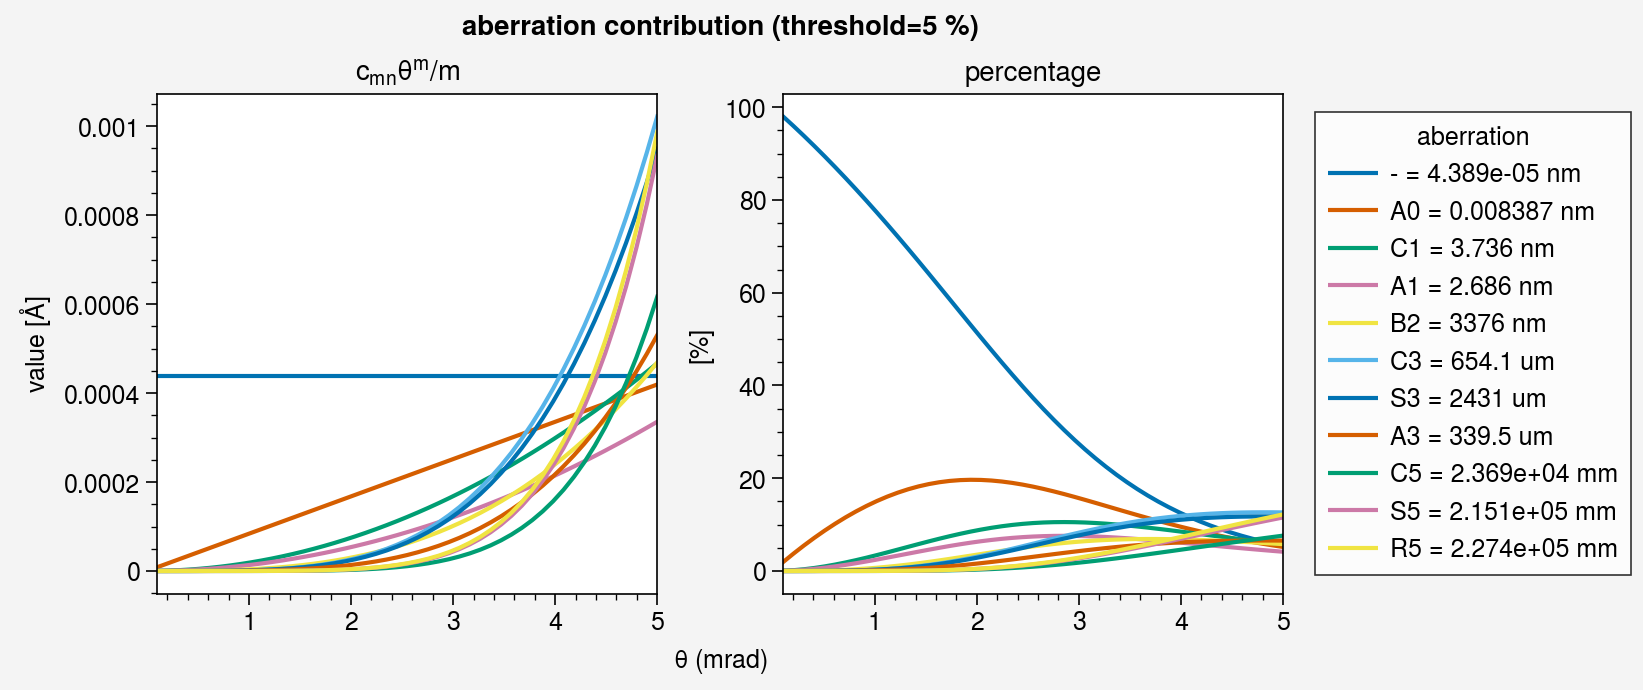

In [17]:
_ = fitaber.print_contribution(result_aber, attrs["semiconv"], threshold=5)
fitaber.plot_contribution(result_aber, attrs["semiconv"], threshold=5)

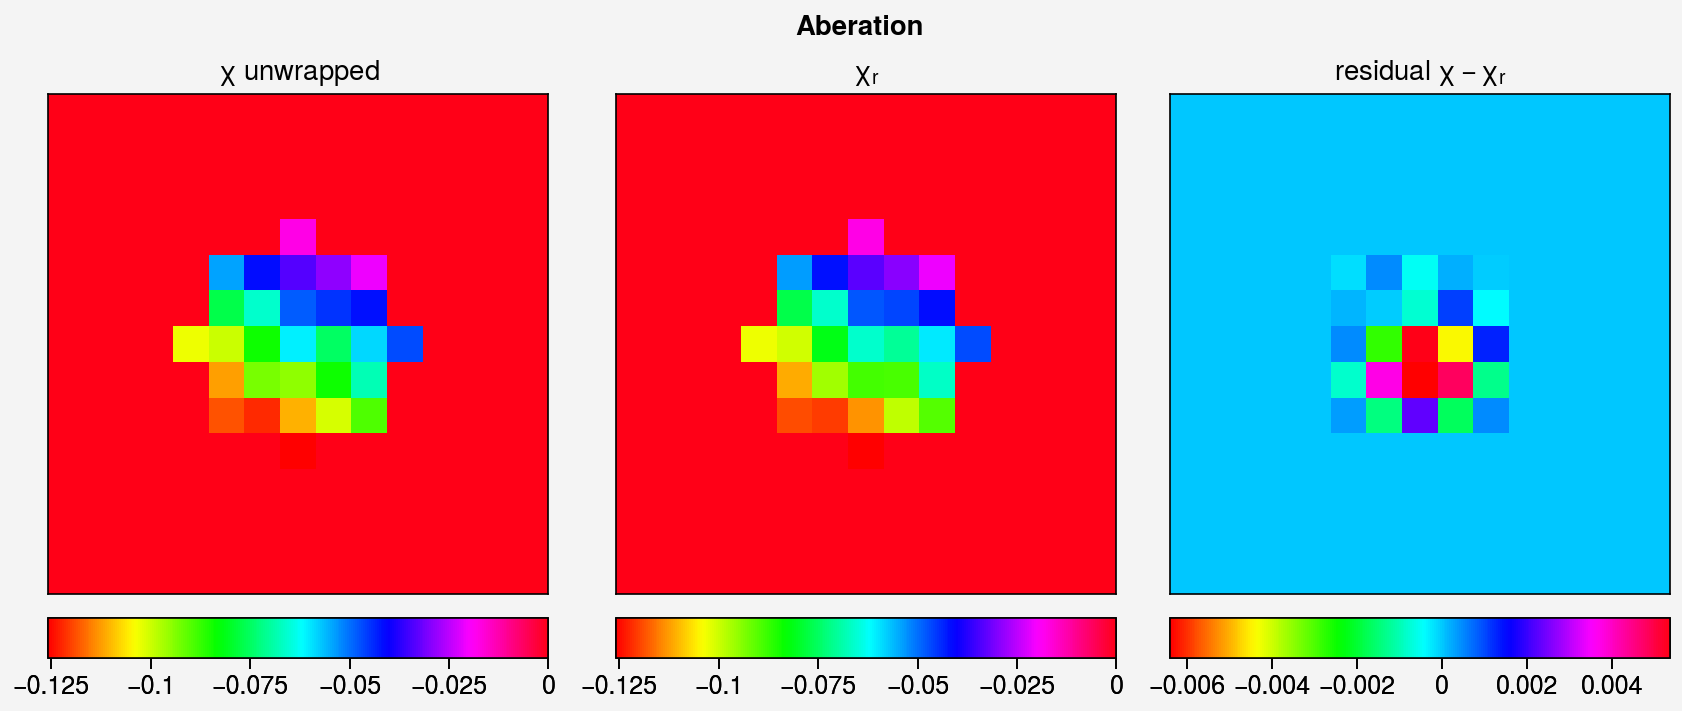

In [18]:
fig, axs = pplt.subplots(nrows=1, ncols=3, suptitle="Aberation",
                         xlim=(margin, chi.shape[1]-margin),
                         ylim=(margin, chi.shape[1]-margin),
                         xticks=[], yticks=[])
ax1, ax2, ax3 = axs

m = ax1.imshow(chi, cmap="hsv")
ax1.colorbar(m, loc="b")
ax1.format(title="$\chi$ unwrapped")

reconstaber = fitaber.aber(result_aber, chi.shape[0], resolution_reciprocal_space_rad) * aperture
m = ax2.imshow(reconstaber, cmap="hsv")
ax2.colorbar(m, loc="b")
ax2.format(title="$\chi_{\mathrm{r}}$")

residual = chi - reconstaber
m = ax3.imshow(residual, cmap="hsv")
ax3.colorbar(m, loc="b")
ax3.format(title="residual $\chi - \chi_{\mathrm{r}}$")

pplt.show()